# Подготовка данных

In [1]:
%matplotlib inline
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv(r"InternationalBifurca_DATA_2023-10-30_0629.csv", sep=',')

In [5]:
# Calculate the date range of the data
date_min = pd.to_datetime(df['date']).min()
date_max = pd.to_datetime(df['date']).max()
print(f"Date range: from {date_min} to {date_max}")

Date range: from 1968-03-04 00:00:00 to 2022-09-22 00:00:00


In [19]:
df['age'].value_counts().sort_values()

age
94.0      1
38.0      1
93.0      1
36.0      1
33.0      1
       ... 
66.0     83
65.0     86
61.0     87
69.0     90
63.0    104
Name: count, Length: 64, dtype: int64

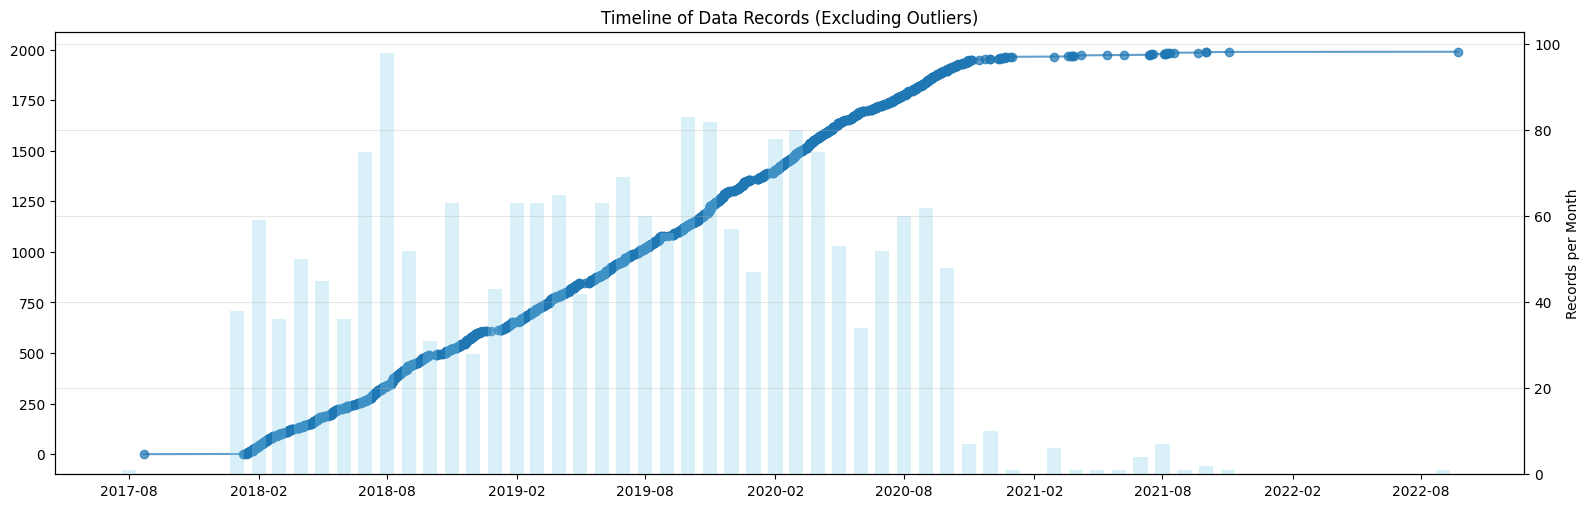

Date range (excluding outliers): from 2017-08-22 00:00:00 to 2022-09-22 00:00:00
Total records: 1990


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import numpy as np

# Convert date column to datetime and filter out outliers
df['date'] = pd.to_datetime(df['date'])
filtered_df = df[df['date'].dt.year > 1970]

# Sort by date
filtered_df = filtered_df.sort_values('date')

# Create a figure with larger width
plt.figure(figsize=(16, 6))  # Increased width from 12 to 16

# Create a timeline plot
plt.plot(filtered_df['date'], np.arange(len(filtered_df)), marker='o', linestyle='-', alpha=0.7)

# Add count by month/year as a histogram
ax2 = plt.gca().twinx()
filtered_df['year_month'] = filtered_df['date'].dt.to_period('M')
monthly_counts = filtered_df.groupby('year_month').size()
month_dates = [pd.to_datetime(str(date)) for date in monthly_counts.index]
ax2.bar(month_dates, monthly_counts, alpha=0.3, width=20, color='skyblue')

# Format the x-axis to show dates with more spacing
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# Increase interval from 3 to 6 months to reduce crowding
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

# Add labels and title
plt.title('Timeline of Data Records (Excluding Outliers)')
plt.xlabel('Date')
plt.gca().set_ylabel('Cumulative Count')
ax2.set_ylabel('Records per Month')

# Rotate date labels for better readability and adjust alignment
plt.xticks(rotation=45, ha='right')

# Add grid for readability
plt.grid(True, alpha=0.3)

# Ensure proper spacing between plot elements
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Add more space at the bottom for date labels

plt.show()

# Print date range info
date_min = filtered_df['date'].min()
date_max = filtered_df['date'].max()
print(f"Date range (excluding outliers): from {date_min} to {date_max}")
print(f"Total records: {len(filtered_df)}")

90% of people are between 52.0 and 78.0 years old

Age distribution statistics:
count    1990.000000
mean       63.938191
std         9.749383
min        28.000000
5%         48.000000
25%        58.000000
50%        64.000000
75%        70.000000
95%        81.000000
max        97.000000
Name: age, dtype: float64


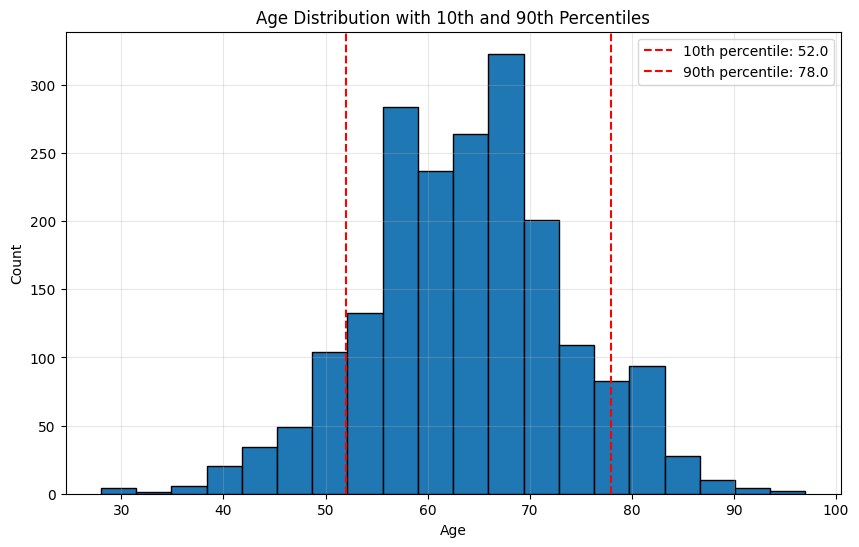

In [ ]:
lower_bound = df['age'].quantile(0.1)
upper_bound = df['age'].quantile(0.9)

print(f"90% of people are between {lower_bound:.1f} and {upper_bound:.1f} years old")

# For a more comprehensive view, you can get descriptive statistics
age_stats = df['age'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
print("\nAge distribution statistics:")
print(age_stats)

# Visualize the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=20, edgecolor='black')
plt.axvline(lower_bound, color='red', linestyle='--', label=f'10th percentile: {lower_bound:.1f}')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'90th percentile: {upper_bound:.1f}')
plt.title('Age Distribution with 10th and 90th Percentiles')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [4]:
df = df.dropna(subset=['sex'])
df

record_id        date  sex   age  adhoc_pci  weight  height  race  \
0     MNRI0001  2018-02-01  2.0  77.0        1.0    84.0   165.0   1.0   
1     MNRI0002  2018-01-24  1.0  68.0        0.0    81.0   171.0   1.0   
2     MNRI0003  2018-01-24  1.0  62.0        0.0    74.0   180.0   1.0   
3     MNRI0004  2018-01-30  1.0  67.0        1.0    84.0   167.0   1.0   
4     MNRI0005  2018-01-30  1.0  57.0        0.0   103.0   174.0   1.0   
...        ...         ...  ...   ...        ...     ...     ...   ...   
2053  TRCH0026  2019-03-11  1.0  67.0        1.0    90.0   174.0   1.0   
2054  TRCH0027  2019-03-18  1.0  69.0        1.0    60.0   174.0   1.0   
2055  TRCH0028  2019-03-19  2.0  81.0        0.0    50.0   160.0   1.0   
2056  TRCH0029  2019-03-28  1.0  86.0        1.0    74.0   170.0   1.0   
2057  TRCH0030  2019-03-20  2.0  85.0        1.0    60.0   165.0   1.0   

      clinical_presentation  time_from_mi_symptoms_onse  ...  \
0                       5.0                         4.0  ...   
1                       1.0                         NaN  ...   
2                       4.0                         NaN  ...   
3                       2.0                         NaN  ...   
4                       1.0                         NaN  ...   
...                     ...                         ...  ...   
2053                    2.0                         NaN  ...   
2054                    3.0                         1.0  ...   
2055                    2.0                         NaN  ...   
2056                    3.0                         1.0  ...   
2057                    3.0                         1.0  ...   

      time_to_death_f5  time_to_acs_f5  time_to_stroke_f5  time_to_pci_f5  \
0                  NaN             NaN                NaN             NaN   
1                  NaN             NaN                NaN             NaN   
2                  NaN             NaN                NaN             NaN   
3                  NaN             NaN                NaN             NaN   
4                  NaN             NaN                NaN             NaN   
...                ...             ...                ...             ...   
2053               NaN             NaN                NaN             NaN   
2054               NaN             NaN                NaN             NaN   
2055               NaN             NaN                NaN             NaN   
2056               NaN             NaN                NaN             NaN   
2057               NaN             NaN                NaN             NaN   

      time_to_cabg_f5  hospitalization_f5  bleeding_f5  \
0                 NaN                 NaN          NaN   
1                 NaN                 NaN          NaN   
2                 NaN                 NaN          NaN   
3                 NaN                 NaN          NaN   
4                 NaN                 NaN          NaN   
...               ...                 ...          ...   
2053              NaN                 NaN          NaN   
2054              NaN                 NaN          NaN   
2055              NaN                 NaN          NaN   
2056              NaN                 NaN          NaN   
2057              NaN                 NaN          NaN   

      major_required_trans_f5  tlr_f5  tvr_f5  
0                         NaN     NaN     NaN  
1                         NaN     NaN     NaN  
2                         NaN     NaN     NaN  
3                         NaN     NaN     NaN  
4                         NaN     NaN     NaN  
...                       ...     ...     ...  
2053                      NaN     NaN     NaN  
2054                      NaN     NaN     NaN  
2055                      NaN     NaN     NaN  
2056                      NaN     NaN     NaN  
2057                      NaN     NaN     NaN  

[1990 rows x 247 columns]

In [5]:
anyInf = df[df == np.inf].sum()
anyInf[anyInf != 0]

stent_distal_vessel_size    inf
sb_stent_sb_diametr         inf
dtype: object

In [6]:
patient_info_cols = ['record_id', 'date', 'sex', 'age', 'adhoc_pci', 'weight', 'height', 
                     'race', 'clinical_presentation', 'time_from_mi_symptoms_onse', 
                     'ccs_class', 'diabet', 'insulin_diabetes', 'hypertension', 'smoking', 
                     'dyslipidemia', 'anemia', 'atrial_fibrilation', 'oac_use', 'valvular_disease', 
                     'valvular_disease_was_previ', 'if_yes_what_type___1', 'if_yes_what_type___2', 
                     'if_yes_what_type___3', 'if_yes_what_type___4', 'if_yes_what_type___5', 
                     'if_yes_what_type___6', 'if_yes_what_type___7', 'ef', 'creatinine', 'ckd', 
                     'mi_history', 'cerebrovascular_disease', 'previously_treated_cerebro', 'previous_stroke_tia', 
                     'peripheral_artery_disease', 'previously_treated_periphe', 'copd', 'history_of_cancer', 
                     'previous_pci', 'previous_cabg']

invention_cols = ['single_vessel', 'trifurcation', 'several_biffurcations', 'bifurcation_location', 
                  'lesion_ivolves', 'protected_left_main', 'angle', 'calcium', 'trombosis', 
                  'total_trobotic_occlusion', 'restenosis_reocclusion', 'overlap_sb', 'cto_bifurc', 
                  'syntax_score', 'medina_proximal', 'medina_distal', 'medina_side', 'mb_length_proximal', 
                  'sb_length', 'proximal_diametr', 'distal_diametr', 'side_diametr', 'stenosis_proximal', 
                  'stenosis_distal', 'timi_flow_main_branch', 'side_stenosis', 'timi_flow_side_branch', 
                  'major_lm', 'major_non_lm', 'minor_criteria', 'main_branch_rvd', 'def', 'def_2']

operation_cols = ['side_protection', 'main_predilatation', 'side_predilat', 'trombus_aspiration', 
                  'kissing_predilitation', 'stenting', 'drug_coated_balloon', 'balloon_angioplasty', 
                  'stent_was_implated_from_lm', 'stent_number', 'stent_number_bif', 'stent_technique', 
                  'first_stent_impanted', 'provisional_2_stent_techni', 'stent_direction', 'defered_stenting', 
                  'stent_diameter', 'stent_length', 'stent_type___1', 'stent_type___2', 'stent_type___3', 
                  'stent_type___4', 'stent_type___5', 'stent_type___6', 'stent_type___7', 'stent_type___9', 
                  'stent_type___8', 'dstent2', 'stent_length2', 'stent_distal_vessel_size', 
                  'sb_stent_side_branch_diametr', 'sb_stent_sb_diametr', 'twostent_technique', 
                  'sb_dilatation', 'stent_postdilatation', 'proximal_optimization', 'pot', 
                  'pot_balloon_diametr', 'kissing_post', 'modified_kis', 'several_kissing']

In [7]:
non_vascular_deaths = ['MNRI1054', 'MNRI1191', 'MNRI1351', 'MNRI1352', 'MNRI1473', 'MNRI1670', 'MNRI0637', 'MNRI0656', 'MNRI0751', 'MNRI0758',
                      'MNRI0805', 'MNRI0818', 'MNRI1054', 'MNRI0087', 'MNRI1191', 'MNRI0108', 'MNRI0307', 'MNRI0215', 'MNRI0322', 'MNRI0293',
                      'MNRI0156', 'MNRI0215', 'MNRI0488', 'MNRI0612', 'MNRI0708', 'MNRI0767', 'MNRI0772', 'MNRI0786', 'MNRI1105', 'MNRI1186',
                      'MNRI1462', 'MNRI1633']

In [8]:
df = df[~df['record_id'].isin(non_vascular_deaths)]

In [9]:
df

record_id        date  sex   age  adhoc_pci  weight  height  race  \
0     MNRI0001  2018-02-01  2.0  77.0        1.0    84.0   165.0   1.0   
1     MNRI0002  2018-01-24  1.0  68.0        0.0    81.0   171.0   1.0   
2     MNRI0003  2018-01-24  1.0  62.0        0.0    74.0   180.0   1.0   
3     MNRI0004  2018-01-30  1.0  67.0        1.0    84.0   167.0   1.0   
4     MNRI0005  2018-01-30  1.0  57.0        0.0   103.0   174.0   1.0   
...        ...         ...  ...   ...        ...     ...     ...   ...   
2053  TRCH0026  2019-03-11  1.0  67.0        1.0    90.0   174.0   1.0   
2054  TRCH0027  2019-03-18  1.0  69.0        1.0    60.0   174.0   1.0   
2055  TRCH0028  2019-03-19  2.0  81.0        0.0    50.0   160.0   1.0   
2056  TRCH0029  2019-03-28  1.0  86.0        1.0    74.0   170.0   1.0   
2057  TRCH0030  2019-03-20  2.0  85.0        1.0    60.0   165.0   1.0   

      clinical_presentation  time_from_mi_symptoms_onse  ...  \
0                       5.0                         4.0  ...   
1                       1.0                         NaN  ...   
2                       4.0                         NaN  ...   
3                       2.0                         NaN  ...   
4                       1.0                         NaN  ...   
...                     ...                         ...  ...   
2053                    2.0                         NaN  ...   
2054                    3.0                         1.0  ...   
2055                    2.0                         NaN  ...   
2056                    3.0                         1.0  ...   
2057                    3.0                         1.0  ...   

      time_to_death_f5  time_to_acs_f5  time_to_stroke_f5  time_to_pci_f5  \
0                  NaN             NaN                NaN             NaN   
1                  NaN             NaN                NaN             NaN   
2                  NaN             NaN                NaN             NaN   
3                  NaN             NaN                NaN             NaN   
4                  NaN             NaN                NaN             NaN   
...                ...             ...                ...             ...   
2053               NaN             NaN                NaN             NaN   
2054               NaN             NaN                NaN             NaN   
2055               NaN             NaN                NaN             NaN   
2056               NaN             NaN                NaN             NaN   
2057               NaN             NaN                NaN             NaN   

      time_to_cabg_f5  hospitalization_f5  bleeding_f5  \
0                 NaN                 NaN          NaN   
1                 NaN                 NaN          NaN   
2                 NaN                 NaN          NaN   
3                 NaN                 NaN          NaN   
4                 NaN                 NaN          NaN   
...               ...                 ...          ...   
2053              NaN                 NaN          NaN   
2054              NaN                 NaN          NaN   
2055              NaN                 NaN          NaN   
2056              NaN                 NaN          NaN   
2057              NaN                 NaN          NaN   

      major_required_trans_f5  tlr_f5  tvr_f5  
0                         NaN     NaN     NaN  
1                         NaN     NaN     NaN  
2                         NaN     NaN     NaN  
3                         NaN     NaN     NaN  
4                         NaN     NaN     NaN  
...                       ...     ...     ...  
2053                      NaN     NaN     NaN  
2054                      NaN     NaN     NaN  
2055                      NaN     NaN     NaN  
2056                      NaN     NaN     NaN  
2057                      NaN     NaN     NaN  

[1961 rows x 247 columns]

In [10]:
patient_present_cols = patient_info_cols + invention_cols + operation_cols
patient_present_df = pd.DataFrame({col_name: df[col_name] for col_name in patient_present_cols})

In [11]:
patient_present_df

record_id        date  sex   age  adhoc_pci  weight  height  race  \
0     MNRI0001  2018-02-01  2.0  77.0        1.0    84.0   165.0   1.0   
1     MNRI0002  2018-01-24  1.0  68.0        0.0    81.0   171.0   1.0   
2     MNRI0003  2018-01-24  1.0  62.0        0.0    74.0   180.0   1.0   
3     MNRI0004  2018-01-30  1.0  67.0        1.0    84.0   167.0   1.0   
4     MNRI0005  2018-01-30  1.0  57.0        0.0   103.0   174.0   1.0   
...        ...         ...  ...   ...        ...     ...     ...   ...   
2053  TRCH0026  2019-03-11  1.0  67.0        1.0    90.0   174.0   1.0   
2054  TRCH0027  2019-03-18  1.0  69.0        1.0    60.0   174.0   1.0   
2055  TRCH0028  2019-03-19  2.0  81.0        0.0    50.0   160.0   1.0   
2056  TRCH0029  2019-03-28  1.0  86.0        1.0    74.0   170.0   1.0   
2057  TRCH0030  2019-03-20  2.0  85.0        1.0    60.0   165.0   1.0   

      clinical_presentation  time_from_mi_symptoms_onse  ...  \
0                       5.0                         4.0  ...   
1                       1.0                         NaN  ...   
2                       4.0                         NaN  ...   
3                       2.0                         NaN  ...   
4                       1.0                         NaN  ...   
...                     ...                         ...  ...   
2053                    2.0                         NaN  ...   
2054                    3.0                         1.0  ...   
2055                    2.0                         NaN  ...   
2056                    3.0                         1.0  ...   
2057                    3.0                         1.0  ...   

      sb_stent_sb_diametr  twostent_technique  sb_dilatation  \
0                0.952381                 7.0            0.0   
1                1.333333                 NaN            0.0   
2                1.153846                 NaN            0.0   
3                1.285714                 NaN            0.0   
4                1.590909                 NaN            1.0   
...                   ...                 ...            ...   
2053             1.500000                 NaN            1.0   
2054             1.100000                 NaN            0.0   
2055             1.000000                 7.0            1.0   
2056             0.750000                 NaN            0.0   
2057             1.400000                 NaN            0.0   

      stent_postdilatation  proximal_optimization  pot  pot_balloon_diametr  \
0                      1.0                    0.0  NaN                  NaN   
1                      0.0                    0.0  NaN                  NaN   
2                      1.0                    0.0  NaN                  NaN   
3                      0.0                    1.0  1.0                  5.0   
4                      0.0                    0.0  NaN                  NaN   
...                    ...                    ...  ...                  ...   
2053                   1.0                    1.0  0.0                  NaN   
2054                   0.0                    0.0  NaN                  NaN   
2055                   1.0                    1.0  0.0                  NaN   
2056                   0.0                    1.0  1.0                  4.0   
2057                   0.0                    0.0  NaN                  NaN   

      kissing_post  modified_kis  several_kissing  
0              1.0           0.0              0.0  
1              1.0           0.0              0.0  
2              0.0           0.0              NaN  
3              0.0           0.0              NaN  
4              0.0           0.0              NaN  
...            ...           ...              ...  
2053           1.0           1.0              0.0  
2054           0.0           0.0              NaN  
2055           1.0           1.0              0.0  
2056           0.0           0.0              NaN  
2057           0.0           0.0              NaN  

[196

In [12]:
def remove_columns_with_nan_threshold(df, threshold=250):
    """
    Удаление колонок из DataFrame с количеством NaN больше заданного порога.

    Параметры:
    df : pandas.DataFrame
        Исходный DataFrame, из которого будут удалены колонки.
    threshold : int
        Пороговое значение количества NaN для удаления колонки.

    Возвращает:
    pandas.DataFrame
        DataFrame после удаления колонок.
    """
    # Считаем количество NaN в каждой колонке
    nan_counts = df.isnull().sum()

    # Получаем список колонок, которые нужно удалить
    columns_to_drop = nan_counts[nan_counts > threshold].index

    # Удаляем колонки
    df_dropped = df.drop(columns=columns_to_drop)

    return df_dropped

In [13]:
patient_present_df = remove_columns_with_nan_threshold(patient_present_df, 500)

In [14]:
patient_present_df = patient_present_df.drop(['record_id', 'date'], axis = 1)
patient_present_df

sex   age  adhoc_pci  weight  height  race  clinical_presentation  \
0     2.0  77.0        1.0    84.0   165.0   1.0                    5.0   
1     1.0  68.0        0.0    81.0   171.0   1.0                    1.0   
2     1.0  62.0        0.0    74.0   180.0   1.0                    4.0   
3     1.0  67.0        1.0    84.0   167.0   1.0                    2.0   
4     1.0  57.0        0.0   103.0   174.0   1.0                    1.0   
...   ...   ...        ...     ...     ...   ...                    ...   
2053  1.0  67.0        1.0    90.0   174.0   1.0                    2.0   
2054  1.0  69.0        1.0    60.0   174.0   1.0                    3.0   
2055  2.0  81.0        0.0    50.0   160.0   1.0                    2.0   
2056  1.0  86.0        1.0    74.0   170.0   1.0                    3.0   
2057  2.0  85.0        1.0    60.0   165.0   1.0                    3.0   

      diabet  hypertension  smoking  ...  stent_type___6  stent_type___7  \
0        0.0           1.0      0.0  ...               0               0   
1        0.0           1.0      0.0  ...               0               0   
2        0.0           1.0      1.0  ...               0               0   
3        0.0           1.0      0.0  ...               0               0   
4        0.0           1.0      0.0  ...               0               0   
...      ...           ...      ...  ...             ...             ...   
2053     2.0           1.0      0.0  ...               0               0   
2054     1.0           1.0      0.0  ...               0               0   
2055     2.0           1.0      0.0  ...               0               0   
2056     1.0           1.0      0.0  ...               0               0   
2057     1.0           1.0      0.0  ...               0               0   

      stent_type___9  stent_type___8  stent_distal_vessel_size  \
0                  0               0                  1.111111   
1                  0               0                  1.290323   
2                  0               0                  1.000000   
3                  0               0                  0.957447   
4                  0               0                  1.250000   
...              ...             ...                       ...   
2053               0               0                  1.200000   
2054               1               0                  1.100000   
2055               0               0                  1.000000   
2056               0               0                  1.090909   
2057               1               0                  1.166667   

      sb_stent_sb_diametr  sb_dilatation  stent_postdilatation  kissing_post  \
0                0.952381            0.0                   1.0           1.0   
1                1.333333            0.0                   0.0           1.0   
2                1.153846            0.0                   1.0           0.0   
3                1.285714            0.0                   0.0           0.0   
4                1.590909            1.0                   0.0           0.0   
...                   ...            ...                   ...           ...   
2053             1.500000            1.0                   1.0           1.0   
2054             1.100000            0.0                   0.0           0.0   
2055             1.000000            1.0                   1.0           1.0   
2056             0.750000            0.0                   0.0           0.0   
2057             1.400000            0.0                   0.0           0.0   

      modified_kis  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
...            ...  
2053           1.0  
2054           0.0  
2055           1.0  
2056           0.0  
2057           0.0  

[1961 rows x 83 columns]

In [15]:
patient_present_df.replace(to_replace = [np.inf, -np.inf], value= None, inplace=True)

In [16]:
cols_to_drop = patient_present_df.columns[patient_present_df.nunique() <= 1]
patient_present_df = patient_present_df.drop(cols_to_drop, axis=1)
patient_present_df

sex   age adhoc_pci weight height race clinical_presentation diabet  \
0     2.0  77.0       1.0   84.0  165.0  1.0                   5.0    0.0   
1     1.0  68.0       0.0   81.0  171.0  1.0                   1.0    0.0   
2     1.0  62.0       0.0   74.0  180.0  1.0                   4.0    0.0   
3     1.0  67.0       1.0   84.0  167.0  1.0                   2.0    0.0   
4     1.0  57.0       0.0  103.0  174.0  1.0                   1.0    0.0   
...   ...   ...       ...    ...    ...  ...                   ...    ...   
2053  1.0  67.0       1.0   90.0  174.0  1.0                   2.0    2.0   
2054  1.0  69.0       1.0   60.0  174.0  1.0                   3.0    1.0   
2055  2.0  81.0       0.0   50.0  160.0  1.0                   2.0    2.0   
2056  1.0  86.0       1.0   74.0  170.0  1.0                   3.0    1.0   
2057  2.0  85.0       1.0   60.0  165.0  1.0                   3.0    1.0   

     hypertension smoking  ... stent_type___6 stent_type___7 stent_type___9  \
0             1.0     0.0  ...              0              0              0   
1             1.0     0.0  ...              0              0              0   
2             1.0     1.0  ...              0              0              0   
3             1.0     0.0  ...              0              0              0   
4             1.0     0.0  ...              0              0              0   
...           ...     ...  ...            ...            ...            ...   
2053          1.0     0.0  ...              0              0              0   
2054          1.0     0.0  ...              0              0              1   
2055          1.0     0.0  ...              0              0              0   
2056          1.0     0.0  ...              0              0              0   
2057          1.0     0.0  ...              0              0              1   

     stent_type___8  stent_distal_vessel_size  sb_stent_sb_diametr  \
0                 0                  1.111111             0.952381   
1                 0                  1.290323             1.333333   
2                 0                       1.0             1.153846   
3                 0                  0.957447             1.285714   
4                 0                      1.25             1.590909   
...             ...                       ...                  ...   
2053              0                       1.2                  1.5   
2054              0                       1.1                  1.1   
2055              0                       1.0                  1.0   
2056              0                  1.090909                 0.75   
2057              0                  1.166667                  1.4   

      sb_dilatation  stent_postdilatation  kissing_post modified_kis  
0               0.0                   1.0           1.0          0.0  
1               0.0                   0.0           1.0          0.0  
2               0.0                   1.0           0.0          0.0  
3               0.0                   0.0           0.0          0.0  
4               1.0                   0.0           0.0          0.0  
...             ...                   ...           ...          ...  
2053            1.0                   1.0           1.0          1.0  
2054            0.0                   0.0           0.0          0.0  
2055            1.0                   1.0           1.0          1.0  
2056            0.0                   0.0           0.0          0.0  
2057            0.0                   0.0           0.0          0.0  

[1961 rows x 81 columns]

In [17]:
numerical = ['age', 'weight', 'height', 'ef', 'creatinine', 'ckd', 'angle', 'mb_length_proximal', 'proximal_diametr', 'distal_diametr', 'side_diametr',
            'stenosis_proximal', 'stenosis_distal', 'side_stenosis', 'minor_criteria', 'main_branch_rvd', 'stent_diameter', 'stent_length',
            'stent_distal_vessel_size', 'sb_stent_sb_diametr']
cathegorical = ['sex', 'race', 'clinical_presentation', 'bifurcation_location', 'stent_number', 'stent_number_bif', 'stent_technique',
               'stent_direction', ]
binary = ['diabet', 'adhoc_pci', 'hypertension', 'smoking', 'dyslipidemia', 'anemia', 'atrial_fibrilation', 'oac_use', 'if_yes_what_type___1',
         'if_yes_what_type___2', 'if_yes_what_type___3', 'if_yes_what_type___4',  'if_yes_what_type___6', 
          'mi_history', 'cerebrovascular_disease', 'peripheral_artery_disease', 'copd', 'history_of_cancer',
         'previous_pci', 'previous_cabg', 'single_vessel', 'trifurcation', 'several_biffurcations', 'calcium', 'trombosis', 'restenosis_reocclusion',
         'cto_bifurc', 'medina_proximal', 'medina_distal', 'medina_side', 'major_lm', 'major_non_lm', 'def', 'def_2', 'side_protection', 'main_predilatation',
         'side_predilat', 'kissing_predilitation', 'stenting', 'defered_stenting', 'stent_type___1', 'stent_type___2', 'stent_type___3', 'stent_type___4',
         'stent_type___5', 'stent_type___6', 'stent_type___7', 'stent_type___9', 'stent_type___8', 'sb_dilatation', 'stent_postdilatation',
         'kissing_post', 'modified_kis']

In [18]:
without_second_bif = df
adverse_events = without_second_bif['event_type_followup_f2___1'] \
| without_second_bif['event_type_followup_f2___2'] \
| without_second_bif['event_type_followup_f2_v2___1'] \
| without_second_bif['event_type_followup_f2_v2___2']
print(sum(adverse_events))
print(len(adverse_events))

146
1961


In [19]:
combined = zip(without_second_bif['event_type_followup_f2___1'],  
               without_second_bif['event_type_followup_f2___2'] * 2,
               without_second_bif['event_type_followup_f2_v2___1'] * 3, 
               without_second_bif['event_type_followup_f2_v2___2'] * 4)

combined_adverse_events = np.array([max(t) for t in combined])

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patient_present_df, combined_adverse_events, test_size=0.4, stratify=combined_adverse_events, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

In [21]:
y_train[y_train != 0] = 1
y_test[y_test != 0] = 1
y_val[y_val != 0] = 1

In [22]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

imputer_categorical = SimpleImputer(strategy='most_frequent')
X_train[cathegorical + binary] = imputer_categorical.fit_transform(X_train[cathegorical + binary])
X_test[cathegorical + binary] = imputer_categorical.transform(X_test[cathegorical + binary])
X_val[cathegorical + binary] = imputer_categorical.transform(X_val[cathegorical + binary])

imputer = IterativeImputer(random_state=0)
columns = list(X_train.columns)
X_train = pd.DataFrame(data = imputer.fit_transform(X_train), columns = columns)
X_test = pd.DataFrame(data = imputer.transform(X_test), columns = columns)
X_val = pd.DataFrame(data = imputer.transform(X_val), columns = columns)

X_train

sex   age  adhoc_pci      weight      height  race  \
0     2.0  68.0        0.0   76.000000  154.000000   1.0   
1     1.0  67.0        0.0   80.000000  167.000000   1.0   
2     1.0  52.0        1.0  100.000000  170.000000   1.0   
3     1.0  75.0        0.0   87.000000  179.000000   1.0   
4     2.0  65.0        1.0   86.614613  159.897683   1.0   
...   ...   ...        ...         ...         ...   ...   
1171  1.0  57.0        0.0   90.000000  167.000000   2.0   
1172  1.0  59.0        1.0   75.000000  168.000000   1.0   
1173  1.0  69.0        0.0   66.000000  170.000000   1.0   
1174  1.0  57.0        0.0   93.000000  185.000000   1.0   
1175  1.0  61.0        0.0   63.000000  158.000000   3.0   

      clinical_presentation  diabet  hypertension  smoking  ...  \
0                       1.0     2.0           1.0      0.0  ...   
1                       5.0     0.0           1.0      0.0  ...   
2                       3.0     2.0           1.0      0.0  ...   
3                       1.0     2.0           1.0      0.0  ...   
4                       3.0     1.0           1.0      0.0  ...   
...                     ...     ...           ...      ...  ...   
1171                    1.0     1.0           1.0      0.0  ...   
1172                    3.0     0.0           1.0      1.0  ...   
1173                    1.0     0.0           1.0      1.0  ...   
1174                    2.0     2.0           1.0      0.0  ...   
1175                    1.0     1.0           1.0      0.0  ...   

      stent_type___6  stent_type___7  stent_type___9  stent_type___8  \
0                0.0             0.0             0.0             0.0   
1                0.0             0.0             0.0             0.0   
2                0.0             0.0             0.0             0.0   
3                0.0             0.0             0.0             0.0   
4                0.0             0.0             0.0             0.0   
...              ...             ...             ...             ...   
1171             0.0             0.0             0.0             0.0   
1172             0.0             0.0             0.0             0.0   
1173             0.0             0.0             0.0             0.0   
1174             0.0             0.0             0.0             0.0   
1175             0.0             0.0             0.0             0.0   

      stent_distal_vessel_size  sb_stent_sb_diametr  sb_dilatation  \
0                     0.857143             1.034483            0.0   
1                     1.000000             1.086957            0.0   
2                     0.937500             0.731707            0.0   
3                     1.071429             1.304348            0.0   
4                     0.757576             0.833333            0.0   
...                        ...                  ...            ...   
1171                  1.290323             1.142857            0.0   
1172                  1.206897             1.346154            0.0   
1173                  1.166667             1.206897            0.0   
1174                  1.290323             1.333333            0.0   
1175                  1.100000             1.145833            0.0   

      stent_postdilatation  kissing_post  modified_kis  
0                      1.0           0.0           0.0  
1                      0.0           0.0           0.0  
2                      0.0           0.0           0.0  
3                      1.0           0.0           0.0  
4                      0.0           0.0           0.0  
...                    ...           ...           ...  
1171                   0.0           1.0           0.0  
1172                   0.0           0.0           0.0  
1173                   0.0           1.0           1.0  
1174                   0.0           1.0           0.0  
1175                   1.0           0.0           0.0  

[1176 rows x 81 columns]

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


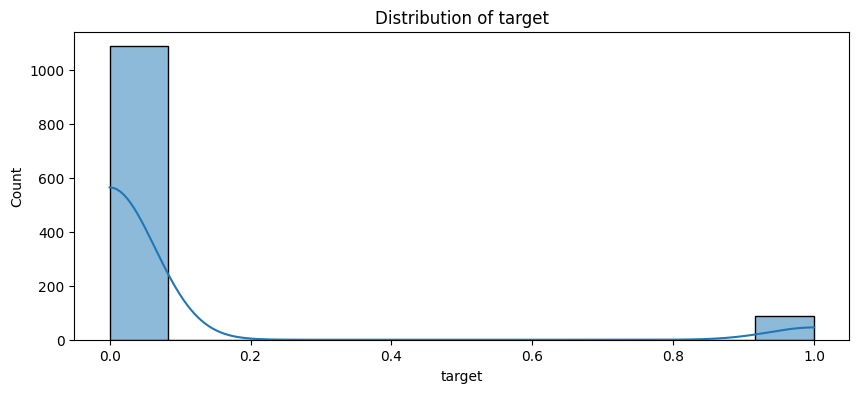

In [23]:
plt.figure(figsize=(10,4))
sns.histplot(y_train, kde=True)
plt.title(f'Distribution of target')
plt.xlabel('target')
plt.ylabel('Count')
plt.show()

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


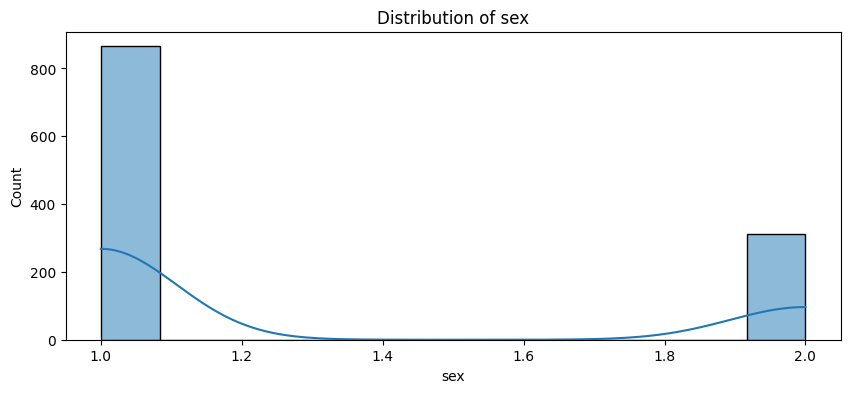

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


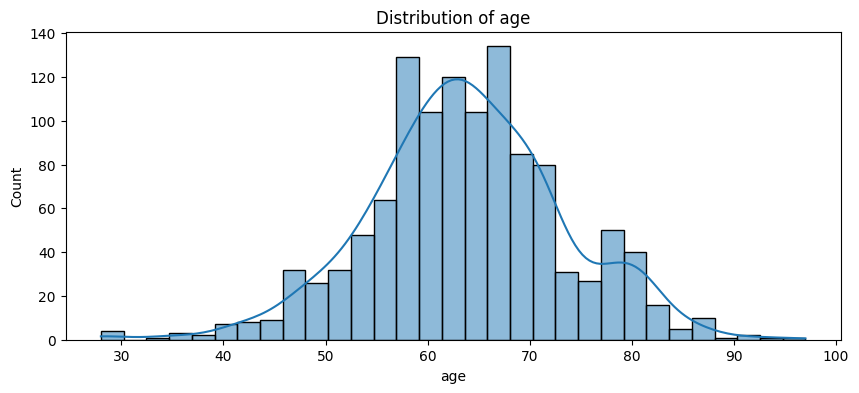

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


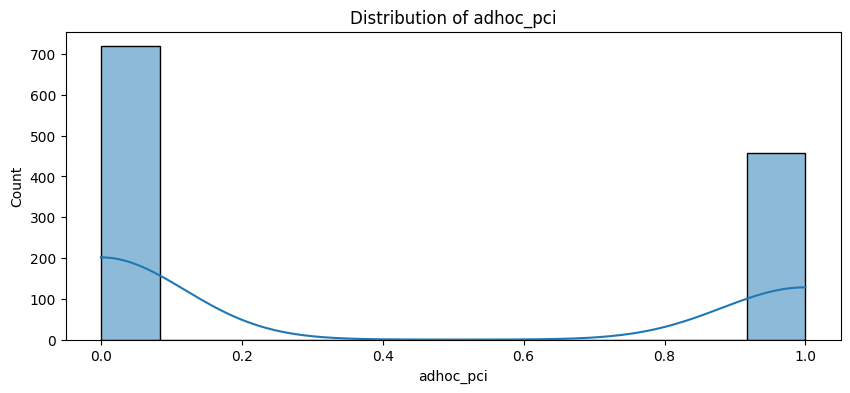

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


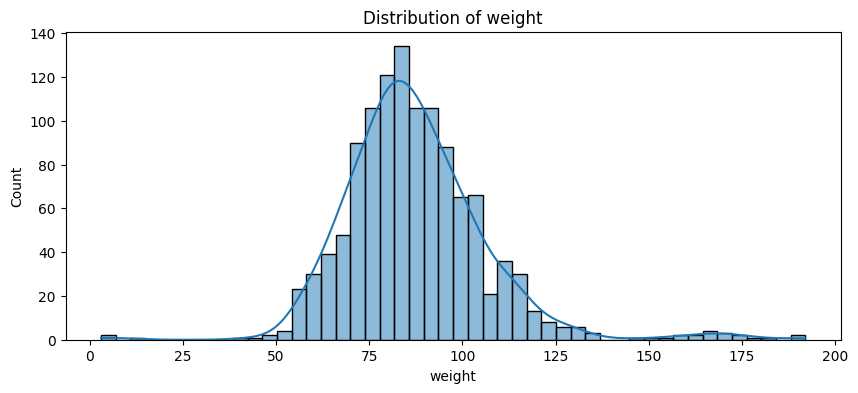

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


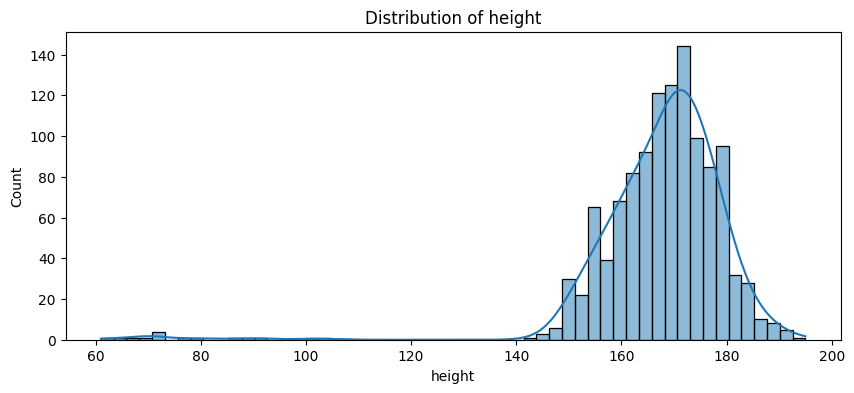

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


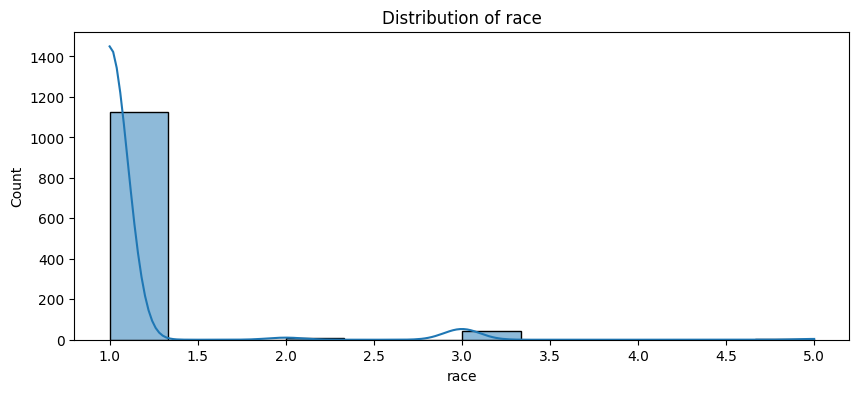

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


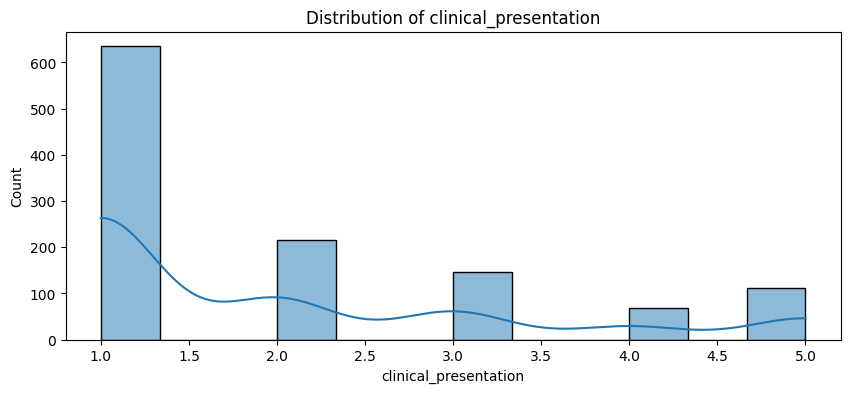

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


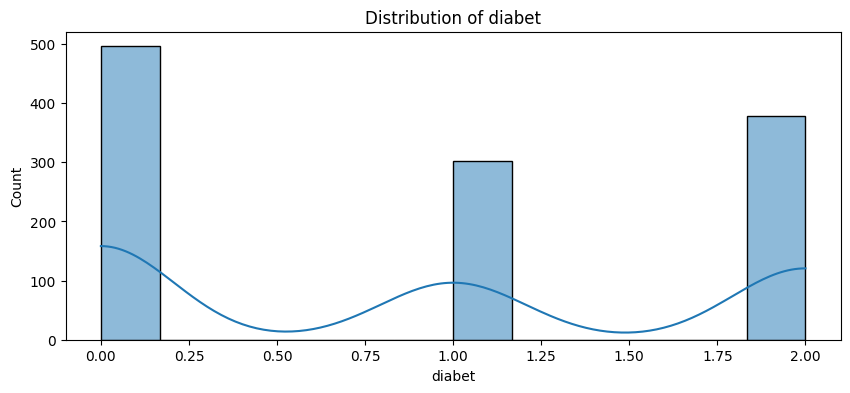

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


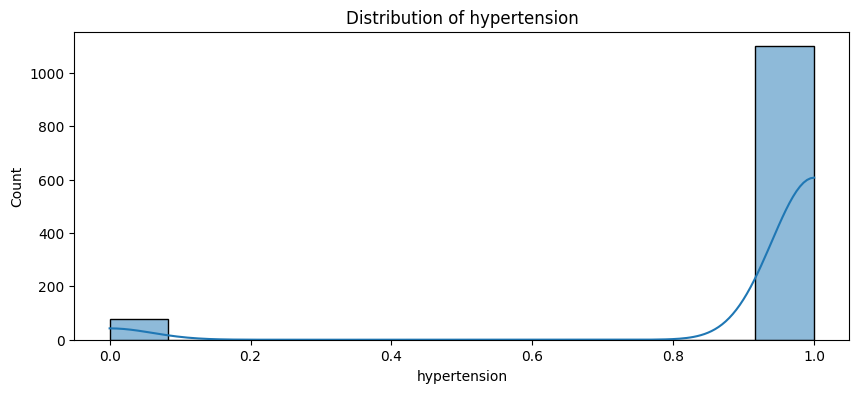

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


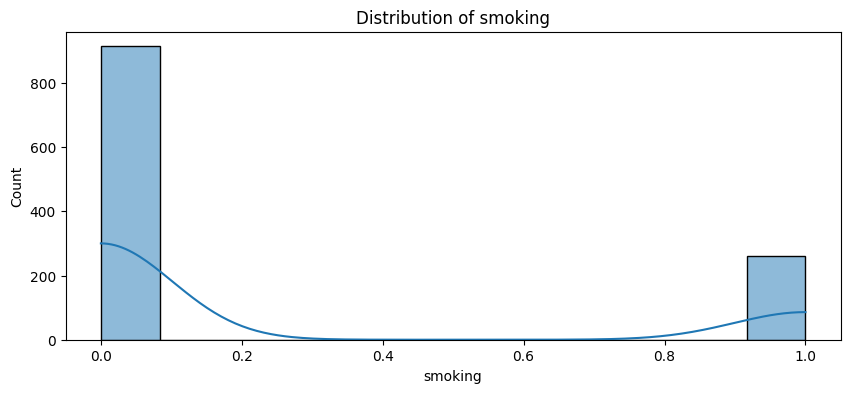

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


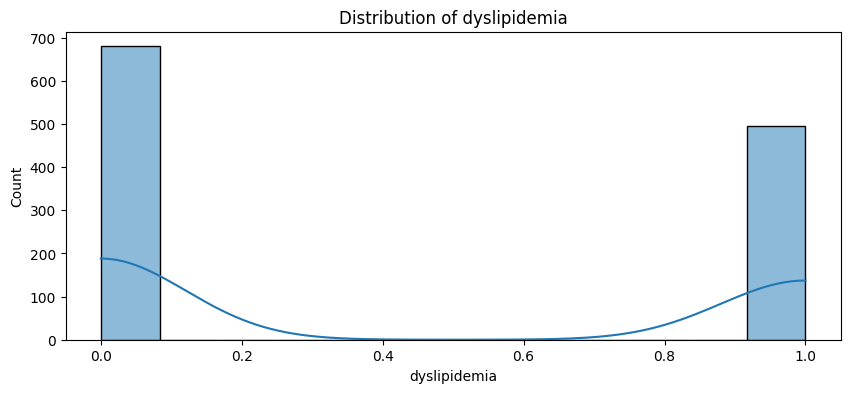

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


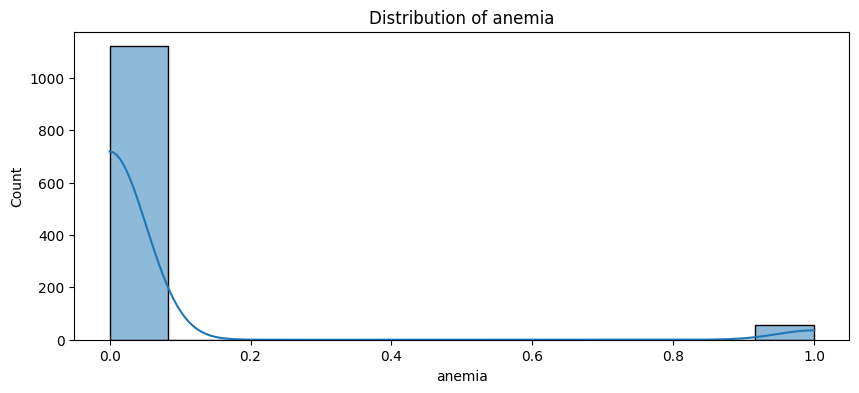

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


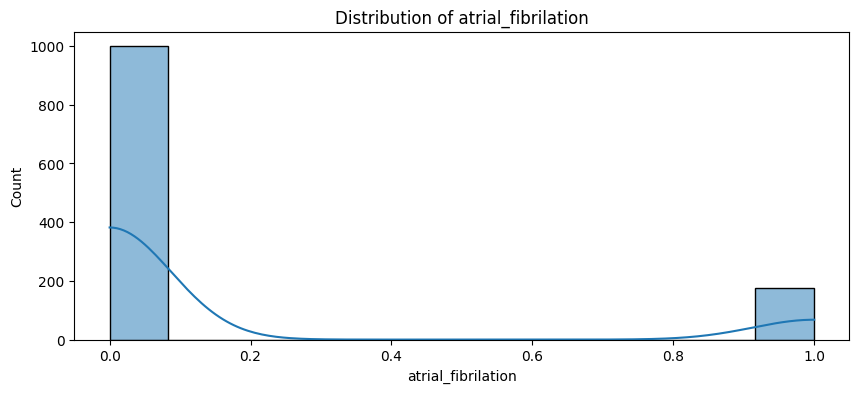

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


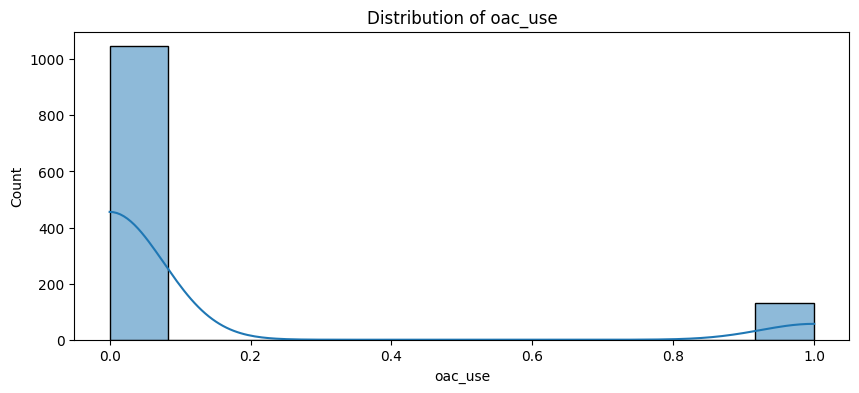

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


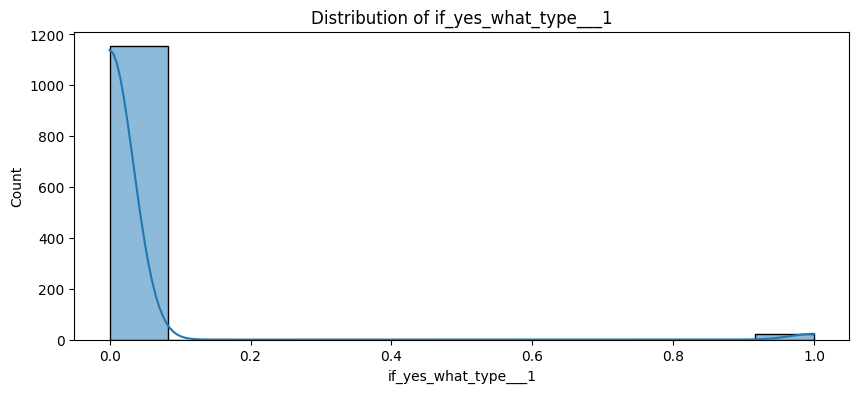

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


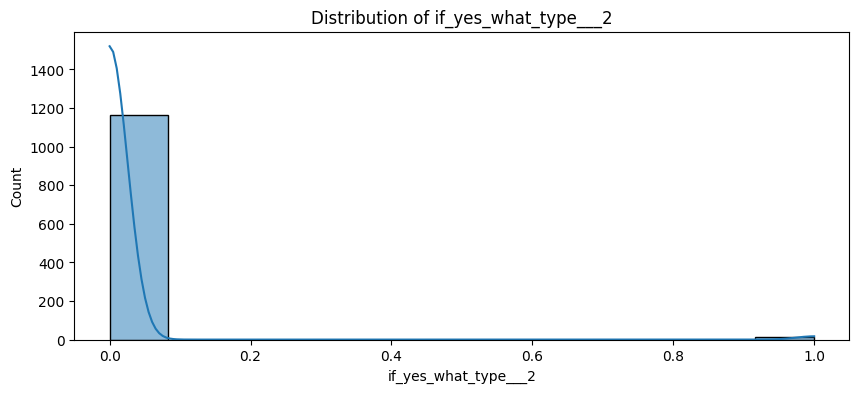

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


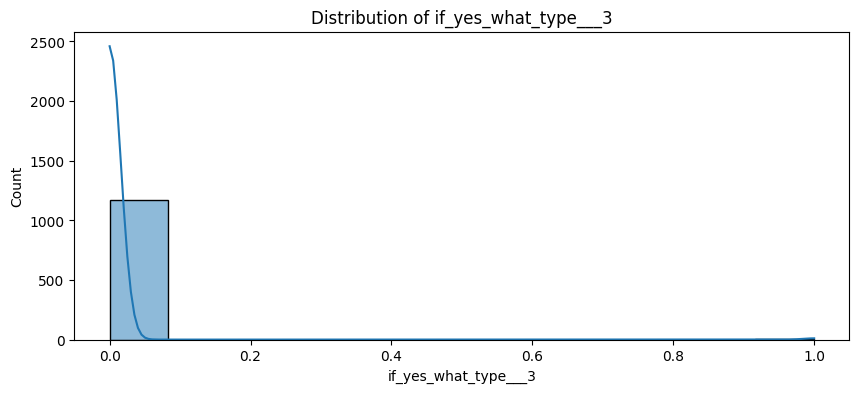

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


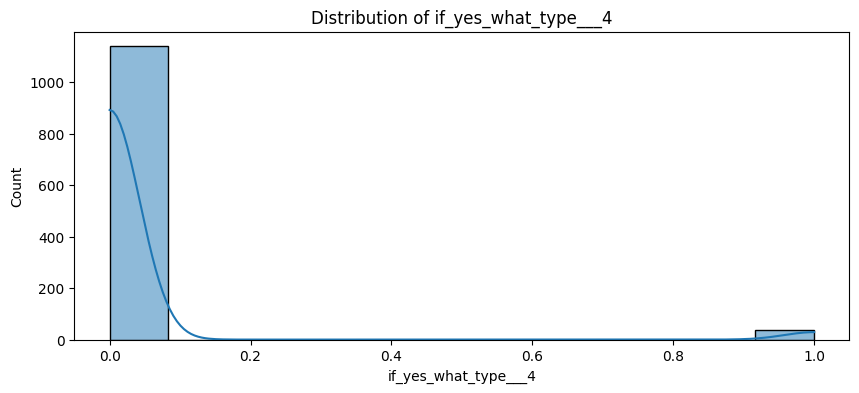

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


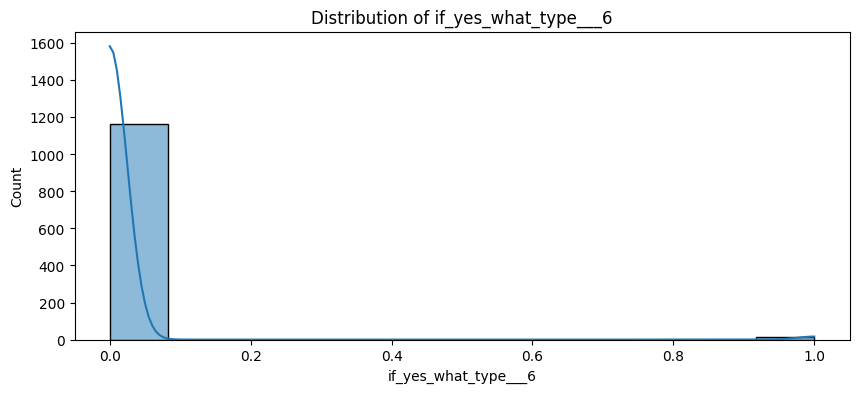

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


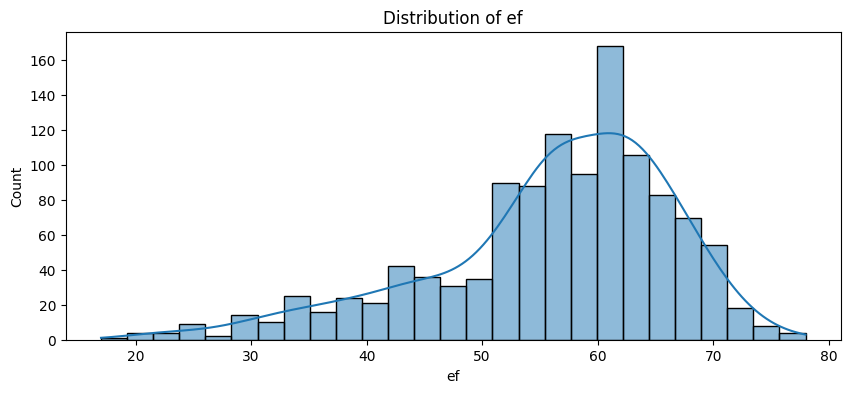

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


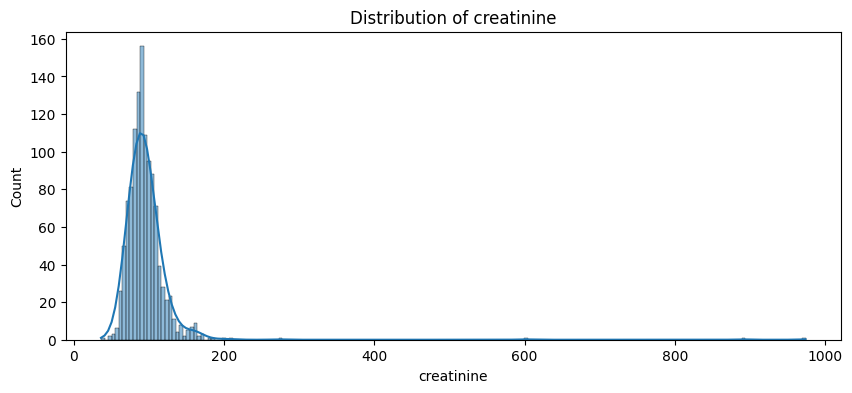

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


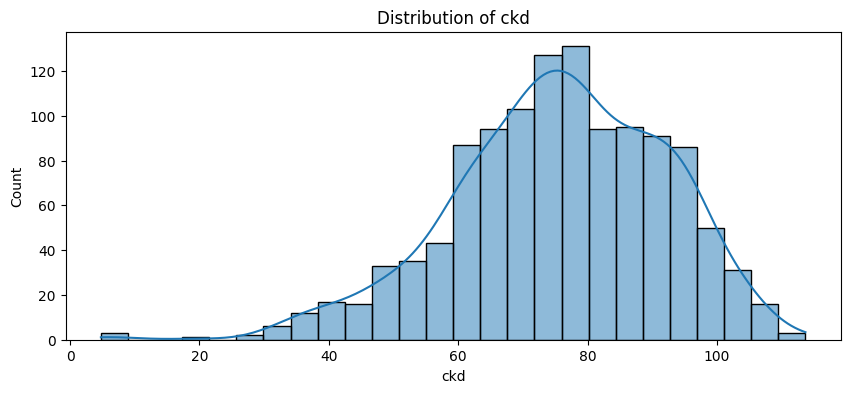

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


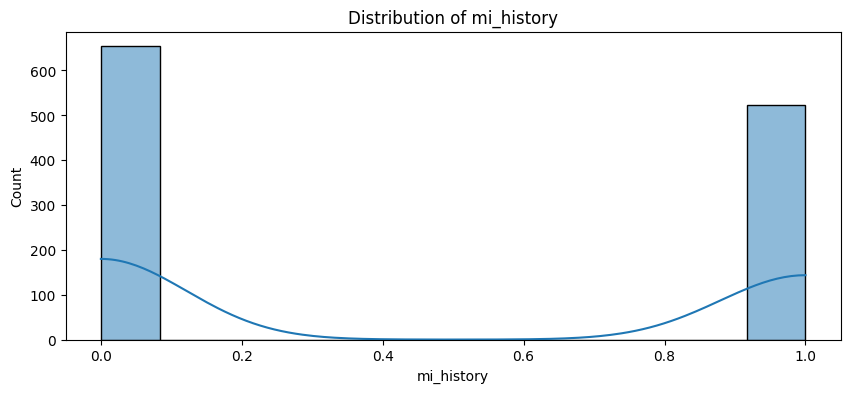

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


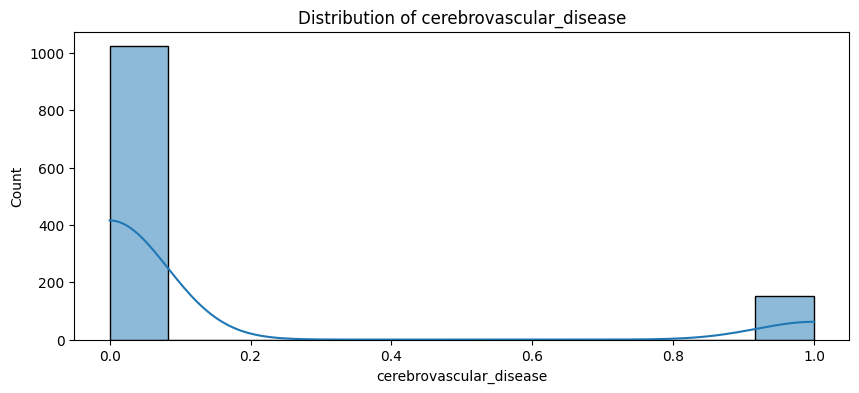

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


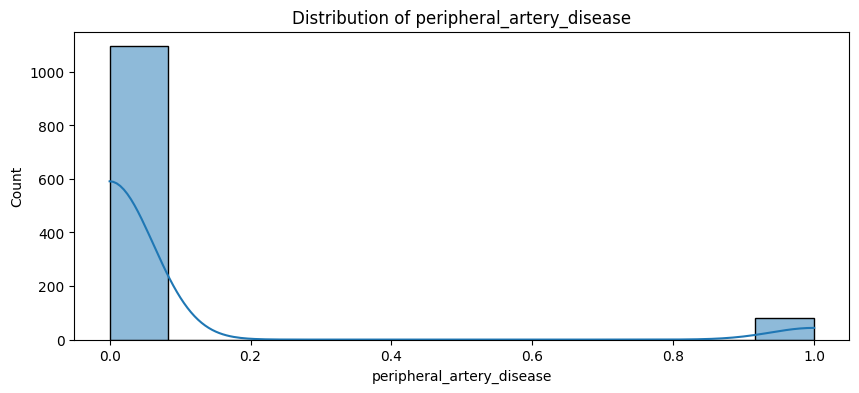

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


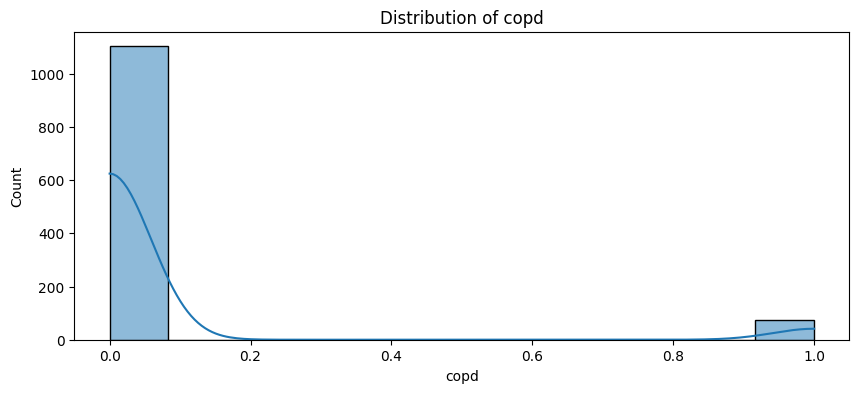

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


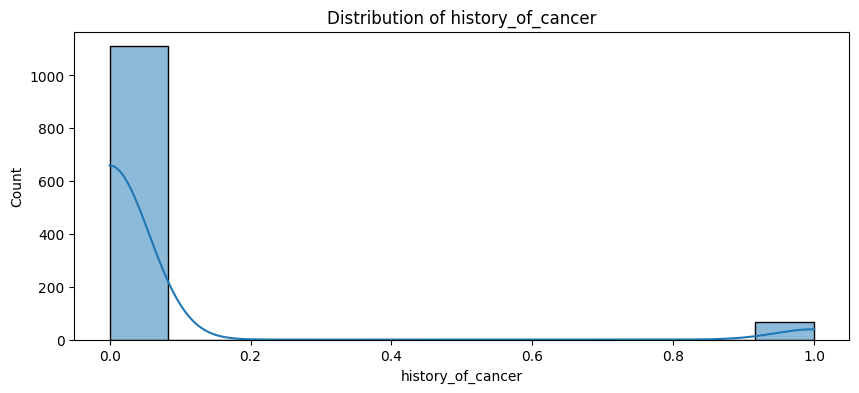

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


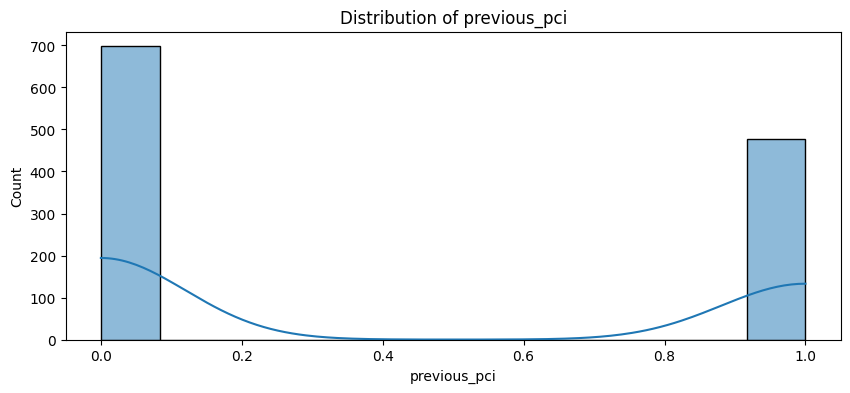

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


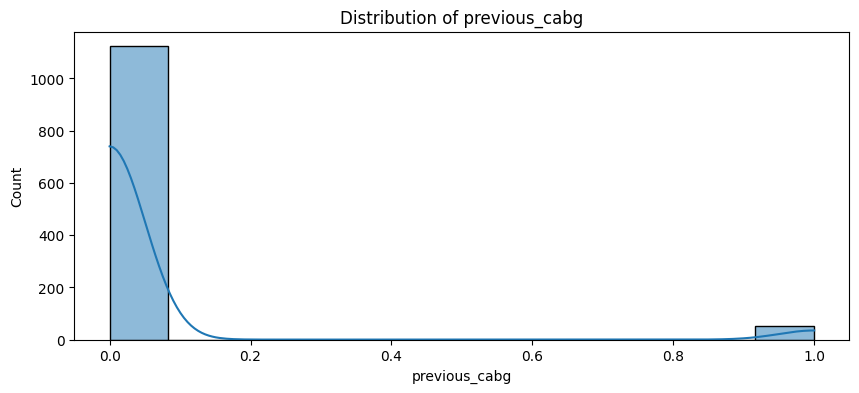

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


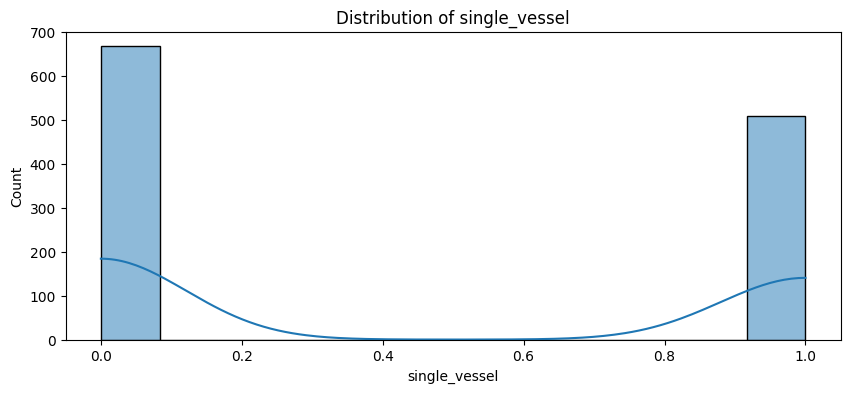

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


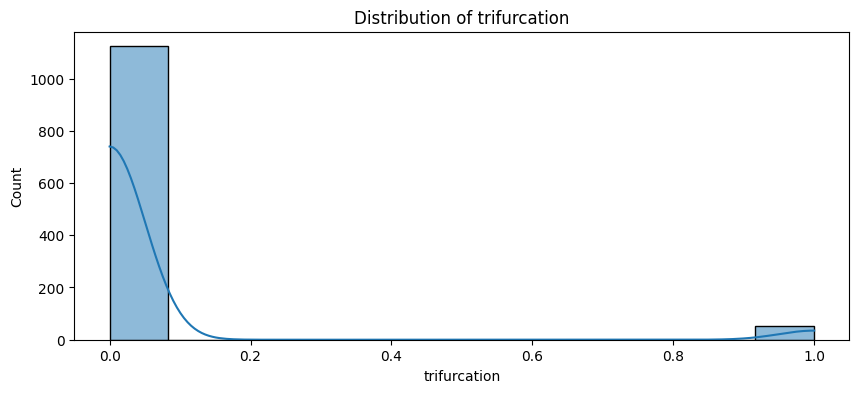

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


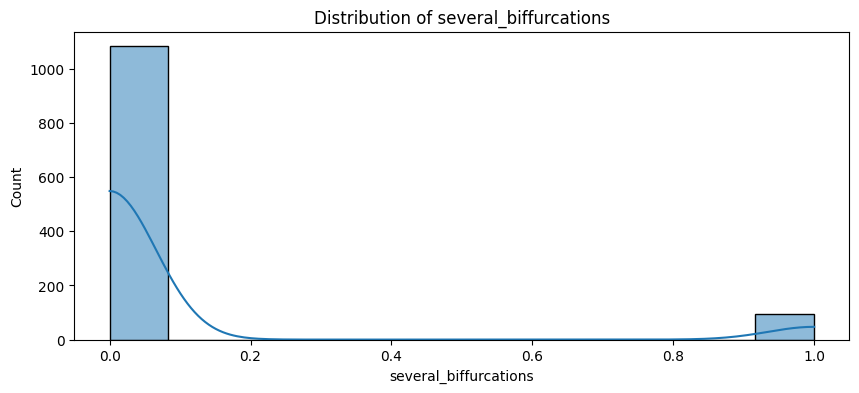

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


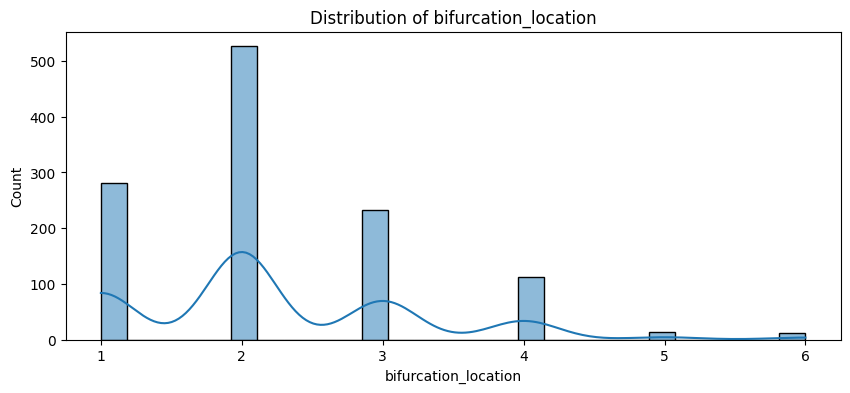

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


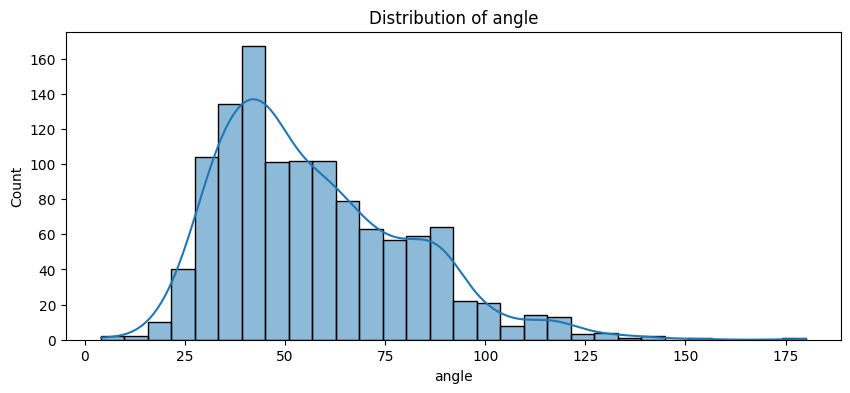

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


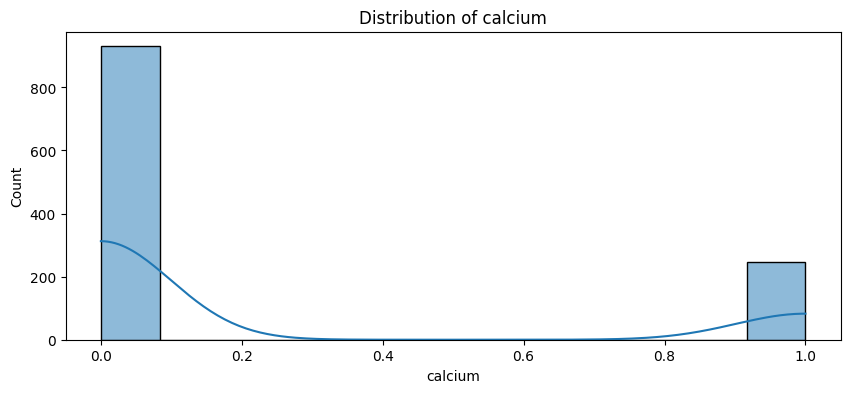

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


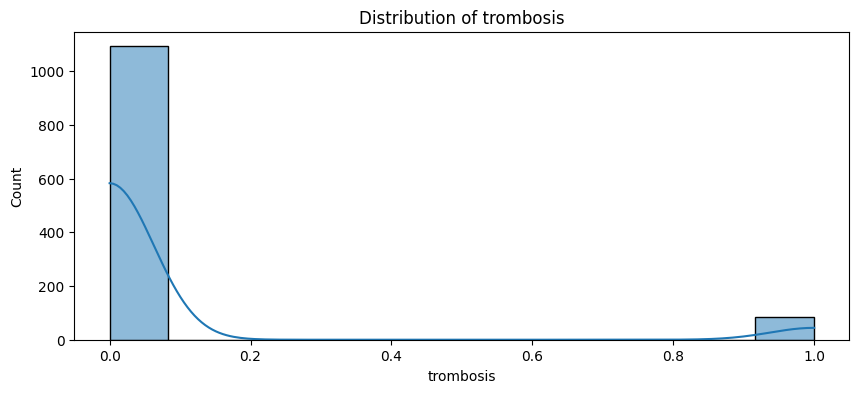

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


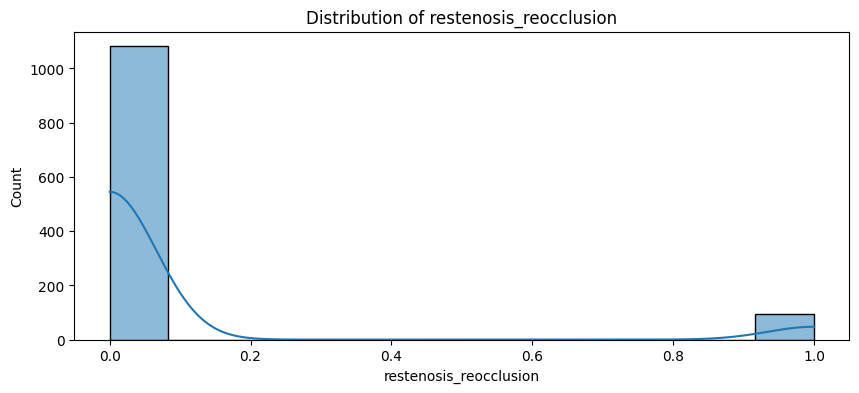

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


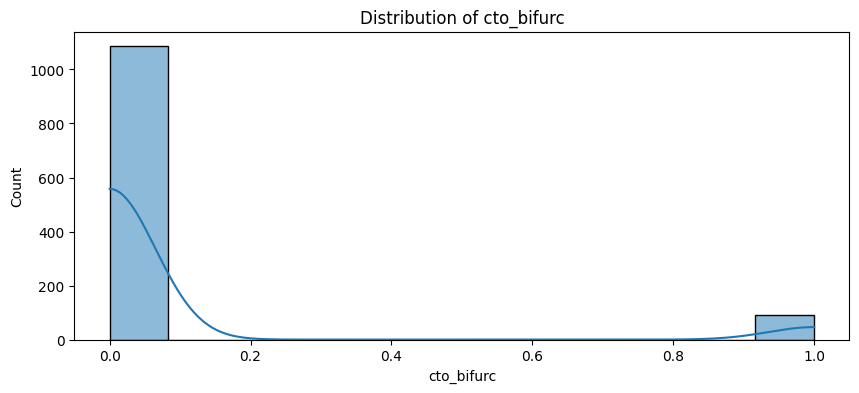

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


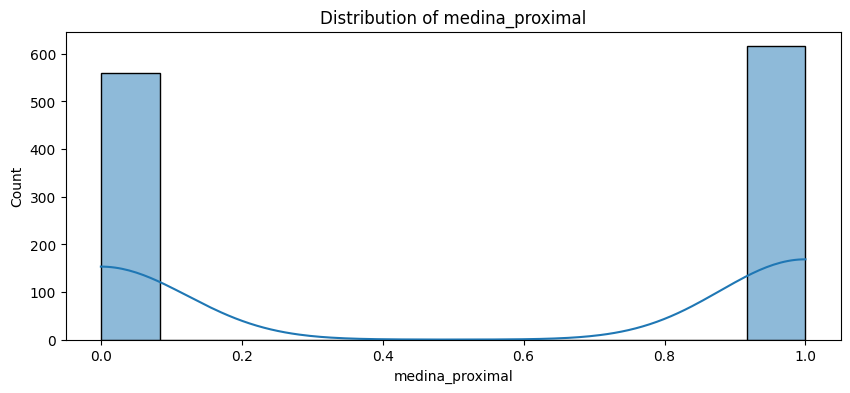

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


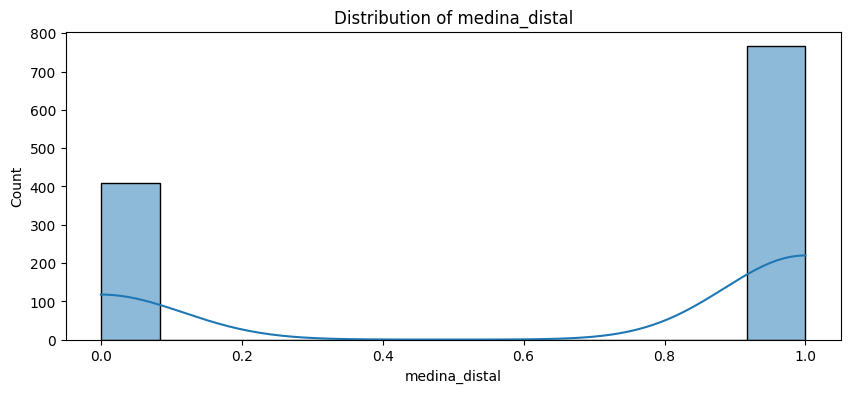

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


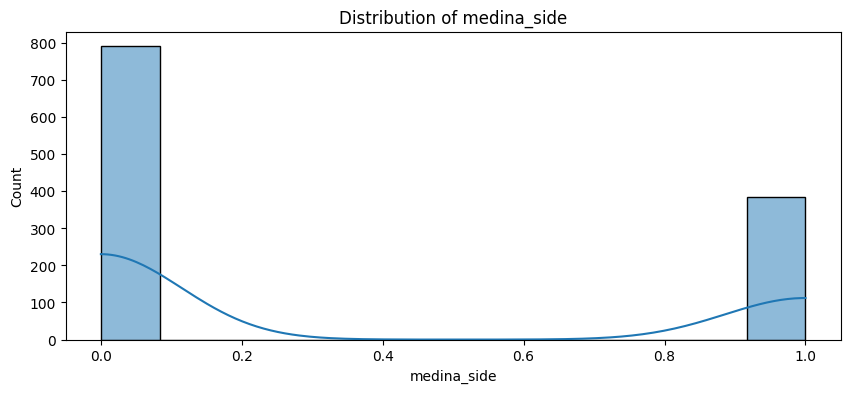

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


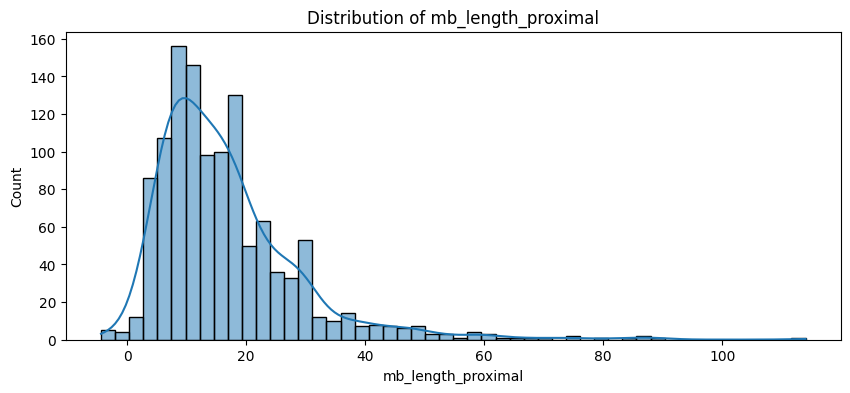

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


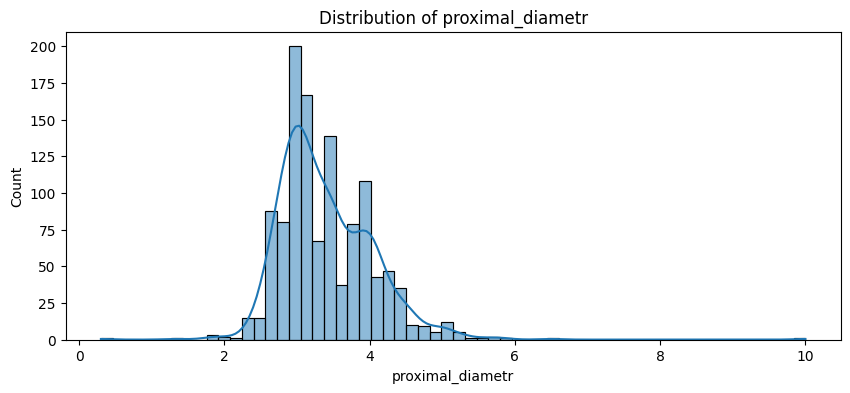

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


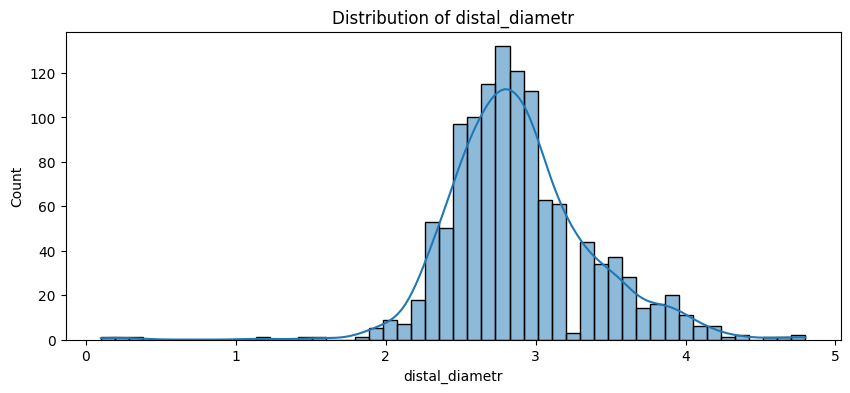

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


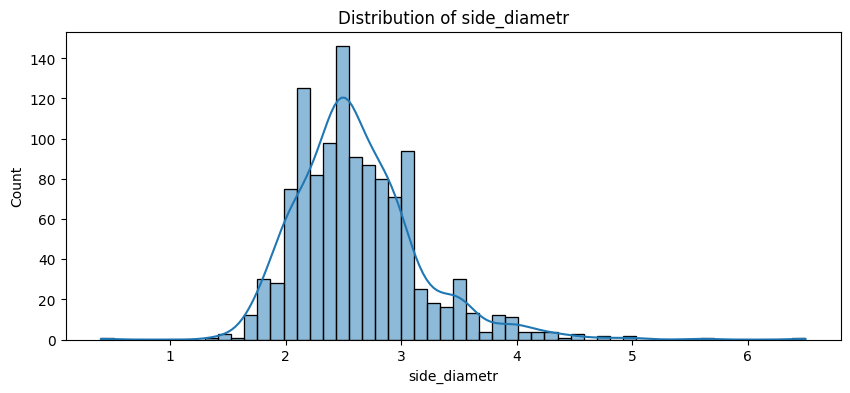

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


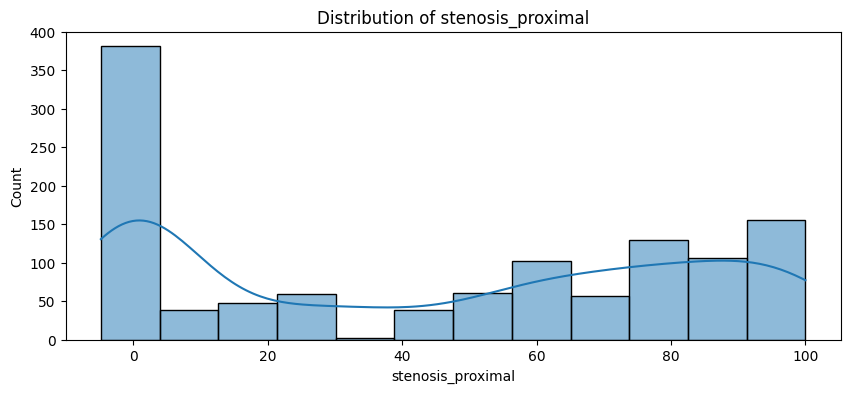

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


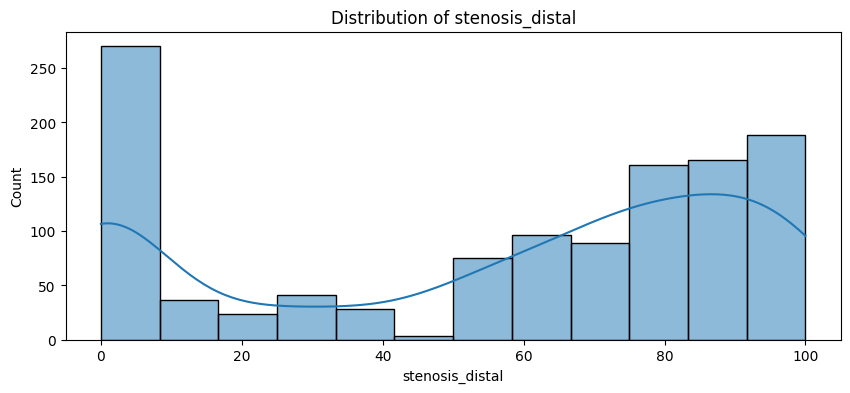

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


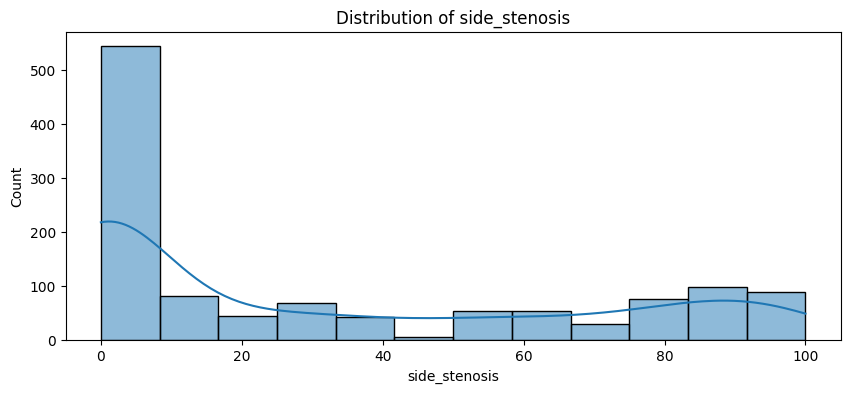

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


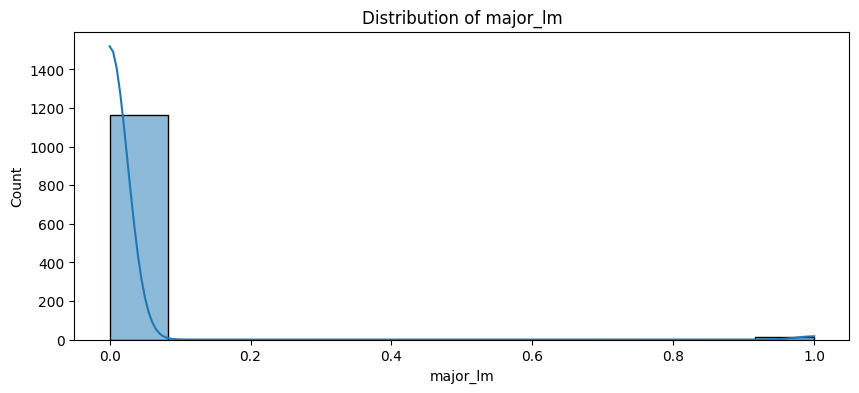

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


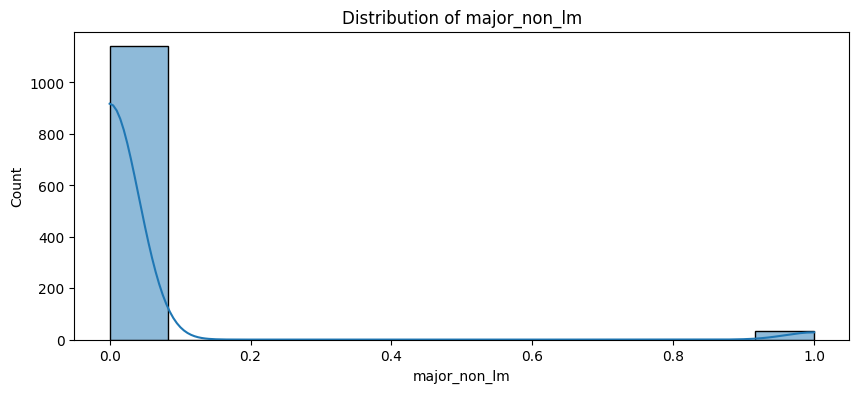

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


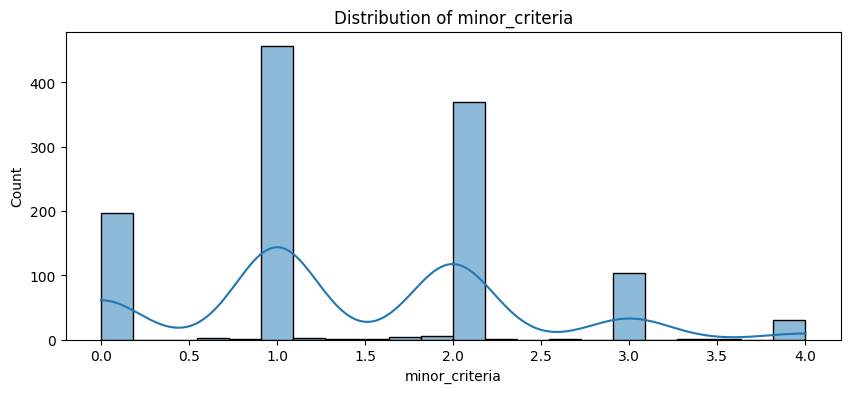

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


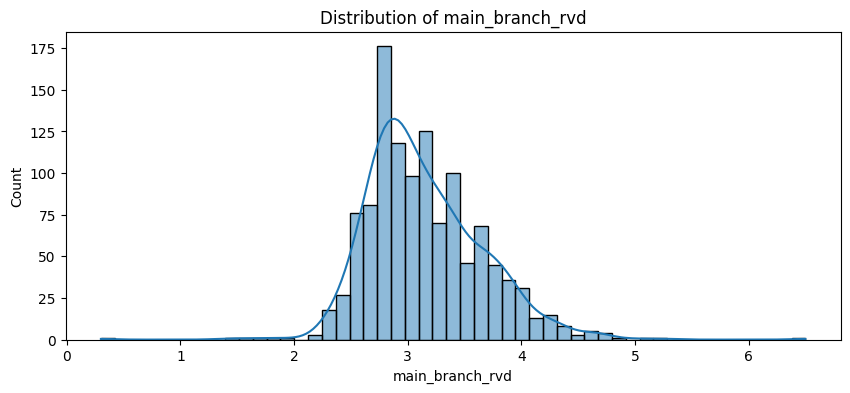

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


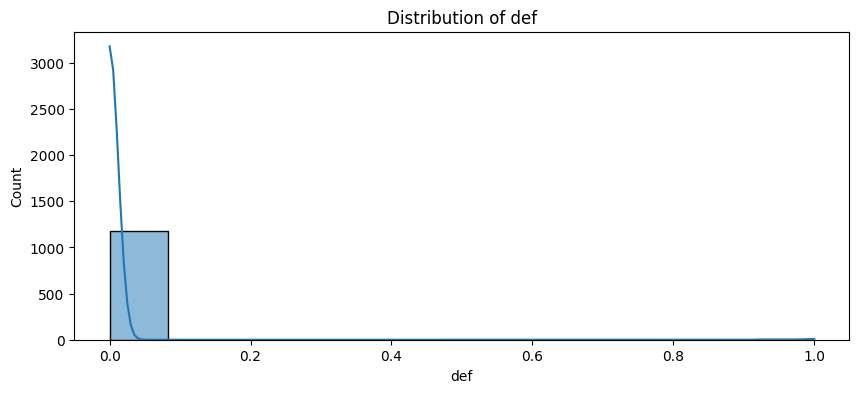

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


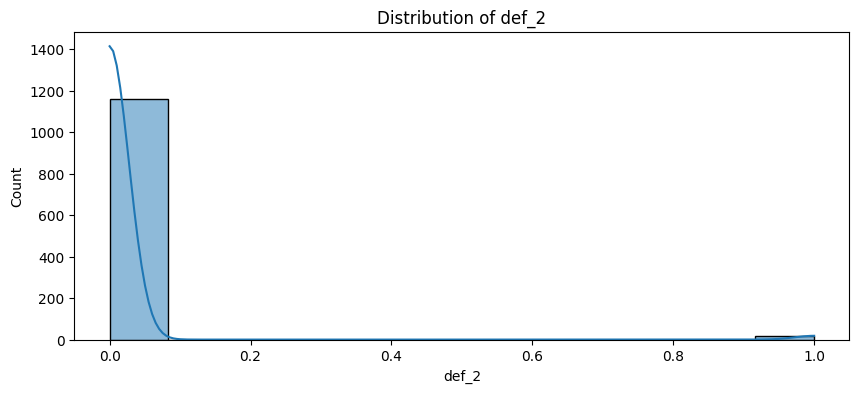

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


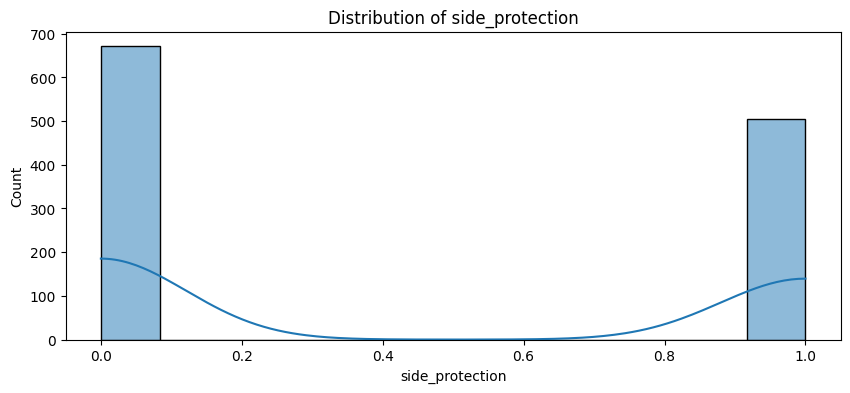

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


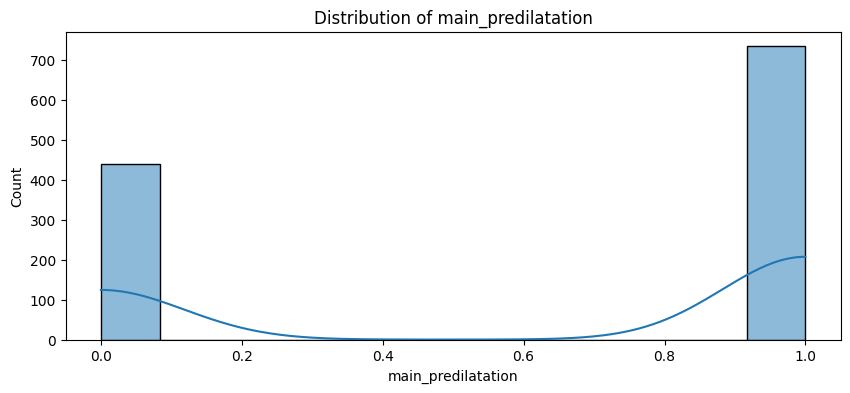

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


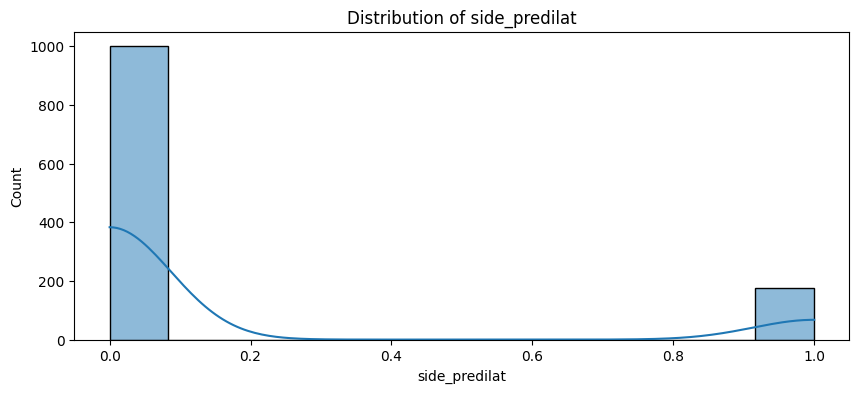

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


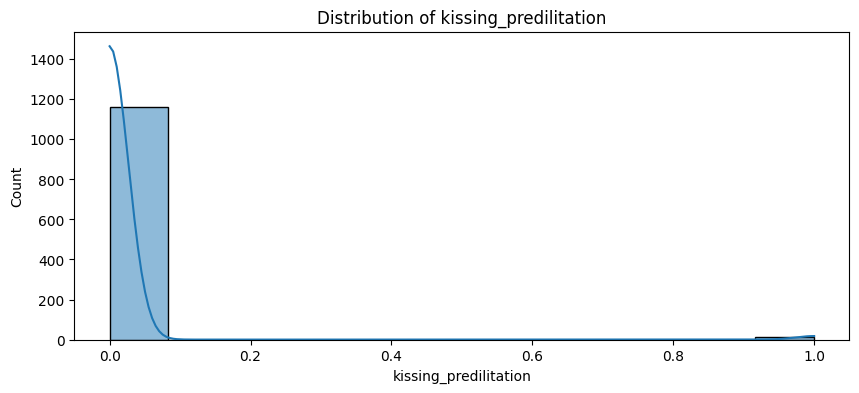

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


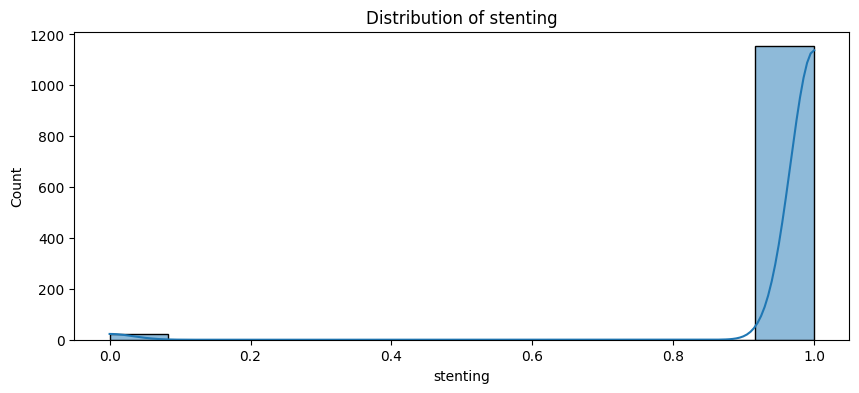

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


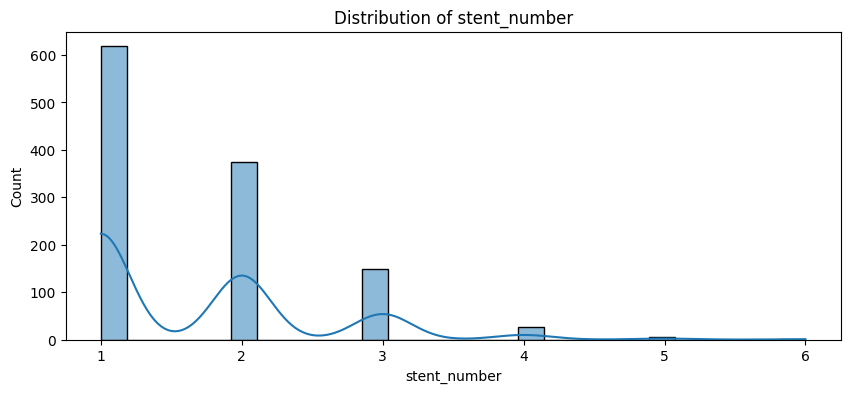

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


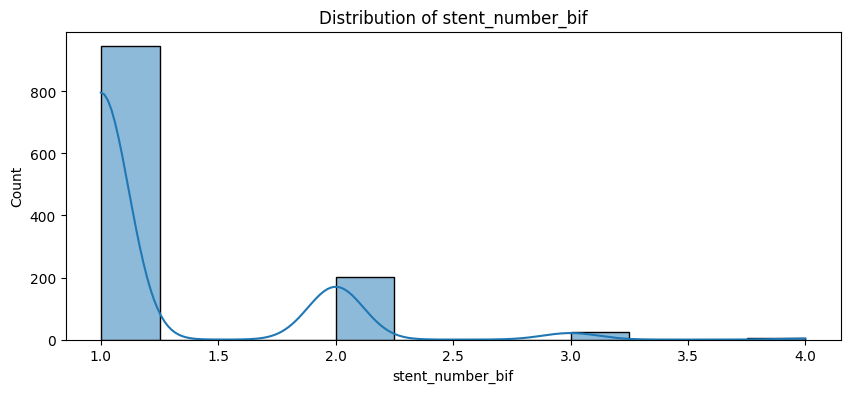

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


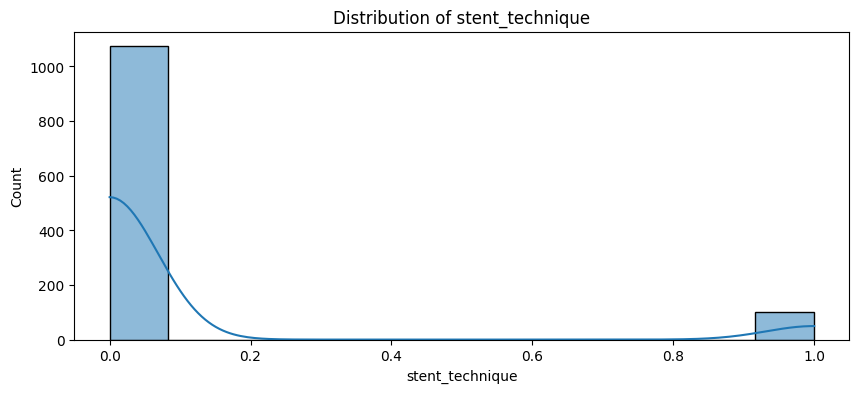

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


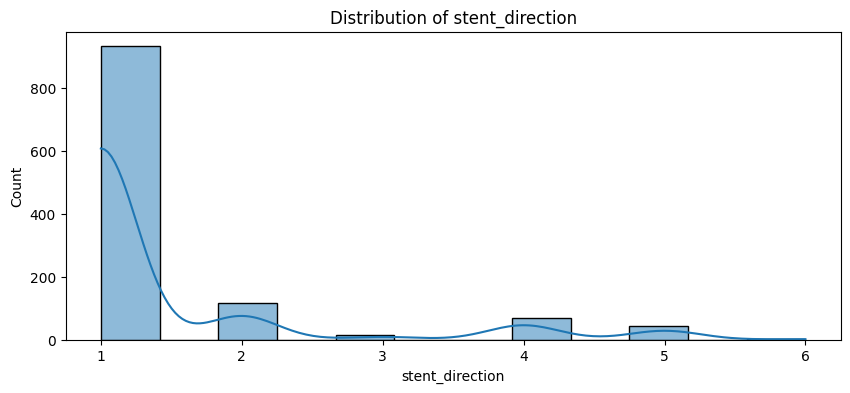

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


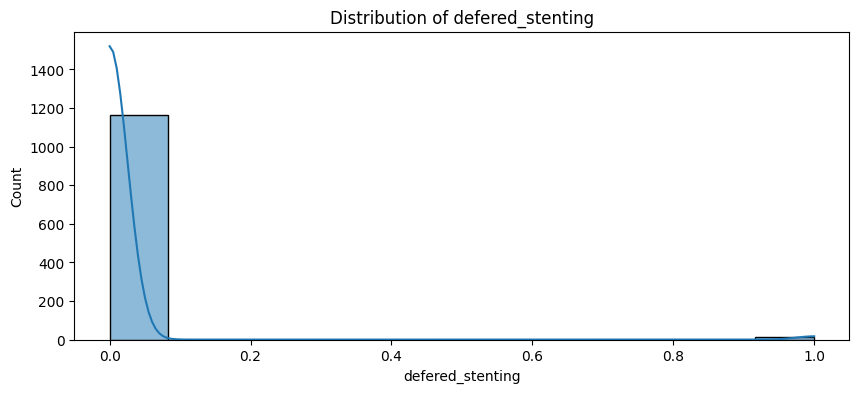

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


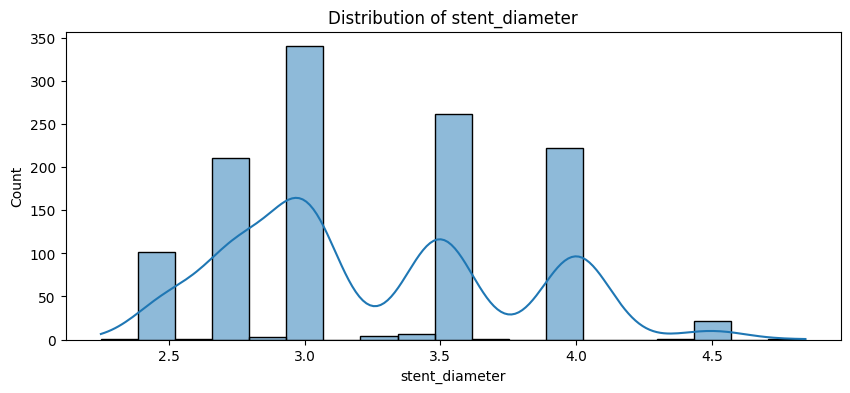

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


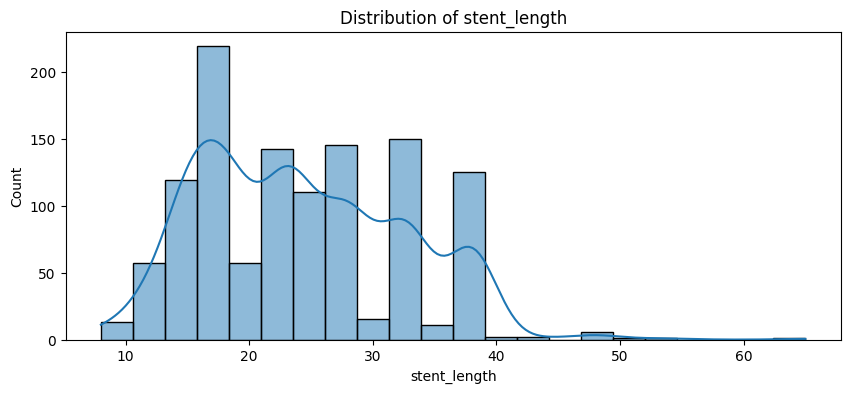

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


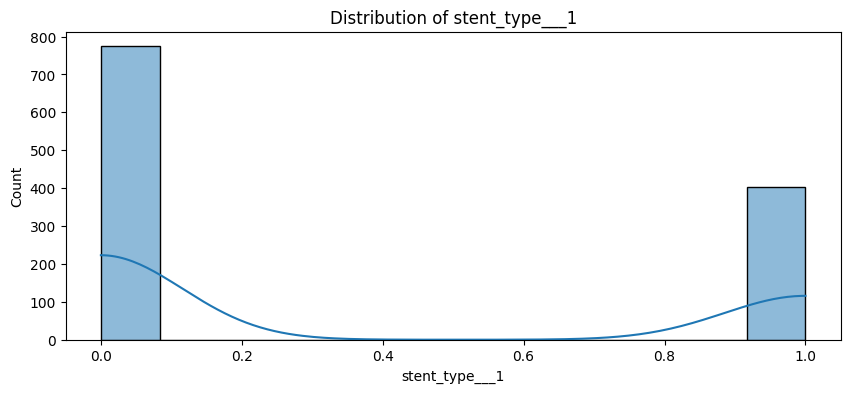

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


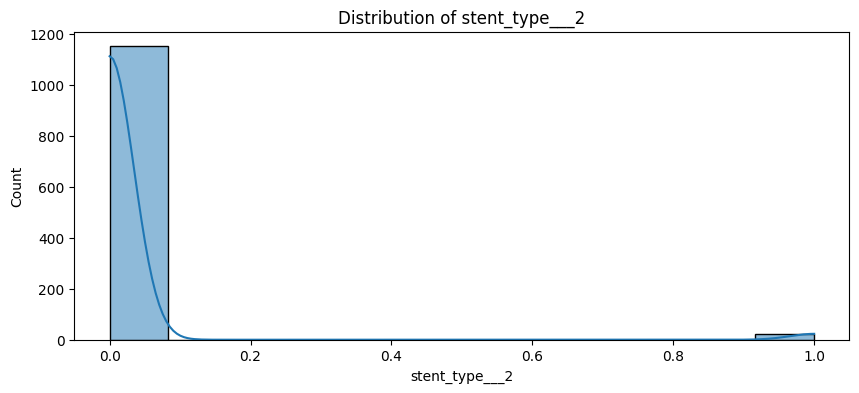

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


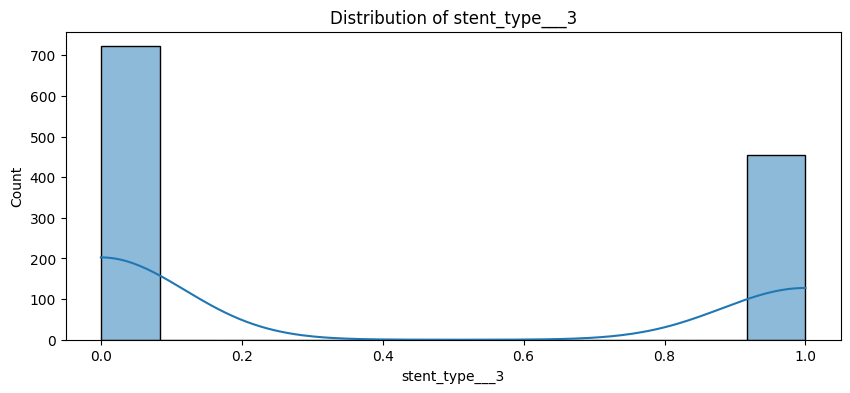

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


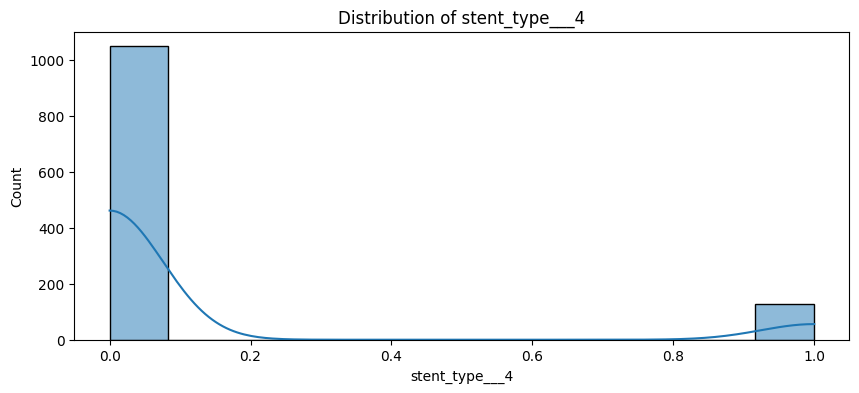

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


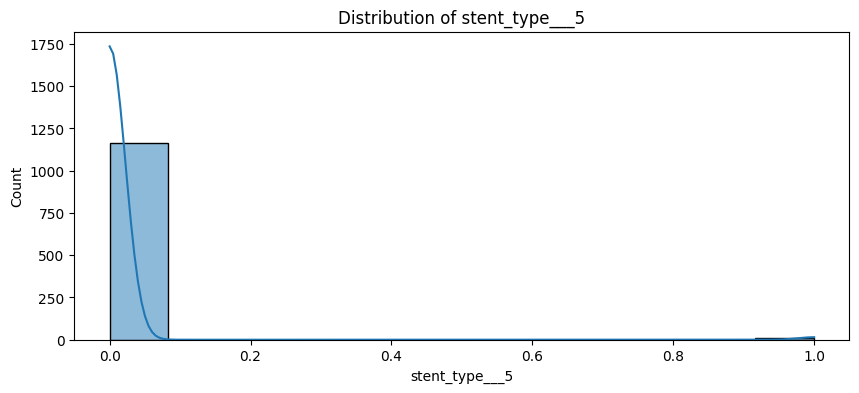

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


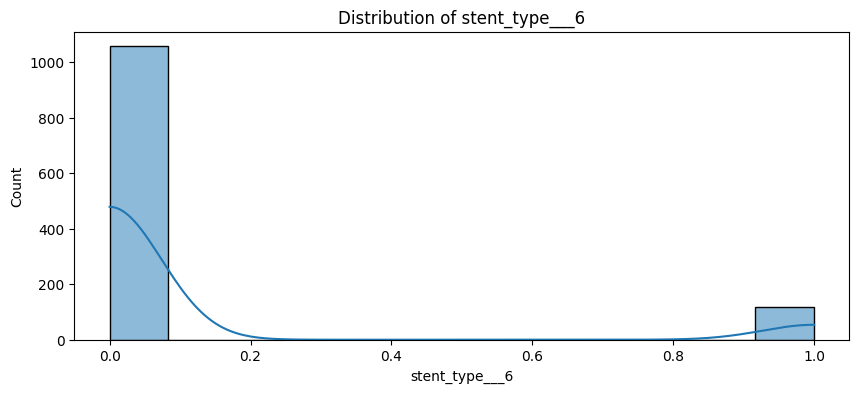

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


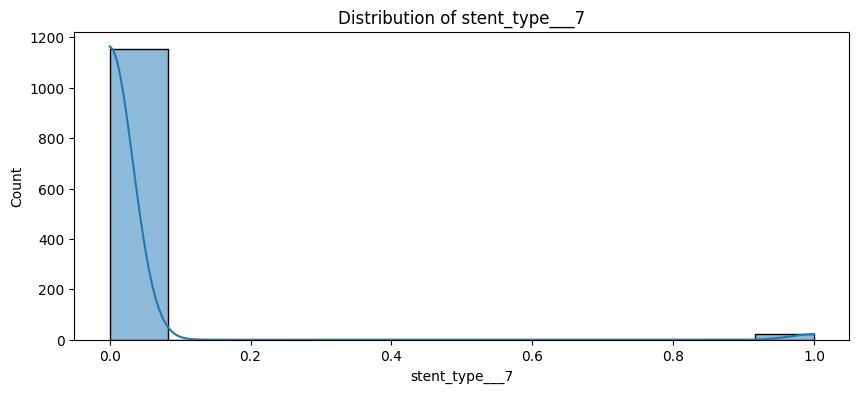

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


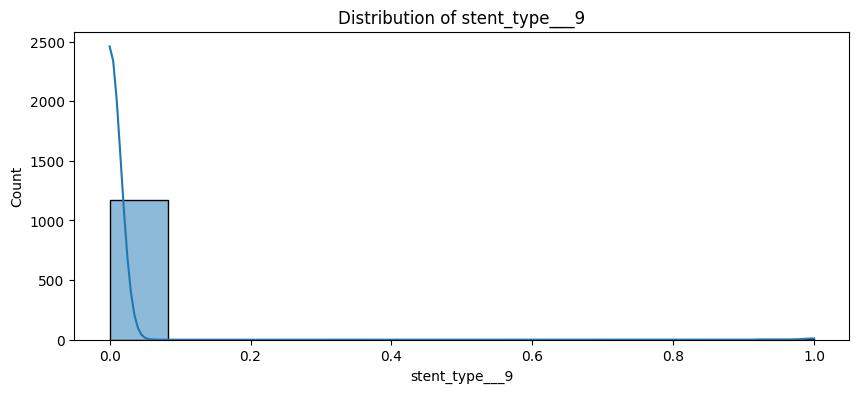

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


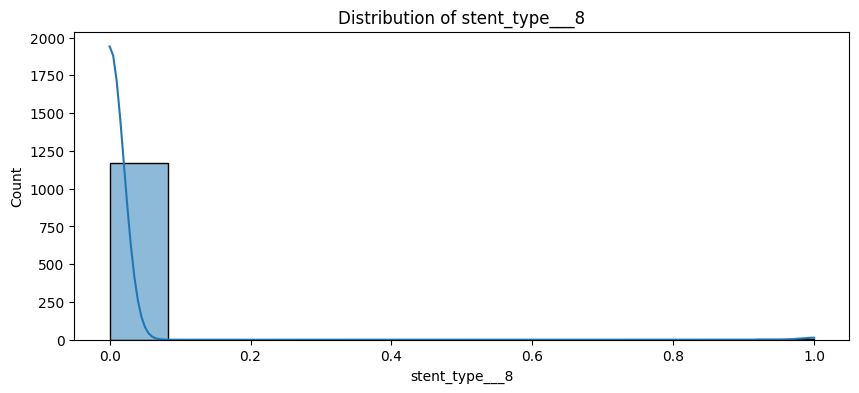

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


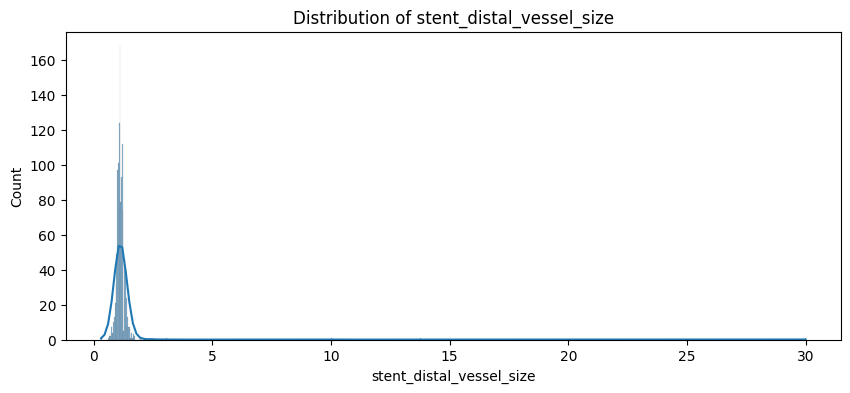

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


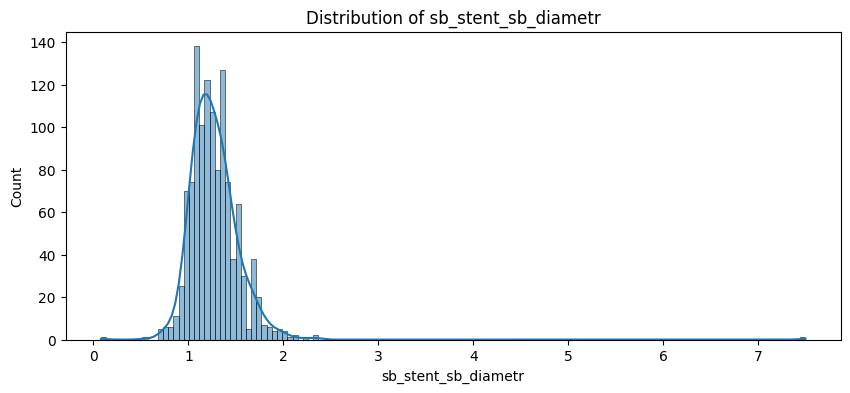

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


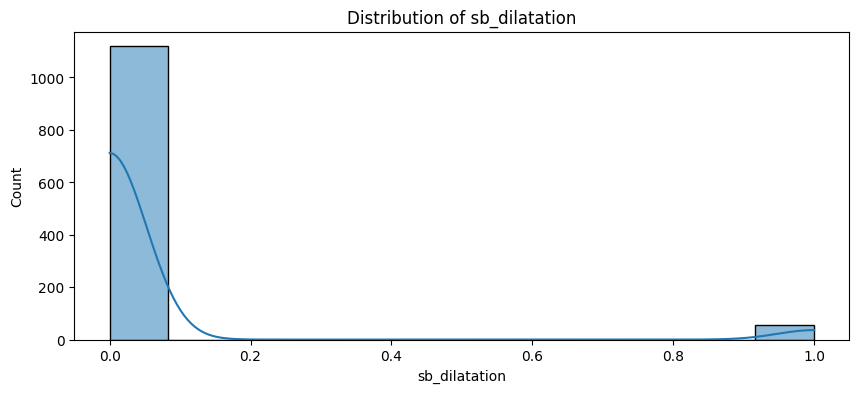

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


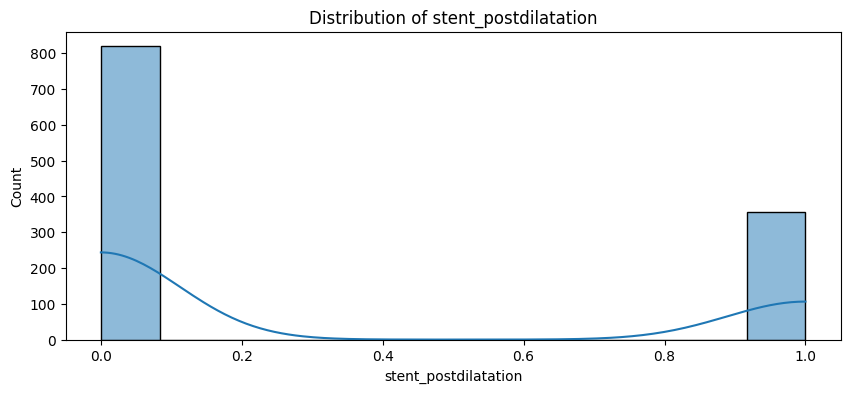

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


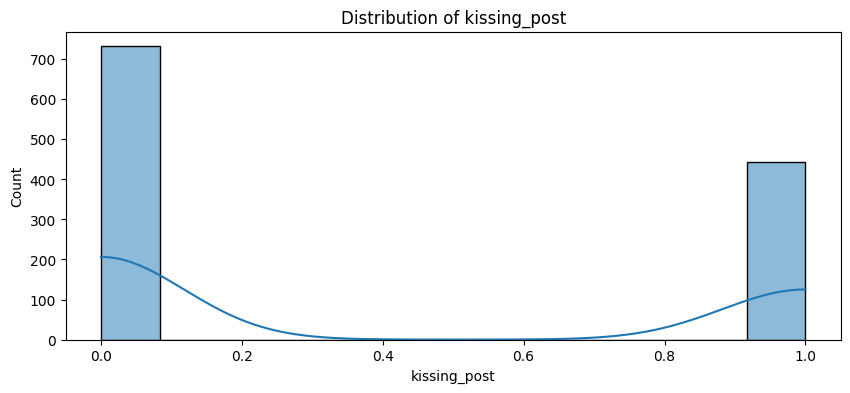

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


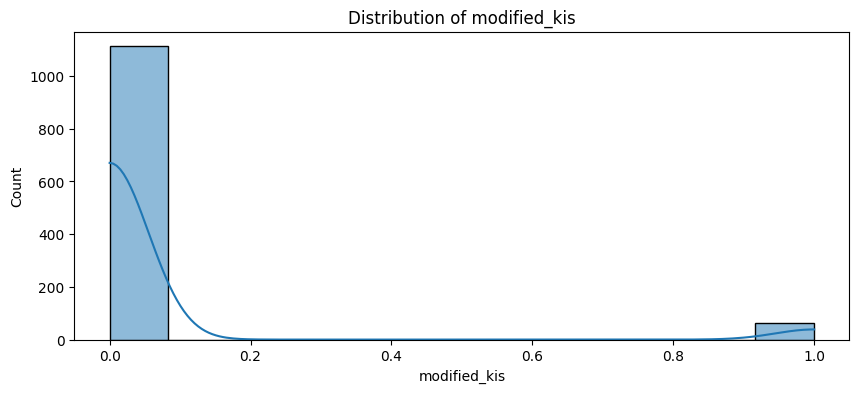

In [24]:
import seaborn as sns

for column in X_train.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(X_train[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

In [25]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
df_for_ohe = pd.concat([X_train[cathegorical], X_test[cathegorical], X_val[cathegorical]], ignore_index=True)
ohe.fit(df_for_ohe)

OneHotEncoder(sparse_output=False)

In [26]:
def process_ohe(dataframe, cat_cols, encoder):
    encoded_columns = pd.DataFrame(encoder.transform(dataframe[cat_cols]))

    encoded_columns.columns = encoder.get_feature_names_out(cat_cols)

    dataframe = pd.concat([dataframe, encoded_columns], axis=1)

    dataframe.drop(cat_cols, axis=1, inplace=True)

    return dataframe

In [27]:
X_train = process_ohe(X_train, cathegorical, ohe)
X_test = process_ohe(X_test, cathegorical, ohe)
X_val = process_ohe(X_val, cathegorical, ohe)
X_train

age  adhoc_pci      weight      height  diabet  hypertension  smoking  \
0     68.0        0.0   76.000000  154.000000     2.0           1.0      0.0   
1     67.0        0.0   80.000000  167.000000     0.0           1.0      0.0   
2     52.0        1.0  100.000000  170.000000     2.0           1.0      0.0   
3     75.0        0.0   87.000000  179.000000     2.0           1.0      0.0   
4     65.0        1.0   86.614613  159.897683     1.0           1.0      0.0   
...    ...        ...         ...         ...     ...           ...      ...   
1171  57.0        0.0   90.000000  167.000000     1.0           1.0      0.0   
1172  59.0        1.0   75.000000  168.000000     0.0           1.0      1.0   
1173  69.0        0.0   66.000000  170.000000     0.0           1.0      1.0   
1174  57.0        0.0   93.000000  185.000000     2.0           1.0      0.0   
1175  61.0        0.0   63.000000  158.000000     1.0           1.0      0.0   

      dyslipidemia  anemia  atrial_fibrilation  ...  stent_number_bif_3.0  \
0              0.0     0.0                 0.0  ...                   0.0   
1              1.0     0.0                 0.0  ...                   0.0   
2              0.0     0.0                 0.0  ...                   0.0   
3              1.0     0.0                 0.0  ...                   0.0   
4              0.0     0.0                 0.0  ...                   0.0   
...            ...     ...                 ...  ...                   ...   
1171           0.0     0.0                 0.0  ...                   0.0   
1172           0.0     0.0                 0.0  ...                   0.0   
1173           0.0     1.0                 0.0  ...                   0.0   
1174           1.0     0.0                 0.0  ...                   0.0   
1175           1.0     1.0                 0.0  ...                   0.0   

      stent_number_bif_4.0  stent_technique_0.0  stent_technique_1.0  \
0                      0.0                  0.0                  1.0   
1                      0.0                  1.0                  0.0   
2                      0.0                  1.0                  0.0   
3                      0.0                  1.0                  0.0   
4                      0.0                  1.0                  0.0   
...                    ...                  ...                  ...   
1171                   0.0                  1.0                  0.0   
1172                   0.0                  1.0                  0.0   
1173                   0.0                  1.0                  0.0   
1174                   0.0                  1.0                  0.0   
1175                   0.0                  1.0                  0.0   

      stent_direction_1.0  stent_direction_2.0  stent_direction_3.0  \
0                     1.0                  0.0                  0.0   
1                     1.0                  0.0                  0.0   
2                     0.0                  0.0                  0.0   
3                     1.0                  0.0                  0.0   
4                     0.0                  0.0                  0.0   
...                   ...                  ...                  ...   
1171                  1.0                  0.0                  0.0   
1172                  1.0                  0.0                  0.0   
1173                  1.0                  0.0                  0.0   
1174                  1.0                  0.0                  0.0   
1175                  1.0                  0.0                  0.0   

      stent_direction_4.0  stent_direction_5.0  stent_direction_6.0  
0                     0.0                  0.0                  0.0  
1                     0.0                  0.0                  0.0  
2                     1.0                  0.0                  0.0  
3                     0.0                  0.0                  0.0  
4                     0.0                  1.0       

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

feature_selector = SelectKBest(f_classif, k=40)
X_feature_selection = feature_selector.fit_transform(X_train, y_train)
X_feature_selection.shape

strong_cols = []

feature_scores = feature_selector.scores_
features = X_train.columns
features_scores_sorted = sorted(zip(features, feature_scores), key=lambda x: x[1], reverse=True)
for col in features_scores_sorted[:30]:
    strong_cols.append(col[0])

In [29]:
X_train = X_train[strong_cols]
X_test = X_test[strong_cols]
X_val = X_val[strong_cols]
X_train

anemia  cerebrovascular_disease    ef   age  peripheral_artery_disease  \
0        0.0                      0.0  62.0  68.0                        0.0   
1        0.0                      0.0  63.0  67.0                        0.0   
2        0.0                      0.0  35.0  52.0                        0.0   
3        0.0                      0.0  55.0  75.0                        0.0   
4        0.0                      0.0  48.0  65.0                        0.0   
...      ...                      ...   ...   ...                        ...   
1171     0.0                      0.0  58.0  57.0                        0.0   
1172     0.0                      0.0  38.0  59.0                        0.0   
1173     1.0                      0.0  65.0  69.0                        1.0   
1174     0.0                      0.0  68.0  57.0                        0.0   
1175     1.0                      0.0  43.0  61.0                        0.0   

      single_vessel        ckd  copd  creatinine  stent_type___5  ...  \
0               0.0  70.982905   0.0        96.0             0.0  ...   
1               1.0  69.345077   0.0        97.0             0.0  ...   
2               0.0  66.916820   0.0       109.0             0.0  ...   
3               1.0  33.745645   0.0       168.0             0.0  ...   
4               1.0  65.051015   0.0       105.0             0.0  ...   
...             ...        ...   ...         ...             ...  ...   
1171            0.0  77.315887   0.0       106.0             0.0  ...   
1172            0.0  73.353636   0.0        97.0             0.0  ...   
1173            0.0  90.590030   0.0        70.0             0.0  ...   
1174            0.0  66.070134   0.0       107.0             0.0  ...   
1175            0.0  72.330279   0.0        97.0             0.0  ...   

      bifurcation_location_2.0  trifurcation  stent_number_1.0  \
0                          0.0           0.0               0.0   
1                          1.0           0.0               1.0   
2                          0.0           0.0               0.0   
3                          1.0           0.0               1.0   
4                          0.0           0.0               1.0   
...                        ...           ...               ...   
1171                       0.0           0.0               1.0   
1172                       1.0           0.0               1.0   
1173                       1.0           0.0               0.0   
1174                       0.0           0.0               0.0   
1175                       1.0           0.0               0.0   

      main_predilatation  stent_type___3  side_predilat  medina_side  \
0                    0.0             0.0            1.0          1.0   
1                    1.0             0.0            0.0          0.0   
2                    0.0             1.0            0.0          0.0   
3                    1.0             0.0            0.0          0.0   
4                    0.0             0.0            1.0          1.0   
...                  ...             ...            ...          ...   
1171                 0.0             1.0            0.0          0.0   
1172                 0.0             1.0            0.0          0.0   
1173                 0.0             1.0            1.0          0.0   
1174                 1.0             1.0            0.0          0.0   
1175                 1.0             0.0            0.0          1.0   

      side_stenosis  distal_diametr  side_diametr  
0         80.000000             3.5           2.9  
1          0.000000             2.5           2.3  
2          0.000000             3.2           4.1  
3          0.000000             2.8           2.3  
4         95.000000             3.3           3.0  
...             ...             ...           ...  
1171       0.000000             3.1           3.5  
1172       8.553568             2.9           2.6  
1173      40.000000             3.0       

In [30]:
corr_matrix = X_train.corr().abs()

upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

threshold = 0.4

to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

to_drop

['creatinine',
 'minor_criteria',
 'medina_side',
 'side_stenosis',
 'side_diametr']

In [31]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
X_val = X_val.drop(columns=to_drop)

X_train

anemia  cerebrovascular_disease    ef   age  peripheral_artery_disease  \
0        0.0                      0.0  62.0  68.0                        0.0   
1        0.0                      0.0  63.0  67.0                        0.0   
2        0.0                      0.0  35.0  52.0                        0.0   
3        0.0                      0.0  55.0  75.0                        0.0   
4        0.0                      0.0  48.0  65.0                        0.0   
...      ...                      ...   ...   ...                        ...   
1171     0.0                      0.0  58.0  57.0                        0.0   
1172     0.0                      0.0  38.0  59.0                        0.0   
1173     1.0                      0.0  65.0  69.0                        1.0   
1174     0.0                      0.0  68.0  57.0                        0.0   
1175     1.0                      0.0  43.0  61.0                        0.0   

      single_vessel        ckd  copd  stent_type___5  if_yes_what_type___1  \
0               0.0  70.982905   0.0             0.0                   0.0   
1               1.0  69.345077   0.0             0.0                   0.0   
2               0.0  66.916820   0.0             0.0                   0.0   
3               1.0  33.745645   0.0             0.0                   1.0   
4               1.0  65.051015   0.0             0.0                   0.0   
...             ...        ...   ...             ...                   ...   
1171            0.0  77.315887   0.0             0.0                   0.0   
1172            0.0  73.353636   0.0             0.0                   0.0   
1173            0.0  90.590030   0.0             0.0                   0.0   
1174            0.0  66.070134   0.0             0.0                   0.0   
1175            0.0  72.330279   0.0             0.0                   0.0   

      ...  clinical_presentation_2.0  def  sb_dilatation  \
0     ...                        0.0  1.0            0.0   
1     ...                        0.0  0.0            0.0   
2     ...                        0.0  0.0            0.0   
3     ...                        0.0  0.0            0.0   
4     ...                        0.0  0.0            0.0   
...   ...                        ...  ...            ...   
1171  ...                        0.0  0.0            0.0   
1172  ...                        0.0  0.0            0.0   
1173  ...                        0.0  0.0            0.0   
1174  ...                        1.0  0.0            0.0   
1175  ...                        0.0  0.0            0.0   

      bifurcation_location_2.0  trifurcation  stent_number_1.0  \
0                          0.0           0.0               0.0   
1                          1.0           0.0               1.0   
2                          0.0           0.0               0.0   
3                          1.0           0.0               1.0   
4                          0.0           0.0               1.0   
...                        ...           ...               ...   
1171                       0.0           0.0               1.0   
1172                       1.0           0.0               1.0   
1173                       1.0           0.0               0.0   
1174                       0.0           0.0               0.0   
1175                       1.0           0.0               0.0   

      main_predilatation  stent_type___3  side_predilat  distal_diametr  
0                    0.0             0.0            1.0             3.5  
1                    1.0             0.0            0.0             2.5  
2                    0.0             1.0            0.0             3.2  
3                    1.0             0.0            0.0             2.8  
4                    0.0             0.0            1.0             3.3  
...                  ...             ...            ...             ...  
1171                 0.0             1.0            0.0             3.1  
11

In [32]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1176, 25)
(392, 25)
(393, 25)


In [33]:
print(X_train.columns)

Index(['anemia', 'cerebrovascular_disease', 'ef', 'age',
       'peripheral_artery_disease', 'single_vessel', 'ckd', 'copd',
       'stent_type___5', 'if_yes_what_type___1', 'atrial_fibrilation',
       'calcium', 'mi_history', 'adhoc_pci', 'stent_length',
       'clinical_presentation_2.0', 'def', 'sb_dilatation',
       'bifurcation_location_2.0', 'trifurcation', 'stent_number_1.0',
       'main_predilatation', 'stent_type___3', 'side_predilat',
       'distal_diametr'],
      dtype='object')


# Syntetic

In [34]:
X_train_with_ID = X_train.copy().reset_index(drop=False)
X_train_with_ID

index  anemia  cerebrovascular_disease    ef   age  \
0         0     0.0                      0.0  62.0  68.0   
1         1     0.0                      0.0  63.0  67.0   
2         2     0.0                      0.0  35.0  52.0   
3         3     0.0                      0.0  55.0  75.0   
4         4     0.0                      0.0  48.0  65.0   
...     ...     ...                      ...   ...   ...   
1171   1171     0.0                      0.0  58.0  57.0   
1172   1172     0.0                      0.0  38.0  59.0   
1173   1173     1.0                      0.0  65.0  69.0   
1174   1174     0.0                      0.0  68.0  57.0   
1175   1175     1.0                      0.0  43.0  61.0   

      peripheral_artery_disease  single_vessel        ckd  copd  \
0                           0.0            0.0  70.982905   0.0   
1                           0.0            1.0  69.345077   0.0   
2                           0.0            0.0  66.916820   0.0   
3                           0.0            1.0  33.745645   0.0   
4                           0.0            1.0  65.051015   0.0   
...                         ...            ...        ...   ...   
1171                        0.0            0.0  77.315887   0.0   
1172                        0.0            0.0  73.353636   0.0   
1173                        1.0            0.0  90.590030   0.0   
1174                        0.0            0.0  66.070134   0.0   
1175                        0.0            0.0  72.330279   0.0   

      stent_type___5  ...  clinical_presentation_2.0  def  sb_dilatation  \
0                0.0  ...                        0.0  1.0            0.0   
1                0.0  ...                        0.0  0.0            0.0   
2                0.0  ...                        0.0  0.0            0.0   
3                0.0  ...                        0.0  0.0            0.0   
4                0.0  ...                        0.0  0.0            0.0   
...              ...  ...                        ...  ...            ...   
1171             0.0  ...                        0.0  0.0            0.0   
1172             0.0  ...                        0.0  0.0            0.0   
1173             0.0  ...                        0.0  0.0            0.0   
1174             0.0  ...                        1.0  0.0            0.0   
1175             0.0  ...                        0.0  0.0            0.0   

      bifurcation_location_2.0  trifurcation  stent_number_1.0  \
0                          0.0           0.0               0.0   
1                          1.0           0.0               1.0   
2                          0.0           0.0               0.0   
3                          1.0           0.0               1.0   
4                          0.0           0.0               1.0   
...                        ...           ...               ...   
1171                       0.0           0.0               1.0   
1172                       1.0           0.0               1.0   
1173                       1.0           0.0               0.0   
1174                       0.0           0.0               0.0   
1175                       1.0           0.0               0.0   

      main_predilatation  stent_type___3  side_predilat  distal_diametr  
0                    0.0             0.0            1.0             3.5  
1                    1.0             0.0            0.0             2.5  
2                    0.0             1.0            0.0             3.2  
3                    1.0             0.0            0.0             2.8  
4                    0.0             0.0            1.0             3.3  
...                  ...             ...            ...             ...  
1171                 0.0             1.0            0.0             3.1  
1172                 0.0             1.0            0.0             2.9  
1173                 0.0             1.0            1.0             3.0  
1174                 1.0          

In [35]:
X_train_with_ID_and_target = X_train_with_ID.copy()
X_train_with_ID_and_target['target'] = y_train
X_train_with_ID_and_target

index  anemia  cerebrovascular_disease    ef   age  \
0         0     0.0                      0.0  62.0  68.0   
1         1     0.0                      0.0  63.0  67.0   
2         2     0.0                      0.0  35.0  52.0   
3         3     0.0                      0.0  55.0  75.0   
4         4     0.0                      0.0  48.0  65.0   
...     ...     ...                      ...   ...   ...   
1171   1171     0.0                      0.0  58.0  57.0   
1172   1172     0.0                      0.0  38.0  59.0   
1173   1173     1.0                      0.0  65.0  69.0   
1174   1174     0.0                      0.0  68.0  57.0   
1175   1175     1.0                      0.0  43.0  61.0   

      peripheral_artery_disease  single_vessel        ckd  copd  \
0                           0.0            0.0  70.982905   0.0   
1                           0.0            1.0  69.345077   0.0   
2                           0.0            0.0  66.916820   0.0   
3                           0.0            1.0  33.745645   0.0   
4                           0.0            1.0  65.051015   0.0   
...                         ...            ...        ...   ...   
1171                        0.0            0.0  77.315887   0.0   
1172                        0.0            0.0  73.353636   0.0   
1173                        1.0            0.0  90.590030   0.0   
1174                        0.0            0.0  66.070134   0.0   
1175                        0.0            0.0  72.330279   0.0   

      stent_type___5  ...  def  sb_dilatation  bifurcation_location_2.0  \
0                0.0  ...  1.0            0.0                       0.0   
1                0.0  ...  0.0            0.0                       1.0   
2                0.0  ...  0.0            0.0                       0.0   
3                0.0  ...  0.0            0.0                       1.0   
4                0.0  ...  0.0            0.0                       0.0   
...              ...  ...  ...            ...                       ...   
1171             0.0  ...  0.0            0.0                       0.0   
1172             0.0  ...  0.0            0.0                       1.0   
1173             0.0  ...  0.0            0.0                       1.0   
1174             0.0  ...  0.0            0.0                       0.0   
1175             0.0  ...  0.0            0.0                       1.0   

      trifurcation  stent_number_1.0  main_predilatation  stent_type___3  \
0              0.0               0.0                 0.0             0.0   
1              0.0               1.0                 1.0             0.0   
2              0.0               0.0                 0.0             1.0   
3              0.0               1.0                 1.0             0.0   
4              0.0               1.0                 0.0             0.0   
...            ...               ...                 ...             ...   
1171           0.0               1.0                 0.0             1.0   
1172           0.0               1.0                 0.0             1.0   
1173           0.0               0.0                 0.0             1.0   
1174           0.0               0.0                 1.0             1.0   
1175           0.0               0.0                 1.0             0.0   

      side_predilat  distal_diametr  target  
0               1.0             3.5       0  
1               0.0             2.5       0  
2               0.0             3.2       0  
3               0.0             2.8       1  
4               1.0             3.3       0  
...             ...             ...     ...  
1171            0.0             3.1       0  
1172            0.0             2.9       1  
1173            1.0             3.0       1  
1174            0.0             3.1       0  
1175            0.0             2.5       0  

[1176 rows x 27 columns]

In [36]:
from sdv.metadata import Metadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer, CopulaGANSynthesizer

metadata = Metadata.detect_from_dataframe(data=X_train_with_ID_and_target)

# Оптимизация KAN на auc-roc для 10 фолдов

In [37]:
print('KAN for classification binary 10 folds')

KAN for classification binary 10 folds


In [38]:
import torch
from kan import KAN

In [39]:
from sklearn.preprocessing import StandardScaler

scaller = StandardScaler()
scaller.fit(X_train)

StandardScaler()

In [40]:
import joblib

joblib.dump(scaller, "./scaler.save")

['./scaler.save']

In [41]:
X_train_folds = pd.concat([X_train, X_val])
y_train_k_fold = np.concatenate((y_train, y_val), axis=0)

In [42]:
scaled_features = scaller.transform(X_train_folds)

In [43]:
from imblearn.over_sampling import SMOTE
from collections import Counter

def resampled_with_smote(X_train, y_train, resamble_neg, resamble_pos):
    sampling_strategy = {0: int(np.bincount(y_train)[0] * resamble_neg), 1: int(np.bincount(y_train)[1] * resamble_pos)}
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

    # Генерация новых примеров
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# KAN + GAN

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from scipy.special import softmax
import numpy as np
import torch
import time

def objective(params):
    best_score = -np.inf 
    best_model = None
    scores = [] #roc-auc
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    
    kf = StratifiedKFold(n_splits=10)
    for i, (train_index, test_index) in enumerate(kf.split(X_train_folds, y_train_k_fold)):
        # Assuming your resampling function and data preparation are correct
        # X_resampled, y_resampled = resampled_with_smote(X_train_folds[train_index], y_train_k_fold[train_index], 2, 3)

        not_scaled_X_train_folds = X_train_folds.copy()
        scaller = StandardScaler()
        scaled_X_train_folds = scaller.fit_transform(not_scaled_X_train_folds)
        X_test = scaled_X_train_folds[test_index]
        y_test = y_train_k_fold[test_index]

        train = not_scaled_X_train_folds.iloc[train_index].copy().reset_index(drop=True)
        train['index'] = np.arange(1, len(train) + 1)
        train['target'] = y_train_k_fold[train_index]
        synthesizer = CTGANSynthesizer(metadata, epochs=500)
        synthesizer.fit(train)
        synthetic_data = synthesizer.sample(num_rows=10000)
        minority_synthetic_data = synthetic_data[synthetic_data['target'] == 1]
        if len(minority_synthetic_data) > 600:
            minority_synthetic_data = minority_synthetic_data.sample(n=600)
        syntetic_minority_dropped = minority_synthetic_data.copy().drop(['target', 'index'], axis=1)
        syntetic_target = minority_synthetic_data['target']

        X_train = pd.concat([not_scaled_X_train_folds.iloc[train_index], syntetic_minority_dropped])
        X_train = scaller.transform(X_train)
        y_train = np.concatenate((y_train_k_fold[train_index], syntetic_target), axis=0)

        dataset = {
            'train_input': torch.from_numpy(X_train).float(),
            'test_input': torch.from_numpy(X_test).float(),
            'train_label': torch.from_numpy(y_train).long().squeeze(),
            'test_label': torch.from_numpy(y_test).long().squeeze()
        }
    
        model = KAN(width=[25, 2], grid=params['grid'], k=params['k'])
        model.fit(dataset, 
                  opt="LBFGS", 
                  log=100,
                  steps=params['steps'],
                  lr=params['lr'],
                  loss_fn=torch.nn.CrossEntropyLoss(weight=torch.tensor([params['weight_major'], params['weight_minor']])), 
                  lamb_entropy=0,
                  lamb_l1=0
                 )
        pred = model(dataset['test_input']).to('cpu').detach().numpy()
        score = roc_auc_score(y_train_k_fold[test_index], softmax(pred, axis=1)[:, 1])

        # F1 score calculation
        pred_prob = softmax(pred, axis=1)[:, 1]  # Probability of the positive class
        pred_labels = (pred_prob > 0.5).astype(int)  # Convert probabilities to 0 or 1 based on threshold
        f1_scores.append(f1_score(y_train_k_fold[test_index], pred_labels))
        
        f1 = f1_score(y_train_k_fold[test_index], pred_labels, zero_division=0)
        precision = precision_score(y_train_k_fold[test_index], pred_labels, zero_division=0)
        recall = recall_score(y_train_k_fold[test_index], pred_labels, zero_division=0)
        accuracy = accuracy_score(y_train_k_fold[test_index], pred_labels)
        
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        accuracy_scores.append(accuracy)
        scores.append(score)

        # Save if this is the best model so far
        if score > best_score:
            best_score = score
            best_model = model.state_dict()  # Save model state
    
    # After all folds are evaluated, save the best model
    if best_model is not None:
        torch.save(best_model, 'KAN_GAN.pth')

    with open('scores_KAN_GAN.txt', 'w') as file:
        file.write(f"ROC AUC scores: {scores}, mean: {np.mean(scores)}\n")
        file.write(f"F1 scores: {f1_scores}, mean: {np.mean(f1_scores)}\n")
        file.write(f"Precision scores: {precision_scores}, mean: {np.mean(precision_scores)}\n")
        file.write(f"Recall scores: {recall_scores}, mean: {np.mean(recall_scores)}\n")
        file.write(f"Accuracy scores: {accuracy_scores}, mean: {np.mean(accuracy_scores)}\n")

    time.sleep(10)
    print(np.mean(scores), scores, params)
    time.sleep(10)
    return {'loss': -np.mean(scores), 'status': STATUS_OK}


space = {
  # 'resamble_neg': hp.choice('resamble_neg', range(2, 16)),
  # 'resamble_pos': hp.choice('resamble_pos', range(4, 16)),
  'grid': hp.choice('grid', range(3, 5)),
  'k': hp.choice('k', range(3, 5)),
  'steps': hp.choice('steps', range(25, 50)),
  'weight_minor': hp.uniform('weight_minor', 1, 2),
  'weight_major': hp.uniform('weight_major', 0, 1),
  'lr': hp.loguniform('lr', -4, -1)
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

#Вывод лучших гиперпараметров
print("Лучшие гиперпараметры:", best)

X_test_processed = scaller.transform(X_test)

# Make predictions on test data
model = KAN(width=[25, 2], grid=best['grid'], k=best['k'])
model.load_state_dict(torch.load('KAN_GAN.pth'))
test_predictions_proba = model.predict_proba(X_test_processed)[:, 1]
test_predictions = model.predict(X_test_processed)

# Calculate metrics
test_metrics = {
    'roc_auc': roc_auc_score(y_test, test_predictions_proba),
    'f1': f1_score(y_test, test_predictions, zero_division=0),
    'precision': precision_score(y_test, test_predictions, zero_division=0),
    'recall': recall_score(y_test, test_predictions, zero_division=0),
    'accuracy': accuracy_score(y_test, test_predictions)
}

# Print test metrics
print("\nTest Set Performance:")
print(f"ROC AUC: {test_metrics['roc_auc']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")

# Update metrics file with test results
metrics_and_params['test_metrics'] = test_metrics

# Save the updated metrics
with open('scores_KAN_GAN.json', 'w') as f:
    json.dump(metrics_and_params, f, indent=4)

print("Test metrics added to saved results.")

In [50]:
# Process test data with synthetic augmentation
not_scaled_X_test = X_test.copy()
scaller = StandardScaler()

# First, process the training data
not_scaled_X_train = X_train.copy()
X_train_processed = scaller.fit_transform(not_scaled_X_train)

# Now transform test data using the same scaler
X_test_processed = scaller.transform(not_scaled_X_test)

# Create DataFrame with index for CTGAN
test_df = not_scaled_X_test.copy().reset_index(drop=True)
test_df['index'] = np.arange(1, len(test_df) + 1)
test_df['target'] = y_test

# Generate synthetic data
synthesizer = CTGANSynthesizer(metadata, epochs=500)
synthesizer.fit(test_df)
synthetic_data = synthesizer.sample(num_rows=10000)
minority_synthetic_data = synthetic_data[synthetic_data['target'] == 1]
if len(minority_synthetic_data) > 600:
    minority_synthetic_data = minority_synthetic_data.sample(n=600)
    
syntetic_minority_dropped = minority_synthetic_data.copy().drop(['target', 'index'], axis=1)
syntetic_target = minority_synthetic_data['target']

# Combine original and synthetic data
X_test_combined = pd.concat([not_scaled_X_test, syntetic_minority_dropped])
X_test_processed_combined = scaller.transform(X_test_combined)
y_test_combined = np.concatenate((y_test, syntetic_target), axis=0)

# Create dataset dictionary for KAN model - ensure all tensors are float32
dataset = {
    'train_input': torch.tensor(X_train_processed, dtype=torch.float32),
    'train_label': torch.tensor(y_train, dtype=torch.long).squeeze(),
    'test_input': torch.tensor(X_test_processed_combined, dtype=torch.float32),
    'test_label': torch.tensor(y_test_combined, dtype=torch.long).squeeze()
}

# Make sure weight tensor is also float32
weight_tensor = torch.tensor([best['weight_major'], best['weight_minor']], dtype=torch.float32)

# Train model with best parameters
model = KAN(width=[25, 2], grid=best['grid'], k=best['k'])
model.fit(dataset, 
          opt="LBFGS", 
          log=100,
          steps=best['steps'],
          lr=best['lr'],
          loss_fn=torch.nn.CrossEntropyLoss(weight=weight_tensor), 
          lamb_entropy=0,
          lamb_l1=0)

# Make predictions on test data (using the predict method directly on the model)
test_pred = model(dataset['test_input']).to('cpu').detach().numpy()
test_predictions_proba = softmax(test_pred, axis=1)[:, 1]  # Probability of positive class
test_predictions = (test_predictions_proba > 0.5).astype(int)  # Convert to binary predictions

# Calculate metrics with combined test data
test_metrics = {
    'roc_auc': roc_auc_score(y_test_combined, test_predictions_proba),
    'f1': f1_score(y_test_combined, test_predictions, zero_division=0),
    'precision': precision_score(y_test_combined, test_predictions, zero_division=0),
    'recall': recall_score(y_test_combined, test_predictions, zero_division=0),
    'accuracy': accuracy_score(y_test_combined, test_predictions)
}

# Print test metrics
print("\nTest Set Performance (with synthetic augmentation):")
print(f"ROC AUC: {test_metrics['roc_auc']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")

# Update metrics file with test results
metrics_and_params['test_metrics'] = test_metrics

# Save the updated metrics
with open('test_scores_KAN_GAN.json', 'w') as f:
    json.dump(metrics_and_params, f, indent=4)

print("Test metrics added to saved results.")

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.04e-01 | test_loss: 6.57e-01 | reg: 0.00e+00 | : 100%|█| 21/21 [00:00<00:00, 26.92it

saving model version 0.1

Test Set Performance (with synthetic augmentation):
ROC AUC: 0.3671
F1 Score: 0.5737
Precision: 0.5687
Recall: 0.5787
Accuracy: 0.4552


NameError: name 'metrics_and_params' is not defined

# smote

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from scipy.special import softmax
import numpy as np
import torch
import time

def objective(params):
    best_score = -np.inf 
    best_model = None
    scores = [] #roc-auc
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    
    kf = StratifiedKFold(n_splits=10)
    for i, (train_index, test_index) in enumerate(kf.split(X_train_folds, y_train_k_fold)):
        # Assuming your resampling function and data preparation are correct
        # X_resampled, y_resampled = resampled_with_smote(X_train_folds[train_index], y_train_k_fold[train_index], 2, 3)

        not_scaled_X_train_folds = X_train_folds.copy()
        scaled_X_train_folds = scaller.transform(not_scaled_X_train_folds)
        X_test = scaled_X_train_folds[test_index]
        y_test = y_train_k_fold[test_index]

        # Use original training data without synthetic generation
        X_train = scaled_X_train_folds[train_index]
        y_train = y_train_k_fold[train_index]

        dataset = {
            'train_input': torch.from_numpy(X_train).float(),
            'test_input': torch.from_numpy(X_test).float(),
            'train_label': torch.from_numpy(y_train).long().squeeze(),
            'test_label': torch.from_numpy(y_test).long().squeeze()
        }
    
        model = KAN(width=[25, 2], grid=params['grid'], k=params['k'])
        model.fit(dataset, 
                  opt="LBFGS", 
                  log=100,
                  steps=params['steps'],
                  lr=params['lr'],
                  loss_fn=torch.nn.CrossEntropyLoss(weight=torch.tensor([params['weight_major'], params['weight_minor']])), 
                  lamb_entropy=0,
                  lamb_l1=0
                 )
        pred = model(dataset['test_input']).to('cpu').detach().numpy()
        score = roc_auc_score(y_train_k_fold[test_index], softmax(pred, axis=1)[:, 1])

        # F1 score calculation
        pred_prob = softmax(pred, axis=1)[:, 1]  # Probability of the positive class
        pred_labels = (pred_prob > 0.5).astype(int)  # Convert probabilities to 0 or 1 based on threshold
        f1_scores.append(f1_score(y_train_k_fold[test_index], pred_labels))
        
        f1 = f1_score(y_train_k_fold[test_index], pred_labels, zero_division=0)
        precision = precision_score(y_train_k_fold[test_index], pred_labels, zero_division=0)
        recall = recall_score(y_train_k_fold[test_index], pred_labels, zero_division=0)
        accuracy = accuracy_score(y_train_k_fold[test_index], pred_labels)
        
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        accuracy_scores.append(accuracy)
        scores.append(score)

        # Save if this is the best model so far
        if score > best_score:
            best_score = score
            best_model = model.state_dict()  # Save model state
    
    # After all folds are evaluated, save the best model
    if best_model is not None:
        torch.save(best_model, 'KAN.pth')

    with open('scores_KAN.txt', 'w') as file:
        file.write(f"ROC AUC scores: {scores}, mean: {np.mean(scores)}\n")
        file.write(f"F1 scores: {f1_scores}, mean: {np.mean(f1_scores)}\n")
        file.write(f"Precision scores: {precision_scores}, mean: {np.mean(precision_scores)}\n")
        file.write(f"Recall scores: {recall_scores}, mean: {np.mean(recall_scores)}\n")
        file.write(f"Accuracy scores: {accuracy_scores}, mean: {np.mean(accuracy_scores)}\n")

    time.sleep(10)
    print(np.mean(scores), scores, params)
    time.sleep(10)
    return {'loss': -np.mean(scores), 'status': STATUS_OK}

space = {
  # 'resamble_neg': hp.choice('resamble_neg', range(2, 16)),
  # 'resamble_pos': hp.choice('resamble_pos', range(4, 16)),
  'grid': hp.choice('grid', range(3, 5)),
  'k': hp.choice('k', range(3, 5)),
  'steps': hp.choice('steps', range(25, 50)),
  'weight_minor': hp.uniform('weight_minor', 1, 2),
  'weight_major': hp.uniform('weight_major', 0, 1),
  'lr': hp.loguniform('lr', -4, -1)
}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

#Вывод лучших гиперпараметров
print("Лучшие гиперпараметры:", best)

# Simplicial SMOTE

In [75]:
import importlib
import simplical_smote_kdd.ssmote.smote
importlib.reload(simplical_smote_kdd.ssmote.smote)
importlib.reload(simplical_smote_kdd.ssmote)

<module 'simplical_smote_kdd.ssmote' from '/Users/ivan.petrov/HSE/diplom/code/simplical_smote_kdd/ssmote/__init__.py'>

In [76]:
from __future__ import annotations

import json
import time
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import torch
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from scipy.special import softmax
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from simplical_smote_kdd.ssmote import BorderlineSimplicialSMOTE

# ────────────────────────────────────────────────────────────────────────────────
# Types & constants
# ────────────────────────────────────────────────────────────────────────────────
MetricTuple = Tuple[float, float, float, float, float]  # roc, f1, prec, rec, acc
DEVICE: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_FILE = Path("ssb_KAN.pth")
THRESHOLD_FILE = Path("ssb_KAN_best_threshold.npy")
SCORES_FILE = Path("scores_ssb_KAN.json")


# ────────────────────────────────────────────────────────────────────────────────
# Helper utilities
# ────────────────────────────────────────────────────────────────────────────────
@dataclass(frozen=True)
class FoldResult:
    roc_auc: float
    f1: float
    precision: float
    recall: float
    accuracy: float
    threshold: float


def _prepare_fold(
    X: np.ndarray | pd.DataFrame,
    y: np.ndarray | pd.Series | pd.DataFrame,
    train_idx: np.ndarray,
    test_idx: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Slice, scale, oversample and return numpy arrays."""
    # Slice --------------------------------------------------------------------
    X_train, X_val = (
        (X.iloc[train_idx].values, X.iloc[test_idx].values)
        if isinstance(X, pd.DataFrame)
        else (X[train_idx], X[test_idx])
    )
    y_train, y_val = (
        (y.iloc[train_idx].values, y.iloc[test_idx].values)
        if isinstance(y, (pd.Series, pd.DataFrame))
        else (y[train_idx], y[test_idx])
    )

    # Scale --------------------------------------------------------------------
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # SMOTE --------------------------------------------------------------------
    X_res, y_res = BorderlineSimplicialSMOTE(random_state=42).fit_resample(X_train, y_train)
    return X_res, y_res, X_val, y_val


def _opt_threshold(y_true: np.ndarray, prob: np.ndarray) -> float:
    """Return threshold maximising F1 on validation fold."""
    thresholds = np.linspace(0.1, 0.9, 9)
    f1_scores = [f1_score(y_true, prob > t, zero_division=0) for t in thresholds]
    return float(thresholds[int(np.argmax(f1_scores))])


def _evaluate_fold(y_true: np.ndarray, prob: np.ndarray, thr: float) -> MetricTuple:
    """Return all metrics for a single fold."""
    pred = (prob > thr).astype(int)
    return (
        roc_auc_score(y_true, prob),
        f1_score(y_true, pred, zero_division=0),
        precision_score(y_true, pred, zero_division=0),
        recall_score(y_true, pred, zero_division=0),
        accuracy_score(y_true, pred),
    )


# ────────────────────────────────────────────────────────────────────────────────
# Objective
# ────────────────────────────────────────────────────────────────────────────────
def objective(
    params: Dict[str, Any],
    X: np.ndarray | pd.DataFrame,
    y: np.ndarray | pd.Series | pd.DataFrame,
) -> Dict[str, Any]:
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    fold_results: List[FoldResult] = []
    best_state_dict: Dict[str, torch.Tensor] | None = None
    best_roc = -np.inf

    # Convert hyper-opt indices to real values ---------------------------------
    grid, k = params["grid"] + 3, params["k"] + 3
    steps = params["steps"] + 25
    loss_weight = torch.tensor([params["weight_major"], params["weight_minor"]], device=DEVICE)

    for train_idx, val_idx in kf.split(X, y):
        X_res, y_res, X_val, y_val = _prepare_fold(X, y, train_idx, val_idx)

        # Build dataset --------------------------------------------------------
        dataset = {
            "train_input": torch.from_numpy(X_res).float().to(DEVICE),
            "train_label": torch.from_numpy(y_res).long().squeeze().to(DEVICE),
            "test_input": torch.from_numpy(X_val).float().to(DEVICE),
            "test_label": torch.from_numpy(y_val).long().squeeze().to(DEVICE),
        }

        # ── Train KAN ─────────────────────────────────────────────────────────
        model = KAN(width=[25, 2], grid=grid, k=k).to(DEVICE)
        model.fit(
            dataset,
            opt="LBFGS",
            log=100,
            steps=steps,
            lr=params["lr"],
            loss_fn=torch.nn.CrossEntropyLoss(weight=loss_weight),
            lamb_entropy=params["lamb_entropy"],
            lamb_l1=params["lamb_l1"],
        )

        # ── Predict & evaluate ───────────────────────────────────────────────
        model.eval()
        with torch.no_grad():
            prob = softmax(model(dataset["test_input"]).cpu().numpy(), axis=1)[:, 1]

        thr = _opt_threshold(y_val, prob)
        roc, f1, prec, rec, acc = _evaluate_fold(y_val, prob, thr)

        fold_results.append(FoldResult(roc, f1, prec, rec, acc, thr))

        if roc > best_roc:
            best_roc, best_state_dict = roc, model.state_dict()

    # ──────────────────────────────────────────────────────────────────────────
    mean_roc = float(np.mean([fr.roc_auc for fr in fold_results]))
    if best_state_dict:
        torch.save(best_state_dict, CHECKPOINT_FILE)
        np.save(THRESHOLD_FILE, max(fold_results, key=lambda fr: fr.roc_auc).threshold)

    # write all metrics in one JSON file ---------------------------------------
    SCORES_FILE.write_text(
        json.dumps(
            {
                "metrics": [fr.__dict__ for fr in fold_results],
                "mean_metrics": {
                    "roc_auc": mean_roc,
                    "f1": np.mean([fr.f1 for fr in fold_results]),
                    "precision": np.mean([fr.precision for fr in fold_results]),
                    "recall": np.mean([fr.recall for fr in fold_results]),
                    "accuracy": np.mean([fr.accuracy for fr in fold_results]),
                },
                "params": {
                    "grid": grid,
                    "k": k,
                    "steps": steps,
                    "lr": params["lr"],
                    "weight_major": params["weight_major"],
                    "weight_minor": params["weight_minor"],
                    "lamb_entropy": params["lamb_entropy"],
                    "lamb_l1": params["lamb_l1"],
                },
            },
            indent=2,
        )
    )

    # tiny delay to throttle filesystem spam in notebooks
    time.sleep(1.0)
    print(f"Mean ROC-AUC={mean_roc:.4f} | params={params}")
    return {"loss": -mean_roc, "status": STATUS_OK}


# ────────────────────────────────────────────────────────────────────────────────
# Search space & execution
# ────────────────────────────────────────────────────────────────────────────────
search_space: Dict[str, Any] = {
    "grid": hp.choice("grid", range(2)),  # +3 ⇒ {3,4}
    "k": hp.choice("k", range(2)),  # +3 ⇒ {3,4}
    "steps": hp.choice("steps", range(25)),  # +25 ⇒ {25-49}
    "weight_minor": hp.uniform("weight_minor", 1, 2),
    "weight_major": hp.uniform("weight_major", 0, 1),
    "lr": hp.loguniform("lr", -4, -1),
    "lamb_entropy": hp.uniform("lamb_entropy", 0, 0.1),
    "lamb_l1": hp.uniform("lamb_l1", 0, 0.1),
}


def run_optimisation(X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray) -> None:
    trials = Trials()
    best_raw: Dict[str, int | float] = fmin(
        fn=partial(objective, X=X, y=y),
        space=search_space,
        algo=tpe.suggest,
        max_evals=20,
        trials=trials,
    )
    # map indices back to real values -----------------------------------------
    best_final = {
        "grid": best_raw["grid"] + 3,
        "k": best_raw["k"] + 3,
        "steps": best_raw["steps"] + 25,
        **{k: v for k, v in best_raw.items() if k not in {"grid", "k", "steps"}},
    }
    print("Best hyper-parameters:", json.dumps(best_final, indent=2))

run_optimisation(X_train, y_train)

checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]
| train_loss: 6.04e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :   0%|       | 0/30 [00:00<?, ?it/s]
| train_loss: 6.04e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :   3%| | 1/30 [00:00<00:12,  2.28it/
| train_loss: 6.04e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :   7%| | 2/30 [00:00<00:09,  2.86it/
| train_loss: 6.04e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  10%|1| 3/30 [00:01<00:09,  2.97it/
| train_loss: 6.04e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  13%|1| 4/30 [00:01<00:07,  3.28it/
| train_loss: 6.04e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  17%|1| 5/30 [00:01<00:07,  3.50it/
| train_loss: 6.04e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  20%|2| 6/30 [00:01<00:06,  3.73it/
| train_loss: 6.04e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  23%|2| 7/30 [00:02<00:05,  3.86it/
| train_loss: 6.04e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  27%|2| 8/30 [00:02<00:05,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/20 [00:08<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]
| train_loss: 6.06e-01 | test_loss: 8.38e-01 | reg: 0.00e+00 | :   0%|       | 0/30 [00:00<?, ?it/s]
| train_loss: 6.06e-01 | test_loss: 8.38e-01 | reg: 0.00e+00 | :   3%| | 1/30 [00:00<00:08,  3.27it/
| train_loss: 6.06e-01 | test_loss: 8.38e-01 | reg: 0.00e+00 | :   7%| | 2/30 [00:00<00:07,  3.52it/
| train_loss: 6.06e-01 | test_loss: 8.38e-01 | reg: 0.00e+00 | :  10%|1| 3/30 [00:00<00:06,  3.99it/
| train_loss: 6.06e-01 | test_loss: 8.38e-01 | reg: 0.00e+00 | :  13%|1| 4/30 [00:01<00:06,  3.86it/
| train_loss: 6.06e-01 | test_loss: 8.38e-01 | reg: 0.00e+00 | :  17%|1| 5/30 [00:01<00:06,  3.61it/
| train_loss: 6.06e-01 | test_loss: 8.38e-01 | reg: 0.00e+00 | :  20%|2| 6/30 [00:01<00:06,  3.65it/
| train_loss: 6.06e-01 | test_loss: 8.38e-01 | reg: 0.00e+00 | :  23%|2| 7/30 [00:01<00:05,  4.01it/
| train_loss: 6.06e-01 | test_loss: 8.38e-01 | reg: 0.00e+00 | :  27%|2| 8/30 [00:02<00:05,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/20 [00:15<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]
| train_loss: 6.12e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :   0%|       | 0/30 [00:00<?, ?it/s]
| train_loss: 6.12e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :   3%| | 1/30 [00:00<00:08,  3.30it/
| train_loss: 6.12e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :   7%| | 2/30 [00:00<00:08,  3.47it/
| train_loss: 6.12e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :  10%|1| 3/30 [00:00<00:07,  3.72it/
| train_loss: 6.12e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :  13%|1| 4/30 [00:01<00:07,  3.28it/
| train_loss: 6.12e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :  17%|1| 5/30 [00:01<00:06,  3.67it/
| train_loss: 6.12e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :  20%|2| 6/30 [00:01<00:06,  3.83it/
| train_loss: 6.12e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :  23%|2| 7/30 [00:01<00:05,  4.01it/
| train_loss: 6.12e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :  27%|2| 8/30 [00:02<00:05,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/20 [00:23<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]
| train_loss: 6.11e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :   0%|       | 0/30 [00:00<?, ?it/s]
| train_loss: 6.11e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :   3%| | 1/30 [00:00<00:09,  3.20it/
| train_loss: 6.11e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :   7%| | 2/30 [00:00<00:07,  3.64it/
| train_loss: 6.11e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  10%|1| 3/30 [00:00<00:07,  3.68it/
| train_loss: 6.11e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  13%|1| 4/30 [00:01<00:06,  3.80it/
| train_loss: 6.11e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  17%|1| 5/30 [00:01<00:06,  3.88it/
| train_loss: 6.11e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  20%|2| 6/30 [00:01<00:05,  4.03it/
| train_loss: 6.11e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  23%|2| 7/30 [00:01<00:05,  4.05it/
| train_loss: 6.11e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  27%|2| 8/30 [00:02<00:05,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/20 [00:31<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]
| train_loss: 6.05e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   0%|       | 0/30 [00:00<?, ?it/s]
| train_loss: 6.05e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   3%| | 1/30 [00:00<00:08,  3.61it/
| train_loss: 6.05e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   7%| | 2/30 [00:00<00:06,  4.23it/
| train_loss: 6.05e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  10%|1| 3/30 [00:00<00:06,  4.10it/
| train_loss: 6.05e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  13%|1| 4/30 [00:00<00:06,  4.13it/
| train_loss: 6.05e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  17%|1| 5/30 [00:01<00:06,  3.82it/
| train_loss: 6.05e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  20%|2| 6/30 [00:01<00:06,  3.90it/
| train_loss: 6.05e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  23%|2| 7/30 [00:01<00:05,  3.94it/
| train_loss: 6.05e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  27%|2| 8/30 [00:02<00:05,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/20 [00:39<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]
| train_loss: 5.92e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :   0%|       | 0/30 [00:00<?, ?it/s]
| train_loss: 5.92e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :   3%| | 1/30 [00:00<00:08,  3.60it/
| train_loss: 5.92e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :   7%| | 2/30 [00:00<00:06,  4.27it/
| train_loss: 5.92e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  10%|1| 3/30 [00:00<00:07,  3.49it/
| train_loss: 5.92e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  13%|1| 4/30 [00:01<00:07,  3.53it/
| train_loss: 5.92e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  17%|1| 5/30 [00:01<00:07,  3.42it/
| train_loss: 5.92e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  20%|2| 6/30 [00:01<00:06,  3.47it/
| train_loss: 5.92e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  23%|2| 7/30 [00:01<00:06,  3.57it/
| train_loss: 5.92e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  27%|2| 8/30 [00:02<00:06,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/20 [00:47<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]
| train_loss: 5.74e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :   0%|       | 0/30 [00:00<?, ?it/s]
| train_loss: 5.74e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :   3%| | 1/30 [00:00<00:07,  3.73it/
| train_loss: 5.74e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :   7%| | 2/30 [00:00<00:06,  4.39it/
| train_loss: 5.74e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :  10%|1| 3/30 [00:00<00:06,  4.30it/
| train_loss: 5.74e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :  13%|1| 4/30 [00:00<00:06,  3.93it/
| train_loss: 5.74e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :  17%|1| 5/30 [00:01<00:06,  3.67it/
| train_loss: 5.74e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :  20%|2| 6/30 [00:01<00:06,  3.80it/
| train_loss: 5.74e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :  23%|2| 7/30 [00:01<00:06,  3.76it/
| train_loss: 5.74e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :  27%|2| 8/30 [00:02<00:05,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/20 [00:55<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]
| train_loss: 6.03e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :   0%|       | 0/30 [00:00<?, ?it/s]
| train_loss: 6.03e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :   3%| | 1/30 [00:00<00:10,  2.66it/
| train_loss: 6.03e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :   7%| | 2/30 [00:00<00:08,  3.36it/
| train_loss: 6.03e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  10%|1| 3/30 [00:00<00:07,  3.70it/
| train_loss: 6.03e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  13%|1| 4/30 [00:01<00:06,  3.94it/
| train_loss: 6.03e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  17%|1| 5/30 [00:01<00:07,  3.49it/
| train_loss: 6.03e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  20%|2| 6/30 [00:01<00:07,  3.40it/
| train_loss: 6.03e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  23%|2| 7/30 [00:01<00:06,  3.60it/
| train_loss: 6.03e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  27%|2| 8/30 [00:02<00:05,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/20 [01:03<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]
| train_loss: 6.36e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :   0%|       | 0/30 [00:00<?, ?it/s]
| train_loss: 6.36e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :   3%| | 1/30 [00:00<00:08,  3.55it/
| train_loss: 6.36e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :   7%| | 2/30 [00:00<00:07,  3.72it/
| train_loss: 6.36e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :  10%|1| 3/30 [00:00<00:07,  3.83it/
| train_loss: 6.36e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :  13%|1| 4/30 [00:00<00:06,  4.21it/
| train_loss: 6.36e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :  17%|1| 5/30 [00:01<00:06,  3.69it/
| train_loss: 6.36e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :  20%|2| 6/30 [00:01<00:06,  3.57it/
| train_loss: 6.36e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :  23%|2| 7/30 [00:01<00:06,  3.59it/
| train_loss: 6.36e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :  27%|2| 8/30 [00:02<00:06,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/20 [01:11<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]
| train_loss: 6.19e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :   0%|       | 0/30 [00:00<?, ?it/s]
| train_loss: 6.19e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :   3%| | 1/30 [00:00<00:08,  3.51it/
| train_loss: 6.19e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :   7%| | 2/30 [00:00<00:07,  3.78it/
| train_loss: 6.19e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  10%|1| 3/30 [00:00<00:06,  3.92it/
| train_loss: 6.19e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  13%|1| 4/30 [00:01<00:06,  3.92it/
| train_loss: 6.19e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  17%|1| 5/30 [00:01<00:06,  3.68it/
| train_loss: 6.19e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  20%|2| 6/30 [00:01<00:06,  3.61it/
| train_loss: 6.19e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  23%|2| 7/30 [00:01<00:06,  3.71it/
| train_loss: 6.19e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  27%|2| 8/30 [00:02<00:06,

saving model version 0.1                              
Mean ROC-AUC=0.7069 | params={'grid': 1, 'k': 0, 'lamb_entropy': 0.06223539002638954, 'lamb_l1': 0.0046967666721835725, 'lr': 0.03325180885982256, 'steps': 5, 'weight_major': 0.6160309936773591, 'weight_minor': 1.1372205586338988}
checkpoint directory created: ./model                                            
saving model version 0.0                                                         
  5%|▌         | 1/20 [01:21<25:44, 81.29s/trial, best loss: -0.7069062181447503]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.93e-01 | test_loss: 6.66e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.93e-01 | test_loss: 6.66e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:14,  3.25it/
| train_loss: 4.93e-01 | test_loss: 6.66e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:13,  3.60it/
| train_loss: 4.93e-01 | test_loss: 6.66e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:13,  3.38it/
| train_loss: 4.93e-01 | test_loss: 6.66e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:13,  3.39it/
| train_loss: 4.93e-01 | test_loss: 6.66e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:12,  3.47it/
| train_loss: 4.93e-01 | test_loss: 6.66e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:12,  3.50it/
| train_loss: 4.93e-01 | test_loss: 6.66e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:02<00:12,  3.46it/
| train_loss: 4.93e-01 | test_loss: 6.66e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:11,

saving model version 0.1                                                         
checkpoint directory created: ./model                                            
saving model version 0.0                                                         
  5%|▌         | 1/20 [01:36<25:44, 81.29s/trial, best loss: -0.7069062181447503]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.34e-01 | test_loss: 9.05e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.34e-01 | test_loss: 9.05e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:15,  3.10it/
| train_loss: 4.34e-01 | test_loss: 9.05e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:14,  3.30it/
| train_loss: 4.34e-01 | test_loss: 9.05e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:01<00:18,  2.52it/
| train_loss: 4.34e-01 | test_loss: 9.05e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:15,  2.88it/
| train_loss: 4.34e-01 | test_loss: 9.05e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:13,  3.21it/
| train_loss: 4.34e-01 | test_loss: 9.05e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:13,  3.18it/
| train_loss: 4.34e-01 | test_loss: 9.05e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:02<00:13,  3.16it/
| train_loss: 4.34e-01 | test_loss: 9.05e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:12,

saving model version 0.1                                                         
checkpoint directory created: ./model                                            
saving model version 0.0                                                         
  5%|▌         | 1/20 [01:51<25:44, 81.29s/trial, best loss: -0.7069062181447503]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.76e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.76e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:17,  2.77it/
| train_loss: 4.76e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:15,  2.97it/
| train_loss: 4.76e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:14,  3.23it/
| train_loss: 4.76e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:15,  2.84it/
| train_loss: 4.76e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:14,  3.02it/
| train_loss: 4.76e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:02<00:14,  2.91it/
| train_loss: 4.76e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:02<00:14,  2.90it/
| train_loss: 4.76e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:13,

saving model version 0.1                                                         
checkpoint directory created: ./model                                            
saving model version 0.0                                                         
  5%|▌         | 1/20 [02:06<25:44, 81.29s/trial, best loss: -0.7069062181447503]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.78e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.78e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:20,  2.39it/
| train_loss: 4.78e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:16,  2.88it/
| train_loss: 4.78e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:14,  3.23it/
| train_loss: 4.78e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:14,  3.12it/
| train_loss: 4.78e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:13,  3.19it/
| train_loss: 4.78e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:02<00:15,  2.83it/
| train_loss: 4.78e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:02<00:14,  2.87it/
| train_loss: 4.78e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:13,

saving model version 0.1                                                         
checkpoint directory created: ./model                                            
saving model version 0.0                                                         
  5%|▌         | 1/20 [02:22<25:44, 81.29s/trial, best loss: -0.7069062181447503]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.35e-01 | test_loss: 7.45e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.35e-01 | test_loss: 7.45e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:16,  2.88it/
| train_loss: 4.35e-01 | test_loss: 7.45e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:14,  3.14it/
| train_loss: 4.35e-01 | test_loss: 7.45e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:13,  3.35it/
| train_loss: 4.35e-01 | test_loss: 7.45e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:14,  3.17it/
| train_loss: 4.35e-01 | test_loss: 7.45e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:13,  3.17it/
| train_loss: 4.35e-01 | test_loss: 7.45e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:13,  3.13it/
| train_loss: 4.35e-01 | test_loss: 7.45e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:02<00:13,  3.18it/
| train_loss: 4.35e-01 | test_loss: 7.45e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:12,

saving model version 0.1                                                         
checkpoint directory created: ./model                                            
saving model version 0.0                                                         
  5%|▌         | 1/20 [02:37<25:44, 81.29s/trial, best loss: -0.7069062181447503]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.68e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.68e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:14,  3.21it/
| train_loss: 4.68e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:12,  3.69it/
| train_loss: 4.68e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:12,  3.70it/
| train_loss: 4.68e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:13,  3.38it/
| train_loss: 4.68e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:12,  3.54it/
| train_loss: 4.68e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:12,  3.54it/
| train_loss: 4.68e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:11,  3.65it/
| train_loss: 4.68e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:11,

saving model version 0.1                                                         
checkpoint directory created: ./model                                            
saving model version 0.0                                                         
  5%|▌         | 1/20 [02:52<25:44, 81.29s/trial, best loss: -0.7069062181447503]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.57e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.57e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:16,  2.99it/
| train_loss: 4.57e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:13,  3.42it/
| train_loss: 4.57e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:12,  3.70it/
| train_loss: 4.57e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:11,  3.82it/
| train_loss: 4.57e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:12,  3.53it/
| train_loss: 4.57e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:13,  3.30it/
| train_loss: 4.57e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:02<00:12,  3.33it/
| train_loss: 4.57e-01 | test_loss: 6.16e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:12,

saving model version 0.1                                                         
checkpoint directory created: ./model                                            
saving model version 0.0                                                         
  5%|▌         | 1/20 [03:07<25:44, 81.29s/trial, best loss: -0.7069062181447503]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.55e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.55e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:19,  2.44it/
| train_loss: 4.55e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:14,  3.30it/
| train_loss: 4.55e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:13,  3.53it/
| train_loss: 4.55e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:14,  3.10it/
| train_loss: 4.55e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:14,  3.00it/
| train_loss: 4.55e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:14,  2.97it/
| train_loss: 4.55e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:02<00:13,  3.12it/
| train_loss: 4.55e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:13,

saving model version 0.1                                                         
checkpoint directory created: ./model                                            
saving model version 0.0                                                         
  5%|▌         | 1/20 [03:22<25:44, 81.29s/trial, best loss: -0.7069062181447503]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.68e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.68e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:15,  3.14it/
| train_loss: 4.68e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:13,  3.48it/
| train_loss: 4.68e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:12,  3.59it/
| train_loss: 4.68e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:15,  2.83it/
| train_loss: 4.68e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:14,  3.05it/
| train_loss: 4.68e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:15,  2.85it/
| train_loss: 4.68e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:02<00:13,  3.06it/
| train_loss: 4.68e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:13,

saving model version 0.1                                                         
checkpoint directory created: ./model                                            
saving model version 0.0                                                         
  5%|▌         | 1/20 [03:37<25:44, 81.29s/trial, best loss: -0.7069062181447503]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.72e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.72e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:17,  2.68it/
| train_loss: 4.72e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:14,  3.27it/
| train_loss: 4.72e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:13,  3.40it/
| train_loss: 4.72e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:14,  3.04it/
| train_loss: 4.72e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:14,  3.09it/
| train_loss: 4.72e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:02<00:16,  2.64it/
| train_loss: 4.72e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:02<00:14,  2.91it/
| train_loss: 4.72e-01 | test_loss: 6.11e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:13,

saving model version 0.1                                                         
Mean ROC-AUC=0.7071 | params={'grid': 1, 'k': 1, 'lamb_entropy': 0.03324558924468456, 'lamb_l1': 0.08470832719376442, 'lr': 0.33155905539851216, 'steps': 24, 'weight_major': 0.9852280108203046, 'weight_minor': 1.257438628083431}
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 10%|█         | 2/20 [03:53<36:58, 123.26s/trial, best loss: -0.7070964057839695]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 5.28e-01 | test_loss: 7.24e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 5.28e-01 | test_loss: 7.24e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:16,  2.93it/
| train_loss: 5.28e-01 | test_loss: 7.24e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:12,  3.73it/
| train_loss: 5.28e-01 | test_loss: 7.24e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.25it/
| train_loss: 5.28e-01 | test_loss: 7.24e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.33it/
| train_loss: 5.28e-01 | test_loss: 7.24e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:10,  4.28it/
| train_loss: 5.28e-01 | test_loss: 7.24e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:10,  4.08it/
| train_loss: 5.28e-01 | test_loss: 7.24e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:10,  4.02it/
| train_loss: 5.28e-01 | test_loss: 7.24e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 10%|█         | 2/20 [04:04<36:58, 123.26s/trial, best loss: -0.7070964057839695]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 5.23e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 5.23e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:11,  4.24it/
| train_loss: 5.23e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:10,  4.52it/
| train_loss: 5.23e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:09,  4.84it/
| train_loss: 5.23e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:09,  4.89it/
| train_loss: 5.23e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:09,  4.86it/
| train_loss: 5.23e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:09,  4.44it/
| train_loss: 5.23e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:08,  4.82it/
| train_loss: 5.23e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 10%|█         | 2/20 [04:15<36:58, 123.26s/trial, best loss: -0.7070964057839695]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 5.37e-01 | test_loss: 7.49e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 5.37e-01 | test_loss: 7.49e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:13,  3.54it/
| train_loss: 5.37e-01 | test_loss: 7.49e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:10,  4.44it/
| train_loss: 5.37e-01 | test_loss: 7.49e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.57it/
| train_loss: 5.37e-01 | test_loss: 7.49e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:09,  4.95it/
| train_loss: 5.37e-01 | test_loss: 7.49e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:08,  5.31it/
| train_loss: 5.37e-01 | test_loss: 7.49e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:08,  5.09it/
| train_loss: 5.37e-01 | test_loss: 7.49e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:08,  5.24it/
| train_loss: 5.37e-01 | test_loss: 7.49e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 10%|█         | 2/20 [04:26<36:58, 123.26s/trial, best loss: -0.7070964057839695]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 5.61e-01 | test_loss: 6.02e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 5.61e-01 | test_loss: 6.02e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:11,  4.04it/
| train_loss: 5.61e-01 | test_loss: 6.02e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:10,  4.31it/
| train_loss: 5.61e-01 | test_loss: 6.02e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.56it/
| train_loss: 5.61e-01 | test_loss: 6.02e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:09,  4.70it/
| train_loss: 5.61e-01 | test_loss: 6.02e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:09,  4.68it/
| train_loss: 5.61e-01 | test_loss: 6.02e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:09,  4.74it/
| train_loss: 5.61e-01 | test_loss: 6.02e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:08,  5.17it/
| train_loss: 5.61e-01 | test_loss: 6.02e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 10%|█         | 2/20 [04:36<36:58, 123.26s/trial, best loss: -0.7070964057839695]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 5.31e-01 | test_loss: 8.16e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 5.31e-01 | test_loss: 8.16e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:11,  4.10it/
| train_loss: 5.31e-01 | test_loss: 8.16e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:09,  5.13it/
| train_loss: 5.31e-01 | test_loss: 8.16e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:08,  5.53it/
| train_loss: 5.31e-01 | test_loss: 8.16e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:08,  5.19it/
| train_loss: 5.31e-01 | test_loss: 8.16e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:00<00:08,  5.01it/
| train_loss: 5.31e-01 | test_loss: 8.16e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:09,  4.59it/
| train_loss: 5.31e-01 | test_loss: 8.16e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:09,  4.60it/
| train_loss: 5.31e-01 | test_loss: 8.16e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 10%|█         | 2/20 [04:47<36:58, 123.26s/trial, best loss: -0.7070964057839695]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 5.29e-01 | test_loss: 7.43e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 5.29e-01 | test_loss: 7.43e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:11,  4.09it/
| train_loss: 5.29e-01 | test_loss: 7.43e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:09,  5.15it/
| train_loss: 5.29e-01 | test_loss: 7.43e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:08,  5.48it/
| train_loss: 5.29e-01 | test_loss: 7.43e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:08,  5.57it/
| train_loss: 5.29e-01 | test_loss: 7.43e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:00<00:07,  5.62it/
| train_loss: 5.29e-01 | test_loss: 7.43e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:07,  5.45it/
| train_loss: 5.29e-01 | test_loss: 7.43e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:07,  5.49it/
| train_loss: 5.29e-01 | test_loss: 7.43e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 10%|█         | 2/20 [04:57<36:58, 123.26s/trial, best loss: -0.7070964057839695]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 5.31e-01 | test_loss: 6.98e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 5.31e-01 | test_loss: 6.98e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:15,  3.10it/
| train_loss: 5.31e-01 | test_loss: 6.98e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:12,  3.78it/
| train_loss: 5.31e-01 | test_loss: 6.98e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:11,  4.09it/
| train_loss: 5.31e-01 | test_loss: 6.98e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.46it/
| train_loss: 5.31e-01 | test_loss: 6.98e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:08,  4.94it/
| train_loss: 5.31e-01 | test_loss: 6.98e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:09,  4.40it/
| train_loss: 5.31e-01 | test_loss: 6.98e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:09,  4.51it/
| train_loss: 5.31e-01 | test_loss: 6.98e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 10%|█         | 2/20 [05:07<36:58, 123.26s/trial, best loss: -0.7070964057839695]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 5.34e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 5.34e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:14,  3.27it/
| train_loss: 5.34e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:11,  4.23it/
| train_loss: 5.34e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.51it/
| train_loss: 5.34e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:09,  4.70it/
| train_loss: 5.34e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:09,  4.64it/
| train_loss: 5.34e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:10,  4.15it/
| train_loss: 5.34e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:09,  4.39it/
| train_loss: 5.34e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 10%|█         | 2/20 [05:18<36:58, 123.26s/trial, best loss: -0.7070964057839695]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 5.50e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 5.50e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:12,  3.95it/
| train_loss: 5.50e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:09,  5.11it/
| train_loss: 5.50e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:07,  5.76it/
| train_loss: 5.50e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:07,  6.12it/
| train_loss: 5.50e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:00<00:08,  5.05it/
| train_loss: 5.50e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:09,  4.46it/
| train_loss: 5.50e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:08,  4.97it/
| train_loss: 5.50e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 10%|█         | 2/20 [05:27<36:58, 123.26s/trial, best loss: -0.7070964057839695]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 5.50e-01 | test_loss: 7.12e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 5.50e-01 | test_loss: 7.12e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:12,  3.99it/
| train_loss: 5.50e-01 | test_loss: 7.12e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:10,  4.52it/
| train_loss: 5.50e-01 | test_loss: 7.12e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:09,  5.03it/
| train_loss: 5.50e-01 | test_loss: 7.12e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:08,  5.07it/
| train_loss: 5.50e-01 | test_loss: 7.12e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:08,  4.94it/
| train_loss: 5.50e-01 | test_loss: 7.12e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:09,  4.34it/
| train_loss: 5.50e-01 | test_loss: 7.12e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:09,  4.36it/
| train_loss: 5.50e-01 | test_loss: 7.12e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
Mean ROC-AUC=0.7099 | params={'grid': 0, 'k': 0, 'lamb_entropy': 0.03219141089327646, 'lamb_l1': 0.07777076870956984, 'lr': 0.21829976724826786, 'steps': 24, 'weight_major': 0.6206891821229077, 'weight_minor': 1.026278708435524}
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 15%|█▌        | 3/20 [05:39<32:36, 115.10s/trial, best loss: -0.7099331747649791]

description:   0%|                                                           | 0/35 [00:00<?, ?it/s]
| train_loss: 5.83e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   0%|       | 0/35 [00:00<?, ?it/s]
| train_loss: 5.83e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   3%| | 1/35 [00:00<00:12,  2.70it/
| train_loss: 5.83e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   6%| | 2/35 [00:00<00:10,  3.29it/
| train_loss: 5.83e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   9%| | 3/35 [00:00<00:08,  3.57it/
| train_loss: 5.83e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  11%|1| 4/35 [00:01<00:08,  3.63it/
| train_loss: 5.83e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  14%|1| 5/35 [00:01<00:08,  3.71it/
| train_loss: 5.83e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  17%|1| 6/35 [00:01<00:08,  3.62it/
| train_loss: 5.83e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  20%|2| 7/35 [00:01<00:07,  3.70it/
| train_loss: 5.83e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  23%|2| 8/35 [00:02<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 15%|█▌        | 3/20 [05:49<32:36, 115.10s/trial, best loss: -0.7099331747649791]

description:   0%|                                                           | 0/35 [00:00<?, ?it/s]
| train_loss: 5.69e-01 | test_loss: 9.79e-01 | reg: 0.00e+00 | :   0%|       | 0/35 [00:00<?, ?it/s]
| train_loss: 5.69e-01 | test_loss: 9.79e-01 | reg: 0.00e+00 | :   3%| | 1/35 [00:00<00:10,  3.15it/
| train_loss: 5.69e-01 | test_loss: 9.79e-01 | reg: 0.00e+00 | :   6%| | 2/35 [00:00<00:08,  3.88it/
| train_loss: 5.69e-01 | test_loss: 9.79e-01 | reg: 0.00e+00 | :   9%| | 3/35 [00:00<00:07,  4.36it/
| train_loss: 5.69e-01 | test_loss: 9.79e-01 | reg: 0.00e+00 | :  11%|1| 4/35 [00:00<00:07,  4.40it/
| train_loss: 5.69e-01 | test_loss: 9.79e-01 | reg: 0.00e+00 | :  14%|1| 5/35 [00:01<00:07,  3.96it/
| train_loss: 5.69e-01 | test_loss: 9.79e-01 | reg: 0.00e+00 | :  17%|1| 6/35 [00:01<00:07,  3.71it/
| train_loss: 5.69e-01 | test_loss: 9.79e-01 | reg: 0.00e+00 | :  20%|2| 7/35 [00:01<00:07,  3.85it/
| train_loss: 5.69e-01 | test_loss: 9.79e-01 | reg: 0.00e+00 | :  23%|2| 8/35 [00:02<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 15%|█▌        | 3/20 [05:58<32:36, 115.10s/trial, best loss: -0.7099331747649791]

description:   0%|                                                           | 0/35 [00:00<?, ?it/s]
| train_loss: 6.05e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :   0%|       | 0/35 [00:00<?, ?it/s]
| train_loss: 6.05e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :   3%| | 1/35 [00:00<00:09,  3.58it/
| train_loss: 6.05e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :   6%| | 2/35 [00:00<00:07,  4.13it/
| train_loss: 6.05e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :   9%| | 3/35 [00:00<00:07,  4.17it/
| train_loss: 6.05e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :  11%|1| 4/35 [00:00<00:07,  4.06it/
| train_loss: 6.05e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :  14%|1| 5/35 [00:01<00:08,  3.66it/
| train_loss: 6.05e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :  17%|1| 6/35 [00:01<00:07,  3.68it/
| train_loss: 6.05e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :  20%|2| 7/35 [00:01<00:07,  3.77it/
| train_loss: 6.05e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :  23%|2| 8/35 [00:02<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 15%|█▌        | 3/20 [06:07<32:36, 115.10s/trial, best loss: -0.7099331747649791]

description:   0%|                                                           | 0/35 [00:00<?, ?it/s]
| train_loss: 6.08e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :   0%|       | 0/35 [00:00<?, ?it/s]
| train_loss: 6.08e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :   3%| | 1/35 [00:00<00:12,  2.70it/
| train_loss: 6.08e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :   6%| | 2/35 [00:00<00:09,  3.37it/
| train_loss: 6.08e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :   9%| | 3/35 [00:00<00:08,  3.71it/
| train_loss: 6.08e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :  11%|1| 4/35 [00:01<00:08,  3.62it/
| train_loss: 6.08e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :  14%|1| 5/35 [00:01<00:07,  3.75it/
| train_loss: 6.08e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :  17%|1| 6/35 [00:01<00:07,  3.94it/
| train_loss: 6.08e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :  20%|2| 7/35 [00:01<00:08,  3.45it/
| train_loss: 6.08e-01 | test_loss: 8.12e-01 | reg: 0.00e+00 | :  23%|2| 8/35 [00:02<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 15%|█▌        | 3/20 [06:16<32:36, 115.10s/trial, best loss: -0.7099331747649791]

description:   0%|                                                           | 0/35 [00:00<?, ?it/s]
| train_loss: 5.73e-01 | test_loss: 9.41e-01 | reg: 0.00e+00 | :   0%|       | 0/35 [00:00<?, ?it/s]
| train_loss: 5.73e-01 | test_loss: 9.41e-01 | reg: 0.00e+00 | :   3%| | 1/35 [00:00<00:10,  3.24it/
| train_loss: 5.73e-01 | test_loss: 9.41e-01 | reg: 0.00e+00 | :   6%| | 2/35 [00:00<00:09,  3.57it/
| train_loss: 5.73e-01 | test_loss: 9.41e-01 | reg: 0.00e+00 | :   9%| | 3/35 [00:00<00:08,  3.59it/
| train_loss: 5.73e-01 | test_loss: 9.41e-01 | reg: 0.00e+00 | :  11%|1| 4/35 [00:01<00:08,  3.67it/
| train_loss: 5.73e-01 | test_loss: 9.41e-01 | reg: 0.00e+00 | :  14%|1| 5/35 [00:01<00:07,  4.00it/
| train_loss: 5.73e-01 | test_loss: 9.41e-01 | reg: 0.00e+00 | :  17%|1| 6/35 [00:01<00:07,  3.73it/
| train_loss: 5.73e-01 | test_loss: 9.41e-01 | reg: 0.00e+00 | :  20%|2| 7/35 [00:01<00:07,  3.58it/
| train_loss: 5.73e-01 | test_loss: 9.41e-01 | reg: 0.00e+00 | :  23%|2| 8/35 [00:02<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 15%|█▌        | 3/20 [06:26<32:36, 115.10s/trial, best loss: -0.7099331747649791]

description:   0%|                                                           | 0/35 [00:00<?, ?it/s]
| train_loss: 5.65e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :   0%|       | 0/35 [00:00<?, ?it/s]
| train_loss: 5.65e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :   3%| | 1/35 [00:00<00:09,  3.61it/
| train_loss: 5.65e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :   6%| | 2/35 [00:00<00:08,  3.84it/
| train_loss: 5.65e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :   9%| | 3/35 [00:00<00:08,  3.91it/
| train_loss: 5.65e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :  11%|1| 4/35 [00:01<00:07,  3.95it/
| train_loss: 5.65e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :  14%|1| 5/35 [00:01<00:07,  3.77it/
| train_loss: 5.65e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :  17%|1| 6/35 [00:01<00:08,  3.34it/
| train_loss: 5.65e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :  20%|2| 7/35 [00:01<00:08,  3.42it/
| train_loss: 5.65e-01 | test_loss: 9.23e-01 | reg: 0.00e+00 | :  23%|2| 8/35 [00:02<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 15%|█▌        | 3/20 [06:35<32:36, 115.10s/trial, best loss: -0.7099331747649791]

description:   0%|                                                           | 0/35 [00:00<?, ?it/s]
| train_loss: 5.91e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :   0%|       | 0/35 [00:00<?, ?it/s]
| train_loss: 5.91e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :   3%| | 1/35 [00:00<00:10,  3.38it/
| train_loss: 5.91e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :   6%| | 2/35 [00:00<00:09,  3.57it/
| train_loss: 5.91e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :   9%| | 3/35 [00:00<00:08,  3.77it/
| train_loss: 5.91e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  11%|1| 4/35 [00:01<00:08,  3.84it/
| train_loss: 5.91e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  14%|1| 5/35 [00:01<00:07,  3.77it/
| train_loss: 5.91e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  17%|1| 6/35 [00:01<00:08,  3.60it/
| train_loss: 5.91e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  20%|2| 7/35 [00:01<00:07,  3.69it/
| train_loss: 5.91e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  23%|2| 8/35 [00:02<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 15%|█▌        | 3/20 [06:44<32:36, 115.10s/trial, best loss: -0.7099331747649791]

description:   0%|                                                           | 0/35 [00:00<?, ?it/s]
| train_loss: 5.67e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :   0%|       | 0/35 [00:00<?, ?it/s]
| train_loss: 5.67e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :   3%| | 1/35 [00:00<00:10,  3.25it/
| train_loss: 5.67e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :   6%| | 2/35 [00:00<00:09,  3.48it/
| train_loss: 5.67e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :   9%| | 3/35 [00:00<00:09,  3.47it/
| train_loss: 5.67e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :  11%|1| 4/35 [00:01<00:09,  3.26it/
| train_loss: 5.67e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :  14%|1| 5/35 [00:01<00:09,  3.15it/
| train_loss: 5.67e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :  17%|1| 6/35 [00:01<00:08,  3.36it/
| train_loss: 5.67e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :  20%|2| 7/35 [00:02<00:07,  3.52it/
| train_loss: 5.67e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :  23%|2| 8/35 [00:02<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 15%|█▌        | 3/20 [06:54<32:36, 115.10s/trial, best loss: -0.7099331747649791]

description:   0%|                                                           | 0/35 [00:00<?, ?it/s]
| train_loss: 5.99e-01 | test_loss: 9.71e-01 | reg: 0.00e+00 | :   0%|       | 0/35 [00:00<?, ?it/s]
| train_loss: 5.99e-01 | test_loss: 9.71e-01 | reg: 0.00e+00 | :   3%| | 1/35 [00:00<00:08,  3.82it/
| train_loss: 5.99e-01 | test_loss: 9.71e-01 | reg: 0.00e+00 | :   6%| | 2/35 [00:00<00:07,  4.39it/
| train_loss: 5.99e-01 | test_loss: 9.71e-01 | reg: 0.00e+00 | :   9%| | 3/35 [00:00<00:07,  4.56it/
| train_loss: 5.99e-01 | test_loss: 9.71e-01 | reg: 0.00e+00 | :  11%|1| 4/35 [00:00<00:07,  4.18it/
| train_loss: 5.99e-01 | test_loss: 9.71e-01 | reg: 0.00e+00 | :  14%|1| 5/35 [00:01<00:06,  4.37it/
| train_loss: 5.99e-01 | test_loss: 9.71e-01 | reg: 0.00e+00 | :  17%|1| 6/35 [00:01<00:07,  3.94it/
| train_loss: 5.99e-01 | test_loss: 9.71e-01 | reg: 0.00e+00 | :  20%|2| 7/35 [00:01<00:07,  3.96it/
| train_loss: 5.99e-01 | test_loss: 9.71e-01 | reg: 0.00e+00 | :  23%|2| 8/35 [00:01<00:06,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 15%|█▌        | 3/20 [07:03<32:36, 115.10s/trial, best loss: -0.7099331747649791]

description:   0%|                                                           | 0/35 [00:00<?, ?it/s]
| train_loss: 5.99e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :   0%|       | 0/35 [00:00<?, ?it/s]
| train_loss: 5.99e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :   3%| | 1/35 [00:00<00:09,  3.53it/
| train_loss: 5.99e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :   6%| | 2/35 [00:00<00:07,  4.23it/
| train_loss: 5.99e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :   9%| | 3/35 [00:00<00:07,  4.17it/
| train_loss: 5.99e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :  11%|1| 4/35 [00:00<00:07,  4.15it/
| train_loss: 5.99e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :  14%|1| 5/35 [00:01<00:07,  3.90it/
| train_loss: 5.99e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :  17%|1| 6/35 [00:01<00:07,  3.82it/
| train_loss: 5.99e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :  20%|2| 7/35 [00:01<00:07,  3.78it/
| train_loss: 5.99e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :  23%|2| 8/35 [00:02<00:07,

saving model version 0.1                                                          
Mean ROC-AUC=0.7177 | params={'grid': 1, 'k': 0, 'lamb_entropy': 0.08780926829462904, 'lamb_l1': 0.06572099848104415, 'lr': 0.033964706060923444, 'steps': 10, 'weight_major': 0.5141308094093529, 'weight_minor': 1.6975948391225013}
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 4/20 [07:14<28:33, 107.07s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.52e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.52e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:13,  3.43it/
| train_loss: 5.52e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:10,  4.01it/
| train_loss: 5.52e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:10,  4.28it/
| train_loss: 5.52e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:10,  4.11it/
| train_loss: 5.52e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:09,  4.24it/
| train_loss: 5.52e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:09,  4.19it/
| train_loss: 5.52e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.63it/
| train_loss: 5.52e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 4/20 [07:24<28:33, 107.07s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:13,  3.30it/
| train_loss: 5.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:10,  4.29it/
| train_loss: 5.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:09,  4.33it/
| train_loss: 5.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:08,  4.67it/
| train_loss: 5.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  4.62it/
| train_loss: 5.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:09,  4.06it/
| train_loss: 5.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.41it/
| train_loss: 5.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 4/20 [07:34<28:33, 107.07s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.63e-01 | test_loss: 8.46e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.63e-01 | test_loss: 8.46e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:20,  2.22it/
| train_loss: 5.63e-01 | test_loss: 8.46e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:12,  3.54it/
| train_loss: 5.63e-01 | test_loss: 8.46e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:10,  4.22it/
| train_loss: 5.63e-01 | test_loss: 8.46e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:08,  4.82it/
| train_loss: 5.63e-01 | test_loss: 8.46e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:09,  4.54it/
| train_loss: 5.63e-01 | test_loss: 8.46e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:08,  4.72it/
| train_loss: 5.63e-01 | test_loss: 8.46e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:07,  5.08it/
| train_loss: 5.63e-01 | test_loss: 8.46e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 4/20 [07:44<28:33, 107.07s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.96e-01 | test_loss: 7.34e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.96e-01 | test_loss: 7.34e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:13,  3.29it/
| train_loss: 5.96e-01 | test_loss: 7.34e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:11,  3.71it/
| train_loss: 5.96e-01 | test_loss: 7.34e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:12,  3.55it/
| train_loss: 5.96e-01 | test_loss: 7.34e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:01<00:11,  3.81it/
| train_loss: 5.96e-01 | test_loss: 7.34e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:09,  4.27it/
| train_loss: 5.96e-01 | test_loss: 7.34e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:09,  4.34it/
| train_loss: 5.96e-01 | test_loss: 7.34e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.73it/
| train_loss: 5.96e-01 | test_loss: 7.34e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 4/20 [07:54<28:33, 107.07s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.59e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.59e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:12,  3.58it/
| train_loss: 5.59e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:09,  4.70it/
| train_loss: 5.59e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:09,  4.73it/
| train_loss: 5.59e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:08,  4.73it/
| train_loss: 5.59e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  5.00it/
| train_loss: 5.59e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:09,  4.27it/
| train_loss: 5.59e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.73it/
| train_loss: 5.59e-01 | test_loss: 9.06e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 4/20 [08:04<28:33, 107.07s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.60e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.60e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:12,  3.55it/
| train_loss: 5.60e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:10,  4.32it/
| train_loss: 5.60e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:09,  4.40it/
| train_loss: 5.60e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:09,  4.53it/
| train_loss: 5.60e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  4.80it/
| train_loss: 5.60e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:08,  4.60it/
| train_loss: 5.60e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.62it/
| train_loss: 5.60e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 4/20 [08:14<28:33, 107.07s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.71e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.71e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:13,  3.33it/
| train_loss: 5.71e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:10,  4.31it/
| train_loss: 5.71e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:10,  4.29it/
| train_loss: 5.71e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:09,  4.24it/
| train_loss: 5.71e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:10,  4.02it/
| train_loss: 5.71e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:10,  3.88it/
| train_loss: 5.71e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:09,  4.09it/
| train_loss: 5.71e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 4/20 [08:24<28:33, 107.07s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.52e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.52e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:16,  2.71it/
| train_loss: 5.52e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:12,  3.55it/
| train_loss: 5.52e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:10,  4.01it/
| train_loss: 5.52e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:01<00:09,  4.26it/
| train_loss: 5.52e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:09,  4.32it/
| train_loss: 5.52e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:09,  4.38it/
| train_loss: 5.52e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.57it/
| train_loss: 5.52e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 4/20 [08:34<28:33, 107.07s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.75e-01 | test_loss: 9.62e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.75e-01 | test_loss: 9.62e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:12,  3.66it/
| train_loss: 5.75e-01 | test_loss: 9.62e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:09,  4.59it/
| train_loss: 5.75e-01 | test_loss: 9.62e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:09,  4.65it/
| train_loss: 5.75e-01 | test_loss: 9.62e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:09,  4.66it/
| train_loss: 5.75e-01 | test_loss: 9.62e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  4.84it/
| train_loss: 5.75e-01 | test_loss: 9.62e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:09,  4.35it/
| train_loss: 5.75e-01 | test_loss: 9.62e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.48it/
| train_loss: 5.75e-01 | test_loss: 9.62e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 4/20 [08:44<28:33, 107.07s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.78e-01 | test_loss: 8.23e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.78e-01 | test_loss: 8.23e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:13,  3.28it/
| train_loss: 5.78e-01 | test_loss: 8.23e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:10,  4.11it/
| train_loss: 5.78e-01 | test_loss: 8.23e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:09,  4.53it/
| train_loss: 5.78e-01 | test_loss: 8.23e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:09,  4.61it/
| train_loss: 5.78e-01 | test_loss: 8.23e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  5.08it/
| train_loss: 5.78e-01 | test_loss: 8.23e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:07,  5.12it/
| train_loss: 5.78e-01 | test_loss: 8.23e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:07,  5.36it/
| train_loss: 5.78e-01 | test_loss: 8.23e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:07,

saving model version 0.1                                                          
Mean ROC-AUC=0.6142 | params={'grid': 0, 'k': 0, 'lamb_entropy': 0.020882092728598003, 'lamb_l1': 0.02158584621589429, 'lr': 0.17261386244659585, 'steps': 21, 'weight_major': 0.5472454225542795, 'weight_minor': 1.3823387621440153}
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 25%|██▌       | 5/20 [08:55<26:13, 104.92s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 6.45e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 6.45e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:16,  2.93it/
| train_loss: 6.45e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:13,  3.54it/
| train_loss: 6.45e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:13,  3.45it/
| train_loss: 6.45e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:12,  3.55it/
| train_loss: 6.45e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:11,  3.96it/
| train_loss: 6.45e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:11,  3.82it/
| train_loss: 6.45e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:11,  3.70it/
| train_loss: 6.45e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:10,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 25%|██▌       | 5/20 [09:07<26:13, 104.92s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 6.66e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 6.66e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:12,  3.78it/
| train_loss: 6.66e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:10,  4.50it/
| train_loss: 6.66e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.36it/
| train_loss: 6.66e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.31it/
| train_loss: 6.66e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:10,  4.19it/
| train_loss: 6.66e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:10,  4.04it/
| train_loss: 6.66e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:10,  4.01it/
| train_loss: 6.66e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:10,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 25%|██▌       | 5/20 [09:19<26:13, 104.92s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 6.56e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 6.56e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:12,  3.81it/
| train_loss: 6.56e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:10,  4.34it/
| train_loss: 6.56e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.33it/
| train_loss: 6.56e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.31it/
| train_loss: 6.56e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:12,  3.53it/
| train_loss: 6.56e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:12,  3.58it/
| train_loss: 6.56e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:11,  3.71it/
| train_loss: 6.56e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:10,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 25%|██▌       | 5/20 [09:32<26:13, 104.92s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 6.98e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 6.98e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:13,  3.68it/
| train_loss: 6.98e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:12,  3.86it/
| train_loss: 6.98e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:11,  3.88it/
| train_loss: 6.98e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:11,  3.91it/
| train_loss: 6.98e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:12,  3.63it/
| train_loss: 6.98e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:11,  3.69it/
| train_loss: 6.98e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:11,  3.81it/
| train_loss: 6.98e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:10,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 25%|██▌       | 5/20 [09:44<26:13, 104.92s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 6.66e-01 | test_loss: 7.94e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 6.66e-01 | test_loss: 7.94e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:14,  3.29it/
| train_loss: 6.66e-01 | test_loss: 7.94e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:12,  3.88it/
| train_loss: 6.66e-01 | test_loss: 7.94e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:11,  3.84it/
| train_loss: 6.66e-01 | test_loss: 7.94e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:11,  4.00it/
| train_loss: 6.66e-01 | test_loss: 7.94e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:11,  3.75it/
| train_loss: 6.66e-01 | test_loss: 7.94e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:12,  3.51it/
| train_loss: 6.66e-01 | test_loss: 7.94e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:02<00:13,  3.23it/
| train_loss: 6.66e-01 | test_loss: 7.94e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:12,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 25%|██▌       | 5/20 [09:56<26:13, 104.92s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 6.78e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 6.78e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:12,  3.84it/
| train_loss: 6.78e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:11,  4.09it/
| train_loss: 6.78e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.25it/
| train_loss: 6.78e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.20it/
| train_loss: 6.78e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:11,  3.97it/
| train_loss: 6.78e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:10,  4.13it/
| train_loss: 6.78e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:09,  4.35it/
| train_loss: 6.78e-01 | test_loss: 7.65e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 25%|██▌       | 5/20 [10:08<26:13, 104.92s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 6.67e-01 | test_loss: 7.22e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 6.67e-01 | test_loss: 7.22e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:13,  3.66it/
| train_loss: 6.67e-01 | test_loss: 7.22e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:11,  4.03it/
| train_loss: 6.67e-01 | test_loss: 7.22e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.25it/
| train_loss: 6.67e-01 | test_loss: 7.22e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.37it/
| train_loss: 6.67e-01 | test_loss: 7.22e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:10,  4.34it/
| train_loss: 6.67e-01 | test_loss: 7.22e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:09,  4.45it/
| train_loss: 6.67e-01 | test_loss: 7.22e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:09,  4.67it/
| train_loss: 6.67e-01 | test_loss: 7.22e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 25%|██▌       | 5/20 [10:20<26:13, 104.92s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 6.52e-01 | test_loss: 7.55e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 6.52e-01 | test_loss: 7.55e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:16,  2.96it/
| train_loss: 6.52e-01 | test_loss: 7.55e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:13,  3.36it/
| train_loss: 6.52e-01 | test_loss: 7.55e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:11,  3.99it/
| train_loss: 6.52e-01 | test_loss: 7.55e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:11,  4.05it/
| train_loss: 6.52e-01 | test_loss: 7.55e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:10,  4.03it/
| train_loss: 6.52e-01 | test_loss: 7.55e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:11,  3.90it/
| train_loss: 6.52e-01 | test_loss: 7.55e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:10,  3.92it/
| train_loss: 6.52e-01 | test_loss: 7.55e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:10,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 25%|██▌       | 5/20 [10:32<26:13, 104.92s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 6.66e-01 | test_loss: 8.25e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 6.66e-01 | test_loss: 8.25e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:12,  3.82it/
| train_loss: 6.66e-01 | test_loss: 8.25e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:11,  4.20it/
| train_loss: 6.66e-01 | test_loss: 8.25e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.40it/
| train_loss: 6.66e-01 | test_loss: 8.25e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.43it/
| train_loss: 6.66e-01 | test_loss: 8.25e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:09,  4.40it/
| train_loss: 6.66e-01 | test_loss: 8.25e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:10,  4.19it/
| train_loss: 6.66e-01 | test_loss: 8.25e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:09,  4.48it/
| train_loss: 6.66e-01 | test_loss: 8.25e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 25%|██▌       | 5/20 [10:43<26:13, 104.92s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 6.81e-01 | test_loss: 7.64e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 6.81e-01 | test_loss: 7.64e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:13,  3.49it/
| train_loss: 6.81e-01 | test_loss: 7.64e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:11,  4.05it/
| train_loss: 6.81e-01 | test_loss: 7.64e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.25it/
| train_loss: 6.81e-01 | test_loss: 7.64e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.29it/
| train_loss: 6.81e-01 | test_loss: 7.64e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:10,  4.18it/
| train_loss: 6.81e-01 | test_loss: 7.64e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:10,  4.02it/
| train_loss: 6.81e-01 | test_loss: 7.64e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:10,  4.14it/
| train_loss: 6.81e-01 | test_loss: 7.64e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
Mean ROC-AUC=0.7106 | params={'grid': 0, 'k': 0, 'lamb_entropy': 0.02521213990149647, 'lamb_l1': 0.09424162998279002, 'lr': 0.021611485341622813, 'steps': 24, 'weight_major': 0.8221106452100325, 'weight_minor': 1.0989504017776945}
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 30%|███       | 6/20 [10:55<25:41, 110.10s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.66e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.66e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:12,  3.83it/
| train_loss: 4.66e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:10,  4.37it/
| train_loss: 4.66e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:11,  4.07it/
| train_loss: 4.66e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.10it/
| train_loss: 4.66e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:10,  4.29it/
| train_loss: 4.66e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:10,  3.99it/
| train_loss: 4.66e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:10,  4.11it/
| train_loss: 4.66e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 30%|███       | 6/20 [11:07<25:41, 110.10s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.40e-01 | test_loss: 1.36e+00 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.40e-01 | test_loss: 1.36e+00 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:14,  3.36it/
| train_loss: 4.40e-01 | test_loss: 1.36e+00 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:11,  4.13it/
| train_loss: 4.40e-01 | test_loss: 1.36e+00 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.52it/
| train_loss: 4.40e-01 | test_loss: 1.36e+00 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:09,  4.73it/
| train_loss: 4.40e-01 | test_loss: 1.36e+00 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:09,  4.78it/
| train_loss: 4.40e-01 | test_loss: 1.36e+00 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:10,  4.26it/
| train_loss: 4.40e-01 | test_loss: 1.36e+00 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:09,  4.30it/
| train_loss: 4.40e-01 | test_loss: 1.36e+00 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 30%|███       | 6/20 [11:17<25:41, 110.10s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.59e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.59e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:16,  2.91it/
| train_loss: 4.59e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:11,  3.95it/
| train_loss: 4.59e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.44it/
| train_loss: 4.59e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.15it/
| train_loss: 4.59e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:10,  4.31it/
| train_loss: 4.59e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:10,  4.05it/
| train_loss: 4.59e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:10,  4.02it/
| train_loss: 4.59e-01 | test_loss: 8.85e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:10,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 30%|███       | 6/20 [11:29<25:41, 110.10s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.94e-01 | test_loss: 7.71e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.94e-01 | test_loss: 7.71e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:14,  3.40it/
| train_loss: 4.94e-01 | test_loss: 7.71e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:11,  3.95it/
| train_loss: 4.94e-01 | test_loss: 7.71e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.27it/
| train_loss: 4.94e-01 | test_loss: 7.71e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.25it/
| train_loss: 4.94e-01 | test_loss: 7.71e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:09,  4.52it/
| train_loss: 4.94e-01 | test_loss: 7.71e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:10,  3.95it/
| train_loss: 4.94e-01 | test_loss: 7.71e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:10,  3.86it/
| train_loss: 4.94e-01 | test_loss: 7.71e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 30%|███       | 6/20 [11:40<25:41, 110.10s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.57e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.57e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:11,  4.04it/
| train_loss: 4.57e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:10,  4.47it/
| train_loss: 4.57e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:09,  4.64it/
| train_loss: 4.57e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:09,  4.69it/
| train_loss: 4.57e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:09,  4.54it/
| train_loss: 4.57e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:10,  4.26it/
| train_loss: 4.57e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:09,  4.31it/
| train_loss: 4.57e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 30%|███       | 6/20 [11:51<25:41, 110.10s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:17,  2.72it/
| train_loss: 4.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:13,  3.60it/
| train_loss: 4.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:11,  4.02it/
| train_loss: 4.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:10,  4.18it/
| train_loss: 4.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:10,  4.09it/
| train_loss: 4.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:11,  3.74it/
| train_loss: 4.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:10,  4.15it/
| train_loss: 4.62e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 30%|███       | 6/20 [12:03<25:41, 110.10s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.71e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.71e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:13,  3.57it/
| train_loss: 4.71e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:11,  4.06it/
| train_loss: 4.71e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.42it/
| train_loss: 4.71e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.43it/
| train_loss: 4.71e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [04:22<1:09:13, 94.40s
| train_loss: 4.71e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [04:22<44:43, 62.40s/i
| train_loss: 4.71e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [04:22<29:27, 42.08s/i
| train_loss: 4.71e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [04:23<19:38,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 30%|███       | 6/20 [16:36<25:41, 110.10s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.58e-01 | test_loss: 1.12e+00 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.58e-01 | test_loss: 1.12e+00 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:17,  2.77it/
| train_loss: 4.58e-01 | test_loss: 1.12e+00 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:13,  3.56it/
| train_loss: 4.58e-01 | test_loss: 1.12e+00 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:13,  3.30it/
| train_loss: 4.58e-01 | test_loss: 1.12e+00 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:12,  3.62it/
| train_loss: 4.58e-01 | test_loss: 1.12e+00 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:11,  3.76it/
| train_loss: 4.58e-01 | test_loss: 1.12e+00 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:11,  3.76it/
| train_loss: 4.58e-01 | test_loss: 1.12e+00 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:10,  4.05it/
| train_loss: 4.58e-01 | test_loss: 1.12e+00 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 30%|███       | 6/20 [16:48<25:41, 110.10s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.72e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.72e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:17,  2.71it/
| train_loss: 4.72e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:15,  3.09it/
| train_loss: 4.72e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:13,  3.51it/
| train_loss: 4.72e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :   8%| | 4/49 [00:01<00:12,  3.69it/
| train_loss: 4.72e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:11,  3.82it/
| train_loss: 4.72e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:11,  3.87it/
| train_loss: 4.72e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:11,  3.80it/
| train_loss: 4.72e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :  16%|1| 8/49 [00:02<00:10,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 30%|███       | 6/20 [17:00<25:41, 110.10s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/49 [00:00<?, ?it/s]
| train_loss: 4.54e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   0%|       | 0/49 [00:00<?, ?it/s]
| train_loss: 4.54e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   2%| | 1/49 [00:00<00:14,  3.39it/
| train_loss: 4.54e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   4%| | 2/49 [00:00<00:11,  4.05it/
| train_loss: 4.54e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   6%| | 3/49 [00:00<00:10,  4.28it/
| train_loss: 4.54e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   8%| | 4/49 [00:00<00:10,  4.37it/
| train_loss: 4.54e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  10%|1| 5/49 [00:01<00:09,  4.56it/
| train_loss: 4.54e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  12%|1| 6/49 [00:01<00:09,  4.47it/
| train_loss: 4.54e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  14%|1| 7/49 [00:01<00:09,  4.39it/
| train_loss: 4.54e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  16%|1| 8/49 [00:01<00:09,

saving model version 0.1                                                          
Mean ROC-AUC=0.7097 | params={'grid': 0, 'k': 1, 'lamb_entropy': 0.07461259771128116, 'lamb_l1': 0.008133204175296971, 'lr': 0.32277438488834637, 'steps': 24, 'weight_major': 0.32352652549494554, 'weight_minor': 1.572476422173086}
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 35%|███▌      | 7/20 [17:12<42:45, 197.38s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/40 [00:00<?, ?it/s]
| train_loss: 3.89e-01 | test_loss: 9.22e-01 | reg: 0.00e+00 | :   0%|       | 0/40 [04:13<?, ?it/s]
| train_loss: 3.89e-01 | test_loss: 9.22e-01 | reg: 0.00e+00 | :   2%| | 1/40 [04:13<2:44:51, 253.62
| train_loss: 3.89e-01 | test_loss: 9.22e-01 | reg: 0.00e+00 | :   5%| | 2/40 [04:13<1:06:16, 104.65
| train_loss: 3.89e-01 | test_loss: 9.22e-01 | reg: 0.00e+00 | :   8%| | 3/40 [04:14<35:08, 56.98s/i
| train_loss: 3.89e-01 | test_loss: 9.22e-01 | reg: 0.00e+00 | :  10%|1| 4/40 [04:14<20:44, 34.57s/i
| train_loss: 3.89e-01 | test_loss: 9.22e-01 | reg: 0.00e+00 | :  12%|1| 5/40 [04:14<12:56, 22.19s/i
| train_loss: 3.89e-01 | test_loss: 9.22e-01 | reg: 0.00e+00 | :  15%|1| 6/40 [04:14<08:20, 14.73s/i
| train_loss: 3.89e-01 | test_loss: 9.22e-01 | reg: 0.00e+00 | :  18%|1| 7/40 [04:15<05:29,  9.99s/i
| train_loss: 3.89e-01 | test_loss: 9.22e-01 | reg: 0.00e+00 | :  20%|2| 8/40 [04:15<03:40,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 35%|███▌      | 7/20 [21:37<42:45, 197.38s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/40 [00:00<?, ?it/s]
| train_loss: 3.79e-01 | test_loss: 1.30e+00 | reg: 0.00e+00 | :   0%|       | 0/40 [00:00<?, ?it/s]
| train_loss: 3.79e-01 | test_loss: 1.30e+00 | reg: 0.00e+00 | :   2%| | 1/40 [00:00<00:11,  3.29it/
| train_loss: 3.79e-01 | test_loss: 1.30e+00 | reg: 0.00e+00 | :   5%| | 2/40 [00:00<00:11,  3.25it/
| train_loss: 3.79e-01 | test_loss: 1.30e+00 | reg: 0.00e+00 | :   8%| | 3/40 [00:00<00:09,  3.74it/
| train_loss: 3.79e-01 | test_loss: 1.30e+00 | reg: 0.00e+00 | :  10%|1| 4/40 [00:01<00:09,  3.79it/
| train_loss: 3.79e-01 | test_loss: 1.30e+00 | reg: 0.00e+00 | :  12%|1| 5/40 [00:01<00:09,  3.58it/
| train_loss: 3.79e-01 | test_loss: 1.30e+00 | reg: 0.00e+00 | :  15%|1| 6/40 [00:01<00:09,  3.56it/
| train_loss: 3.79e-01 | test_loss: 1.30e+00 | reg: 0.00e+00 | :  18%|1| 7/40 [00:01<00:08,  3.81it/
| train_loss: 3.79e-01 | test_loss: 1.30e+00 | reg: 0.00e+00 | :  20%|2| 8/40 [00:02<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 35%|███▌      | 7/20 [21:48<42:45, 197.38s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/40 [00:00<?, ?it/s]
| train_loss: 3.95e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :   0%|       | 0/40 [00:00<?, ?it/s]
| train_loss: 3.95e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :   2%| | 1/40 [00:00<00:14,  2.78it/
| train_loss: 3.95e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :   5%| | 2/40 [00:00<00:11,  3.22it/
| train_loss: 3.95e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :   8%| | 3/40 [00:00<00:11,  3.18it/
| train_loss: 3.95e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :  10%|1| 4/40 [00:01<00:10,  3.42it/
| train_loss: 3.95e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :  12%|1| 5/40 [00:01<00:09,  3.58it/
| train_loss: 3.95e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :  15%|1| 6/40 [00:01<00:09,  3.43it/
| train_loss: 3.95e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :  18%|1| 7/40 [00:02<00:09,  3.54it/
| train_loss: 3.95e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :  20%|2| 8/40 [00:02<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 35%|███▌      | 7/20 [21:59<42:45, 197.38s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/40 [00:00<?, ?it/s]
| train_loss: 4.08e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   0%|       | 0/40 [00:00<?, ?it/s]
| train_loss: 4.08e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   2%| | 1/40 [00:00<00:15,  2.51it/
| train_loss: 4.08e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   5%| | 2/40 [00:00<00:11,  3.30it/
| train_loss: 4.08e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   8%| | 3/40 [00:00<00:10,  3.65it/
| train_loss: 4.08e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  10%|1| 4/40 [00:01<00:09,  3.92it/
| train_loss: 4.08e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  12%|1| 5/40 [00:01<00:08,  3.98it/
| train_loss: 4.08e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  15%|1| 6/40 [00:01<00:08,  3.91it/
| train_loss: 4.08e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  18%|1| 7/40 [00:02<00:10,  3.20it/
| train_loss: 4.08e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  20%|2| 8/40 [00:02<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 35%|███▌      | 7/20 [22:10<42:45, 197.38s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/40 [00:00<?, ?it/s]
| train_loss: 3.84e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :   0%|       | 0/40 [00:00<?, ?it/s]
| train_loss: 3.84e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :   2%| | 1/40 [00:00<00:14,  2.61it/
| train_loss: 3.84e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :   5%| | 2/40 [00:00<00:11,  3.40it/
| train_loss: 3.84e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :   8%| | 3/40 [00:00<00:10,  3.67it/
| train_loss: 3.84e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :  10%|1| 4/40 [00:01<00:09,  3.82it/
| train_loss: 3.84e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :  12%|1| 5/40 [00:01<00:09,  3.82it/
| train_loss: 3.84e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :  15%|1| 6/40 [00:01<00:08,  3.80it/
| train_loss: 3.84e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :  18%|1| 7/40 [00:01<00:08,  3.88it/
| train_loss: 3.84e-01 | test_loss: 1.06e+00 | reg: 0.00e+00 | :  20%|2| 8/40 [00:02<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 35%|███▌      | 7/20 [22:21<42:45, 197.38s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/40 [00:00<?, ?it/s]
| train_loss: 3.90e-01 | test_loss: 9.65e-01 | reg: 0.00e+00 | :   0%|       | 0/40 [00:00<?, ?it/s]
| train_loss: 3.90e-01 | test_loss: 9.65e-01 | reg: 0.00e+00 | :   2%| | 1/40 [00:00<00:15,  2.50it/
| train_loss: 3.90e-01 | test_loss: 9.65e-01 | reg: 0.00e+00 | :   5%| | 2/40 [00:00<00:11,  3.24it/
| train_loss: 3.90e-01 | test_loss: 9.65e-01 | reg: 0.00e+00 | :   8%| | 3/40 [00:00<00:10,  3.56it/
| train_loss: 3.90e-01 | test_loss: 9.65e-01 | reg: 0.00e+00 | :  10%|1| 4/40 [00:01<00:09,  3.79it/
| train_loss: 3.90e-01 | test_loss: 9.65e-01 | reg: 0.00e+00 | :  12%|1| 5/40 [00:01<00:08,  3.96it/
| train_loss: 3.90e-01 | test_loss: 9.65e-01 | reg: 0.00e+00 | :  15%|1| 6/40 [00:01<00:08,  3.86it/
| train_loss: 3.90e-01 | test_loss: 9.65e-01 | reg: 0.00e+00 | :  18%|1| 7/40 [00:01<00:07,  4.19it/
| train_loss: 3.90e-01 | test_loss: 9.65e-01 | reg: 0.00e+00 | :  20%|2| 8/40 [00:02<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 35%|███▌      | 7/20 [22:31<42:45, 197.38s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/40 [00:00<?, ?it/s]
| train_loss: 3.92e-01 | test_loss: 9.36e-01 | reg: 0.00e+00 | :   0%|       | 0/40 [00:00<?, ?it/s]
| train_loss: 3.92e-01 | test_loss: 9.36e-01 | reg: 0.00e+00 | :   2%| | 1/40 [00:00<00:12,  3.23it/
| train_loss: 3.92e-01 | test_loss: 9.36e-01 | reg: 0.00e+00 | :   5%| | 2/40 [00:00<00:10,  3.78it/
| train_loss: 3.92e-01 | test_loss: 9.36e-01 | reg: 0.00e+00 | :   8%| | 3/40 [00:00<00:09,  3.99it/
| train_loss: 3.92e-01 | test_loss: 9.36e-01 | reg: 0.00e+00 | :  10%|1| 4/40 [00:01<00:09,  3.74it/
| train_loss: 3.92e-01 | test_loss: 9.36e-01 | reg: 0.00e+00 | :  12%|1| 5/40 [00:01<00:09,  3.61it/
| train_loss: 3.92e-01 | test_loss: 9.36e-01 | reg: 0.00e+00 | :  15%|1| 6/40 [00:01<00:09,  3.71it/
| train_loss: 3.92e-01 | test_loss: 9.36e-01 | reg: 0.00e+00 | :  18%|1| 7/40 [00:01<00:09,  3.62it/
| train_loss: 3.92e-01 | test_loss: 9.36e-01 | reg: 0.00e+00 | :  20%|2| 8/40 [00:02<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 35%|███▌      | 7/20 [22:42<42:45, 197.38s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/40 [00:00<?, ?it/s]
| train_loss: 3.77e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :   0%|       | 0/40 [00:00<?, ?it/s]
| train_loss: 3.77e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :   2%| | 1/40 [00:00<00:11,  3.26it/
| train_loss: 3.77e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :   5%| | 2/40 [00:00<00:09,  3.92it/
| train_loss: 3.77e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :   8%| | 3/40 [00:00<00:08,  4.40it/
| train_loss: 3.77e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  10%|1| 4/40 [00:00<00:08,  4.40it/
| train_loss: 3.77e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  12%|1| 5/40 [00:01<00:08,  4.36it/
| train_loss: 3.77e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  15%|1| 6/40 [00:01<00:08,  4.20it/
| train_loss: 3.77e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  18%|1| 7/40 [00:01<00:07,  4.24it/
| train_loss: 3.77e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  20%|2| 8/40 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 35%|███▌      | 7/20 [22:52<42:45, 197.38s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/40 [00:00<?, ?it/s]
| train_loss: 3.95e-01 | test_loss: 1.08e+00 | reg: 0.00e+00 | :   0%|       | 0/40 [00:00<?, ?it/s]
| train_loss: 3.95e-01 | test_loss: 1.08e+00 | reg: 0.00e+00 | :   2%| | 1/40 [00:00<00:12,  3.20it/
| train_loss: 3.95e-01 | test_loss: 1.08e+00 | reg: 0.00e+00 | :   5%| | 2/40 [00:00<00:12,  2.96it/
| train_loss: 3.95e-01 | test_loss: 1.08e+00 | reg: 0.00e+00 | :   8%| | 3/40 [00:00<00:10,  3.39it/
| train_loss: 3.95e-01 | test_loss: 1.08e+00 | reg: 0.00e+00 | :  10%|1| 4/40 [00:01<00:09,  3.66it/
| train_loss: 3.95e-01 | test_loss: 1.08e+00 | reg: 0.00e+00 | :  12%|1| 5/40 [00:01<00:09,  3.82it/
| train_loss: 3.95e-01 | test_loss: 1.08e+00 | reg: 0.00e+00 | :  15%|1| 6/40 [00:01<00:09,  3.61it/
| train_loss: 3.95e-01 | test_loss: 1.08e+00 | reg: 0.00e+00 | :  18%|1| 7/40 [00:01<00:08,  3.81it/
| train_loss: 3.95e-01 | test_loss: 1.08e+00 | reg: 0.00e+00 | :  20%|2| 8/40 [00:02<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 35%|███▌      | 7/20 [23:03<42:45, 197.38s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/40 [00:00<?, ?it/s]
| train_loss: 3.97e-01 | test_loss: 9.30e-01 | reg: 0.00e+00 | :   0%|       | 0/40 [00:00<?, ?it/s]
| train_loss: 3.97e-01 | test_loss: 9.30e-01 | reg: 0.00e+00 | :   2%| | 1/40 [00:00<00:11,  3.26it/
| train_loss: 3.97e-01 | test_loss: 9.30e-01 | reg: 0.00e+00 | :   5%| | 2/40 [00:00<00:10,  3.79it/
| train_loss: 3.97e-01 | test_loss: 9.30e-01 | reg: 0.00e+00 | :   8%| | 3/40 [00:00<00:10,  3.44it/
| train_loss: 3.97e-01 | test_loss: 9.30e-01 | reg: 0.00e+00 | :  10%|1| 4/40 [00:01<00:10,  3.48it/
| train_loss: 3.97e-01 | test_loss: 9.30e-01 | reg: 0.00e+00 | :  12%|1| 5/40 [00:01<00:10,  3.34it/
| train_loss: 3.97e-01 | test_loss: 9.30e-01 | reg: 0.00e+00 | :  15%|1| 6/40 [00:01<00:10,  3.22it/
| train_loss: 3.97e-01 | test_loss: 9.30e-01 | reg: 0.00e+00 | :  18%|1| 7/40 [00:02<00:09,  3.37it/
| train_loss: 3.97e-01 | test_loss: 9.30e-01 | reg: 0.00e+00 | :  20%|2| 8/40 [00:02<00:09,

saving model version 0.1                                                          
Mean ROC-AUC=0.7093 | params={'grid': 1, 'k': 1, 'lamb_entropy': 0.05557023239061404, 'lamb_l1': 0.020600716693598132, 'lr': 0.25749306138118255, 'steps': 15, 'weight_major': 0.12873845823810082, 'weight_minor': 1.691440498652954}
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 40%|████      | 8/20 [23:15<50:01, 250.15s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 1.72e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 1.72e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:12,  3.77it/
| train_loss: 1.72e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:10,  4.29it/
| train_loss: 1.72e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:09,  4.43it/
| train_loss: 1.72e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:00<00:09,  4.50it/
| train_loss: 1.72e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:11,  3.73it/
| train_loss: 1.72e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:10,  3.92it/
| train_loss: 1.72e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:09,  4.21it/
| train_loss: 1.72e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 40%|████      | 8/20 [23:26<50:01, 250.15s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 1.69e-01 | test_loss: 5.20e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 1.69e-01 | test_loss: 5.20e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:11,  4.00it/
| train_loss: 1.69e-01 | test_loss: 5.20e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:09,  4.60it/
| train_loss: 1.69e-01 | test_loss: 5.20e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:10,  4.19it/
| train_loss: 1.69e-01 | test_loss: 5.20e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:00<00:09,  4.46it/
| train_loss: 1.69e-01 | test_loss: 5.20e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:09,  4.60it/
| train_loss: 1.69e-01 | test_loss: 5.20e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:09,  4.31it/
| train_loss: 1.69e-01 | test_loss: 5.20e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:09,  4.30it/
| train_loss: 1.69e-01 | test_loss: 5.20e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 40%|████      | 8/20 [23:36<50:01, 250.15s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 1.71e-01 | test_loss: 4.98e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 1.71e-01 | test_loss: 4.98e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:13,  3.43it/
| train_loss: 1.71e-01 | test_loss: 4.98e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:11,  3.96it/
| train_loss: 1.71e-01 | test_loss: 4.98e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:10,  4.22it/
| train_loss: 1.71e-01 | test_loss: 4.98e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:00<00:09,  4.59it/
| train_loss: 1.71e-01 | test_loss: 4.98e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:08,  4.78it/
| train_loss: 1.71e-01 | test_loss: 4.98e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:08,  4.66it/
| train_loss: 1.71e-01 | test_loss: 4.98e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:08,  4.60it/
| train_loss: 1.71e-01 | test_loss: 4.98e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 40%|████      | 8/20 [23:47<50:01, 250.15s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 1.72e-01 | test_loss: 4.76e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 1.72e-01 | test_loss: 4.76e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:12,  3.80it/
| train_loss: 1.72e-01 | test_loss: 4.76e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:10,  4.27it/
| train_loss: 1.72e-01 | test_loss: 4.76e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:11,  3.85it/
| train_loss: 1.72e-01 | test_loss: 4.76e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:11,  3.70it/
| train_loss: 1.72e-01 | test_loss: 4.76e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:11,  3.70it/
| train_loss: 1.72e-01 | test_loss: 4.76e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:10,  3.87it/
| train_loss: 1.72e-01 | test_loss: 4.76e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:10,  3.94it/
| train_loss: 1.72e-01 | test_loss: 4.76e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:02<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 40%|████      | 8/20 [23:59<50:01, 250.15s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 1.71e-01 | test_loss: 5.02e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 1.71e-01 | test_loss: 5.02e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:12,  3.73it/
| train_loss: 1.71e-01 | test_loss: 5.02e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:10,  4.30it/
| train_loss: 1.71e-01 | test_loss: 5.02e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:09,  4.59it/
| train_loss: 1.71e-01 | test_loss: 5.02e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:00<00:09,  4.75it/
| train_loss: 1.71e-01 | test_loss: 5.02e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:08,  4.80it/
| train_loss: 1.71e-01 | test_loss: 5.02e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:09,  4.32it/
| train_loss: 1.71e-01 | test_loss: 5.02e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:09,  4.42it/
| train_loss: 1.71e-01 | test_loss: 5.02e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:01<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 40%|████      | 8/20 [24:09<50:01, 250.15s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 1.67e-01 | test_loss: 4.95e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 1.67e-01 | test_loss: 4.95e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:11,  3.89it/
| train_loss: 1.67e-01 | test_loss: 4.95e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:10,  4.33it/
| train_loss: 1.67e-01 | test_loss: 4.95e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:10,  4.30it/
| train_loss: 1.67e-01 | test_loss: 4.95e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:00<00:10,  4.26it/
| train_loss: 1.67e-01 | test_loss: 4.95e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:09,  4.27it/
| train_loss: 1.67e-01 | test_loss: 4.95e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:09,  4.24it/
| train_loss: 1.67e-01 | test_loss: 4.95e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:09,  4.31it/
| train_loss: 1.67e-01 | test_loss: 4.95e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 40%|████      | 8/20 [24:22<50:01, 250.15s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 1.73e-01 | test_loss: 5.24e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 1.73e-01 | test_loss: 5.24e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:11,  3.99it/
| train_loss: 1.73e-01 | test_loss: 5.24e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:09,  4.65it/
| train_loss: 1.73e-01 | test_loss: 5.24e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:08,  4.92it/
| train_loss: 1.73e-01 | test_loss: 5.24e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:00<00:10,  4.21it/
| train_loss: 1.73e-01 | test_loss: 5.24e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:09,  4.53it/
| train_loss: 1.73e-01 | test_loss: 5.24e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:09,  4.40it/
| train_loss: 1.73e-01 | test_loss: 5.24e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:08,  4.48it/
| train_loss: 1.73e-01 | test_loss: 5.24e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 40%|████      | 8/20 [24:33<50:01, 250.15s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 1.69e-01 | test_loss: 5.08e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 1.69e-01 | test_loss: 5.08e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:11,  3.94it/
| train_loss: 1.69e-01 | test_loss: 5.08e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:09,  4.61it/
| train_loss: 1.69e-01 | test_loss: 5.08e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:10,  4.30it/
| train_loss: 1.69e-01 | test_loss: 5.08e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:00<00:10,  4.22it/
| train_loss: 1.69e-01 | test_loss: 5.08e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:09,  4.25it/
| train_loss: 1.69e-01 | test_loss: 5.08e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:09,  4.18it/
| train_loss: 1.69e-01 | test_loss: 5.08e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:09,  4.34it/
| train_loss: 1.69e-01 | test_loss: 5.08e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 40%|████      | 8/20 [24:44<50:01, 250.15s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 1.69e-01 | test_loss: 4.93e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 1.69e-01 | test_loss: 4.93e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:15,  2.96it/
| train_loss: 1.69e-01 | test_loss: 4.93e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:11,  3.78it/
| train_loss: 1.69e-01 | test_loss: 4.93e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:11,  3.81it/
| train_loss: 1.69e-01 | test_loss: 4.93e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:10,  3.94it/
| train_loss: 1.69e-01 | test_loss: 4.93e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:10,  4.04it/
| train_loss: 1.69e-01 | test_loss: 4.93e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:09,  4.19it/
| train_loss: 1.69e-01 | test_loss: 4.93e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:09,  4.05it/
| train_loss: 1.69e-01 | test_loss: 4.93e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 40%|████      | 8/20 [24:55<50:01, 250.15s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 1.76e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 1.76e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:11,  4.00it/
| train_loss: 1.76e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:10,  4.26it/
| train_loss: 1.76e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:09,  4.42it/
| train_loss: 1.76e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:00<00:09,  4.50it/
| train_loss: 1.76e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:09,  4.61it/
| train_loss: 1.76e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:09,  4.41it/
| train_loss: 1.76e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:08,  4.59it/
| train_loss: 1.76e-01 | test_loss: 4.80e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:01<00:08,

saving model version 0.1                                                          
Mean ROC-AUC=0.6979 | params={'grid': 1, 'k': 0, 'lamb_entropy': 0.05917322280472703, 'lamb_l1': 0.07101409384897683, 'lr': 0.0416603083088547, 'steps': 22, 'weight_major': 0.007777363578031493, 'weight_minor': 1.675267463326564}
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 45%|████▌     | 9/20 [25:08<37:59, 207.19s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.05e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.05e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:10,  4.13it/
| train_loss: 5.05e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:09,  4.74it/
| train_loss: 5.05e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:08,  5.12it/
| train_loss: 5.05e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:08,  4.83it/
| train_loss: 5.05e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  5.04it/
| train_loss: 5.05e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:07,  5.03it/
| train_loss: 5.05e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.44it/
| train_loss: 5.05e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 45%|████▌     | 9/20 [25:18<37:59, 207.19s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.51e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.51e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:11,  3.87it/
| train_loss: 5.51e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:09,  4.62it/
| train_loss: 5.51e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:08,  4.81it/
| train_loss: 5.51e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:08,  5.04it/
| train_loss: 5.51e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  4.72it/
| train_loss: 5.51e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:08,  4.77it/
| train_loss: 5.51e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.78it/
| train_loss: 5.51e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 45%|████▌     | 9/20 [25:27<37:59, 207.19s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.79e-01 | test_loss: 8.54e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.79e-01 | test_loss: 8.54e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:11,  3.97it/
| train_loss: 5.79e-01 | test_loss: 8.54e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:10,  4.25it/
| train_loss: 5.79e-01 | test_loss: 8.54e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:09,  4.61it/
| train_loss: 5.79e-01 | test_loss: 8.54e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:10,  4.03it/
| train_loss: 5.79e-01 | test_loss: 8.54e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:09,  4.44it/
| train_loss: 5.79e-01 | test_loss: 8.54e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:08,  4.53it/
| train_loss: 5.79e-01 | test_loss: 8.54e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.69it/
| train_loss: 5.79e-01 | test_loss: 8.54e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 45%|████▌     | 9/20 [25:37<37:59, 207.19s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.94e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.94e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:10,  4.12it/
| train_loss: 5.94e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:09,  4.55it/
| train_loss: 5.94e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:09,  4.74it/
| train_loss: 5.94e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:09,  4.62it/
| train_loss: 5.94e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  4.66it/
| train_loss: 5.94e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:09,  4.42it/
| train_loss: 5.94e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.61it/
| train_loss: 5.94e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 45%|████▌     | 9/20 [25:48<37:59, 207.19s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.03e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.03e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:11,  3.82it/
| train_loss: 5.03e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:10,  4.21it/
| train_loss: 5.03e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:10,  4.25it/
| train_loss: 5.03e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:09,  4.45it/
| train_loss: 5.03e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  4.58it/
| train_loss: 5.03e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:08,  4.45it/
| train_loss: 5.03e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.68it/
| train_loss: 5.03e-01 | test_loss: 8.73e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 45%|████▌     | 9/20 [26:30<37:59, 207.19s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.75e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.75e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:11,  4.08it/
| train_loss: 5.75e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:09,  4.72it/
| train_loss: 5.75e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:08,  4.83it/
| train_loss: 5.75e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:08,  4.77it/
| train_loss: 5.75e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  5.05it/
| train_loss: 5.75e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:08,  4.85it/
| train_loss: 5.75e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.85it/
| train_loss: 5.75e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 45%|████▌     | 9/20 [26:40<37:59, 207.19s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.54e-01 | test_loss: 7.76e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.54e-01 | test_loss: 7.76e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:10,  4.22it/
| train_loss: 5.54e-01 | test_loss: 7.76e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:09,  4.70it/
| train_loss: 5.54e-01 | test_loss: 7.76e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:08,  5.08it/
| train_loss: 5.54e-01 | test_loss: 7.76e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:08,  4.91it/
| train_loss: 5.54e-01 | test_loss: 7.76e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  4.97it/
| train_loss: 5.54e-01 | test_loss: 7.76e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:08,  4.81it/
| train_loss: 5.54e-01 | test_loss: 7.76e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.80it/
| train_loss: 5.54e-01 | test_loss: 7.76e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 45%|████▌     | 9/20 [26:50<37:59, 207.19s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.62e-01 | test_loss: 9.34e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.62e-01 | test_loss: 9.34e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:11,  4.06it/
| train_loss: 5.62e-01 | test_loss: 9.34e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:09,  4.63it/
| train_loss: 5.62e-01 | test_loss: 9.34e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:08,  4.98it/
| train_loss: 5.62e-01 | test_loss: 9.34e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:08,  4.82it/
| train_loss: 5.62e-01 | test_loss: 9.34e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  5.00it/
| train_loss: 5.62e-01 | test_loss: 9.34e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:08,  4.93it/
| train_loss: 5.62e-01 | test_loss: 9.34e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:07,  4.94it/
| train_loss: 5.62e-01 | test_loss: 9.34e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:07,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 45%|████▌     | 9/20 [26:59<37:59, 207.19s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.43e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.43e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:11,  4.02it/
| train_loss: 5.43e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:09,  4.41it/
| train_loss: 5.43e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:09,  4.44it/
| train_loss: 5.43e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:09,  4.50it/
| train_loss: 5.43e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  4.72it/
| train_loss: 5.43e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:08,  4.54it/
| train_loss: 5.43e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.65it/
| train_loss: 5.43e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 45%|████▌     | 9/20 [27:09<37:59, 207.19s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/46 [00:00<?, ?it/s]
| train_loss: 5.75e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :   0%|       | 0/46 [00:00<?, ?it/s]
| train_loss: 5.75e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :   2%| | 1/46 [00:00<00:11,  3.87it/
| train_loss: 5.75e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :   4%| | 2/46 [00:00<00:10,  4.22it/
| train_loss: 5.75e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :   7%| | 3/46 [00:00<00:09,  4.34it/
| train_loss: 5.75e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :   9%| | 4/46 [00:00<00:08,  4.96it/
| train_loss: 5.75e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :  11%|1| 5/46 [00:01<00:08,  5.09it/
| train_loss: 5.75e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :  13%|1| 6/46 [00:01<00:08,  4.58it/
| train_loss: 5.75e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :  15%|1| 7/46 [00:01<00:08,  4.65it/
| train_loss: 5.75e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :  17%|1| 8/46 [00:01<00:08,

saving model version 0.1                                                          
Mean ROC-AUC=0.6554 | params={'grid': 0, 'k': 0, 'lamb_entropy': 0.0394472531433383, 'lamb_l1': 0.007904887952285345, 'lr': 0.09485804892518719, 'steps': 21, 'weight_major': 0.6912454065974433, 'weight_minor': 1.4703072045394676}
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 50%|█████     | 10/20 [38:35<1:05:24, 392.46s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.73e-01 | test_loss: 8.59e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.73e-01 | test_loss: 8.59e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:08,  2.95it/
| train_loss: 5.73e-01 | test_loss: 8.59e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.65it/
| train_loss: 5.73e-01 | test_loss: 8.59e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:05,  4.05it/
| train_loss: 5.73e-01 | test_loss: 8.59e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:05,  4.18it/
| train_loss: 5.73e-01 | test_loss: 8.59e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:04,  4.23it/
| train_loss: 5.73e-01 | test_loss: 8.59e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:04,  4.14it/
| train_loss: 5.73e-01 | test_loss: 8.59e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:04,  4.36it/
| train_loss: 5.73e-01 | test_loss: 8.59e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:01<00:04,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 50%|█████     | 10/20 [38:42<1:05:24, 392.46s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.81e-01 | test_loss: 9.68e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.81e-01 | test_loss: 9.68e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:06,  3.86it/
| train_loss: 5.81e-01 | test_loss: 9.68e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:05,  4.61it/
| train_loss: 5.81e-01 | test_loss: 9.68e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:04,  4.96it/
| train_loss: 5.81e-01 | test_loss: 9.68e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:00<00:04,  5.15it/
| train_loss: 5.81e-01 | test_loss: 9.68e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:04,  5.21it/
| train_loss: 5.81e-01 | test_loss: 9.68e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:04,  4.94it/
| train_loss: 5.81e-01 | test_loss: 9.68e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:03,  5.01it/
| train_loss: 5.81e-01 | test_loss: 9.68e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:01<00:03,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 50%|█████     | 10/20 [38:48<1:05:24, 392.46s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.73e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.73e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.47it/
| train_loss: 5.73e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:05,  4.05it/
| train_loss: 5.73e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:06,  3.62it/
| train_loss: 5.73e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:05,  3.76it/
| train_loss: 5.73e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:05,  3.95it/
| train_loss: 5.73e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:04,  4.14it/
| train_loss: 5.73e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:04,  4.41it/
| train_loss: 5.73e-01 | test_loss: 8.58e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:01<00:03,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 50%|█████     | 10/20 [38:54<1:05:24, 392.46s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.95e-01 | test_loss: 7.33e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.95e-01 | test_loss: 7.33e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.48it/
| train_loss: 5.95e-01 | test_loss: 7.33e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.51it/
| train_loss: 5.95e-01 | test_loss: 7.33e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:05,  3.91it/
| train_loss: 5.95e-01 | test_loss: 7.33e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:05,  3.98it/
| train_loss: 5.95e-01 | test_loss: 7.33e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:04,  4.27it/
| train_loss: 5.95e-01 | test_loss: 7.33e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:05,  3.87it/
| train_loss: 5.95e-01 | test_loss: 7.33e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:05,  3.62it/
| train_loss: 5.95e-01 | test_loss: 7.33e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:04,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 50%|█████     | 10/20 [39:01<1:05:24, 392.46s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.66e-01 | test_loss: 9.64e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.66e-01 | test_loss: 9.64e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:06,  3.70it/
| train_loss: 5.66e-01 | test_loss: 9.64e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:05,  4.51it/
| train_loss: 5.66e-01 | test_loss: 9.64e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:04,  4.74it/
| train_loss: 5.66e-01 | test_loss: 9.64e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:00<00:05,  4.33it/
| train_loss: 5.66e-01 | test_loss: 9.64e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:04,  4.48it/
| train_loss: 5.66e-01 | test_loss: 9.64e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:04,  4.30it/
| train_loss: 5.66e-01 | test_loss: 9.64e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:04,  3.93it/
| train_loss: 5.66e-01 | test_loss: 9.64e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:01<00:04,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 50%|█████     | 10/20 [39:11<1:05:24, 392.46s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.75e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.75e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:09,  2.65it/
| train_loss: 5.75e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:08,  2.76it/
| train_loss: 5.75e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:07,  3.20it/
| train_loss: 5.75e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:06,  3.42it/
| train_loss: 5.75e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:06,  3.05it/
| train_loss: 5.75e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:06,  3.13it/
| train_loss: 5.75e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:05,  3.20it/
| train_loss: 5.75e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:05,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 50%|█████     | 10/20 [39:19<1:05:24, 392.46s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.60e-01 | test_loss: 8.33e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.60e-01 | test_loss: 8.33e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:08,  2.91it/
| train_loss: 5.60e-01 | test_loss: 8.33e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.54it/
| train_loss: 5.60e-01 | test_loss: 8.33e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:06,  3.83it/
| train_loss: 5.60e-01 | test_loss: 8.33e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:05,  4.06it/
| train_loss: 5.60e-01 | test_loss: 8.33e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:05,  4.14it/
| train_loss: 5.60e-01 | test_loss: 8.33e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:05,  3.77it/
| train_loss: 5.60e-01 | test_loss: 8.33e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:04,  4.25it/
| train_loss: 5.60e-01 | test_loss: 8.33e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:04,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 50%|█████     | 10/20 [39:27<1:05:24, 392.46s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.56e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.56e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.54it/
| train_loss: 5.56e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:08,  2.93it/
| train_loss: 5.56e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:01<00:08,  2.57it/
| train_loss: 5.56e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:08,  2.64it/
| train_loss: 5.56e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:09,  2.32it/
| train_loss: 5.56e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:02<00:07,  2.80it/
| train_loss: 5.56e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:09,  2.10it/
| train_loss: 5.56e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:03<00:07,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 50%|█████     | 10/20 [39:41<1:05:24, 392.46s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.74e-01 | test_loss: 1.01e+00 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.74e-01 | test_loss: 1.01e+00 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:09,  2.77it/
| train_loss: 5.74e-01 | test_loss: 1.01e+00 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.46it/
| train_loss: 5.74e-01 | test_loss: 1.01e+00 | reg: 0.00e+00 | :  12%|1| 3/26 [00:01<00:09,  2.55it/
| train_loss: 5.74e-01 | test_loss: 1.01e+00 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:12,  1.72it/
| train_loss: 5.74e-01 | test_loss: 1.01e+00 | reg: 0.00e+00 | :  19%|1| 5/26 [00:02<00:13,  1.53it/
| train_loss: 5.74e-01 | test_loss: 1.01e+00 | reg: 0.00e+00 | :  23%|2| 6/26 [00:03<00:13,  1.48it/
| train_loss: 5.74e-01 | test_loss: 1.01e+00 | reg: 0.00e+00 | :  27%|2| 7/26 [00:04<00:12,  1.51it/
| train_loss: 5.74e-01 | test_loss: 1.01e+00 | reg: 0.00e+00 | :  31%|3| 8/26 [00:05<00:14,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 50%|█████     | 10/20 [39:58<1:05:24, 392.46s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.68e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.68e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:17,  1.44it/
| train_loss: 5.68e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:10,  2.23it/
| train_loss: 5.68e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:01<00:08,  2.82it/
| train_loss: 5.68e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:07,  3.12it/
| train_loss: 5.68e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:05,  3.57it/
| train_loss: 5.68e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:05,  3.97it/
| train_loss: 5.68e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:04,  3.85it/
| train_loss: 5.68e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:04,

saving model version 0.1                                                             
Mean ROC-AUC=0.6713 | params={'grid': 0, 'k': 0, 'lamb_entropy': 0.0710653657774254, 'lamb_l1': 0.002127946516441559, 'lr': 0.04808143869003897, 'steps': 1, 'weight_major': 0.4438509582467318, 'weight_minor': 1.1590782948966458}
checkpoint directory created: ./model                                                
saving model version 0.0                                                           
 55%|█████▌    | 11/20 [40:06<45:02, 300.27s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/43 [00:00<?, ?it/s]
| train_loss: 3.09e-01 | test_loss: 7.81e-01 | reg: 0.00e+00 | :   0%|       | 0/43 [00:00<?, ?it/s]
| train_loss: 3.09e-01 | test_loss: 7.81e-01 | reg: 0.00e+00 | :   2%| | 1/43 [00:00<00:15,  2.65it/
| train_loss: 3.09e-01 | test_loss: 7.81e-01 | reg: 0.00e+00 | :   5%| | 2/43 [00:00<00:13,  3.14it/
| train_loss: 3.09e-01 | test_loss: 7.81e-01 | reg: 0.00e+00 | :   7%| | 3/43 [00:00<00:12,  3.18it/
| train_loss: 3.09e-01 | test_loss: 7.81e-01 | reg: 0.00e+00 | :   9%| | 4/43 [00:01<00:11,  3.31it/
| train_loss: 3.09e-01 | test_loss: 7.81e-01 | reg: 0.00e+00 | :  12%|1| 5/43 [00:01<00:11,  3.43it/
| train_loss: 3.09e-01 | test_loss: 7.81e-01 | reg: 0.00e+00 | :  14%|1| 6/43 [00:01<00:11,  3.19it/
| train_loss: 3.09e-01 | test_loss: 7.81e-01 | reg: 0.00e+00 | :  16%|1| 7/43 [00:02<00:11,  3.27it/
| train_loss: 3.09e-01 | test_loss: 7.81e-01 | reg: 0.00e+00 | :  19%|1| 8/43 [00:02<00:10,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 55%|█████▌    | 11/20 [40:21<45:02, 300.27s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/43 [00:00<?, ?it/s]
| train_loss: 3.12e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :   0%|       | 0/43 [00:00<?, ?it/s]
| train_loss: 3.12e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :   2%| | 1/43 [00:00<00:16,  2.50it/
| train_loss: 3.12e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :   5%| | 2/43 [00:00<00:14,  2.80it/
| train_loss: 3.12e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :   7%| | 3/43 [00:01<00:13,  2.99it/
| train_loss: 3.12e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :   9%| | 4/43 [00:01<00:12,  3.15it/
| train_loss: 3.12e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :  12%|1| 5/43 [00:01<00:11,  3.28it/
| train_loss: 3.12e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :  14%|1| 6/43 [00:02<00:12,  2.95it/
| train_loss: 3.12e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :  16%|1| 7/43 [00:02<00:11,  3.05it/
| train_loss: 3.12e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :  19%|1| 8/43 [00:02<00:10,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 55%|█████▌    | 11/20 [40:32<45:02, 300.27s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/43 [00:00<?, ?it/s]
| train_loss: 3.08e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :   0%|       | 0/43 [00:00<?, ?it/s]
| train_loss: 3.08e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :   2%| | 1/43 [00:00<00:13,  3.17it/
| train_loss: 3.08e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :   5%| | 2/43 [00:00<00:11,  3.67it/
| train_loss: 3.08e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :   7%| | 3/43 [00:00<00:10,  3.78it/
| train_loss: 3.08e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :   9%| | 4/43 [00:01<00:09,  3.97it/
| train_loss: 3.08e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :  12%|1| 5/43 [00:01<00:09,  4.10it/
| train_loss: 3.08e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :  14%|1| 6/43 [00:01<00:09,  4.01it/
| train_loss: 3.08e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :  16%|1| 7/43 [00:01<00:09,  3.78it/
| train_loss: 3.08e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :  19%|1| 8/43 [00:02<00:10,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 55%|█████▌    | 11/20 [40:44<45:02, 300.27s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/43 [00:00<?, ?it/s]
| train_loss: 3.14e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   0%|       | 0/43 [00:00<?, ?it/s]
| train_loss: 3.14e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   2%| | 1/43 [00:00<00:13,  3.02it/
| train_loss: 3.14e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   5%| | 2/43 [00:00<00:11,  3.64it/
| train_loss: 3.14e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   7%| | 3/43 [00:00<00:10,  3.69it/
| train_loss: 3.14e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   9%| | 4/43 [00:01<00:10,  3.90it/
| train_loss: 3.14e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  12%|1| 5/43 [00:01<00:09,  3.89it/
| train_loss: 3.14e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  14%|1| 6/43 [00:01<00:09,  4.08it/
| train_loss: 3.14e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  16%|1| 7/43 [00:01<00:09,  3.96it/
| train_loss: 3.14e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  19%|1| 8/43 [00:02<00:09,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 55%|█████▌    | 11/20 [40:55<45:02, 300.27s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/43 [00:00<?, ?it/s]
| train_loss: 3.09e-01 | test_loss: 8.10e-01 | reg: 0.00e+00 | :   0%|       | 0/43 [00:00<?, ?it/s]
| train_loss: 3.09e-01 | test_loss: 8.10e-01 | reg: 0.00e+00 | :   2%| | 1/43 [00:00<00:14,  2.98it/
| train_loss: 3.09e-01 | test_loss: 8.10e-01 | reg: 0.00e+00 | :   5%| | 2/43 [00:00<00:11,  3.56it/
| train_loss: 3.09e-01 | test_loss: 8.10e-01 | reg: 0.00e+00 | :   7%| | 3/43 [00:00<00:11,  3.59it/
| train_loss: 3.09e-01 | test_loss: 8.10e-01 | reg: 0.00e+00 | :   9%| | 4/43 [00:01<00:10,  3.79it/
| train_loss: 3.09e-01 | test_loss: 8.10e-01 | reg: 0.00e+00 | :  12%|1| 5/43 [00:01<00:09,  3.83it/
| train_loss: 3.09e-01 | test_loss: 8.10e-01 | reg: 0.00e+00 | :  14%|1| 6/43 [00:01<00:09,  3.72it/
| train_loss: 3.09e-01 | test_loss: 8.10e-01 | reg: 0.00e+00 | :  16%|1| 7/43 [00:01<00:09,  3.76it/
| train_loss: 3.09e-01 | test_loss: 8.10e-01 | reg: 0.00e+00 | :  19%|1| 8/43 [00:02<00:09,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 55%|█████▌    | 11/20 [41:06<45:02, 300.27s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/43 [00:00<?, ?it/s]
| train_loss: 3.08e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :   0%|       | 0/43 [00:00<?, ?it/s]
| train_loss: 3.08e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :   2%| | 1/43 [00:00<00:15,  2.67it/
| train_loss: 3.08e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :   5%| | 2/43 [00:00<00:11,  3.48it/
| train_loss: 3.08e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :   7%| | 3/43 [00:00<00:11,  3.48it/
| train_loss: 3.08e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :   9%| | 4/43 [00:01<00:11,  3.46it/
| train_loss: 3.08e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :  12%|1| 5/43 [00:01<00:10,  3.58it/
| train_loss: 3.08e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :  14%|1| 6/43 [00:01<00:10,  3.41it/
| train_loss: 3.08e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :  16%|1| 7/43 [00:02<00:10,  3.54it/
| train_loss: 3.08e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :  19%|1| 8/43 [00:02<00:10,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 55%|█████▌    | 11/20 [41:19<45:02, 300.27s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/43 [00:00<?, ?it/s]
| train_loss: 3.15e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :   0%|       | 0/43 [00:00<?, ?it/s]
| train_loss: 3.15e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :   2%| | 1/43 [00:00<00:13,  3.03it/
| train_loss: 3.15e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :   5%| | 2/43 [00:00<00:11,  3.66it/
| train_loss: 3.15e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :   7%| | 3/43 [00:00<00:10,  3.77it/
| train_loss: 3.15e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :   9%| | 4/43 [00:01<00:10,  3.76it/
| train_loss: 3.15e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :  12%|1| 5/43 [00:01<00:09,  3.86it/
| train_loss: 3.15e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :  14%|1| 6/43 [00:01<00:09,  3.85it/
| train_loss: 3.15e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :  16%|1| 7/43 [00:01<00:08,  4.00it/
| train_loss: 3.15e-01 | test_loss: 8.28e-01 | reg: 0.00e+00 | :  19%|1| 8/43 [00:02<00:08,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 55%|█████▌    | 11/20 [41:30<45:02, 300.27s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/43 [00:00<?, ?it/s]
| train_loss: 3.03e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   0%|       | 0/43 [00:00<?, ?it/s]
| train_loss: 3.03e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   2%| | 1/43 [00:00<00:12,  3.33it/
| train_loss: 3.03e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   5%| | 2/43 [00:00<00:11,  3.73it/
| train_loss: 3.03e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   7%| | 3/43 [00:00<00:10,  3.92it/
| train_loss: 3.03e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   9%| | 4/43 [00:01<00:09,  3.92it/
| train_loss: 3.03e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  12%|1| 5/43 [00:01<00:09,  3.85it/
| train_loss: 3.03e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  14%|1| 6/43 [00:01<00:09,  3.86it/
| train_loss: 3.03e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  16%|1| 7/43 [00:01<00:09,  3.87it/
| train_loss: 3.03e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  19%|1| 8/43 [00:02<00:08,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 55%|█████▌    | 11/20 [41:42<45:02, 300.27s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/43 [00:00<?, ?it/s]
| train_loss: 3.12e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :   0%|       | 0/43 [00:00<?, ?it/s]
| train_loss: 3.12e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :   2%| | 1/43 [00:00<00:13,  3.20it/
| train_loss: 3.12e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :   5%| | 2/43 [00:00<00:10,  4.04it/
| train_loss: 3.12e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :   7%| | 3/43 [00:00<00:09,  4.07it/
| train_loss: 3.12e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :   9%| | 4/43 [00:00<00:09,  4.30it/
| train_loss: 3.12e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :  12%|1| 5/43 [00:01<00:09,  4.05it/
| train_loss: 3.12e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :  14%|1| 6/43 [00:01<00:09,  3.85it/
| train_loss: 3.12e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :  16%|1| 7/43 [00:01<00:09,  3.62it/
| train_loss: 3.12e-01 | test_loss: 7.92e-01 | reg: 0.00e+00 | :  19%|1| 8/43 [00:02<00:09,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 55%|█████▌    | 11/20 [41:53<45:02, 300.27s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/43 [00:00<?, ?it/s]
| train_loss: 3.07e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :   0%|       | 0/43 [00:00<?, ?it/s]
| train_loss: 3.07e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :   2%| | 1/43 [00:00<00:13,  3.08it/
| train_loss: 3.07e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :   5%| | 2/43 [00:00<00:12,  3.16it/
| train_loss: 3.07e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :   7%| | 3/43 [00:00<00:11,  3.54it/
| train_loss: 3.07e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :   9%| | 4/43 [00:01<00:10,  3.67it/
| train_loss: 3.07e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :  12%|1| 5/43 [00:01<00:10,  3.71it/
| train_loss: 3.07e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :  14%|1| 6/43 [00:01<00:10,  3.65it/
| train_loss: 3.07e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :  16%|1| 7/43 [00:01<00:09,  3.71it/
| train_loss: 3.07e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :  19%|1| 8/43 [00:02<00:09,

saving model version 0.1                                                           
Mean ROC-AUC=0.7105 | params={'grid': 1, 'k': 0, 'lamb_entropy': 0.0853411438817937, 'lamb_l1': 0.07185743969056593, 'lr': 0.027582957715928405, 'steps': 18, 'weight_major': 0.04149839181158088, 'weight_minor': 1.9298959970329064}
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 60%|██████    | 12/20 [42:06<32:41, 245.25s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.15e-01 | test_loss: 8.20e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.15e-01 | test_loss: 8.20e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:19,  2.30it/
| train_loss: 6.15e-01 | test_loss: 8.20e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:15,  2.69it/
| train_loss: 6.15e-01 | test_loss: 8.20e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:01<00:15,  2.76it/
| train_loss: 6.15e-01 | test_loss: 8.20e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:01<00:14,  2.85it/
| train_loss: 6.15e-01 | test_loss: 8.20e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:01<00:14,  2.80it/
| train_loss: 6.15e-01 | test_loss: 8.20e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:02<00:13,  2.84it/
| train_loss: 6.15e-01 | test_loss: 8.20e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:02<00:13,  2.86it/
| train_loss: 6.15e-01 | test_loss: 8.20e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:02<00:12,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 60%|██████    | 12/20 [42:22<32:41, 245.25s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.12e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.12e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:20,  2.20it/
| train_loss: 6.12e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:16,  2.54it/
| train_loss: 6.12e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:01<00:15,  2.65it/
| train_loss: 6.12e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:01<00:16,  2.51it/
| train_loss: 6.12e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:01<00:15,  2.63it/
| train_loss: 6.12e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:02<00:14,  2.62it/
| train_loss: 6.12e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:02<00:14,  2.65it/
| train_loss: 6.12e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:03<00:13,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 60%|██████    | 12/20 [42:38<32:41, 245.25s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.01e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.01e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:16,  2.65it/
| train_loss: 6.01e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:14,  3.02it/
| train_loss: 6.01e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:01<00:14,  2.90it/
| train_loss: 6.01e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:01<00:14,  2.92it/
| train_loss: 6.01e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:01<00:13,  3.00it/
| train_loss: 6.01e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:02<00:13,  2.91it/
| train_loss: 6.01e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:02<00:12,  2.95it/
| train_loss: 6.01e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:02<00:12,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 60%|██████    | 12/20 [42:54<32:41, 245.25s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 5.99e-01 | test_loss: 6.78e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 5.99e-01 | test_loss: 6.78e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:17,  2.56it/
| train_loss: 5.99e-01 | test_loss: 6.78e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:15,  2.80it/
| train_loss: 5.99e-01 | test_loss: 6.78e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:01<00:14,  2.98it/
| train_loss: 5.99e-01 | test_loss: 6.78e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:01<00:13,  3.12it/
| train_loss: 5.99e-01 | test_loss: 6.78e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:01<00:14,  2.76it/
| train_loss: 5.99e-01 | test_loss: 6.78e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:02<00:14,  2.75it/
| train_loss: 5.99e-01 | test_loss: 6.78e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:02<00:13,  2.78it/
| train_loss: 5.99e-01 | test_loss: 6.78e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:02<00:13,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 60%|██████    | 12/20 [43:11<32:41, 245.25s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 5.94e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 5.94e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:18,  2.40it/
| train_loss: 5.94e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:15,  2.78it/
| train_loss: 5.94e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:01<00:16,  2.53it/
| train_loss: 5.94e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:01<00:16,  2.50it/
| train_loss: 5.94e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:01<00:15,  2.60it/
| train_loss: 5.94e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:02<00:15,  2.57it/
| train_loss: 5.94e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:02<00:14,  2.68it/
| train_loss: 5.94e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:03<00:13,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 60%|██████    | 12/20 [43:27<32:41, 245.25s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 5.82e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 5.82e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:18,  2.34it/
| train_loss: 5.82e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:16,  2.60it/
| train_loss: 5.82e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:01<00:14,  2.89it/
| train_loss: 5.82e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:01<00:14,  2.91it/
| train_loss: 5.82e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:01<00:13,  2.89it/
| train_loss: 5.82e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:02<00:13,  2.80it/
| train_loss: 5.82e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:02<00:13,  2.76it/
| train_loss: 5.82e-01 | test_loss: 8.74e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:02<00:12,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 60%|██████    | 12/20 [43:44<32:41, 245.25s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 5.92e-01 | test_loss: 7.73e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 5.92e-01 | test_loss: 7.73e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:17,  2.46it/
| train_loss: 5.92e-01 | test_loss: 7.73e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:16,  2.65it/
| train_loss: 5.92e-01 | test_loss: 7.73e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:01<00:15,  2.71it/
| train_loss: 5.92e-01 | test_loss: 7.73e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:01<00:15,  2.66it/
| train_loss: 5.92e-01 | test_loss: 7.73e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:01<00:14,  2.76it/
| train_loss: 5.92e-01 | test_loss: 7.73e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:02<00:14,  2.65it/
| train_loss: 5.92e-01 | test_loss: 7.73e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:02<00:14,  2.69it/
| train_loss: 5.92e-01 | test_loss: 7.73e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:02<00:13,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 60%|██████    | 12/20 [44:00<32:41, 245.25s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 5.79e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 5.79e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:16,  2.65it/
| train_loss: 5.79e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:16,  2.62it/
| train_loss: 5.79e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:01<00:14,  2.80it/
| train_loss: 5.79e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:01<00:14,  2.86it/
| train_loss: 5.79e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:01<00:14,  2.83it/
| train_loss: 5.79e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:02<00:14,  2.68it/
| train_loss: 5.79e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:02<00:13,  2.83it/
| train_loss: 5.79e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:02<00:12,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 60%|██████    | 12/20 [44:17<32:41, 245.25s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 5.94e-01 | test_loss: 9.74e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 5.94e-01 | test_loss: 9.74e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:19,  2.31it/
| train_loss: 5.94e-01 | test_loss: 9.74e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:16,  2.66it/
| train_loss: 5.94e-01 | test_loss: 9.74e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:01<00:14,  2.83it/
| train_loss: 5.94e-01 | test_loss: 9.74e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:01<00:14,  2.91it/
| train_loss: 5.94e-01 | test_loss: 9.74e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:01<00:13,  2.94it/
| train_loss: 5.94e-01 | test_loss: 9.74e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:02<00:14,  2.76it/
| train_loss: 5.94e-01 | test_loss: 9.74e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:02<00:13,  2.90it/
| train_loss: 5.94e-01 | test_loss: 9.74e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:02<00:12,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 60%|██████    | 12/20 [44:33<32:41, 245.25s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 5.91e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 5.91e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:19,  2.25it/
| train_loss: 5.91e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:16,  2.55it/
| train_loss: 5.91e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:01<00:15,  2.65it/
| train_loss: 5.91e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:01<00:14,  2.75it/
| train_loss: 5.91e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:01<00:13,  2.88it/
| train_loss: 5.91e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:02<00:13,  2.89it/
| train_loss: 5.91e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:02<00:12,  2.95it/
| train_loss: 5.91e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:02<00:12,

saving model version 0.1                                                           
Mean ROC-AUC=0.6970 | params={'grid': 1, 'k': 1, 'lamb_entropy': 0.03421693997375304, 'lamb_l1': 0.06625933061488032, 'lr': 0.04052840671526431, 'steps': 20, 'weight_major': 0.6499352351861483, 'weight_minor': 1.3783021564492883}
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 65%|██████▌   | 13/20 [44:50<25:45, 220.75s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/36 [00:00<?, ?it/s]
| train_loss: 5.15e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   0%|       | 0/36 [00:00<?, ?it/s]
| train_loss: 5.15e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   3%| | 1/36 [00:00<00:10,  3.31it/
| train_loss: 5.15e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   6%| | 2/36 [00:00<00:09,  3.75it/
| train_loss: 5.15e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   8%| | 3/36 [00:00<00:08,  4.08it/
| train_loss: 5.15e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  11%|1| 4/36 [00:00<00:07,  4.19it/
| train_loss: 5.15e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  14%|1| 5/36 [00:01<00:07,  4.17it/
| train_loss: 5.15e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  17%|1| 6/36 [00:01<00:08,  3.69it/
| train_loss: 5.15e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  19%|1| 7/36 [00:01<00:07,  3.65it/
| train_loss: 5.15e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  22%|2| 8/36 [00:02<00:07,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 65%|██████▌   | 13/20 [44:59<25:45, 220.75s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/36 [00:00<?, ?it/s]
| train_loss: 5.23e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :   0%|       | 0/36 [00:00<?, ?it/s]
| train_loss: 5.23e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :   3%| | 1/36 [00:00<00:11,  3.17it/
| train_loss: 5.23e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :   6%| | 2/36 [00:00<00:08,  3.81it/
| train_loss: 5.23e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :   8%| | 3/36 [00:00<00:08,  3.86it/
| train_loss: 5.23e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :  11%|1| 4/36 [00:01<00:08,  3.69it/
| train_loss: 5.23e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :  14%|1| 5/36 [00:01<00:08,  3.71it/
| train_loss: 5.23e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :  17%|1| 6/36 [00:01<00:08,  3.65it/
| train_loss: 5.23e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :  19%|1| 7/36 [00:01<00:07,  3.77it/
| train_loss: 5.23e-01 | test_loss: 1.04e+00 | reg: 0.00e+00 | :  22%|2| 8/36 [00:02<00:07,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 65%|██████▌   | 13/20 [45:09<25:45, 220.75s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/36 [00:00<?, ?it/s]
| train_loss: 5.19e-01 | test_loss: 9.95e-01 | reg: 0.00e+00 | :   0%|       | 0/36 [00:00<?, ?it/s]
| train_loss: 5.19e-01 | test_loss: 9.95e-01 | reg: 0.00e+00 | :   3%| | 1/36 [00:00<00:09,  3.77it/
| train_loss: 5.19e-01 | test_loss: 9.95e-01 | reg: 0.00e+00 | :   6%| | 2/36 [00:00<00:07,  4.28it/
| train_loss: 5.19e-01 | test_loss: 9.95e-01 | reg: 0.00e+00 | :   8%| | 3/36 [00:00<00:07,  4.64it/
| train_loss: 5.19e-01 | test_loss: 9.95e-01 | reg: 0.00e+00 | :  11%|1| 4/36 [00:00<00:06,  4.79it/
| train_loss: 5.19e-01 | test_loss: 9.95e-01 | reg: 0.00e+00 | :  14%|1| 5/36 [00:01<00:06,  4.75it/
| train_loss: 5.19e-01 | test_loss: 9.95e-01 | reg: 0.00e+00 | :  17%|1| 6/36 [00:01<00:06,  4.42it/
| train_loss: 5.19e-01 | test_loss: 9.95e-01 | reg: 0.00e+00 | :  19%|1| 7/36 [00:01<00:06,  4.39it/
| train_loss: 5.19e-01 | test_loss: 9.95e-01 | reg: 0.00e+00 | :  22%|2| 8/36 [00:01<00:06,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 65%|██████▌   | 13/20 [45:17<25:45, 220.75s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/36 [00:00<?, ?it/s]
| train_loss: 5.32e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :   0%|       | 0/36 [00:00<?, ?it/s]
| train_loss: 5.32e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :   3%| | 1/36 [00:00<00:12,  2.74it/
| train_loss: 5.32e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :   6%| | 2/36 [00:00<00:10,  3.37it/
| train_loss: 5.32e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :   8%| | 3/36 [00:00<00:08,  3.79it/
| train_loss: 5.32e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  11%|1| 4/36 [00:01<00:08,  3.63it/
| train_loss: 5.32e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  14%|1| 5/36 [00:01<00:07,  3.93it/
| train_loss: 5.32e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  17%|1| 6/36 [00:01<00:08,  3.49it/
| train_loss: 5.32e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  19%|1| 7/36 [00:01<00:07,  3.79it/
| train_loss: 5.32e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  22%|2| 8/36 [00:02<00:07,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 65%|██████▌   | 13/20 [45:26<25:45, 220.75s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/36 [00:00<?, ?it/s]
| train_loss: 5.30e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   0%|       | 0/36 [00:00<?, ?it/s]
| train_loss: 5.30e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   3%| | 1/36 [00:00<00:09,  3.69it/
| train_loss: 5.30e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   6%| | 2/36 [00:00<00:07,  4.27it/
| train_loss: 5.30e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   8%| | 3/36 [00:00<00:07,  4.39it/
| train_loss: 5.30e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  11%|1| 4/36 [00:00<00:07,  4.32it/
| train_loss: 5.30e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  14%|1| 5/36 [00:01<00:07,  4.19it/
| train_loss: 5.30e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  17%|1| 6/36 [00:01<00:07,  3.85it/
| train_loss: 5.30e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  19%|1| 7/36 [00:01<00:07,  3.96it/
| train_loss: 5.30e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  22%|2| 8/36 [00:01<00:07,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 65%|██████▌   | 13/20 [45:36<25:45, 220.75s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/36 [00:00<?, ?it/s]
| train_loss: 5.11e-01 | test_loss: 9.86e-01 | reg: 0.00e+00 | :   0%|       | 0/36 [00:00<?, ?it/s]
| train_loss: 5.11e-01 | test_loss: 9.86e-01 | reg: 0.00e+00 | :   3%| | 1/36 [00:00<00:10,  3.35it/
| train_loss: 5.11e-01 | test_loss: 9.86e-01 | reg: 0.00e+00 | :   6%| | 2/36 [00:00<00:08,  3.78it/
| train_loss: 5.11e-01 | test_loss: 9.86e-01 | reg: 0.00e+00 | :   8%| | 3/36 [00:00<00:08,  4.09it/
| train_loss: 5.11e-01 | test_loss: 9.86e-01 | reg: 0.00e+00 | :  11%|1| 4/36 [00:00<00:07,  4.21it/
| train_loss: 5.11e-01 | test_loss: 9.86e-01 | reg: 0.00e+00 | :  14%|1| 5/36 [00:01<00:07,  4.05it/
| train_loss: 5.11e-01 | test_loss: 9.86e-01 | reg: 0.00e+00 | :  17%|1| 6/36 [00:01<00:07,  3.91it/
| train_loss: 5.11e-01 | test_loss: 9.86e-01 | reg: 0.00e+00 | :  19%|1| 7/36 [00:01<00:07,  3.89it/
| train_loss: 5.11e-01 | test_loss: 9.86e-01 | reg: 0.00e+00 | :  22%|2| 8/36 [00:02<00:07,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 65%|██████▌   | 13/20 [45:45<25:45, 220.75s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/36 [00:00<?, ?it/s]
| train_loss: 5.13e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   0%|       | 0/36 [00:00<?, ?it/s]
| train_loss: 5.13e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   3%| | 1/36 [00:00<00:09,  3.75it/
| train_loss: 5.13e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   6%| | 2/36 [00:00<00:07,  4.51it/
| train_loss: 5.13e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   8%| | 3/36 [00:00<00:08,  4.05it/
| train_loss: 5.13e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  11%|1| 4/36 [00:00<00:07,  4.18it/
| train_loss: 5.13e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  14%|1| 5/36 [00:01<00:07,  4.27it/
| train_loss: 5.13e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  17%|1| 6/36 [00:01<00:07,  3.75it/
| train_loss: 5.13e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  19%|1| 7/36 [00:01<00:07,  4.11it/
| train_loss: 5.13e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  22%|2| 8/36 [00:01<00:06,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 65%|██████▌   | 13/20 [45:53<25:45, 220.75s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/36 [00:00<?, ?it/s]
| train_loss: 4.86e-01 | test_loss: 9.88e-01 | reg: 0.00e+00 | :   0%|       | 0/36 [00:00<?, ?it/s]
| train_loss: 4.86e-01 | test_loss: 9.88e-01 | reg: 0.00e+00 | :   3%| | 1/36 [00:00<00:10,  3.37it/
| train_loss: 4.86e-01 | test_loss: 9.88e-01 | reg: 0.00e+00 | :   6%| | 2/36 [00:00<00:09,  3.50it/
| train_loss: 4.86e-01 | test_loss: 9.88e-01 | reg: 0.00e+00 | :   8%| | 3/36 [00:00<00:08,  3.85it/
| train_loss: 4.86e-01 | test_loss: 9.88e-01 | reg: 0.00e+00 | :  11%|1| 4/36 [00:01<00:08,  3.89it/
| train_loss: 4.86e-01 | test_loss: 9.88e-01 | reg: 0.00e+00 | :  14%|1| 5/36 [00:01<00:07,  4.21it/
| train_loss: 4.86e-01 | test_loss: 9.88e-01 | reg: 0.00e+00 | :  17%|1| 6/36 [00:01<00:07,  3.78it/
| train_loss: 4.86e-01 | test_loss: 9.88e-01 | reg: 0.00e+00 | :  19%|1| 7/36 [00:01<00:07,  3.88it/
| train_loss: 4.86e-01 | test_loss: 9.88e-01 | reg: 0.00e+00 | :  22%|2| 8/36 [00:02<00:07,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 65%|██████▌   | 13/20 [46:03<25:45, 220.75s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/36 [00:00<?, ?it/s]
| train_loss: 5.09e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :   0%|       | 0/36 [00:00<?, ?it/s]
| train_loss: 5.09e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :   3%| | 1/36 [00:00<00:10,  3.24it/
| train_loss: 5.09e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :   6%| | 2/36 [00:00<00:08,  3.85it/
| train_loss: 5.09e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :   8%| | 3/36 [00:00<00:08,  4.08it/
| train_loss: 5.09e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :  11%|1| 4/36 [00:01<00:08,  3.80it/
| train_loss: 5.09e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :  14%|1| 5/36 [00:01<00:08,  3.78it/
| train_loss: 5.09e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :  17%|1| 6/36 [00:01<00:08,  3.67it/
| train_loss: 5.09e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :  19%|1| 7/36 [00:01<00:07,  3.65it/
| train_loss: 5.09e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :  22%|2| 8/36 [00:02<00:07,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 65%|██████▌   | 13/20 [46:12<25:45, 220.75s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/36 [00:00<?, ?it/s]
| train_loss: 5.24e-01 | test_loss: 9.77e-01 | reg: 0.00e+00 | :   0%|       | 0/36 [00:00<?, ?it/s]
| train_loss: 5.24e-01 | test_loss: 9.77e-01 | reg: 0.00e+00 | :   3%| | 1/36 [00:00<00:14,  2.43it/
| train_loss: 5.24e-01 | test_loss: 9.77e-01 | reg: 0.00e+00 | :   6%| | 2/36 [00:00<00:10,  3.22it/
| train_loss: 5.24e-01 | test_loss: 9.77e-01 | reg: 0.00e+00 | :   8%| | 3/36 [00:00<00:08,  3.74it/
| train_loss: 5.24e-01 | test_loss: 9.77e-01 | reg: 0.00e+00 | :  11%|1| 4/36 [00:01<00:08,  3.99it/
| train_loss: 5.24e-01 | test_loss: 9.77e-01 | reg: 0.00e+00 | :  14%|1| 5/36 [00:01<00:08,  3.57it/
| train_loss: 5.24e-01 | test_loss: 9.77e-01 | reg: 0.00e+00 | :  17%|1| 6/36 [00:01<00:09,  3.15it/
| train_loss: 5.24e-01 | test_loss: 9.77e-01 | reg: 0.00e+00 | :  19%|1| 7/36 [00:02<00:08,  3.25it/
| train_loss: 5.24e-01 | test_loss: 9.77e-01 | reg: 0.00e+00 | :  22%|2| 8/36 [00:02<00:07,

saving model version 0.1                                                           
Mean ROC-AUC=0.6479 | params={'grid': 0, 'k': 0, 'lamb_entropy': 0.005201852287352493, 'lamb_l1': 0.03163728860917946, 'lr': 0.03988321693504281, 'steps': 11, 'weight_major': 0.24518310875567018, 'weight_minor': 1.4615116101817338}
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 70%|███████   | 14/20 [46:22<18:11, 181.84s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.95e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.95e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:07,  3.56it/
| train_loss: 4.95e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:06,  4.32it/
| train_loss: 4.95e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:05,  4.82it/
| train_loss: 4.95e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.09it/
| train_loss: 4.95e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:04,  5.38it/
| train_loss: 4.95e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:04,  4.66it/
| train_loss: 4.95e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:05,  3.97it/
| train_loss: 4.95e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 70%|███████   | 14/20 [46:29<18:11, 181.84s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.51e-01 | test_loss: 1.11e+00 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.51e-01 | test_loss: 1.11e+00 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:08,  3.22it/
| train_loss: 4.51e-01 | test_loss: 1.11e+00 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:09,  2.94it/
| train_loss: 4.51e-01 | test_loss: 1.11e+00 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:07,  3.63it/
| train_loss: 4.51e-01 | test_loss: 1.11e+00 | reg: 0.00e+00 | :  14%|1| 4/29 [00:01<00:06,  4.06it/
| train_loss: 4.51e-01 | test_loss: 1.11e+00 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:05,  4.31it/
| train_loss: 4.51e-01 | test_loss: 1.11e+00 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:05,  4.45it/
| train_loss: 4.51e-01 | test_loss: 1.11e+00 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  4.75it/
| train_loss: 4.51e-01 | test_loss: 1.11e+00 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 70%|███████   | 14/20 [46:35<18:11, 181.84s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.84e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.84e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:08,  3.32it/
| train_loss: 4.84e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:07,  3.81it/
| train_loss: 4.84e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:06,  3.89it/
| train_loss: 4.84e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:01<00:06,  3.91it/
| train_loss: 4.84e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:06,  3.91it/
| train_loss: 4.84e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:05,  3.98it/
| train_loss: 4.84e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  4.44it/
| train_loss: 4.84e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 70%|███████   | 14/20 [46:42<18:11, 181.84s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.91e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.91e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:07,  3.55it/
| train_loss: 4.91e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:07,  3.58it/
| train_loss: 4.91e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:06,  3.77it/
| train_loss: 4.91e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:01<00:05,  4.21it/
| train_loss: 4.91e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:05,  4.48it/
| train_loss: 4.91e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:05,  4.24it/
| train_loss: 4.91e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:05,  4.24it/
| train_loss: 4.91e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 70%|███████   | 14/20 [46:49<18:11, 181.84s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.48e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.48e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:07,  3.87it/
| train_loss: 4.48e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:07,  3.63it/
| train_loss: 4.48e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:06,  3.99it/
| train_loss: 4.48e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:05,  4.21it/
| train_loss: 4.48e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:05,  4.30it/
| train_loss: 4.48e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:05,  4.38it/
| train_loss: 4.48e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  4.60it/
| train_loss: 4.48e-01 | test_loss: 9.43e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 70%|███████   | 14/20 [46:56<18:11, 181.84s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.64e-01 | test_loss: 8.13e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.64e-01 | test_loss: 8.13e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:10,  2.75it/
| train_loss: 4.64e-01 | test_loss: 8.13e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:09,  2.99it/
| train_loss: 4.64e-01 | test_loss: 8.13e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:08,  3.10it/
| train_loss: 4.64e-01 | test_loss: 8.13e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:01<00:09,  2.55it/
| train_loss: 4.64e-01 | test_loss: 8.13e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:02<00:11,  2.17it/
| train_loss: 4.64e-01 | test_loss: 8.13e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:02<00:10,  2.26it/
| train_loss: 4.64e-01 | test_loss: 8.13e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:02<00:08,  2.46it/
| train_loss: 4.64e-01 | test_loss: 8.13e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:03<00:08,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 70%|███████   | 14/20 [47:07<18:11, 181.84s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.82e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.82e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:09,  3.07it/
| train_loss: 4.82e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:07,  3.60it/
| train_loss: 4.82e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:07,  3.46it/
| train_loss: 4.82e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:01<00:06,  3.66it/
| train_loss: 4.82e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:06,  3.76it/
| train_loss: 4.82e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:06,  3.63it/
| train_loss: 4.82e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:05,  3.77it/
| train_loss: 4.82e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:02<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 70%|███████   | 14/20 [47:15<18:11, 181.84s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.71e-01 | test_loss: 9.76e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.71e-01 | test_loss: 9.76e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:09,  2.95it/
| train_loss: 4.71e-01 | test_loss: 9.76e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:09,  2.86it/
| train_loss: 4.71e-01 | test_loss: 9.76e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:01<00:09,  2.69it/
| train_loss: 4.71e-01 | test_loss: 9.76e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:01<00:11,  2.23it/
| train_loss: 4.71e-01 | test_loss: 9.76e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:09,  2.56it/
| train_loss: 4.71e-01 | test_loss: 9.76e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:02<00:07,  2.94it/
| train_loss: 4.71e-01 | test_loss: 9.76e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:02<00:06,  3.41it/
| train_loss: 4.71e-01 | test_loss: 9.76e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:02<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 70%|███████   | 14/20 [47:24<18:11, 181.84s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.81e-01 | test_loss: 9.24e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.81e-01 | test_loss: 9.24e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:08,  3.19it/
| train_loss: 4.81e-01 | test_loss: 9.24e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:06,  3.88it/
| train_loss: 4.81e-01 | test_loss: 9.24e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:06,  4.05it/
| train_loss: 4.81e-01 | test_loss: 9.24e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:05,  4.32it/
| train_loss: 4.81e-01 | test_loss: 9.24e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:06,  3.98it/
| train_loss: 4.81e-01 | test_loss: 9.24e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:07,  3.21it/
| train_loss: 4.81e-01 | test_loss: 9.24e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:02<00:07,  3.01it/
| train_loss: 4.81e-01 | test_loss: 9.24e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:02<00:06,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 70%|███████   | 14/20 [47:31<18:11, 181.84s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.91e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.91e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:08,  3.34it/
| train_loss: 4.91e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:08,  3.34it/
| train_loss: 4.91e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:06,  3.96it/
| train_loss: 4.91e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:01<00:05,  4.25it/
| train_loss: 4.91e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:05,  4.13it/
| train_loss: 4.91e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:06,  3.69it/
| train_loss: 4.91e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:05,  4.05it/
| train_loss: 4.91e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
Mean ROC-AUC=0.7055 | params={'grid': 1, 'k': 0, 'lamb_entropy': 0.012097727234741496, 'lamb_l1': 0.041054417819727546, 'lr': 0.2641973397929602, 'steps': 4, 'weight_major': 0.6714951594215419, 'weight_minor': 1.773903906765519}
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 75%|███████▌  | 15/20 [47:38<12:29, 149.86s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 5.60e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 5.60e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:16,  2.86it/
| train_loss: 5.60e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:17,  2.58it/
| train_loss: 5.60e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:01<00:15,  2.90it/
| train_loss: 5.60e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:13,  3.18it/
| train_loss: 5.60e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:12,  3.42it/
| train_loss: 5.60e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:11,  3.44it/
| train_loss: 5.60e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:02<00:11,  3.57it/
| train_loss: 5.60e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:02<00:11,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 75%|███████▌  | 15/20 [47:53<12:29, 149.86s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 5.46e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 5.46e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:13,  3.38it/
| train_loss: 5.46e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:13,  3.25it/
| train_loss: 5.46e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:13,  3.24it/
| train_loss: 5.46e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:13,  3.15it/
| train_loss: 5.46e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:13,  3.21it/
| train_loss: 5.46e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:12,  3.28it/
| train_loss: 5.46e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :  15%|1| 7/47 [00:02<00:11,  3.48it/
| train_loss: 5.46e-01 | test_loss: 1.05e+00 | reg: 0.00e+00 | :  17%|1| 8/47 [00:02<00:10,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 75%|███████▌  | 15/20 [48:08<12:29, 149.86s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 5.71e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 5.71e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:16,  2.74it/
| train_loss: 5.71e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:15,  2.98it/
| train_loss: 5.71e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:13,  3.18it/
| train_loss: 5.71e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:12,  3.37it/
| train_loss: 5.71e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:12,  3.47it/
| train_loss: 5.71e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:11,  3.43it/
| train_loss: 5.71e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:02<00:11,  3.50it/
| train_loss: 5.71e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:02<00:10,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 75%|███████▌  | 15/20 [48:23<12:29, 149.86s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 5.76e-01 | test_loss: 7.77e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 5.76e-01 | test_loss: 7.77e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:18,  2.47it/
| train_loss: 5.76e-01 | test_loss: 7.77e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:14,  3.21it/
| train_loss: 5.76e-01 | test_loss: 7.77e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:13,  3.25it/
| train_loss: 5.76e-01 | test_loss: 7.77e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:14,  2.94it/
| train_loss: 5.76e-01 | test_loss: 7.77e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:13,  3.08it/
| train_loss: 5.76e-01 | test_loss: 7.77e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:12,  3.26it/
| train_loss: 5.76e-01 | test_loss: 7.77e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:02<00:12,  3.28it/
| train_loss: 5.76e-01 | test_loss: 7.77e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:02<00:11,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 75%|███████▌  | 15/20 [48:37<12:29, 149.86s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 5.57e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 5.57e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:16,  2.77it/
| train_loss: 5.57e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:14,  3.17it/
| train_loss: 5.57e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:13,  3.37it/
| train_loss: 5.57e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:11,  3.64it/
| train_loss: 5.57e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:11,  3.53it/
| train_loss: 5.57e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:12,  3.26it/
| train_loss: 5.57e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  15%|1| 7/47 [00:02<00:11,  3.37it/
| train_loss: 5.57e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  17%|1| 8/47 [00:02<00:11,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 75%|███████▌  | 15/20 [48:52<12:29, 149.86s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 5.53e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 5.53e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:19,  2.35it/
| train_loss: 5.53e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:15,  2.83it/
| train_loss: 5.53e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:01<00:14,  3.11it/
| train_loss: 5.53e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:12,  3.37it/
| train_loss: 5.53e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:13,  3.16it/
| train_loss: 5.53e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:02<00:13,  2.93it/
| train_loss: 5.53e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:02<00:13,  3.02it/
| train_loss: 5.53e-01 | test_loss: 9.18e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:02<00:12,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 75%|███████▌  | 15/20 [49:06<12:29, 149.86s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 5.51e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 5.51e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:16,  2.82it/
| train_loss: 5.51e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:14,  3.02it/
| train_loss: 5.51e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:13,  3.36it/
| train_loss: 5.51e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:12,  3.53it/
| train_loss: 5.51e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:11,  3.74it/
| train_loss: 5.51e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:11,  3.68it/
| train_loss: 5.51e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:11,  3.60it/
| train_loss: 5.51e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:02<00:11,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 75%|███████▌  | 15/20 [49:19<12:29, 149.86s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 5.48e-01 | test_loss: 9.84e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 5.48e-01 | test_loss: 9.84e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:16,  2.71it/
| train_loss: 5.48e-01 | test_loss: 9.84e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:14,  3.17it/
| train_loss: 5.48e-01 | test_loss: 9.84e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:12,  3.42it/
| train_loss: 5.48e-01 | test_loss: 9.84e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:11,  3.64it/
| train_loss: 5.48e-01 | test_loss: 9.84e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:11,  3.78it/
| train_loss: 5.48e-01 | test_loss: 9.84e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:11,  3.62it/
| train_loss: 5.48e-01 | test_loss: 9.84e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:01<00:10,  3.66it/
| train_loss: 5.48e-01 | test_loss: 9.84e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:02<00:10,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 75%|███████▌  | 15/20 [49:33<12:29, 149.86s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 5.64e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 5.64e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:15,  2.97it/
| train_loss: 5.64e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:15,  2.86it/
| train_loss: 5.64e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:13,  3.32it/
| train_loss: 5.64e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:12,  3.34it/
| train_loss: 5.64e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:12,  3.50it/
| train_loss: 5.64e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:12,  3.32it/
| train_loss: 5.64e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :  15%|1| 7/47 [00:02<00:11,  3.56it/
| train_loss: 5.64e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :  17%|1| 8/47 [00:02<00:10,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 75%|███████▌  | 15/20 [49:47<12:29, 149.86s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/47 [00:00<?, ?it/s]
| train_loss: 5.72e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :   0%|       | 0/47 [00:00<?, ?it/s]
| train_loss: 5.72e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :   2%| | 1/47 [00:00<00:14,  3.25it/
| train_loss: 5.72e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :   4%| | 2/47 [00:00<00:12,  3.48it/
| train_loss: 5.72e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :   6%| | 3/47 [00:00<00:12,  3.44it/
| train_loss: 5.72e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :   9%| | 4/47 [00:01<00:12,  3.51it/
| train_loss: 5.72e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :  11%|1| 5/47 [00:01<00:12,  3.39it/
| train_loss: 5.72e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :  13%|1| 6/47 [00:01<00:12,  3.41it/
| train_loss: 5.72e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :  15%|1| 7/47 [00:02<00:11,  3.42it/
| train_loss: 5.72e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :  17%|1| 8/47 [00:02<00:11,

saving model version 0.1                                                           
Mean ROC-AUC=0.6981 | params={'grid': 0, 'k': 1, 'lamb_entropy': 0.07953413860050022, 'lamb_l1': 0.09549937183946822, 'lr': 0.10058173357682498, 'steps': 22, 'weight_major': 0.609568584633375, 'weight_minor': 1.8454446761620082}
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 80%|████████  | 16/20 [50:02<09:52, 148.02s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 6.46e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 6.46e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:08,  3.04it/
| train_loss: 6.46e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:08,  2.83it/
| train_loss: 6.46e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:06,  3.34it/
| train_loss: 6.46e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:06,  3.61it/
| train_loss: 6.46e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:05,  3.86it/
| train_loss: 6.46e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:05,  3.79it/
| train_loss: 6.46e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:04,  3.89it/
| train_loss: 6.46e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 80%|████████  | 16/20 [50:09<09:52, 148.02s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 6.45e-01 | test_loss: 7.87e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 6.45e-01 | test_loss: 7.87e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.30it/
| train_loss: 6.45e-01 | test_loss: 7.87e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.64it/
| train_loss: 6.45e-01 | test_loss: 7.87e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:06,  3.82it/
| train_loss: 6.45e-01 | test_loss: 7.87e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:05,  3.94it/
| train_loss: 6.45e-01 | test_loss: 7.87e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:05,  3.93it/
| train_loss: 6.45e-01 | test_loss: 7.87e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:06,  3.22it/
| train_loss: 6.45e-01 | test_loss: 7.87e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:05,  3.51it/
| train_loss: 6.45e-01 | test_loss: 7.87e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 80%|████████  | 16/20 [50:16<09:52, 148.02s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 6.59e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 6.59e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:09,  2.56it/
| train_loss: 6.59e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:09,  2.57it/
| train_loss: 6.59e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:01<00:08,  2.84it/
| train_loss: 6.59e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:06,  3.28it/
| train_loss: 6.59e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:06,  3.22it/
| train_loss: 6.59e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:06,  3.09it/
| train_loss: 6.59e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:05,  3.29it/
| train_loss: 6.59e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 80%|████████  | 16/20 [50:23<09:52, 148.02s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 6.76e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 6.76e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.40it/
| train_loss: 6.76e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.81it/
| train_loss: 6.76e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:05,  4.24it/
| train_loss: 6.76e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:05,  3.76it/
| train_loss: 6.76e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:05,  3.73it/
| train_loss: 6.76e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:06,  3.30it/
| train_loss: 6.76e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:05,  3.43it/
| train_loss: 6.76e-01 | test_loss: 6.93e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 80%|████████  | 16/20 [50:31<09:52, 148.02s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 6.42e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 6.42e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.46it/
| train_loss: 6.42e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:07,  3.33it/
| train_loss: 6.42e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:06,  3.75it/
| train_loss: 6.42e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:05,  3.84it/
| train_loss: 6.42e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:05,  4.11it/
| train_loss: 6.42e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:05,  3.75it/
| train_loss: 6.42e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:04,  3.93it/
| train_loss: 6.42e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 80%|████████  | 16/20 [50:37<09:52, 148.02s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 6.44e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 6.44e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:10,  2.35it/
| train_loss: 6.44e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:07,  3.36it/
| train_loss: 6.44e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:06,  3.58it/
| train_loss: 6.44e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:06,  3.63it/
| train_loss: 6.44e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:05,  3.82it/
| train_loss: 6.44e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:05,  3.70it/
| train_loss: 6.44e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:05,  3.40it/
| train_loss: 6.44e-01 | test_loss: 7.82e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 80%|████████  | 16/20 [50:45<09:52, 148.02s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 6.30e-01 | test_loss: 7.29e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 6.30e-01 | test_loss: 7.29e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.16it/
| train_loss: 6.30e-01 | test_loss: 7.29e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.49it/
| train_loss: 6.30e-01 | test_loss: 7.29e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:07,  3.28it/
| train_loss: 6.30e-01 | test_loss: 7.29e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:06,  3.47it/
| train_loss: 6.30e-01 | test_loss: 7.29e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:05,  3.62it/
| train_loss: 6.30e-01 | test_loss: 7.29e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:05,  3.74it/
| train_loss: 6.30e-01 | test_loss: 7.29e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:05,  3.79it/
| train_loss: 6.30e-01 | test_loss: 7.29e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 80%|████████  | 16/20 [50:52<09:52, 148.02s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 6.22e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 6.22e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.33it/
| train_loss: 6.22e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.81it/
| train_loss: 6.22e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:05,  4.06it/
| train_loss: 6.22e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:06,  3.67it/
| train_loss: 6.22e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:05,  3.61it/
| train_loss: 6.22e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:05,  3.56it/
| train_loss: 6.22e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:05,  3.68it/
| train_loss: 6.22e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 80%|████████  | 16/20 [50:59<09:52, 148.02s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 6.50e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 6.50e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:08,  3.00it/
| train_loss: 6.50e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:07,  3.14it/
| train_loss: 6.50e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:07,  3.15it/
| train_loss: 6.50e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:06,  3.15it/
| train_loss: 6.50e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:06,  3.10it/
| train_loss: 6.50e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:06,  3.19it/
| train_loss: 6.50e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:05,  3.26it/
| train_loss: 6.50e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 80%|████████  | 16/20 [51:07<09:52, 148.02s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 6.58e-01 | test_loss: 7.70e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 6.58e-01 | test_loss: 7.70e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:08,  3.08it/
| train_loss: 6.58e-01 | test_loss: 7.70e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:07,  3.38it/
| train_loss: 6.58e-01 | test_loss: 7.70e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:07,  3.11it/
| train_loss: 6.58e-01 | test_loss: 7.70e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:07,  3.14it/
| train_loss: 6.58e-01 | test_loss: 7.70e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:06,  3.49it/
| train_loss: 6.58e-01 | test_loss: 7.70e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:05,  3.51it/
| train_loss: 6.58e-01 | test_loss: 7.70e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:05,  3.76it/
| train_loss: 6.58e-01 | test_loss: 7.70e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:04,

saving model version 0.1                                                           
Mean ROC-AUC=0.6860 | params={'grid': 0, 'k': 1, 'lamb_entropy': 0.009885130622305494, 'lamb_l1': 0.015100248080468781, 'lr': 0.11426286645379727, 'steps': 1, 'weight_major': 0.9288858122687894, 'weight_minor': 1.3962990665391868}
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 85%|████████▌ | 17/20 [51:15<06:16, 125.59s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 6.33e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 6.33e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:09,  3.60it/
| train_loss: 6.33e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:07,  4.22it/
| train_loss: 6.33e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:00<00:06,  4.60it/
| train_loss: 6.33e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:00<00:06,  4.72it/
| train_loss: 6.33e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:01<00:05,  4.86it/
| train_loss: 6.33e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:01<00:06,  4.28it/
| train_loss: 6.33e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:01<00:06,  4.12it/
| train_loss: 6.33e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:01<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 85%|████████▌ | 17/20 [51:23<06:16, 125.59s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 6.36e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 6.36e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:08,  3.80it/
| train_loss: 6.36e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:07,  4.52it/
| train_loss: 6.36e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:00<00:06,  4.69it/
| train_loss: 6.36e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:00<00:06,  4.92it/
| train_loss: 6.36e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:01<00:06,  4.66it/
| train_loss: 6.36e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:01<00:06,  4.57it/
| train_loss: 6.36e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:01<00:05,  4.73it/
| train_loss: 6.36e-01 | test_loss: 9.12e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:01<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 85%|████████▌ | 17/20 [51:30<06:16, 125.59s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 6.34e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 6.34e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:09,  3.52it/
| train_loss: 6.34e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:08,  3.90it/
| train_loss: 6.34e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:00<00:07,  4.40it/
| train_loss: 6.34e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:00<00:06,  4.71it/
| train_loss: 6.34e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:01<00:05,  4.85it/
| train_loss: 6.34e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:01<00:06,  4.41it/
| train_loss: 6.34e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:01<00:05,  4.55it/
| train_loss: 6.34e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:01<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 85%|████████▌ | 17/20 [51:38<06:16, 125.59s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 6.32e-01 | test_loss: 8.18e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 6.32e-01 | test_loss: 8.18e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:09,  3.59it/
| train_loss: 6.32e-01 | test_loss: 8.18e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:07,  4.07it/
| train_loss: 6.32e-01 | test_loss: 8.18e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:00<00:07,  4.43it/
| train_loss: 6.32e-01 | test_loss: 8.18e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:00<00:06,  4.61it/
| train_loss: 6.32e-01 | test_loss: 8.18e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:01<00:06,  4.53it/
| train_loss: 6.32e-01 | test_loss: 8.18e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:01<00:06,  4.31it/
| train_loss: 6.32e-01 | test_loss: 8.18e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:01<00:06,  4.39it/
| train_loss: 6.32e-01 | test_loss: 8.18e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:01<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 85%|████████▌ | 17/20 [51:45<06:16, 125.59s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 6.07e-01 | test_loss: 9.37e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 6.07e-01 | test_loss: 9.37e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:09,  3.49it/
| train_loss: 6.07e-01 | test_loss: 9.37e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:07,  4.31it/
| train_loss: 6.07e-01 | test_loss: 9.37e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:00<00:06,  4.50it/
| train_loss: 6.07e-01 | test_loss: 9.37e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:00<00:07,  4.14it/
| train_loss: 6.07e-01 | test_loss: 9.37e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:01<00:06,  4.21it/
| train_loss: 6.07e-01 | test_loss: 9.37e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:01<00:06,  4.18it/
| train_loss: 6.07e-01 | test_loss: 9.37e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:01<00:06,  4.26it/
| train_loss: 6.07e-01 | test_loss: 9.37e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:01<00:06,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 85%|████████▌ | 17/20 [51:53<06:16, 125.59s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 6.25e-01 | test_loss: 8.91e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 6.25e-01 | test_loss: 8.91e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:09,  3.59it/
| train_loss: 6.25e-01 | test_loss: 8.91e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:07,  4.39it/
| train_loss: 6.25e-01 | test_loss: 8.91e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:00<00:07,  4.15it/
| train_loss: 6.25e-01 | test_loss: 8.91e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:00<00:06,  4.47it/
| train_loss: 6.25e-01 | test_loss: 8.91e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:01<00:06,  4.65it/
| train_loss: 6.25e-01 | test_loss: 8.91e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:01<00:06,  4.22it/
| train_loss: 6.25e-01 | test_loss: 8.91e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:01<00:06,  3.99it/
| train_loss: 6.25e-01 | test_loss: 8.91e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:01<00:06,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 85%|████████▌ | 17/20 [52:01<06:16, 125.59s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 6.30e-01 | test_loss: 8.69e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 6.30e-01 | test_loss: 8.69e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:09,  3.33it/
| train_loss: 6.30e-01 | test_loss: 8.69e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:07,  4.36it/
| train_loss: 6.30e-01 | test_loss: 8.69e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:00<00:07,  4.11it/
| train_loss: 6.30e-01 | test_loss: 8.69e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:00<00:06,  4.32it/
| train_loss: 6.30e-01 | test_loss: 8.69e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:01<00:06,  4.27it/
| train_loss: 6.30e-01 | test_loss: 8.69e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:01<00:06,  4.41it/
| train_loss: 6.30e-01 | test_loss: 8.69e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:01<00:06,  4.27it/
| train_loss: 6.30e-01 | test_loss: 8.69e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:01<00:06,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 85%|████████▌ | 17/20 [52:09<06:16, 125.59s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 6.25e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 6.25e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:09,  3.57it/
| train_loss: 6.25e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:07,  4.41it/
| train_loss: 6.25e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:00<00:07,  4.34it/
| train_loss: 6.25e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:00<00:06,  4.50it/
| train_loss: 6.25e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:01<00:06,  4.56it/
| train_loss: 6.25e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:01<00:06,  4.47it/
| train_loss: 6.25e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:01<00:05,  4.67it/
| train_loss: 6.25e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:01<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 85%|████████▌ | 17/20 [52:17<06:16, 125.59s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 6.33e-01 | test_loss: 9.50e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 6.33e-01 | test_loss: 9.50e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:09,  3.56it/
| train_loss: 6.33e-01 | test_loss: 9.50e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:07,  4.28it/
| train_loss: 6.33e-01 | test_loss: 9.50e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:00<00:07,  4.31it/
| train_loss: 6.33e-01 | test_loss: 9.50e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:00<00:06,  4.52it/
| train_loss: 6.33e-01 | test_loss: 9.50e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:01<00:06,  4.80it/
| train_loss: 6.33e-01 | test_loss: 9.50e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:01<00:06,  4.43it/
| train_loss: 6.33e-01 | test_loss: 9.50e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:01<00:05,  4.67it/
| train_loss: 6.33e-01 | test_loss: 9.50e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:01<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 85%|████████▌ | 17/20 [52:24<06:16, 125.59s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 6.38e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 6.38e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:08,  3.69it/
| train_loss: 6.38e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:08,  3.81it/
| train_loss: 6.38e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:00<00:06,  4.46it/
| train_loss: 6.38e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:00<00:06,  4.55it/
| train_loss: 6.38e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:01<00:07,  4.09it/
| train_loss: 6.38e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:01<00:07,  3.98it/
| train_loss: 6.38e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:01<00:06,  4.16it/
| train_loss: 6.38e-01 | test_loss: 9.03e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:01<00:06,

saving model version 0.1                                                           
Mean ROC-AUC=0.6966 | params={'grid': 0, 'k': 0, 'lamb_entropy': 0.00412506726967562, 'lamb_l1': 0.07722351442071848, 'lr': 0.021249247365864834, 'steps': 9, 'weight_major': 0.3575150353757164, 'weight_minor': 1.0598417755869776}
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 90%|█████████ | 18/20 [52:33<03:42, 111.30s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.83e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.83e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:06,  4.17it/
| train_loss: 4.83e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:06,  4.48it/
| train_loss: 4.83e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:05,  4.92it/
| train_loss: 4.83e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.14it/
| train_loss: 4.83e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:04,  5.59it/
| train_loss: 4.83e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:05,  4.12it/
| train_loss: 4.83e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  4.67it/
| train_loss: 4.83e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 90%|█████████ | 18/20 [52:39<03:42, 111.30s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.77e-01 | test_loss: 1.19e+00 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.77e-01 | test_loss: 1.19e+00 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:07,  3.54it/
| train_loss: 4.77e-01 | test_loss: 1.19e+00 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:06,  4.27it/
| train_loss: 4.77e-01 | test_loss: 1.19e+00 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:05,  4.90it/
| train_loss: 4.77e-01 | test_loss: 1.19e+00 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.40it/
| train_loss: 4.77e-01 | test_loss: 1.19e+00 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:04,  5.41it/
| train_loss: 4.77e-01 | test_loss: 1.19e+00 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:04,  4.96it/
| train_loss: 4.77e-01 | test_loss: 1.19e+00 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  5.12it/
| train_loss: 4.77e-01 | test_loss: 1.19e+00 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 90%|█████████ | 18/20 [52:44<03:42, 111.30s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.87e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.87e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:06,  4.26it/
| train_loss: 4.87e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:05,  4.78it/
| train_loss: 4.87e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:05,  4.74it/
| train_loss: 4.87e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.12it/
| train_loss: 4.87e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:04,  5.18it/
| train_loss: 4.87e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:05,  4.38it/
| train_loss: 4.87e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  4.85it/
| train_loss: 4.87e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:03,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 90%|█████████ | 18/20 [52:50<03:42, 111.30s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 5.09e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 5.09e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:08,  3.33it/
| train_loss: 5.09e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:05,  4.58it/
| train_loss: 5.09e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:04,  5.28it/
| train_loss: 5.09e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.24it/
| train_loss: 5.09e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:04,  4.83it/
| train_loss: 5.09e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:05,  4.21it/
| train_loss: 5.09e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  4.58it/
| train_loss: 5.09e-01 | test_loss: 7.91e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 90%|█████████ | 18/20 [52:56<03:42, 111.30s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.81e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.81e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:07,  3.56it/
| train_loss: 4.81e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:05,  4.84it/
| train_loss: 4.81e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:05,  4.95it/
| train_loss: 4.81e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.03it/
| train_loss: 4.81e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:04,  5.02it/
| train_loss: 4.81e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:04,  4.83it/
| train_loss: 4.81e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  4.69it/
| train_loss: 4.81e-01 | test_loss: 1.03e+00 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:05,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 90%|█████████ | 18/20 [53:03<03:42, 111.30s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.76e-01 | test_loss: 9.54e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.76e-01 | test_loss: 9.54e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:06,  4.01it/
| train_loss: 4.76e-01 | test_loss: 9.54e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:06,  4.14it/
| train_loss: 4.76e-01 | test_loss: 9.54e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:05,  4.53it/
| train_loss: 4.76e-01 | test_loss: 9.54e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.04it/
| train_loss: 4.76e-01 | test_loss: 9.54e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:04,  4.84it/
| train_loss: 4.76e-01 | test_loss: 9.54e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:04,  4.70it/
| train_loss: 4.76e-01 | test_loss: 9.54e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  4.97it/
| train_loss: 4.76e-01 | test_loss: 9.54e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 90%|█████████ | 18/20 [53:09<03:42, 111.30s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.83e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.83e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:07,  3.75it/
| train_loss: 4.83e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:06,  4.32it/
| train_loss: 4.83e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:05,  4.84it/
| train_loss: 4.83e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.08it/
| train_loss: 4.83e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:04,  5.27it/
| train_loss: 4.83e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:04,  5.15it/
| train_loss: 4.83e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  5.27it/
| train_loss: 4.83e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 90%|█████████ | 18/20 [53:15<03:42, 111.30s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.70e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.70e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:06,  4.43it/
| train_loss: 4.70e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:06,  4.22it/
| train_loss: 4.70e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:05,  5.03it/
| train_loss: 4.70e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.27it/
| train_loss: 4.70e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:04,  5.24it/
| train_loss: 4.70e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:04,  5.06it/
| train_loss: 4.70e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  4.97it/
| train_loss: 4.70e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 90%|█████████ | 18/20 [53:21<03:42, 111.30s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.92e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.92e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:06,  4.09it/
| train_loss: 4.92e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:05,  5.12it/
| train_loss: 4.92e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:04,  5.58it/
| train_loss: 4.92e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.94it/
| train_loss: 4.92e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:04,  5.89it/
| train_loss: 4.92e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:04,  5.10it/
| train_loss: 4.92e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  5.00it/
| train_loss: 4.92e-01 | test_loss: 1.09e+00 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                           
checkpoint directory created: ./model                                              
saving model version 0.0                                                           
 90%|█████████ | 18/20 [53:27<03:42, 111.30s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 4.86e-01 | test_loss: 8.98e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 4.86e-01 | test_loss: 8.98e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:07,  3.99it/
| train_loss: 4.86e-01 | test_loss: 8.98e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:05,  5.16it/
| train_loss: 4.86e-01 | test_loss: 8.98e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:04,  5.70it/
| train_loss: 4.86e-01 | test_loss: 8.98e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.70it/
| train_loss: 4.86e-01 | test_loss: 8.98e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:03,  6.14it/
| train_loss: 4.86e-01 | test_loss: 8.98e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:04,  5.51it/
| train_loss: 4.86e-01 | test_loss: 8.98e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:03,  5.62it/
| train_loss: 4.86e-01 | test_loss: 8.98e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:03,

saving model version 0.1                                                           
Mean ROC-AUC=0.7068 | params={'grid': 0, 'k': 0, 'lamb_entropy': 0.09410544975562693, 'lamb_l1': 0.03510833401976562, 'lr': 0.2461021999831791, 'steps': 4, 'weight_major': 0.3860535806206009, 'weight_minor': 1.920496096648756}
checkpoint directory created: ./model                                              
saving model version 0.0                                                          
 95%|█████████▌| 19/20 [53:33<01:35, 95.99s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/39 [00:00<?, ?it/s]
| train_loss: 6.58e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :   0%|       | 0/39 [00:00<?, ?it/s]
| train_loss: 6.58e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :   3%| | 1/39 [00:00<00:11,  3.21it/
| train_loss: 6.58e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :   5%| | 2/39 [00:00<00:10,  3.67it/
| train_loss: 6.58e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :   8%| | 3/39 [00:00<00:09,  3.69it/
| train_loss: 6.58e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :  10%|1| 4/39 [00:01<00:09,  3.57it/
| train_loss: 6.58e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :  13%|1| 5/39 [00:01<00:10,  3.37it/
| train_loss: 6.58e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :  15%|1| 6/39 [00:01<00:09,  3.49it/
| train_loss: 6.58e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :  18%|1| 7/39 [00:01<00:08,  3.61it/
| train_loss: 6.58e-01 | test_loss: 7.42e-01 | reg: 0.00e+00 | :  21%|2| 8/39 [00:02<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 95%|█████████▌| 19/20 [53:45<01:35, 95.99s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/39 [00:00<?, ?it/s]
| train_loss: 6.59e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :   0%|       | 0/39 [00:00<?, ?it/s]
| train_loss: 6.59e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :   3%| | 1/39 [00:00<00:13,  2.79it/
| train_loss: 6.59e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :   5%| | 2/39 [00:00<00:11,  3.27it/
| train_loss: 6.59e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :   8%| | 3/39 [00:00<00:10,  3.53it/
| train_loss: 6.59e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :  10%|1| 4/39 [00:01<00:10,  3.37it/
| train_loss: 6.59e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :  13%|1| 5/39 [00:01<00:10,  3.32it/
| train_loss: 6.59e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :  15%|1| 6/39 [00:01<00:09,  3.45it/
| train_loss: 6.59e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :  18%|1| 7/39 [00:02<00:08,  3.66it/
| train_loss: 6.59e-01 | test_loss: 7.62e-01 | reg: 0.00e+00 | :  21%|2| 8/39 [00:02<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 95%|█████████▌| 19/20 [53:56<01:35, 95.99s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/39 [00:00<?, ?it/s]
| train_loss: 6.70e-01 | test_loss: 7.74e-01 | reg: 0.00e+00 | :   0%|       | 0/39 [00:00<?, ?it/s]
| train_loss: 6.70e-01 | test_loss: 7.74e-01 | reg: 0.00e+00 | :   3%| | 1/39 [00:00<00:12,  3.13it/
| train_loss: 6.70e-01 | test_loss: 7.74e-01 | reg: 0.00e+00 | :   5%| | 2/39 [00:00<00:10,  3.52it/
| train_loss: 6.70e-01 | test_loss: 7.74e-01 | reg: 0.00e+00 | :   8%| | 3/39 [00:00<00:09,  3.61it/
| train_loss: 6.70e-01 | test_loss: 7.74e-01 | reg: 0.00e+00 | :  10%|1| 4/39 [00:01<00:09,  3.55it/
| train_loss: 6.70e-01 | test_loss: 7.74e-01 | reg: 0.00e+00 | :  13%|1| 5/39 [00:01<00:09,  3.62it/
| train_loss: 6.70e-01 | test_loss: 7.74e-01 | reg: 0.00e+00 | :  15%|1| 6/39 [00:01<00:10,  3.28it/
| train_loss: 6.70e-01 | test_loss: 7.74e-01 | reg: 0.00e+00 | :  18%|1| 7/39 [00:02<00:09,  3.30it/
| train_loss: 6.70e-01 | test_loss: 7.74e-01 | reg: 0.00e+00 | :  21%|2| 8/39 [00:02<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 95%|█████████▌| 19/20 [54:07<01:35, 95.99s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/39 [00:00<?, ?it/s]
| train_loss: 6.79e-01 | test_loss: 6.67e-01 | reg: 0.00e+00 | :   0%|       | 0/39 [00:00<?, ?it/s]
| train_loss: 6.79e-01 | test_loss: 6.67e-01 | reg: 0.00e+00 | :   3%| | 1/39 [00:00<00:13,  2.92it/
| train_loss: 6.79e-01 | test_loss: 6.67e-01 | reg: 0.00e+00 | :   5%| | 2/39 [00:00<00:10,  3.53it/
| train_loss: 6.79e-01 | test_loss: 6.67e-01 | reg: 0.00e+00 | :   8%| | 3/39 [00:00<00:10,  3.30it/
| train_loss: 6.79e-01 | test_loss: 6.67e-01 | reg: 0.00e+00 | :  10%|1| 4/39 [00:01<00:10,  3.29it/
| train_loss: 6.79e-01 | test_loss: 6.67e-01 | reg: 0.00e+00 | :  13%|1| 5/39 [00:01<00:09,  3.44it/
| train_loss: 6.79e-01 | test_loss: 6.67e-01 | reg: 0.00e+00 | :  15%|1| 6/39 [00:01<00:11,  2.82it/
| train_loss: 6.79e-01 | test_loss: 6.67e-01 | reg: 0.00e+00 | :  18%|1| 7/39 [00:02<00:10,  2.95it/
| train_loss: 6.79e-01 | test_loss: 6.67e-01 | reg: 0.00e+00 | :  21%|2| 8/39 [00:02<00:10,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 95%|█████████▌| 19/20 [54:19<01:35, 95.99s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/39 [00:00<?, ?it/s]
| train_loss: 6.51e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :   0%|       | 0/39 [00:00<?, ?it/s]
| train_loss: 6.51e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :   3%| | 1/39 [00:00<00:13,  2.86it/
| train_loss: 6.51e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :   5%| | 2/39 [00:00<00:11,  3.22it/
| train_loss: 6.51e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :   8%| | 3/39 [00:00<00:10,  3.37it/
| train_loss: 6.51e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :  10%|1| 4/39 [00:01<00:10,  3.28it/
| train_loss: 6.51e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :  13%|1| 5/39 [00:01<00:09,  3.49it/
| train_loss: 6.51e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :  15%|1| 6/39 [00:01<00:09,  3.36it/
| train_loss: 6.51e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :  18%|1| 7/39 [00:02<00:09,  3.27it/
| train_loss: 6.51e-01 | test_loss: 7.93e-01 | reg: 0.00e+00 | :  21%|2| 8/39 [00:02<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 95%|█████████▌| 19/20 [54:30<01:35, 95.99s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/39 [00:00<?, ?it/s]
| train_loss: 6.56e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   0%|       | 0/39 [00:00<?, ?it/s]
| train_loss: 6.56e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   3%| | 1/39 [00:00<00:13,  2.76it/
| train_loss: 6.56e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   5%| | 2/39 [00:00<00:11,  3.33it/
| train_loss: 6.56e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :   8%| | 3/39 [00:00<00:10,  3.45it/
| train_loss: 6.56e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  10%|1| 4/39 [00:01<00:09,  3.52it/
| train_loss: 6.56e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  13%|1| 5/39 [00:01<00:09,  3.67it/
| train_loss: 6.56e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  15%|1| 6/39 [00:01<00:09,  3.55it/
| train_loss: 6.56e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  18%|1| 7/39 [00:02<00:09,  3.36it/
| train_loss: 6.56e-01 | test_loss: 7.63e-01 | reg: 0.00e+00 | :  21%|2| 8/39 [00:02<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 95%|█████████▌| 19/20 [54:42<01:35, 95.99s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/39 [00:00<?, ?it/s]
| train_loss: 6.51e-01 | test_loss: 7.02e-01 | reg: 0.00e+00 | :   0%|       | 0/39 [00:00<?, ?it/s]
| train_loss: 6.51e-01 | test_loss: 7.02e-01 | reg: 0.00e+00 | :   3%| | 1/39 [00:00<00:12,  2.95it/
| train_loss: 6.51e-01 | test_loss: 7.02e-01 | reg: 0.00e+00 | :   5%| | 2/39 [00:00<00:10,  3.44it/
| train_loss: 6.51e-01 | test_loss: 7.02e-01 | reg: 0.00e+00 | :   8%| | 3/39 [00:00<00:09,  3.68it/
| train_loss: 6.51e-01 | test_loss: 7.02e-01 | reg: 0.00e+00 | :  10%|1| 4/39 [00:01<00:09,  3.51it/
| train_loss: 6.51e-01 | test_loss: 7.02e-01 | reg: 0.00e+00 | :  13%|1| 5/39 [00:01<00:10,  3.36it/
| train_loss: 6.51e-01 | test_loss: 7.02e-01 | reg: 0.00e+00 | :  15%|1| 6/39 [00:01<00:09,  3.37it/
| train_loss: 6.51e-01 | test_loss: 7.02e-01 | reg: 0.00e+00 | :  18%|1| 7/39 [00:02<00:10,  3.13it/
| train_loss: 6.51e-01 | test_loss: 7.02e-01 | reg: 0.00e+00 | :  21%|2| 8/39 [00:02<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 95%|█████████▌| 19/20 [54:54<01:35, 95.99s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/39 [00:00<?, ?it/s]
| train_loss: 6.30e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :   0%|       | 0/39 [00:00<?, ?it/s]
| train_loss: 6.30e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :   3%| | 1/39 [00:00<00:13,  2.72it/
| train_loss: 6.30e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :   5%| | 2/39 [00:00<00:11,  3.11it/
| train_loss: 6.30e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :   8%| | 3/39 [00:00<00:10,  3.48it/
| train_loss: 6.30e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :  10%|1| 4/39 [00:01<00:09,  3.58it/
| train_loss: 6.30e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :  13%|1| 5/39 [00:01<00:09,  3.63it/
| train_loss: 6.30e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :  15%|1| 6/39 [00:01<00:08,  3.68it/
| train_loss: 6.30e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :  18%|1| 7/39 [00:02<00:09,  3.53it/
| train_loss: 6.30e-01 | test_loss: 7.61e-01 | reg: 0.00e+00 | :  21%|2| 8/39 [00:02<00:08,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 95%|█████████▌| 19/20 [55:05<01:35, 95.99s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/39 [00:00<?, ?it/s]
| train_loss: 6.52e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   0%|       | 0/39 [00:00<?, ?it/s]
| train_loss: 6.52e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   3%| | 1/39 [00:00<00:12,  3.03it/
| train_loss: 6.52e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   5%| | 2/39 [00:00<00:10,  3.47it/
| train_loss: 6.52e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :   8%| | 3/39 [00:00<00:10,  3.49it/
| train_loss: 6.52e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  10%|1| 4/39 [00:01<00:09,  3.52it/
| train_loss: 6.52e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  13%|1| 5/39 [00:01<00:10,  3.35it/
| train_loss: 6.52e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  15%|1| 6/39 [00:01<00:10,  3.20it/
| train_loss: 6.52e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  18%|1| 7/39 [00:02<00:10,  3.03it/
| train_loss: 6.52e-01 | test_loss: 8.36e-01 | reg: 0.00e+00 | :  21%|2| 8/39 [00:02<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 95%|█████████▌| 19/20 [55:16<01:35, 95.99s/trial, best loss: -0.7177096311398045]

description:   0%|                                                           | 0/39 [00:00<?, ?it/s]
| train_loss: 6.64e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :   0%|       | 0/39 [00:00<?, ?it/s]
| train_loss: 6.64e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :   3%| | 1/39 [00:00<00:12,  3.06it/
| train_loss: 6.64e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :   5%| | 2/39 [00:00<00:10,  3.58it/
| train_loss: 6.64e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :   8%| | 3/39 [00:00<00:10,  3.58it/
| train_loss: 6.64e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :  10%|1| 4/39 [00:01<00:09,  3.72it/
| train_loss: 6.64e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :  13%|1| 5/39 [00:01<00:09,  3.70it/
| train_loss: 6.64e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :  15%|1| 6/39 [00:01<00:09,  3.38it/
| train_loss: 6.64e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :  18%|1| 7/39 [00:01<00:09,  3.50it/
| train_loss: 6.64e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :  21%|2| 8/39 [00:02<00:08,

saving model version 0.1                                                          
Mean ROC-AUC=0.7114 | params={'grid': 0, 'k': 1, 'lamb_entropy': 0.004627668512253891, 'lamb_l1': 0.07643834757314608, 'lr': 0.025662977856620015, 'steps': 14, 'weight_major': 0.9332384181027439, 'weight_minor': 1.2178175608774087}
100%|██████████| 20/20 [55:28<00:00, 166.44s/trial, best loss: -0.7177096311398045]


TypeError: Object of type int64 is not JSON serializable

checkpoint directory created: ./model
saving model version 0.0
Test set evaluation results:
ROC AUC: 0.6032
F1 Score: 0.1531
Precision: 0.0898
Recall: 0.5172
Accuracy: 0.5776


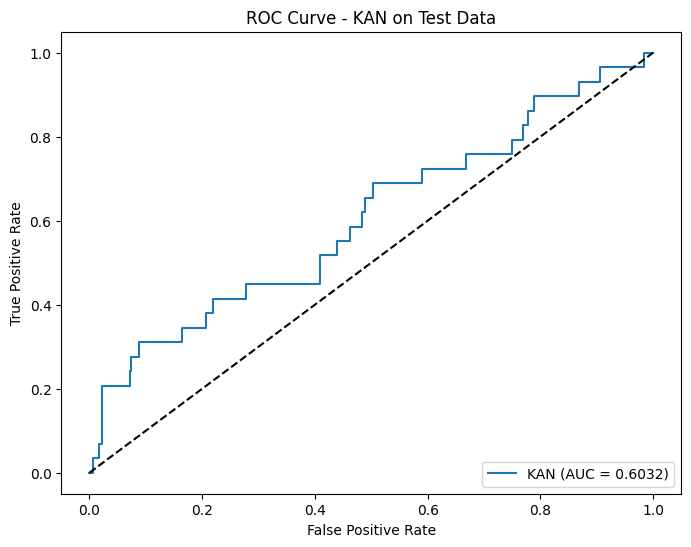

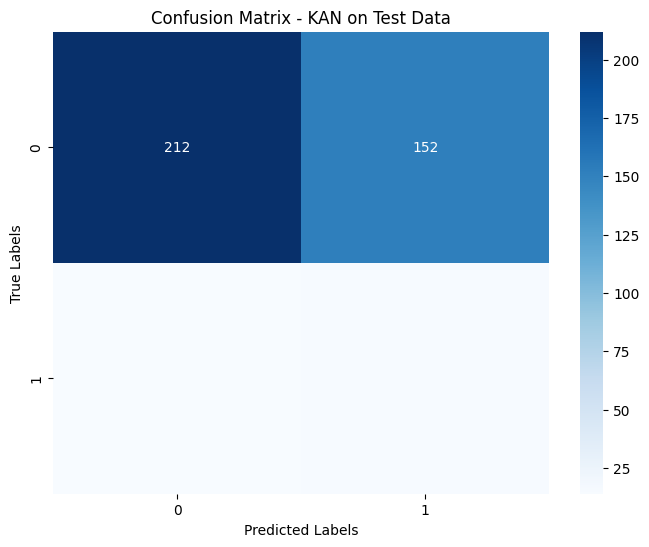

In [73]:
def evaluate_model_on_test_data():
    """
    Evaluate the best KAN model on test data and save results.
    """
    # Load the best model
    best_model = KAN(width=[25, 2], grid=best['grid'] + 4, k=best['k'] + 3)  # Adjust grid and k based on hyperparameter range
    best_model.load_state_dict(torch.load('ss_KAN.pth'))
    best_model.eval()
    
    # Prepare test data
    X_test_scaled = scaller.transform(X_test)
    test_input = torch.from_numpy(X_test_scaled).float()
    test_label = torch.from_numpy(y_test).long().squeeze()
    
    # Make predictions
    with torch.no_grad():
        predictions = best_model(test_input).to('cpu').detach().numpy()
    
    # Calculate probabilities and binary predictions
    pred_prob = softmax(predictions, axis=1)[:, 1]
    pred_labels = (pred_prob > 0.5).astype(int)
    
    # Calculate metrics
    test_roc_auc = roc_auc_score(y_test, pred_prob)
    test_f1 = f1_score(y_test, pred_labels)
    test_precision = precision_score(y_test, pred_labels)
    test_recall = recall_score(y_test, pred_labels)
    test_accuracy = accuracy_score(y_test, pred_labels)
    
    # Print results
    print("Test set evaluation results:")
    print(f"ROC AUC: {test_roc_auc:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    
    # Save results to file
    with open('test_results_ss_KAN.txt', 'w') as file:
        file.write(f"Test ROC AUC: {test_roc_auc:.4f}\n")
        file.write(f"Test F1 Score: {test_f1:.4f}\n")
        file.write(f"Test Precision: {test_precision:.4f}\n")
        file.write(f"Test Recall: {test_recall:.4f}\n")
        file.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    
    # Plot ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, pred_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'KAN (AUC = {test_roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - KAN on Test Data')
    plt.legend(loc='lower right')
    # plt.savefig('kan_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - KAN on Test Data')
    # plt.savefig('kan_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return test_roc_auc, test_f1, test_precision, test_recall, test_accuracy

# Run the evaluation
test_metrics = evaluate_model_on_test_data()

In [46]:
space = {
    # 'resamble_neg': hp.choice('resamble_neg', range(2, 16)),
    # 'resamble_pos': hp.choice('resamble_pos', range(4, 16)),
    'grid': hp.choice('grid', range(3, 5)),
    'k': hp.choice('k', range(3, 5)),
    'steps': hp.choice('steps', range(25, 50)),
    'weight_minor': hp.uniform('weight_minor', 1, 2),
    'weight_major': hp.uniform('weight_major', 0, 1),
    'lr': hp.loguniform('lr', -4, -1)
}

In [51]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

#Вывод лучших гиперпараметров
print("Лучшие гиперпараметры:", best)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(



checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/10 [00:42<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.44e-01 | test_loss: 9.14e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.44e-01 | test_loss: 9.14e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:04,  6.38it/
| train_loss: 6.44e-01 | test_loss: 9.14e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:03,  7.57it/
| train_loss: 6.44e-01 | test_loss: 9.14e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:03,  7.82it/
| train_loss: 6.44e-01 | test_loss: 9.14e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:03,  7.72it/
| train_loss: 6.44e-01 | test_loss: 9.14e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:02,  8.03it/
| train_loss: 6.44e-01 | test_loss: 9.14e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:03,  7.47it/
| train_loss: 6.44e-01 | test_loss: 9.14e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:00<00:03,  7.18it/
| train_loss: 6.44e-01 | test_loss: 9.14e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:02,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/10 [01:21<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.27e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.27e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:03,  7.32it/
| train_loss: 6.27e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:03,  7.88it/
| train_loss: 6.27e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:03,  8.64it/
| train_loss: 6.27e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:02,  8.82it/
| train_loss: 6.27e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:02,  9.10it/
| train_loss: 6.27e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:02,  8.56it/
| train_loss: 6.27e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:00<00:02,  9.12it/
| train_loss: 6.27e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  31%|3| 9/29 [00:01<00:02,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/10 [02:04<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 5.91e-01 | test_loss: 8.35e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 5.91e-01 | test_loss: 8.35e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:04,  6.70it/
| train_loss: 5.91e-01 | test_loss: 8.35e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:03,  7.71it/
| train_loss: 5.91e-01 | test_loss: 8.35e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:02,  9.00it/
| train_loss: 5.91e-01 | test_loss: 8.35e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:02,  9.13it/
| train_loss: 5.91e-01 | test_loss: 8.35e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:00<00:02,  9.28it/
| train_loss: 5.91e-01 | test_loss: 8.35e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:00<00:02,  9.38it/
| train_loss: 5.91e-01 | test_loss: 8.35e-01 | reg: 0.00e+00 | :  34%|3| 10/29 [00:01<00:01,  9.80it
| train_loss: 5.91e-01 | test_loss: 8.35e-01 | reg: 0.00e+00 | :  38%|3| 11/29 [00:01<00:02

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/10 [02:41<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.59e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.59e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:03,  8.18it/
| train_loss: 6.59e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:03,  8.05it/
| train_loss: 6.59e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:03,  8.36it/
| train_loss: 6.59e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:03,  7.85it/
| train_loss: 6.59e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:03,  7.88it/
| train_loss: 6.59e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:03,  7.47it/
| train_loss: 6.59e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:00<00:02,  8.13it/
| train_loss: 6.59e-01 | test_loss: 9.60e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:00<00:02,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/10 [03:19<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.25e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.25e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:03,  7.41it/
| train_loss: 6.25e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:02,  9.58it/
| train_loss: 6.25e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:02,  9.68it/
| train_loss: 6.25e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:02,  9.21it/
| train_loss: 6.25e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:00<00:02,  9.09it/
| train_loss: 6.25e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  31%|3| 9/29 [00:01<00:02,  7.81it/
| train_loss: 6.25e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  34%|3| 10/29 [00:01<00:02,  7.42it
| train_loss: 6.25e-01 | test_loss: 8.95e-01 | reg: 0.00e+00 | :  38%|3| 11/29 [00:01<00:02

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/10 [03:56<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.20e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.20e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:04,  6.96it/
| train_loss: 6.20e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:02,  8.69it/
| train_loss: 6.20e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:02,  8.85it/
| train_loss: 6.20e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:02,  8.77it/
| train_loss: 6.20e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:02,  8.69it/
| train_loss: 6.20e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:00<00:02,  8.91it/
| train_loss: 6.20e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  31%|3| 9/29 [00:00<00:02,  9.58it/
| train_loss: 6.20e-01 | test_loss: 8.93e-01 | reg: 0.00e+00 | :  34%|3| 10/29 [00:01<00:01

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/10 [04:32<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.42e-01 | test_loss: 9.51e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.42e-01 | test_loss: 9.51e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:03,  7.68it/
| train_loss: 6.42e-01 | test_loss: 9.51e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:03,  8.33it/
| train_loss: 6.42e-01 | test_loss: 9.51e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:02,  9.65it/
| train_loss: 6.42e-01 | test_loss: 9.51e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:02,  9.04it/
| train_loss: 6.42e-01 | test_loss: 9.51e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:02,  7.92it/
| train_loss: 6.42e-01 | test_loss: 9.51e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:00<00:02,  9.00it/
| train_loss: 6.42e-01 | test_loss: 9.51e-01 | reg: 0.00e+00 | :  31%|3| 9/29 [00:01<00:02,  9.22it/
| train_loss: 6.42e-01 | test_loss: 9.51e-01 | reg: 0.00e+00 | :  34%|3| 10/29 [00:01<00:02

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/10 [05:10<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 5.91e-01 | test_loss: 8.48e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 5.91e-01 | test_loss: 8.48e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:05,  4.72it/
| train_loss: 5.91e-01 | test_loss: 8.48e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:05,  5.14it/
| train_loss: 5.91e-01 | test_loss: 8.48e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:04,  5.41it/
| train_loss: 5.91e-01 | test_loss: 8.48e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:04,  5.40it/
| train_loss: 5.91e-01 | test_loss: 8.48e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:04,  5.50it/
| train_loss: 5.91e-01 | test_loss: 8.48e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:04,  5.28it/
| train_loss: 5.91e-01 | test_loss: 8.48e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:03,  5.72it/
| train_loss: 5.91e-01 | test_loss: 8.48e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:03,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/10 [05:50<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.26e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.26e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:03,  7.18it/
| train_loss: 6.26e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:03,  8.36it/
| train_loss: 6.26e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:02,  9.44it/
| train_loss: 6.26e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:02,  9.57it/
| train_loss: 6.26e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:02,  9.00it/
| train_loss: 6.26e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:00<00:02,  7.99it/
| train_loss: 6.26e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:00<00:02,  7.99it/
| train_loss: 6.26e-01 | test_loss: 9.38e-01 | reg: 0.00e+00 | :  31%|3| 9/29 [00:01<00:02,

saving model version 0.1                              
checkpoint directory created: ./model                 
saving model version 0.0                              
  0%|          | 0/10 [06:29<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.36e-01 | test_loss: 8.80e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.36e-01 | test_loss: 8.80e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:03,  8.60it/
| train_loss: 6.36e-01 | test_loss: 8.80e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:02,  9.95it/
| train_loss: 6.36e-01 | test_loss: 8.80e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:02,  9.78it/
| train_loss: 6.36e-01 | test_loss: 8.80e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:02,  9.66it/
| train_loss: 6.36e-01 | test_loss: 8.80e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:00<00:02,  9.68it/
| train_loss: 6.36e-01 | test_loss: 8.80e-01 | reg: 0.00e+00 | :  31%|3| 9/29 [00:00<00:02,  9.57it/
| train_loss: 6.36e-01 | test_loss: 8.80e-01 | reg: 0.00e+00 | :  38%|3| 11/29 [00:01<00:01,  9.40it
| train_loss: 6.36e-01 | test_loss: 8.80e-01 | reg: 0.00e+00 | :  41%|4| 12/29 [00:01<00:01

saving model version 0.1                              
0.7099303617182693                                    
[0.7297633872976339, 0.6942528735632184, 0.7597701149425288, 0.5798850574712644, 0.7160919540229885, 0.7114942528735632, 0.6913793103448276, 0.789080459770115, 0.69717868338558, 0.7304075235109717]
{'grid': 3, 'k': 3, 'lr': 0.21632969803975857, 'steps': 29, 'weight_major': 0.2326886128643837, 'weight_minor': 1.4555209501580417}
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 10%|█         | 1/10 [07:31<1:01:58, 413.15s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.54e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.54e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:06,  7.01it/
| train_loss: 6.54e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:05,  7.81it/
| train_loss: 6.54e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:00<00:05,  8.35it/
| train_loss: 6.54e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:00<00:05,  8.14it/
| train_loss: 6.54e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:00<00:04,  8.20it/
| train_loss: 6.54e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:00<00:05,  7.59it/
| train_loss: 6.54e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:00<00:05,  6.58it/
| train_loss: 6.54e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:01<00:05,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 10%|█         | 1/10 [08:14<1:01:58, 413.15s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.79e-01 | test_loss: 8.50e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.79e-01 | test_loss: 8.50e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:06,  7.08it/
| train_loss: 6.79e-01 | test_loss: 8.50e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:05,  7.41it/
| train_loss: 6.79e-01 | test_loss: 8.50e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:00<00:05,  8.07it/
| train_loss: 6.79e-01 | test_loss: 8.50e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:00<00:05,  8.15it/
| train_loss: 6.79e-01 | test_loss: 8.50e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:00<00:04,  8.17it/
| train_loss: 6.79e-01 | test_loss: 8.50e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:00<00:05,  7.44it/
| train_loss: 6.79e-01 | test_loss: 8.50e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:00<00:04,  7.67it/
| train_loss: 6.79e-01 | test_loss: 8.50e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:01<00:04,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 10%|█         | 1/10 [08:53<1:01:58, 413.15s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.42e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.42e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:08,  5.41it/
| train_loss: 6.42e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:06,  6.84it/
| train_loss: 6.42e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:00<00:05,  7.40it/
| train_loss: 6.42e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:00<00:05,  7.67it/
| train_loss: 6.42e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:00<00:05,  7.86it/
| train_loss: 6.42e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:00<00:05,  7.58it/
| train_loss: 6.42e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:00<00:04,  7.66it/
| train_loss: 6.42e-01 | test_loss: 7.98e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:01<00:04,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 10%|█         | 1/10 [09:33<1:01:58, 413.15s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.74e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.74e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:06,  6.87it/
| train_loss: 6.74e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:05,  7.78it/
| train_loss: 6.74e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:00<00:05,  8.34it/
| train_loss: 6.74e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:00<00:04,  8.40it/
| train_loss: 6.74e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:00<00:04,  8.58it/
| train_loss: 6.74e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:00<00:04,  7.99it/
| train_loss: 6.74e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:00<00:04,  8.34it/
| train_loss: 6.74e-01 | test_loss: 7.96e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:00<00:04,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 10%|█         | 1/10 [10:09<1:01:58, 413.15s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.39e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.39e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:09,  4.86it/
| train_loss: 6.39e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:06,  6.57it/
| train_loss: 6.39e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:00<00:05,  7.12it/
| train_loss: 6.39e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:00<00:05,  7.74it/
| train_loss: 6.39e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:00<00:05,  7.78it/
| train_loss: 6.39e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:00<00:05,  7.17it/
| train_loss: 6.39e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:00<00:05,  7.37it/
| train_loss: 6.39e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:01<00:04,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 10%|█         | 1/10 [10:47<1:01:58, 413.15s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.59e-01 | test_loss: 7.48e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.59e-01 | test_loss: 7.48e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:05,  7.62it/
| train_loss: 6.59e-01 | test_loss: 7.48e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:05,  7.32it/
| train_loss: 6.59e-01 | test_loss: 7.48e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:00<00:05,  8.06it/
| train_loss: 6.59e-01 | test_loss: 7.48e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:00<00:04,  8.42it/
| train_loss: 6.59e-01 | test_loss: 7.48e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:00<00:04,  8.54it/
| train_loss: 6.59e-01 | test_loss: 7.48e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:00<00:04,  8.19it/
| train_loss: 6.59e-01 | test_loss: 7.48e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:00<00:04,  8.08it/
| train_loss: 6.59e-01 | test_loss: 7.48e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:00<00:04,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 10%|█         | 1/10 [11:26<1:01:58, 413.15s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 7.38e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 7.38e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:10,  4.07it/
| train_loss: 7.38e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:07,  5.97it/
| train_loss: 7.38e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:00<00:05,  7.01it/
| train_loss: 7.38e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:00<00:05,  6.98it/
| train_loss: 7.38e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:00<00:05,  7.46it/
| train_loss: 7.38e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:00<00:05,  6.93it/
| train_loss: 7.38e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:01<00:05,  7.44it/
| train_loss: 7.38e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:01<00:04,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 10%|█         | 1/10 [12:03<1:01:58, 413.15s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.56e-01 | test_loss: 8.49e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.56e-01 | test_loss: 8.49e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:05,  7.34it/
| train_loss: 6.56e-01 | test_loss: 8.49e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:05,  7.95it/
| train_loss: 6.56e-01 | test_loss: 8.49e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:00<00:05,  7.65it/
| train_loss: 6.56e-01 | test_loss: 8.49e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:00<00:05,  7.88it/
| train_loss: 6.56e-01 | test_loss: 8.49e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:00<00:05,  7.61it/
| train_loss: 6.56e-01 | test_loss: 8.49e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:00<00:05,  6.68it/
| train_loss: 6.56e-01 | test_loss: 8.49e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:00<00:05,  7.07it/
| train_loss: 6.56e-01 | test_loss: 8.49e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:01<00:05,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 10%|█         | 1/10 [12:40<1:01:58, 413.15s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.30e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.30e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:09,  4.47it/
| train_loss: 6.30e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:07,  5.64it/
| train_loss: 6.30e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:00<00:06,  6.43it/
| train_loss: 6.30e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:00<00:05,  7.11it/
| train_loss: 6.30e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:00<00:06,  5.99it/
| train_loss: 6.30e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:01<00:06,  5.81it/
| train_loss: 6.30e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:01<00:06,  6.29it/
| train_loss: 6.30e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:01<00:05,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 10%|█         | 1/10 [13:16<1:01:58, 413.15s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/45 [00:00<?, ?it/s]
| train_loss: 6.93e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :   0%|       | 0/45 [00:00<?, ?it/s]
| train_loss: 6.93e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :   2%| | 1/45 [00:00<00:08,  5.38it/
| train_loss: 6.93e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :   4%| | 2/45 [00:00<00:06,  6.56it/
| train_loss: 6.93e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :   7%| | 3/45 [00:00<00:05,  7.37it/
| train_loss: 6.93e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :   9%| | 4/45 [00:00<00:05,  7.57it/
| train_loss: 6.93e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :  11%|1| 5/45 [00:00<00:05,  7.83it/
| train_loss: 6.93e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :  13%|1| 6/45 [00:00<00:05,  7.18it/
| train_loss: 6.93e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :  16%|1| 7/45 [00:00<00:05,  7.51it/
| train_loss: 6.93e-01 | test_loss: 8.14e-01 | reg: 0.00e+00 | :  18%|1| 8/45 [00:01<00:04,

saving model version 0.1                                                            
0.6649463219822218                                                                  
[0.5323785803237858, 0.6310344827586207, 0.6879310344827587, 0.6074712643678161, 0.6528735632183907, 0.8166666666666667, 0.664367816091954, 0.7206896551724138, 0.6915360501567398, 0.6445141065830722]
{'grid': 4, 'k': 4, 'lr': 0.1468401341886588, 'steps': 45, 'weight_major': 0.5487716245248894, 'weight_minor': 1.7410131589529798}
checkpoint directory created: ./model                                               
saving model version 0.0                                                          
 20%|██        | 2/10 [14:13<54:44, 410.60s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/33 [00:00<?, ?it/s]
| train_loss: 7.27e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :   0%|       | 0/33 [00:00<?, ?it/s]
| train_loss: 7.27e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :   3%| | 1/33 [00:00<00:06,  4.74it/
| train_loss: 7.27e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :   6%| | 2/33 [00:00<00:05,  5.32it/
| train_loss: 7.27e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :   9%| | 3/33 [00:00<00:04,  6.03it/
| train_loss: 7.27e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :  12%|1| 4/33 [00:00<00:04,  6.27it/
| train_loss: 7.27e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :  15%|1| 5/33 [00:00<00:04,  6.33it/
| train_loss: 7.27e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :  18%|1| 6/33 [00:00<00:04,  6.19it/
| train_loss: 7.27e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :  21%|2| 7/33 [00:01<00:04,  5.76it/
| train_loss: 7.27e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :  24%|2| 8/33 [00:01<00:04,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 2/10 [14:49<54:44, 410.60s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/33 [00:00<?, ?it/s]
| train_loss: 6.79e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :   0%|       | 0/33 [00:00<?, ?it/s]
| train_loss: 6.79e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :   3%| | 1/33 [00:00<00:05,  6.28it/
| train_loss: 6.79e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :   6%| | 2/33 [00:00<00:04,  6.77it/
| train_loss: 6.79e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :   9%| | 3/33 [00:00<00:04,  6.81it/
| train_loss: 6.79e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  12%|1| 4/33 [00:00<00:04,  7.12it/
| train_loss: 6.79e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  15%|1| 5/33 [00:00<00:03,  7.07it/
| train_loss: 6.79e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  18%|1| 6/33 [00:00<00:04,  6.74it/
| train_loss: 6.79e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  21%|2| 7/33 [00:01<00:03,  6.96it/
| train_loss: 6.79e-01 | test_loss: 8.24e-01 | reg: 0.00e+00 | :  24%|2| 8/33 [00:01<00:03,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 2/10 [15:28<54:44, 410.60s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/33 [00:00<?, ?it/s]
| train_loss: 7.04e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   0%|       | 0/33 [00:00<?, ?it/s]
| train_loss: 7.04e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   3%| | 1/33 [00:00<00:05,  5.87it/
| train_loss: 7.04e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   6%| | 2/33 [00:00<00:04,  6.92it/
| train_loss: 7.04e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   9%| | 3/33 [00:00<00:04,  6.92it/
| train_loss: 7.04e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  12%|1| 4/33 [00:00<00:04,  7.24it/
| train_loss: 7.04e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  15%|1| 5/33 [00:00<00:03,  7.08it/
| train_loss: 7.04e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  18%|1| 6/33 [00:00<00:04,  6.67it/
| train_loss: 7.04e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  21%|2| 7/33 [00:01<00:03,  6.77it/
| train_loss: 7.04e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  24%|2| 8/33 [00:01<00:03,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 2/10 [31:38<54:44, 410.60s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/33 [00:00<?, ?it/s]
| train_loss: 6.85e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   0%|       | 0/33 [00:00<?, ?it/s]
| train_loss: 6.85e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   3%| | 1/33 [00:00<00:08,  3.72it/
| train_loss: 6.85e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   6%| | 2/33 [00:00<00:08,  3.58it/
| train_loss: 6.85e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :   9%| | 3/33 [00:00<00:08,  3.54it/
| train_loss: 6.85e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  12%|1| 4/33 [00:01<00:07,  3.73it/
| train_loss: 6.85e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  15%|1| 5/33 [00:01<00:07,  3.82it/
| train_loss: 6.85e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  18%|1| 6/33 [00:01<00:07,  3.63it/
| train_loss: 6.85e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  21%|2| 7/33 [00:01<00:07,  3.71it/
| train_loss: 6.85e-01 | test_loss: 7.86e-01 | reg: 0.00e+00 | :  24%|2| 8/33 [00:02<00:06,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 2/10 [32:32<54:44, 410.60s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/33 [00:00<?, ?it/s]
| train_loss: 6.60e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   0%|       | 0/33 [00:00<?, ?it/s]
| train_loss: 6.60e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   3%| | 1/33 [00:00<00:10,  3.17it/
| train_loss: 6.60e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   6%| | 2/33 [00:00<00:09,  3.11it/
| train_loss: 6.60e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :   9%| | 3/33 [00:00<00:08,  3.39it/
| train_loss: 6.60e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  12%|1| 4/33 [00:01<00:08,  3.35it/
| train_loss: 6.60e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  15%|1| 5/33 [00:01<00:07,  3.57it/
| train_loss: 6.60e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  18%|1| 6/33 [00:01<00:07,  3.47it/
| train_loss: 6.60e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  21%|2| 7/33 [00:02<00:07,  3.45it/
| train_loss: 6.60e-01 | test_loss: 8.79e-01 | reg: 0.00e+00 | :  24%|2| 8/33 [00:02<00:06,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 2/10 [33:42<54:44, 410.60s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/33 [00:00<?, ?it/s]
| train_loss: 7.41e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :   0%|       | 0/33 [00:00<?, ?it/s]
| train_loss: 7.41e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :   3%| | 1/33 [00:00<00:11,  2.79it/
| train_loss: 7.41e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :   6%| | 2/33 [00:00<00:11,  2.73it/
| train_loss: 7.41e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :   9%| | 3/33 [00:01<00:10,  3.00it/
| train_loss: 7.41e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :  12%|1| 4/33 [00:01<00:11,  2.47it/
| train_loss: 7.41e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :  15%|1| 5/33 [00:01<00:10,  2.63it/
| train_loss: 7.41e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :  18%|1| 6/33 [00:02<00:10,  2.58it/
| train_loss: 7.41e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :  21%|2| 7/33 [00:02<00:09,  2.65it/
| train_loss: 7.41e-01 | test_loss: 8.63e-01 | reg: 0.00e+00 | :  24%|2| 8/33 [00:03<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 2/10 [34:56<54:44, 410.60s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/33 [00:00<?, ?it/s]
| train_loss: 6.89e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   0%|       | 0/33 [00:00<?, ?it/s]
| train_loss: 6.89e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   3%| | 1/33 [00:00<00:12,  2.47it/
| train_loss: 6.89e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   6%| | 2/33 [00:00<00:11,  2.60it/
| train_loss: 6.89e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   9%| | 3/33 [00:01<00:11,  2.56it/
| train_loss: 6.89e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  12%|1| 4/33 [00:01<00:10,  2.74it/
| train_loss: 6.89e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  15%|1| 5/33 [00:01<00:10,  2.72it/
| train_loss: 6.89e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  18%|1| 6/33 [00:02<00:10,  2.54it/
| train_loss: 6.89e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  21%|2| 7/33 [00:02<00:10,  2.59it/
| train_loss: 6.89e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  24%|2| 8/33 [00:03<00:09,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 2/10 [36:12<54:44, 410.60s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/33 [00:00<?, ?it/s]
| train_loss: 6.77e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :   0%|       | 0/33 [00:00<?, ?it/s]
| train_loss: 6.77e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :   3%| | 1/33 [00:00<00:14,  2.14it/
| train_loss: 6.77e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :   6%| | 2/33 [00:00<00:12,  2.53it/
| train_loss: 6.77e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :   9%| | 3/33 [00:01<00:11,  2.56it/
| train_loss: 6.77e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :  12%|1| 4/33 [00:01<00:11,  2.62it/
| train_loss: 6.77e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :  15%|1| 5/33 [00:01<00:10,  2.68it/
| train_loss: 6.77e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :  18%|1| 6/33 [00:02<00:11,  2.33it/
| train_loss: 6.77e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :  21%|2| 7/33 [00:02<00:10,  2.37it/
| train_loss: 6.77e-01 | test_loss: 9.02e-01 | reg: 0.00e+00 | :  24%|2| 8/33 [00:03<00:10,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 2/10 [37:43<54:44, 410.60s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/33 [00:00<?, ?it/s]
| train_loss: 6.60e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :   0%|       | 0/33 [00:00<?, ?it/s]
| train_loss: 6.60e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :   3%| | 1/33 [00:00<00:17,  1.81it/
| train_loss: 6.60e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :   6%| | 2/33 [00:01<00:16,  1.86it/
| train_loss: 6.60e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :   9%| | 3/33 [00:01<00:16,  1.86it/
| train_loss: 6.60e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :  12%|1| 4/33 [00:02<00:15,  1.82it/
| train_loss: 6.60e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :  15%|1| 5/33 [00:02<00:14,  1.95it/
| train_loss: 6.60e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :  18%|1| 6/33 [00:03<00:13,  1.95it/
| train_loss: 6.60e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :  21%|2| 7/33 [00:03<00:13,  1.98it/
| train_loss: 6.60e-01 | test_loss: 8.47e-01 | reg: 0.00e+00 | :  24%|2| 8/33 [00:04<00:12,

saving model version 0.1                                                          
checkpoint directory created: ./model                                             
saving model version 0.0                                                          
 20%|██        | 2/10 [39:25<54:44, 410.60s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/33 [00:00<?, ?it/s]
| train_loss: 7.12e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :   0%|       | 0/33 [00:00<?, ?it/s]
| train_loss: 7.12e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :   3%| | 1/33 [00:00<00:16,  1.99it/
| train_loss: 7.12e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :   6%| | 2/33 [00:00<00:14,  2.15it/
| train_loss: 7.12e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :   9%| | 3/33 [00:01<00:13,  2.22it/
| train_loss: 7.12e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :  12%|1| 4/33 [00:01<00:13,  2.17it/
| train_loss: 7.12e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :  15%|1| 5/33 [00:02<00:13,  2.02it/
| train_loss: 7.12e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :  18%|1| 6/33 [00:02<00:14,  1.90it/
| train_loss: 7.12e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :  21%|2| 7/33 [00:03<00:13,  1.99it/
| train_loss: 7.12e-01 | test_loss: 8.55e-01 | reg: 0.00e+00 | :  24%|2| 8/33 [00:03<00:12,

saving model version 0.1                                                          
0.7084518543965874                                                                
[0.6917808219178082, 0.6971264367816092, 0.7844827586206896, 0.7293103448275862, 0.6994252873563218, 0.7764367816091955, 0.6873563218390805, 0.6091954022988506, 0.6915360501567398, 0.7178683385579938]
{'grid': 4, 'k': 4, 'lr': 0.020374278720093925, 'steps': 33, 'weight_major': 0.3298174167334592, 'weight_minor': 1.1725999262799927}
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 30%|███       | 3/10 [41:26<1:50:12, 944.71s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/27 [00:00<?, ?it/s]
| train_loss: 6.74e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :   0%|       | 0/27 [00:00<?, ?it/s]
| train_loss: 6.74e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :   4%| | 1/27 [00:00<00:13,  1.94it/
| train_loss: 6.74e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :   7%| | 2/27 [00:00<00:11,  2.09it/
| train_loss: 6.74e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  11%|1| 3/27 [00:01<00:10,  2.19it/
| train_loss: 6.74e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  15%|1| 4/27 [00:01<00:10,  2.10it/
| train_loss: 6.74e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  19%|1| 5/27 [00:02<00:09,  2.22it/
| train_loss: 6.74e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  22%|2| 6/27 [00:02<00:09,  2.24it/
| train_loss: 6.74e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  26%|2| 7/27 [00:03<00:08,  2.28it/
| train_loss: 6.74e-01 | test_loss: 7.80e-01 | reg: 0.00e+00 | :  30%|2| 8/27 [00:03<00:08,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 30%|███       | 3/10 [43:05<1:50:12, 944.71s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/27 [00:00<?, ?it/s]
| train_loss: 6.87e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :   0%|       | 0/27 [00:00<?, ?it/s]
| train_loss: 6.87e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :   4%| | 1/27 [00:00<00:11,  2.28it/
| train_loss: 6.87e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :   7%| | 2/27 [00:00<00:10,  2.31it/
| train_loss: 6.87e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  11%|1| 3/27 [00:01<00:10,  2.29it/
| train_loss: 6.87e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  15%|1| 4/27 [00:01<00:10,  2.16it/
| train_loss: 6.87e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  19%|1| 5/27 [00:02<00:11,  1.99it/
| train_loss: 6.87e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  22%|2| 6/27 [00:02<00:10,  1.92it/
| train_loss: 6.87e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  26%|2| 7/27 [00:03<00:09,  2.03it/
| train_loss: 6.87e-01 | test_loss: 8.44e-01 | reg: 0.00e+00 | :  30%|2| 8/27 [00:03<00:08,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 30%|███       | 3/10 [44:48<1:50:12, 944.71s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/27 [00:00<?, ?it/s]
| train_loss: 6.97e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :   0%|       | 0/27 [00:00<?, ?it/s]
| train_loss: 6.97e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :   4%| | 1/27 [00:00<00:12,  2.14it/
| train_loss: 6.97e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :   7%| | 2/27 [00:00<00:12,  2.06it/
| train_loss: 6.97e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :  11%|1| 3/27 [00:01<00:10,  2.22it/
| train_loss: 6.97e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :  15%|1| 4/27 [00:01<00:10,  2.15it/
| train_loss: 6.97e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :  19%|1| 5/27 [00:02<00:10,  2.07it/
| train_loss: 6.97e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :  22%|2| 6/27 [00:02<00:10,  1.96it/
| train_loss: 6.97e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :  26%|2| 7/27 [00:03<00:09,  2.04it/
| train_loss: 6.97e-01 | test_loss: 7.75e-01 | reg: 0.00e+00 | :  30%|2| 8/27 [00:03<00:09,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 30%|███       | 3/10 [46:31<1:50:12, 944.71s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/27 [00:00<?, ?it/s]
| train_loss: 7.16e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :   0%|       | 0/27 [00:00<?, ?it/s]
| train_loss: 7.16e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :   4%| | 1/27 [00:00<00:14,  1.85it/
| train_loss: 7.16e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :   7%| | 2/27 [00:01<00:13,  1.80it/
| train_loss: 7.16e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  11%|1| 3/27 [00:01<00:13,  1.83it/
| train_loss: 7.16e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  15%|1| 4/27 [00:02<00:12,  1.79it/
| train_loss: 7.16e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  19%|1| 5/27 [00:02<00:12,  1.70it/
| train_loss: 7.16e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  22%|2| 6/27 [00:03<00:14,  1.40it/
| train_loss: 7.16e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  26%|2| 7/27 [00:04<00:13,  1.46it/
| train_loss: 7.16e-01 | test_loss: 8.30e-01 | reg: 0.00e+00 | :  30%|2| 8/27 [00:05<00:13,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 30%|███       | 3/10 [48:20<1:50:12, 944.71s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/27 [00:00<?, ?it/s]
| train_loss: 7.04e-01 | test_loss: 7.58e-01 | reg: 0.00e+00 | :   0%|       | 0/27 [00:00<?, ?it/s]
| train_loss: 7.04e-01 | test_loss: 7.58e-01 | reg: 0.00e+00 | :   4%| | 1/27 [00:00<00:10,  2.45it/
| train_loss: 7.04e-01 | test_loss: 7.58e-01 | reg: 0.00e+00 | :   7%| | 2/27 [00:01<00:12,  1.94it/
| train_loss: 7.04e-01 | test_loss: 7.58e-01 | reg: 0.00e+00 | :  11%|1| 3/27 [00:01<00:11,  2.01it/
| train_loss: 7.04e-01 | test_loss: 7.58e-01 | reg: 0.00e+00 | :  15%|1| 4/27 [00:01<00:10,  2.21it/
| train_loss: 7.04e-01 | test_loss: 7.58e-01 | reg: 0.00e+00 | :  19%|1| 5/27 [00:02<00:09,  2.25it/
| train_loss: 7.04e-01 | test_loss: 7.58e-01 | reg: 0.00e+00 | :  22%|2| 6/27 [00:02<00:09,  2.12it/
| train_loss: 7.04e-01 | test_loss: 7.58e-01 | reg: 0.00e+00 | :  26%|2| 7/27 [00:03<00:09,  2.15it/
| train_loss: 7.04e-01 | test_loss: 7.58e-01 | reg: 0.00e+00 | :  30%|2| 8/27 [00:03<00:08,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 30%|███       | 3/10 [49:59<1:50:12, 944.71s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/27 [00:00<?, ?it/s]
| train_loss: 7.48e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :   0%|       | 0/27 [00:00<?, ?it/s]
| train_loss: 7.48e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :   4%| | 1/27 [00:00<00:11,  2.23it/
| train_loss: 7.48e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :   7%| | 2/27 [00:00<00:12,  2.01it/
| train_loss: 7.48e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  11%|1| 3/27 [00:01<00:12,  1.88it/
| train_loss: 7.48e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  15%|1| 4/27 [00:02<00:11,  1.99it/
| train_loss: 7.48e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  19%|1| 5/27 [00:02<00:10,  2.05it/
| train_loss: 7.48e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  22%|2| 6/27 [00:02<00:10,  2.09it/
| train_loss: 7.48e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  26%|2| 7/27 [00:03<00:10,  1.99it/
| train_loss: 7.48e-01 | test_loss: 8.17e-01 | reg: 0.00e+00 | :  30%|2| 8/27 [00:03<00:09,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 30%|███       | 3/10 [51:44<1:50:12, 944.71s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/27 [00:00<?, ?it/s]
| train_loss: 7.15e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   0%|       | 0/27 [00:00<?, ?it/s]
| train_loss: 7.15e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   4%| | 1/27 [00:00<00:13,  1.97it/
| train_loss: 7.15e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :   7%| | 2/27 [00:00<00:11,  2.21it/
| train_loss: 7.15e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  11%|1| 3/27 [00:01<00:10,  2.21it/
| train_loss: 7.15e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  15%|1| 4/27 [00:01<00:10,  2.16it/
| train_loss: 7.15e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  19%|1| 5/27 [00:02<00:10,  2.15it/
| train_loss: 7.15e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  22%|2| 6/27 [00:02<00:09,  2.12it/
| train_loss: 7.15e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  26%|2| 7/27 [00:03<00:09,  2.13it/
| train_loss: 7.15e-01 | test_loss: 8.15e-01 | reg: 0.00e+00 | :  30%|2| 8/27 [00:03<00:09,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 30%|███       | 3/10 [53:05<1:50:12, 944.71s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/27 [00:00<?, ?it/s]
| train_loss: 6.84e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :   0%|       | 0/27 [00:00<?, ?it/s]
| train_loss: 6.84e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :   4%| | 1/27 [00:00<00:04,  5.49it/
| train_loss: 6.84e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :   7%| | 2/27 [00:00<00:05,  4.30it/
| train_loss: 6.84e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  11%|1| 3/27 [00:00<00:05,  4.67it/
| train_loss: 6.84e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  15%|1| 4/27 [00:00<00:04,  5.19it/
| train_loss: 6.84e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  19%|1| 5/27 [00:00<00:03,  5.57it/
| train_loss: 6.84e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  22%|2| 6/27 [00:01<00:04,  4.45it/
| train_loss: 6.84e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  26%|2| 7/27 [00:01<00:04,  4.80it/
| train_loss: 6.84e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  30%|2| 8/27 [00:01<00:03,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 30%|███       | 3/10 [53:50<1:50:12, 944.71s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/27 [00:00<?, ?it/s]
| train_loss: 6.99e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :   0%|       | 0/27 [00:00<?, ?it/s]
| train_loss: 6.99e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :   4%| | 1/27 [00:00<00:05,  5.14it/
| train_loss: 6.99e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :   7%| | 2/27 [00:00<00:04,  5.51it/
| train_loss: 6.99e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :  11%|1| 3/27 [00:00<00:04,  5.73it/
| train_loss: 6.99e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :  15%|1| 4/27 [00:00<00:04,  5.54it/
| train_loss: 6.99e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :  19%|1| 5/27 [00:00<00:03,  5.72it/
| train_loss: 6.99e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :  22%|2| 6/27 [00:01<00:04,  4.64it/
| train_loss: 6.99e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :  26%|2| 7/27 [00:01<00:04,  4.36it/
| train_loss: 6.99e-01 | test_loss: 8.02e-01 | reg: 0.00e+00 | :  30%|2| 8/27 [00:01<00:04,

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 30%|███       | 3/10 [54:34<1:50:12, 944.71s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/27 [00:00<?, ?it/s]
| train_loss: 7.35e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :   0%|       | 0/27 [00:00<?, ?it/s]
| train_loss: 7.35e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :   4%| | 1/27 [00:00<00:04,  5.89it/
| train_loss: 7.35e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :   7%| | 2/27 [00:00<00:03,  6.78it/
| train_loss: 7.35e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :  11%|1| 3/27 [00:00<00:03,  7.12it/
| train_loss: 7.35e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :  15%|1| 4/27 [00:00<00:03,  7.46it/
| train_loss: 7.35e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :  19%|1| 5/27 [00:00<00:03,  6.43it/
| train_loss: 7.35e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :  22%|2| 6/27 [00:00<00:03,  6.46it/
| train_loss: 7.35e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :  26%|2| 7/27 [00:01<00:02,  6.98it/
| train_loss: 7.35e-01 | test_loss: 7.88e-01 | reg: 0.00e+00 | :  30%|2| 8/27 [00:01<00:02,

saving model version 0.1                                                            
0.6772775940796725                                                                  
[0.5990037359900374, 0.5913793103448276, 0.7327586206896551, 0.5747126436781609, 0.7408045977011494, 0.7419540229885058, 0.6683908045977011, 0.6867816091954023, 0.6777429467084639, 0.7592476489028214]
{'grid': 3, 'k': 4, 'lr': 0.03126719635259899, 'steps': 27, 'weight_major': 0.6585505734325118, 'weight_minor': 1.6249857786175403}
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
 40%|████      | 4/10 [55:29<1:32:35, 925.84s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.61e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.61e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:03,  8.39it/
| train_loss: 6.61e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:02, 10.22it/
| train_loss: 6.61e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:02,  9.35it/
| train_loss: 6.61e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:03,  7.62it/
| train_loss: 6.61e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:03,  6.39it/
| train_loss: 6.61e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:00<00:03,  6.27it/
| train_loss: 6.61e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :  31%|3| 9/29 [00:01<00:02,  7.63it/
| train_loss: 6.61e-01 | test_loss: 8.22e-01 | reg: 0.00e+00 | :  34%|3| 10/29 [00:01<00:02

saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                              
 40%|████      | 4/10 [1:12:33<1:32:35, 925.84s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.67e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.67e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:02,  9.58it/
| train_loss: 6.67e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:02, 11.68it/
| train_loss: 6.67e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:01, 12.05it/
| train_loss: 6.67e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:00<00:01, 12.14it/
| train_loss: 6.67e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  31%|3| 9/29 [00:00<00:01, 12.32it/
| train_loss: 6.67e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  38%|3| 11/29 [00:00<00:01, 11.58it
| train_loss: 6.67e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  45%|4| 13/29 [00:01<00:01,  9.39it
| train_loss: 6.67e-01 | test_loss: 7.78e-01 | reg: 0.00e+00 | :  52%|5| 15/29 [00:01<00:01

saving model version 0.1                                                              
checkpoint directory created: ./model                                                 
saving model version 0.0                                                              
 40%|████      | 4/10 [1:13:08<1:32:35, 925.84s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.38e-01 | test_loss: 7.85e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.38e-01 | test_loss: 7.85e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:05,  5.09it/
| train_loss: 6.38e-01 | test_loss: 7.85e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:04,  5.90it/
| train_loss: 6.38e-01 | test_loss: 7.85e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:04,  6.08it/
| train_loss: 6.38e-01 | test_loss: 7.85e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:03,  6.37it/
| train_loss: 6.38e-01 | test_loss: 7.85e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:03,  7.33it/
| train_loss: 6.38e-01 | test_loss: 7.85e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:00<00:02,  7.87it/
| train_loss: 6.38e-01 | test_loss: 7.85e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:02,  8.19it/
| train_loss: 6.38e-01 | test_loss: 7.85e-01 | reg: 0.00e+00 | :  34%|3| 10/29 [00:01<00:02

saving model version 0.1                                                              
checkpoint directory created: ./model                                                 
saving model version 0.0                                                              
 40%|████      | 4/10 [1:31:11<1:32:35, 925.84s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 7.19e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 7.19e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:03,  8.19it/
| train_loss: 7.19e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:02,  8.83it/
| train_loss: 7.19e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:02,  9.78it/
| train_loss: 7.19e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:02,  9.35it/
| train_loss: 7.19e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:00<00:02,  9.76it/
| train_loss: 7.19e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  31%|3| 9/29 [00:00<00:02,  9.79it/
| train_loss: 7.19e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  34%|3| 10/29 [00:01<00:01,  9.80it
| train_loss: 7.19e-01 | test_loss: 8.90e-01 | reg: 0.00e+00 | :  38%|3| 11/29 [00:01<00:02

saving model version 0.1                                                              
checkpoint directory created: ./model                                                 
saving model version 0.0                                                              
 40%|████      | 4/10 [1:31:49<1:32:35, 925.84s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.75e-01 | test_loss: 8.34e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.75e-01 | test_loss: 8.34e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:03,  7.03it/
| train_loss: 6.75e-01 | test_loss: 8.34e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:02,  9.13it/
| train_loss: 6.75e-01 | test_loss: 8.34e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:00<00:02,  9.03it/
| train_loss: 6.75e-01 | test_loss: 8.34e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:02,  7.67it/
| train_loss: 6.75e-01 | test_loss: 8.34e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:00<00:03,  7.29it/
| train_loss: 6.75e-01 | test_loss: 8.34e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:02,  7.88it/
| train_loss: 6.75e-01 | test_loss: 8.34e-01 | reg: 0.00e+00 | :  31%|3| 9/29 [00:01<00:02,  7.01it/
| train_loss: 6.75e-01 | test_loss: 8.34e-01 | reg: 0.00e+00 | :  34%|3| 10/29 [00:01<00:02

saving model version 0.1                                                              
checkpoint directory created: ./model                                                 
saving model version 0.0                                                              
 40%|████      | 4/10 [1:32:28<1:32:35, 925.84s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.67e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.67e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:04,  6.12it/
| train_loss: 6.67e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:03,  7.86it/
| train_loss: 6.67e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:02,  9.27it/
| train_loss: 6.67e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:00<00:02,  8.87it/
| train_loss: 6.67e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:00<00:02,  9.05it/
| train_loss: 6.67e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  31%|3| 9/29 [00:00<00:02,  9.55it/
| train_loss: 6.67e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  34%|3| 10/29 [00:01<00:01,  9.63it
| train_loss: 6.67e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  38%|3| 11/29 [00:01<00:01

saving model version 0.1                                                              
checkpoint directory created: ./model                                                 
saving model version 0.0                                                              
 40%|████      | 4/10 [1:33:08<1:32:35, 925.84s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.91e-01 | test_loss: 8.75e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.91e-01 | test_loss: 8.75e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:06,  4.50it/
| train_loss: 6.91e-01 | test_loss: 8.75e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:04,  5.43it/
| train_loss: 6.91e-01 | test_loss: 8.75e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:04,  5.42it/
| train_loss: 6.91e-01 | test_loss: 8.75e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:05,  4.60it/
| train_loss: 6.91e-01 | test_loss: 8.75e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:05,  4.69it/
| train_loss: 6.91e-01 | test_loss: 8.75e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:05,  4.45it/
| train_loss: 6.91e-01 | test_loss: 8.75e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:04,  5.16it/
| train_loss: 6.91e-01 | test_loss: 8.75e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                              
checkpoint directory created: ./model                                                 
saving model version 0.0                                                              
 40%|████      | 4/10 [1:34:09<1:32:35, 925.84s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.41e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.41e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:08,  3.36it/
| train_loss: 6.41e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:06,  4.15it/
| train_loss: 6.41e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:06,  4.28it/
| train_loss: 6.41e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:05,  4.43it/
| train_loss: 6.41e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:05,  4.61it/
| train_loss: 6.41e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:05,  4.01it/
| train_loss: 6.41e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:05,  4.32it/
| train_loss: 6.41e-01 | test_loss: 8.01e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:04,

saving model version 0.1                                                              
checkpoint directory created: ./model                                                 
saving model version 0.0                                                              
 40%|████      | 4/10 [1:35:10<1:32:35, 925.84s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.78e-01 | test_loss: 8.56e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.78e-01 | test_loss: 8.56e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:07,  3.57it/
| train_loss: 6.78e-01 | test_loss: 8.56e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:06,  4.08it/
| train_loss: 6.78e-01 | test_loss: 8.56e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:05,  4.38it/
| train_loss: 6.78e-01 | test_loss: 8.56e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:05,  4.24it/
| train_loss: 6.78e-01 | test_loss: 8.56e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:05,  4.40it/
| train_loss: 6.78e-01 | test_loss: 8.56e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:06,  3.61it/
| train_loss: 6.78e-01 | test_loss: 8.56e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:05,  3.78it/
| train_loss: 6.78e-01 | test_loss: 8.56e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:05,

saving model version 0.1                                                              
checkpoint directory created: ./model                                                 
saving model version 0.0                                                              
 40%|████      | 4/10 [1:36:19<1:32:35, 925.84s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/29 [00:00<?, ?it/s]
| train_loss: 6.86e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   0%|       | 0/29 [00:00<?, ?it/s]
| train_loss: 6.86e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   3%| | 1/29 [00:00<00:07,  3.56it/
| train_loss: 6.86e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   7%| | 2/29 [00:00<00:06,  4.10it/
| train_loss: 6.86e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  10%|1| 3/29 [00:00<00:06,  4.06it/
| train_loss: 6.86e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  14%|1| 4/29 [00:00<00:05,  4.26it/
| train_loss: 6.86e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  17%|1| 5/29 [00:01<00:05,  4.39it/
| train_loss: 6.86e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  21%|2| 6/29 [00:01<00:05,  4.14it/
| train_loss: 6.86e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  24%|2| 7/29 [00:01<00:05,  3.84it/
| train_loss: 6.86e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  28%|2| 8/29 [00:01<00:05,

saving model version 0.1                                                              
0.7046742102174318                                                                    
[0.7148194271481942, 0.7149425287356322, 0.7494252873563217, 0.5758620689655173, 0.6913793103448276, 0.6873563218390805, 0.693103448275862, 0.7885057471264367, 0.696551724137931, 0.7347962382445141]
{'grid': 4, 'k': 3, 'lr': 0.1445873127079592, 'steps': 29, 'weight_major': 0.35551340091118055, 'weight_minor': 1.2791277011649642}
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 50%|█████     | 5/10 [1:37:45<2:04:40, 1496.18s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.17e-01 | test_loss: 9.57e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.17e-01 | test_loss: 9.57e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:08,  2.85it/
| train_loss: 5.17e-01 | test_loss: 9.57e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.52it/
| train_loss: 5.17e-01 | test_loss: 9.57e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:07,  3.15it/
| train_loss: 5.17e-01 | test_loss: 9.57e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:05,  3.79it/
| train_loss: 5.17e-01 | test_loss: 9.57e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:05,  3.85it/
| train_loss: 5.17e-01 | test_loss: 9.57e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:05,  3.56it/
| train_loss: 5.17e-01 | test_loss: 9.57e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:01<00:05,  3.77it/
| train_loss: 5.17e-01 | test_loss: 9.57e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:04,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 50%|█████     | 5/10 [1:38:53<2:04:40, 1496.18s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.34e-01 | test_loss: 9.48e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.34e-01 | test_loss: 9.48e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.26it/
| train_loss: 5.34e-01 | test_loss: 9.48e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:07,  3.38it/
| train_loss: 5.34e-01 | test_loss: 9.48e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:06,  3.43it/
| train_loss: 5.34e-01 | test_loss: 9.48e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:06,  3.39it/
| train_loss: 5.34e-01 | test_loss: 9.48e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:06,  3.20it/
| train_loss: 5.34e-01 | test_loss: 9.48e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:06,  3.11it/
| train_loss: 5.34e-01 | test_loss: 9.48e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:06,  3.13it/
| train_loss: 5.34e-01 | test_loss: 9.48e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:05,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 50%|█████     | 5/10 [1:40:06<2:04:40, 1496.18s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.36e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.36e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.15it/
| train_loss: 5.36e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.54it/
| train_loss: 5.36e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:06,  3.45it/
| train_loss: 5.36e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:06,  3.30it/
| train_loss: 5.36e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:06,  3.09it/
| train_loss: 5.36e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:06,  3.13it/
| train_loss: 5.36e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:06,  2.98it/
| train_loss: 5.36e-01 | test_loss: 8.99e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:05,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 50%|█████     | 5/10 [1:41:23<2:04:40, 1496.18s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.13e-01 | test_loss: 8.70e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.13e-01 | test_loss: 8.70e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.30it/
| train_loss: 5.13e-01 | test_loss: 8.70e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.83it/
| train_loss: 5.13e-01 | test_loss: 8.70e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:05,  4.02it/
| train_loss: 5.13e-01 | test_loss: 8.70e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:07,  3.06it/
| train_loss: 5.13e-01 | test_loss: 8.70e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:06,  3.08it/
| train_loss: 5.13e-01 | test_loss: 8.70e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:07,  2.77it/
| train_loss: 5.13e-01 | test_loss: 8.70e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:06,  2.97it/
| train_loss: 5.13e-01 | test_loss: 8.70e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:05,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 50%|█████     | 5/10 [1:42:45<2:04:40, 1496.18s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.11e-01 | test_loss: 8.32e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.11e-01 | test_loss: 8.32e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:08,  3.02it/
| train_loss: 5.11e-01 | test_loss: 8.32e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:07,  3.16it/
| train_loss: 5.11e-01 | test_loss: 8.32e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:06,  3.51it/
| train_loss: 5.11e-01 | test_loss: 8.32e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:06,  3.42it/
| train_loss: 5.11e-01 | test_loss: 8.32e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:06,  3.36it/
| train_loss: 5.11e-01 | test_loss: 8.32e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:01<00:06,  3.22it/
| train_loss: 5.11e-01 | test_loss: 8.32e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:06,  2.92it/
| train_loss: 5.11e-01 | test_loss: 8.32e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:05,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 50%|█████     | 5/10 [1:44:14<2:04:40, 1496.18s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 4.96e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 4.96e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:12,  2.05it/
| train_loss: 4.96e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:10,  2.33it/
| train_loss: 4.96e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:01<00:09,  2.42it/
| train_loss: 4.96e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:08,  2.52it/
| train_loss: 4.96e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:02<00:08,  2.43it/
| train_loss: 4.96e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:02<00:09,  2.21it/
| train_loss: 4.96e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:03<00:08,  2.26it/
| train_loss: 4.96e-01 | test_loss: 8.77e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:03<00:07,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 50%|█████     | 5/10 [1:45:43<2:04:40, 1496.18s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.16e-01 | test_loss: 8.41e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.16e-01 | test_loss: 8.41e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:08,  2.89it/
| train_loss: 5.16e-01 | test_loss: 8.41e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.47it/
| train_loss: 5.16e-01 | test_loss: 8.41e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:07,  3.26it/
| train_loss: 5.16e-01 | test_loss: 8.41e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:07,  3.05it/
| train_loss: 5.16e-01 | test_loss: 8.41e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:07,  2.74it/
| train_loss: 5.16e-01 | test_loss: 8.41e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:02<00:07,  2.59it/
| train_loss: 5.16e-01 | test_loss: 8.41e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:07,  2.66it/
| train_loss: 5.16e-01 | test_loss: 8.41e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:06,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 50%|█████     | 5/10 [1:47:14<2:04:40, 1496.18s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.36e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.36e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:10,  2.35it/
| train_loss: 5.36e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:08,  2.68it/
| train_loss: 5.36e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:01<00:08,  2.70it/
| train_loss: 5.36e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:09,  2.44it/
| train_loss: 5.36e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:08,  2.61it/
| train_loss: 5.36e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:02<00:08,  2.46it/
| train_loss: 5.36e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:07,  2.65it/
| train_loss: 5.36e-01 | test_loss: 9.07e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:03<00:06,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 50%|█████     | 5/10 [1:48:40<2:04:40, 1496.18s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 5.21e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 5.21e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:07,  3.23it/
| train_loss: 5.21e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:06,  3.44it/
| train_loss: 5.21e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:06,  3.33it/
| train_loss: 5.21e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:07,  2.77it/
| train_loss: 5.21e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:08,  2.62it/
| train_loss: 5.21e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:02<00:08,  2.42it/
| train_loss: 5.21e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:07,  2.60it/
| train_loss: 5.21e-01 | test_loss: 9.39e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:06,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 50%|█████     | 5/10 [1:50:14<2:04:40, 1496.18s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/26 [00:00<?, ?it/s]
| train_loss: 4.85e-01 | test_loss: 8.21e-01 | reg: 0.00e+00 | :   0%|       | 0/26 [00:00<?, ?it/s]
| train_loss: 4.85e-01 | test_loss: 8.21e-01 | reg: 0.00e+00 | :   4%| | 1/26 [00:00<00:09,  2.64it/
| train_loss: 4.85e-01 | test_loss: 8.21e-01 | reg: 0.00e+00 | :   8%| | 2/26 [00:00<00:07,  3.04it/
| train_loss: 4.85e-01 | test_loss: 8.21e-01 | reg: 0.00e+00 | :  12%|1| 3/26 [00:00<00:07,  3.17it/
| train_loss: 4.85e-01 | test_loss: 8.21e-01 | reg: 0.00e+00 | :  15%|1| 4/26 [00:01<00:08,  2.64it/
| train_loss: 4.85e-01 | test_loss: 8.21e-01 | reg: 0.00e+00 | :  19%|1| 5/26 [00:01<00:08,  2.59it/
| train_loss: 4.85e-01 | test_loss: 8.21e-01 | reg: 0.00e+00 | :  23%|2| 6/26 [00:02<00:07,  2.61it/
| train_loss: 4.85e-01 | test_loss: 8.21e-01 | reg: 0.00e+00 | :  27%|2| 7/26 [00:02<00:07,  2.65it/
| train_loss: 4.85e-01 | test_loss: 8.21e-01 | reg: 0.00e+00 | :  31%|3| 8/26 [00:02<00:06,

saving model version 0.1                                                               
0.7083263909763674                                                                     
[0.5479452054794521, 0.6028735632183908, 0.7988505747126438, 0.6258620689655172, 0.825287356321839, 0.717816091954023, 0.7735632183908046, 0.746551724137931, 0.6213166144200627, 0.8231974921630093]
{'grid': 4, 'k': 3, 'lr': 0.10205826331394795, 'steps': 26, 'weight_major': 0.1505611997680001, 'weight_minor': 1.9094715449398287}
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 60%|██████    | 6/10 [1:52:04<1:24:49, 1272.46s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 5.51e-01 | test_loss: 9.45e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 5.51e-01 | test_loss: 9.45e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:23,  1.40it/
| train_loss: 5.51e-01 | test_loss: 9.45e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:01<00:18,  1.76it/
| train_loss: 5.51e-01 | test_loss: 9.45e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:01<00:16,  1.87it/
| train_loss: 5.51e-01 | test_loss: 9.45e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:02<00:15,  1.98it/
| train_loss: 5.51e-01 | test_loss: 9.45e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:02<00:14,  2.02it/
| train_loss: 5.51e-01 | test_loss: 9.45e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:03<00:13,  2.02it/
| train_loss: 5.51e-01 | test_loss: 9.45e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:03<00:13,  2.03it/
| train_loss: 5.51e-01 | test_loss: 9.45e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:04<00:12,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 60%|██████    | 6/10 [1:53:41<1:24:49, 1272.46s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 5.87e-01 | test_loss: 9.15e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 5.87e-01 | test_loss: 9.15e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:16,  1.99it/
| train_loss: 5.87e-01 | test_loss: 9.15e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:14,  2.17it/
| train_loss: 5.87e-01 | test_loss: 9.15e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:01<00:15,  2.04it/
| train_loss: 5.87e-01 | test_loss: 9.15e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:01<00:15,  1.97it/
| train_loss: 5.87e-01 | test_loss: 9.15e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:02<00:14,  2.02it/
| train_loss: 5.87e-01 | test_loss: 9.15e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:02<00:14,  2.00it/
| train_loss: 5.87e-01 | test_loss: 9.15e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:03<00:13,  1.97it/
| train_loss: 5.87e-01 | test_loss: 9.15e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:03<00:12,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 60%|██████    | 6/10 [1:55:25<1:24:49, 1272.46s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 5.80e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 5.80e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:27,  1.20it/
| train_loss: 5.80e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:01<00:20,  1.58it/
| train_loss: 5.80e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:01<00:18,  1.71it/
| train_loss: 5.80e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:02<00:17,  1.75it/
| train_loss: 5.80e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:02<00:15,  1.84it/
| train_loss: 5.80e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:03<00:16,  1.74it/
| train_loss: 5.80e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:04<00:14,  1.83it/
| train_loss: 5.80e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:04<00:13,

saving model version 0.1                                                               
 60%|██████    | 6/10 [1:55:44<1:24:49, 1272.46s/trial, best loss: -0.7099303617182693]

/Users/ivan.petrov/HSE/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 60%|██████    | 6/10 [1:57:15<1:24:49, 1272.46s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 5.70e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 5.70e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:17,  1.89it/
| train_loss: 5.70e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:15,  2.07it/
| train_loss: 5.70e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :   9%| | 3/34 [00:01<00:15,  1.98it/
| train_loss: 5.70e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  12%|1| 4/34 [00:01<00:14,  2.02it/
| train_loss: 5.70e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  15%|1| 5/34 [00:02<00:14,  2.06it/
| train_loss: 5.70e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  18%|1| 6/34 [00:03<00:14,  1.95it/
| train_loss: 5.70e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  21%|2| 7/34 [00:03<00:13,  2.04it/
| train_loss: 5.70e-01 | test_loss: 1.02e+00 | reg: 0.00e+00 | :  24%|2| 8/34 [00:03<00:12,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 60%|██████    | 6/10 [1:58:56<1:24:49, 1272.46s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 5.51e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 5.51e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:16,  1.95it/
| train_loss: 5.51e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:14,  2.17it/
| train_loss: 5.51e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:01<00:15,  2.01it/
| train_loss: 5.51e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:02<00:15,  1.92it/
| train_loss: 5.51e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:02<00:15,  1.92it/
| train_loss: 5.51e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:03<00:14,  1.99it/
| train_loss: 5.51e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:03<00:13,  2.05it/
| train_loss: 5.51e-01 | test_loss: 8.72e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:03<00:12,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 60%|██████    | 6/10 [2:00:40<1:24:49, 1272.46s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 6.01e-01 | test_loss: 9.35e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 6.01e-01 | test_loss: 9.35e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:17,  1.86it/
| train_loss: 6.01e-01 | test_loss: 9.35e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:01<00:16,  1.90it/
| train_loss: 6.01e-01 | test_loss: 9.35e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:01<00:15,  1.97it/
| train_loss: 6.01e-01 | test_loss: 9.35e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:01<00:14,  2.06it/
| train_loss: 6.01e-01 | test_loss: 9.35e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:02<00:14,  2.04it/
| train_loss: 6.01e-01 | test_loss: 9.35e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:03<00:14,  2.00it/
| train_loss: 6.01e-01 | test_loss: 9.35e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:03<00:14,  1.92it/
| train_loss: 6.01e-01 | test_loss: 9.35e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:04<00:12,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 60%|██████    | 6/10 [2:02:23<1:24:49, 1272.46s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 5.64e-01 | test_loss: 9.21e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 5.64e-01 | test_loss: 9.21e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:19,  1.70it/
| train_loss: 5.64e-01 | test_loss: 9.21e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:01<00:16,  1.98it/
| train_loss: 5.64e-01 | test_loss: 9.21e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:01<00:18,  1.70it/
| train_loss: 5.64e-01 | test_loss: 9.21e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:02<00:17,  1.71it/
| train_loss: 5.64e-01 | test_loss: 9.21e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:02<00:16,  1.81it/
| train_loss: 5.64e-01 | test_loss: 9.21e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:03<00:15,  1.82it/
| train_loss: 5.64e-01 | test_loss: 9.21e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:03<00:14,  1.85it/
| train_loss: 5.64e-01 | test_loss: 9.21e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:04<00:14,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 60%|██████    | 6/10 [2:04:05<1:24:49, 1272.46s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 5.48e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 5.48e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:17,  1.93it/
| train_loss: 5.48e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:00<00:15,  2.11it/
| train_loss: 5.48e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:01<00:15,  2.00it/
| train_loss: 5.48e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:02<00:16,  1.86it/
| train_loss: 5.48e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:02<00:16,  1.80it/
| train_loss: 5.48e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:03<00:17,  1.65it/
| train_loss: 5.48e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:04<00:16,  1.60it/
| train_loss: 5.48e-01 | test_loss: 9.28e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:04<00:15,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 60%|██████    | 6/10 [2:05:48<1:24:49, 1272.46s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 5.27e-01 | test_loss: 8.94e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 5.27e-01 | test_loss: 8.94e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:17,  1.92it/
| train_loss: 5.27e-01 | test_loss: 8.94e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:01<00:16,  1.92it/
| train_loss: 5.27e-01 | test_loss: 8.94e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:01<00:15,  2.04it/
| train_loss: 5.27e-01 | test_loss: 8.94e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:01<00:14,  2.03it/
| train_loss: 5.27e-01 | test_loss: 8.94e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:02<00:14,  2.07it/
| train_loss: 5.27e-01 | test_loss: 8.94e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:03<00:14,  1.98it/
| train_loss: 5.27e-01 | test_loss: 8.94e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:03<00:13,  1.99it/
| train_loss: 5.27e-01 | test_loss: 8.94e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:03<00:12,

saving model version 0.1                                                               
checkpoint directory created: ./model                                                  
saving model version 0.0                                                               
 60%|██████    | 6/10 [2:07:35<1:24:49, 1272.46s/trial, best loss: -0.7099303617182693]

description:   0%|                                                           | 0/34 [00:00<?, ?it/s]
| train_loss: 5.50e-01 | test_loss: 8.71e-01 | reg: 0.00e+00 | :   0%|       | 0/34 [00:00<?, ?it/s]
| train_loss: 5.50e-01 | test_loss: 8.71e-01 | reg: 0.00e+00 | :   3%| | 1/34 [00:00<00:22,  1.50it/
| train_loss: 5.50e-01 | test_loss: 8.71e-01 | reg: 0.00e+00 | :   6%| | 2/34 [00:01<00:21,  1.46it/
| train_loss: 5.50e-01 | test_loss: 8.71e-01 | reg: 0.00e+00 | :   9%| | 3/34 [00:01<00:18,  1.67it/
| train_loss: 5.50e-01 | test_loss: 8.71e-01 | reg: 0.00e+00 | :  12%|1| 4/34 [00:02<00:16,  1.79it/
| train_loss: 5.50e-01 | test_loss: 8.71e-01 | reg: 0.00e+00 | :  15%|1| 5/34 [00:02<00:15,  1.88it/
| train_loss: 5.50e-01 | test_loss: 8.71e-01 | reg: 0.00e+00 | :  18%|1| 6/34 [00:03<00:15,  1.87it/
| train_loss: 5.50e-01 | test_loss: 8.71e-01 | reg: 0.00e+00 | :  21%|2| 7/34 [00:03<00:14,  1.91it/
| train_loss: 5.50e-01 | test_loss: 8.71e-01 | reg: 0.00e+00 | :  24%|2| 8/34 [00:04<00:12,

saving model version 0.1                                                               
0.7363113897596657                                                                     
[0.7272727272727273, 0.728735632183908, 0.8350574712643678, 0.5229885057471264, 0.771264367816092, 0.8247126436781609, 0.674712643678161, 0.7517241379310344, 0.7178683385579938, 0.8087774294670846]
{'grid': 4, 'k': 4, 'lr': 0.05867354715205783, 'steps': 34, 'weight_major': 0.15618653783469894, 'weight_minor': 1.5306573752844517}
checkpoint directory created: ./model                                                  
saving model version 0.0                                                             
 70%|███████   | 7/10 [2:09:37<59:57, 1199.22s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/31 [00:00<?, ?it/s]
| train_loss: 6.13e-01 | test_loss: 6.88e-01 | reg: 0.00e+00 | :   0%|       | 0/31 [00:00<?, ?it/s]
| train_loss: 6.13e-01 | test_loss: 6.88e-01 | reg: 0.00e+00 | :   3%| | 1/31 [00:00<00:08,  3.33it/
| train_loss: 6.13e-01 | test_loss: 6.88e-01 | reg: 0.00e+00 | :   6%| | 2/31 [00:00<00:08,  3.53it/
| train_loss: 6.13e-01 | test_loss: 6.88e-01 | reg: 0.00e+00 | :  10%| | 3/31 [00:00<00:08,  3.38it/
| train_loss: 6.13e-01 | test_loss: 6.88e-01 | reg: 0.00e+00 | :  13%|1| 4/31 [00:01<00:07,  3.41it/
| train_loss: 6.13e-01 | test_loss: 6.88e-01 | reg: 0.00e+00 | :  16%|1| 5/31 [00:01<00:07,  3.35it/
| train_loss: 6.13e-01 | test_loss: 6.88e-01 | reg: 0.00e+00 | :  19%|1| 6/31 [00:01<00:07,  3.18it/
| train_loss: 6.13e-01 | test_loss: 6.88e-01 | reg: 0.00e+00 | :  23%|2| 7/31 [00:02<00:07,  3.32it/
| train_loss: 6.13e-01 | test_loss: 6.88e-01 | reg: 0.00e+00 | :  26%|2| 8/31 [00:02<00:06,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 70%|███████   | 7/10 [2:11:15<59:57, 1199.22s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/31 [00:00<?, ?it/s]
| train_loss: 7.08e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :   0%|       | 0/31 [00:00<?, ?it/s]
| train_loss: 7.08e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :   3%| | 1/31 [00:00<00:13,  2.20it/
| train_loss: 7.08e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :   6%| | 2/31 [00:00<00:10,  2.74it/
| train_loss: 7.08e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :  10%| | 3/31 [00:01<00:09,  2.92it/
| train_loss: 7.08e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :  13%|1| 4/31 [00:01<00:08,  3.15it/
| train_loss: 7.08e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :  16%|1| 5/31 [00:01<00:08,  3.18it/
| train_loss: 7.08e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :  19%|1| 6/31 [00:01<00:07,  3.14it/
| train_loss: 7.08e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :  23%|2| 7/31 [00:02<00:07,  3.06it/
| train_loss: 7.08e-01 | test_loss: 7.46e-01 | reg: 0.00e+00 | :  26%|2| 8/31 [00:02<00:07,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 70%|███████   | 7/10 [2:12:52<59:57, 1199.22s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/31 [00:00<?, ?it/s]
| train_loss: 7.05e-01 | test_loss: 7.18e-01 | reg: 0.00e+00 | :   0%|       | 0/31 [00:00<?, ?it/s]
| train_loss: 7.05e-01 | test_loss: 7.18e-01 | reg: 0.00e+00 | :   3%| | 1/31 [00:00<00:09,  3.08it/
| train_loss: 7.05e-01 | test_loss: 7.18e-01 | reg: 0.00e+00 | :   6%| | 2/31 [00:00<00:09,  3.13it/
| train_loss: 7.05e-01 | test_loss: 7.18e-01 | reg: 0.00e+00 | :  10%| | 3/31 [00:00<00:08,  3.28it/
| train_loss: 7.05e-01 | test_loss: 7.18e-01 | reg: 0.00e+00 | :  13%|1| 4/31 [00:01<00:08,  3.28it/
| train_loss: 7.05e-01 | test_loss: 7.18e-01 | reg: 0.00e+00 | :  16%|1| 5/31 [00:01<00:07,  3.28it/
| train_loss: 7.05e-01 | test_loss: 7.18e-01 | reg: 0.00e+00 | :  19%|1| 6/31 [00:01<00:08,  3.00it/
| train_loss: 7.05e-01 | test_loss: 7.18e-01 | reg: 0.00e+00 | :  23%|2| 7/31 [00:02<00:09,  2.63it/
| train_loss: 7.05e-01 | test_loss: 7.18e-01 | reg: 0.00e+00 | :  26%|2| 8/31 [00:02<00:08,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 70%|███████   | 7/10 [2:14:32<59:57, 1199.22s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/31 [00:00<?, ?it/s]
| train_loss: 6.58e-01 | test_loss: 6.73e-01 | reg: 0.00e+00 | :   0%|       | 0/31 [00:00<?, ?it/s]
| train_loss: 6.58e-01 | test_loss: 6.73e-01 | reg: 0.00e+00 | :   3%| | 1/31 [00:00<00:11,  2.68it/
| train_loss: 6.58e-01 | test_loss: 6.73e-01 | reg: 0.00e+00 | :   6%| | 2/31 [00:00<00:09,  3.05it/
| train_loss: 6.58e-01 | test_loss: 6.73e-01 | reg: 0.00e+00 | :  10%| | 3/31 [00:00<00:09,  3.10it/
| train_loss: 6.58e-01 | test_loss: 6.73e-01 | reg: 0.00e+00 | :  13%|1| 4/31 [00:01<00:08,  3.12it/
| train_loss: 6.58e-01 | test_loss: 6.73e-01 | reg: 0.00e+00 | :  16%|1| 5/31 [00:01<00:07,  3.27it/
| train_loss: 6.58e-01 | test_loss: 6.73e-01 | reg: 0.00e+00 | :  19%|1| 6/31 [00:01<00:07,  3.22it/
| train_loss: 6.58e-01 | test_loss: 6.73e-01 | reg: 0.00e+00 | :  23%|2| 7/31 [00:02<00:07,  3.05it/
| train_loss: 6.58e-01 | test_loss: 6.73e-01 | reg: 0.00e+00 | :  26%|2| 8/31 [00:02<00:07,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 70%|███████   | 7/10 [2:16:06<59:57, 1199.22s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/31 [00:00<?, ?it/s]
| train_loss: 6.55e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :   0%|       | 0/31 [00:00<?, ?it/s]
| train_loss: 6.55e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :   3%| | 1/31 [00:00<00:09,  3.19it/
| train_loss: 6.55e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :   6%| | 2/31 [00:00<00:09,  3.15it/
| train_loss: 6.55e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  10%| | 3/31 [00:00<00:08,  3.26it/
| train_loss: 6.55e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  13%|1| 4/31 [00:01<00:08,  3.23it/
| train_loss: 6.55e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  16%|1| 5/31 [00:01<00:08,  3.07it/
| train_loss: 6.55e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  19%|1| 6/31 [00:01<00:08,  3.07it/
| train_loss: 6.55e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  23%|2| 7/31 [00:02<00:07,  3.09it/
| train_loss: 6.55e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  26%|2| 8/31 [00:02<00:07,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 70%|███████   | 7/10 [2:17:44<59:57, 1199.22s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/31 [00:00<?, ?it/s]
| train_loss: 6.31e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :   0%|       | 0/31 [00:00<?, ?it/s]
| train_loss: 6.31e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :   3%| | 1/31 [00:00<00:09,  3.21it/
| train_loss: 6.31e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :   6%| | 2/31 [00:00<00:08,  3.25it/
| train_loss: 6.31e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :  10%| | 3/31 [00:00<00:08,  3.27it/
| train_loss: 6.31e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :  13%|1| 4/31 [00:01<00:08,  3.04it/
| train_loss: 6.31e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :  16%|1| 5/31 [00:01<00:10,  2.59it/
| train_loss: 6.31e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :  19%|1| 6/31 [00:02<00:09,  2.63it/
| train_loss: 6.31e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :  23%|2| 7/31 [00:02<00:08,  2.72it/
| train_loss: 6.31e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :  26%|2| 8/31 [00:02<00:08,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 70%|███████   | 7/10 [2:19:24<59:57, 1199.22s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/31 [00:00<?, ?it/s]
| train_loss: 6.54e-01 | test_loss: 6.68e-01 | reg: 0.00e+00 | :   0%|       | 0/31 [00:00<?, ?it/s]
| train_loss: 6.54e-01 | test_loss: 6.68e-01 | reg: 0.00e+00 | :   3%| | 1/31 [00:00<00:09,  3.19it/
| train_loss: 6.54e-01 | test_loss: 6.68e-01 | reg: 0.00e+00 | :   6%| | 2/31 [00:00<00:10,  2.78it/
| train_loss: 6.54e-01 | test_loss: 6.68e-01 | reg: 0.00e+00 | :  10%| | 3/31 [00:01<00:09,  2.84it/
| train_loss: 6.54e-01 | test_loss: 6.68e-01 | reg: 0.00e+00 | :  13%|1| 4/31 [00:01<00:09,  2.75it/
| train_loss: 6.54e-01 | test_loss: 6.68e-01 | reg: 0.00e+00 | :  16%|1| 5/31 [00:01<00:10,  2.45it/
| train_loss: 6.54e-01 | test_loss: 6.68e-01 | reg: 0.00e+00 | :  19%|1| 6/31 [00:02<00:10,  2.39it/
| train_loss: 6.54e-01 | test_loss: 6.68e-01 | reg: 0.00e+00 | :  23%|2| 7/31 [00:02<00:09,  2.42it/
| train_loss: 6.54e-01 | test_loss: 6.68e-01 | reg: 0.00e+00 | :  26%|2| 8/31 [00:03<00:09,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 70%|███████   | 7/10 [2:21:13<59:57, 1199.22s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/31 [00:00<?, ?it/s]
| train_loss: 7.01e-01 | test_loss: 7.66e-01 | reg: 0.00e+00 | :   0%|       | 0/31 [00:00<?, ?it/s]
| train_loss: 7.01e-01 | test_loss: 7.66e-01 | reg: 0.00e+00 | :   3%| | 1/31 [00:00<00:10,  2.91it/
| train_loss: 7.01e-01 | test_loss: 7.66e-01 | reg: 0.00e+00 | :   6%| | 2/31 [00:00<00:08,  3.24it/
| train_loss: 7.01e-01 | test_loss: 7.66e-01 | reg: 0.00e+00 | :  10%| | 3/31 [00:00<00:08,  3.27it/
| train_loss: 7.01e-01 | test_loss: 7.66e-01 | reg: 0.00e+00 | :  13%|1| 4/31 [00:01<00:08,  3.12it/
| train_loss: 7.01e-01 | test_loss: 7.66e-01 | reg: 0.00e+00 | :  16%|1| 5/31 [00:01<00:08,  3.21it/
| train_loss: 7.01e-01 | test_loss: 7.66e-01 | reg: 0.00e+00 | :  19%|1| 6/31 [00:01<00:08,  3.03it/
| train_loss: 7.01e-01 | test_loss: 7.66e-01 | reg: 0.00e+00 | :  23%|2| 7/31 [00:02<00:07,  3.14it/
| train_loss: 7.01e-01 | test_loss: 7.66e-01 | reg: 0.00e+00 | :  26%|2| 8/31 [00:02<00:07,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 70%|███████   | 7/10 [2:22:43<59:57, 1199.22s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/31 [00:00<?, ?it/s]
| train_loss: 6.91e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :   0%|       | 0/31 [00:00<?, ?it/s]
| train_loss: 6.91e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :   3%| | 1/31 [00:00<00:08,  3.54it/
| train_loss: 6.91e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :   6%| | 2/31 [00:00<00:07,  3.78it/
| train_loss: 6.91e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :  10%| | 3/31 [00:00<00:07,  3.77it/
| train_loss: 6.91e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :  13%|1| 4/31 [00:01<00:07,  3.81it/
| train_loss: 6.91e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :  16%|1| 5/31 [00:01<00:08,  3.17it/
| train_loss: 6.91e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :  19%|1| 6/31 [00:01<00:08,  3.06it/
| train_loss: 6.91e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :  23%|2| 7/31 [00:02<00:07,  3.22it/
| train_loss: 6.91e-01 | test_loss: 7.39e-01 | reg: 0.00e+00 | :  26%|2| 8/31 [00:02<00:07,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 70%|███████   | 7/10 [2:24:19<59:57, 1199.22s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/31 [00:00<?, ?it/s]
| train_loss: 6.64e-01 | test_loss: 6.35e-01 | reg: 0.00e+00 | :   0%|       | 0/31 [00:00<?, ?it/s]
| train_loss: 6.64e-01 | test_loss: 6.35e-01 | reg: 0.00e+00 | :   3%| | 1/31 [00:00<00:09,  3.33it/
| train_loss: 6.64e-01 | test_loss: 6.35e-01 | reg: 0.00e+00 | :   6%| | 2/31 [00:00<00:08,  3.23it/
| train_loss: 6.64e-01 | test_loss: 6.35e-01 | reg: 0.00e+00 | :  10%| | 3/31 [00:00<00:08,  3.35it/
| train_loss: 6.64e-01 | test_loss: 6.35e-01 | reg: 0.00e+00 | :  13%|1| 4/31 [00:01<00:07,  3.38it/
| train_loss: 6.64e-01 | test_loss: 6.35e-01 | reg: 0.00e+00 | :  16%|1| 5/31 [00:01<00:08,  3.08it/
| train_loss: 6.64e-01 | test_loss: 6.35e-01 | reg: 0.00e+00 | :  19%|1| 6/31 [00:01<00:08,  2.91it/
| train_loss: 6.64e-01 | test_loss: 6.35e-01 | reg: 0.00e+00 | :  23%|2| 7/31 [00:02<00:08,  2.99it/
| train_loss: 6.64e-01 | test_loss: 6.35e-01 | reg: 0.00e+00 | :  26%|2| 8/31 [00:02<00:07,

saving model version 0.1                                                             
0.6559415840025193                                                                   
[0.6650062266500623, 0.6816091954022989, 0.6643678160919539, 0.5908045977011493, 0.7224137931034483, 0.7224137931034482, 0.6097701149425288, 0.5287356321839081, 0.631974921630094, 0.742319749216301]
{'grid': 4, 'k': 3, 'lr': 0.14474184093939294, 'steps': 31, 'weight_major': 0.9842646148996279, 'weight_minor': 1.522822399504523}
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 80%|████████  | 8/10 [2:26:14<37:50, 1135.11s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/28 [00:00<?, ?it/s]
| train_loss: 6.80e-01 | test_loss: 6.62e-01 | reg: 0.00e+00 | :   0%|       | 0/28 [00:00<?, ?it/s]
| train_loss: 6.80e-01 | test_loss: 6.62e-01 | reg: 0.00e+00 | :   4%| | 1/28 [00:00<00:12,  2.19it/
| train_loss: 6.80e-01 | test_loss: 6.62e-01 | reg: 0.00e+00 | :   7%| | 2/28 [00:00<00:10,  2.39it/
| train_loss: 6.80e-01 | test_loss: 6.62e-01 | reg: 0.00e+00 | :  11%|1| 3/28 [00:01<00:10,  2.29it/
| train_loss: 6.80e-01 | test_loss: 6.62e-01 | reg: 0.00e+00 | :  14%|1| 4/28 [00:01<00:09,  2.42it/
| train_loss: 6.80e-01 | test_loss: 6.62e-01 | reg: 0.00e+00 | :  18%|1| 5/28 [00:02<00:09,  2.55it/
| train_loss: 6.80e-01 | test_loss: 6.62e-01 | reg: 0.00e+00 | :  21%|2| 6/28 [00:02<00:08,  2.46it/
| train_loss: 6.80e-01 | test_loss: 6.62e-01 | reg: 0.00e+00 | :  25%|2| 7/28 [00:02<00:08,  2.41it/
| train_loss: 6.80e-01 | test_loss: 6.62e-01 | reg: 0.00e+00 | :  29%|2| 8/28 [00:03<00:08,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 80%|████████  | 8/10 [2:27:52<37:50, 1135.11s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/28 [00:00<?, ?it/s]
| train_loss: 6.82e-01 | test_loss: 6.99e-01 | reg: 0.00e+00 | :   0%|       | 0/28 [00:00<?, ?it/s]
| train_loss: 6.82e-01 | test_loss: 6.99e-01 | reg: 0.00e+00 | :   4%| | 1/28 [00:00<00:12,  2.11it/
| train_loss: 6.82e-01 | test_loss: 6.99e-01 | reg: 0.00e+00 | :   7%| | 2/28 [00:00<00:10,  2.39it/
| train_loss: 6.82e-01 | test_loss: 6.99e-01 | reg: 0.00e+00 | :  11%|1| 3/28 [00:01<00:11,  2.13it/
| train_loss: 6.82e-01 | test_loss: 6.99e-01 | reg: 0.00e+00 | :  14%|1| 4/28 [00:01<00:10,  2.29it/
| train_loss: 6.82e-01 | test_loss: 6.99e-01 | reg: 0.00e+00 | :  18%|1| 5/28 [00:02<00:09,  2.31it/
| train_loss: 6.82e-01 | test_loss: 6.99e-01 | reg: 0.00e+00 | :  21%|2| 6/28 [00:02<00:09,  2.30it/
| train_loss: 6.82e-01 | test_loss: 6.99e-01 | reg: 0.00e+00 | :  25%|2| 7/28 [00:03<00:09,  2.18it/
| train_loss: 6.82e-01 | test_loss: 6.99e-01 | reg: 0.00e+00 | :  29%|2| 8/28 [00:03<00:09,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 80%|████████  | 8/10 [2:29:28<37:50, 1135.11s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/28 [00:00<?, ?it/s]
| train_loss: 6.96e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :   0%|       | 0/28 [00:00<?, ?it/s]
| train_loss: 6.96e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :   4%| | 1/28 [00:00<00:12,  2.25it/
| train_loss: 6.96e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :   7%| | 2/28 [00:00<00:10,  2.38it/
| train_loss: 6.96e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  11%|1| 3/28 [00:01<00:10,  2.38it/
| train_loss: 6.96e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  14%|1| 4/28 [00:01<00:10,  2.37it/
| train_loss: 6.96e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  18%|1| 5/28 [00:02<00:09,  2.34it/
| train_loss: 6.96e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  21%|2| 6/28 [00:02<00:09,  2.29it/
| train_loss: 6.96e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  25%|2| 7/28 [00:02<00:08,  2.42it/
| train_loss: 6.96e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  29%|2| 8/28 [00:03<00:08,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 80%|████████  | 8/10 [2:31:09<37:50, 1135.11s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/28 [00:00<?, ?it/s]
| train_loss: 6.25e-01 | test_loss: 6.27e-01 | reg: 0.00e+00 | :   0%|       | 0/28 [00:00<?, ?it/s]
| train_loss: 6.25e-01 | test_loss: 6.27e-01 | reg: 0.00e+00 | :   4%| | 1/28 [00:00<00:11,  2.27it/
| train_loss: 6.25e-01 | test_loss: 6.27e-01 | reg: 0.00e+00 | :   7%| | 2/28 [00:00<00:11,  2.35it/
| train_loss: 6.25e-01 | test_loss: 6.27e-01 | reg: 0.00e+00 | :  11%|1| 3/28 [00:01<00:10,  2.40it/
| train_loss: 6.25e-01 | test_loss: 6.27e-01 | reg: 0.00e+00 | :  14%|1| 4/28 [00:01<00:09,  2.45it/
| train_loss: 6.25e-01 | test_loss: 6.27e-01 | reg: 0.00e+00 | :  18%|1| 5/28 [00:02<00:09,  2.43it/
| train_loss: 6.25e-01 | test_loss: 6.27e-01 | reg: 0.00e+00 | :  21%|2| 6/28 [00:02<00:09,  2.35it/
| train_loss: 6.25e-01 | test_loss: 6.27e-01 | reg: 0.00e+00 | :  25%|2| 7/28 [00:02<00:09,  2.31it/
| train_loss: 6.25e-01 | test_loss: 6.27e-01 | reg: 0.00e+00 | :  29%|2| 8/28 [00:03<00:08,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 80%|████████  | 8/10 [2:32:48<37:50, 1135.11s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/28 [00:00<?, ?it/s]
| train_loss: 6.60e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :   0%|       | 0/28 [00:00<?, ?it/s]
| train_loss: 6.60e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :   4%| | 1/28 [00:00<00:12,  2.15it/
| train_loss: 6.60e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :   7%| | 2/28 [00:00<00:11,  2.35it/
| train_loss: 6.60e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :  11%|1| 3/28 [00:01<00:10,  2.37it/
| train_loss: 6.60e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :  14%|1| 4/28 [00:01<00:09,  2.45it/
| train_loss: 6.60e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :  18%|1| 5/28 [00:02<00:09,  2.37it/
| train_loss: 6.60e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :  21%|2| 6/28 [00:02<00:09,  2.25it/
| train_loss: 6.60e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :  25%|2| 7/28 [00:03<00:09,  2.23it/
| train_loss: 6.60e-01 | test_loss: 6.77e-01 | reg: 0.00e+00 | :  29%|2| 8/28 [00:03<00:09,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 80%|████████  | 8/10 [2:33:58<37:50, 1135.11s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/28 [00:00<?, ?it/s]
| train_loss: 6.30e-01 | test_loss: 6.37e-01 | reg: 0.00e+00 | :   0%|       | 0/28 [00:00<?, ?it/s]
| train_loss: 6.30e-01 | test_loss: 6.37e-01 | reg: 0.00e+00 | :   4%| | 1/28 [00:00<00:09,  2.85it/
| train_loss: 6.30e-01 | test_loss: 6.37e-01 | reg: 0.00e+00 | :   7%| | 2/28 [00:00<00:06,  3.83it/
| train_loss: 6.30e-01 | test_loss: 6.37e-01 | reg: 0.00e+00 | :  11%|1| 3/28 [00:00<00:06,  3.85it/
| train_loss: 6.30e-01 | test_loss: 6.37e-01 | reg: 0.00e+00 | :  14%|1| 4/28 [00:01<00:06,  3.76it/
| train_loss: 6.30e-01 | test_loss: 6.37e-01 | reg: 0.00e+00 | :  18%|1| 5/28 [00:01<00:06,  3.72it/
| train_loss: 6.30e-01 | test_loss: 6.37e-01 | reg: 0.00e+00 | :  21%|2| 6/28 [00:02<00:16,  1.37it/
| train_loss: 6.30e-01 | test_loss: 6.37e-01 | reg: 0.00e+00 | :  25%|2| 7/28 [00:03<00:12,  1.66it/
| train_loss: 6.30e-01 | test_loss: 6.37e-01 | reg: 0.00e+00 | :  29%|2| 8/28 [00:03<00:10,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 80%|████████  | 8/10 [2:49:50<37:50, 1135.11s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/28 [00:00<?, ?it/s]
| train_loss: 6.59e-01 | test_loss: 6.18e-01 | reg: 0.00e+00 | :   0%|       | 0/28 [00:00<?, ?it/s]
| train_loss: 6.59e-01 | test_loss: 6.18e-01 | reg: 0.00e+00 | :   4%| | 1/28 [00:00<00:11,  2.35it/
| train_loss: 6.59e-01 | test_loss: 6.18e-01 | reg: 0.00e+00 | :   7%| | 2/28 [00:00<00:09,  2.86it/
| train_loss: 6.59e-01 | test_loss: 6.18e-01 | reg: 0.00e+00 | :  11%|1| 3/28 [00:01<00:08,  3.06it/
| train_loss: 6.59e-01 | test_loss: 6.18e-01 | reg: 0.00e+00 | :  14%|1| 4/28 [00:01<00:07,  3.23it/
| train_loss: 6.59e-01 | test_loss: 6.18e-01 | reg: 0.00e+00 | :  18%|1| 5/28 [00:01<00:07,  3.28it/
| train_loss: 6.59e-01 | test_loss: 6.18e-01 | reg: 0.00e+00 | :  21%|2| 6/28 [00:01<00:06,  3.37it/
| train_loss: 6.59e-01 | test_loss: 6.18e-01 | reg: 0.00e+00 | :  25%|2| 7/28 [00:02<00:06,  3.09it/
| train_loss: 6.59e-01 | test_loss: 6.18e-01 | reg: 0.00e+00 | :  29%|2| 8/28 [00:02<00:06,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 80%|████████  | 8/10 [2:50:27<37:50, 1135.11s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/28 [00:00<?, ?it/s]
| train_loss: 6.79e-01 | test_loss: 6.91e-01 | reg: 0.00e+00 | :   0%|       | 0/28 [00:00<?, ?it/s]
| train_loss: 6.79e-01 | test_loss: 6.91e-01 | reg: 0.00e+00 | :   4%| | 1/28 [00:00<00:04,  5.45it/
| train_loss: 6.79e-01 | test_loss: 6.91e-01 | reg: 0.00e+00 | :   7%| | 2/28 [00:00<00:03,  6.71it/
| train_loss: 6.79e-01 | test_loss: 6.91e-01 | reg: 0.00e+00 | :  11%|1| 3/28 [00:00<00:04,  6.18it/
| train_loss: 6.79e-01 | test_loss: 6.91e-01 | reg: 0.00e+00 | :  14%|1| 4/28 [00:00<00:03,  6.01it/
| train_loss: 6.79e-01 | test_loss: 6.91e-01 | reg: 0.00e+00 | :  18%|1| 5/28 [00:00<00:03,  6.78it/
| train_loss: 6.79e-01 | test_loss: 6.91e-01 | reg: 0.00e+00 | :  21%|2| 6/28 [00:00<00:03,  7.11it/
| train_loss: 6.79e-01 | test_loss: 6.91e-01 | reg: 0.00e+00 | :  25%|2| 7/28 [00:01<00:02,  7.45it/
| train_loss: 6.79e-01 | test_loss: 6.91e-01 | reg: 0.00e+00 | :  29%|2| 8/28 [00:01<00:02,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 80%|████████  | 8/10 [2:55:57<37:50, 1135.11s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/28 [00:00<?, ?it/s]
| train_loss: 6.83e-01 | test_loss: 6.70e-01 | reg: 0.00e+00 | :   0%|       | 0/28 [00:00<?, ?it/s]
| train_loss: 6.83e-01 | test_loss: 6.70e-01 | reg: 0.00e+00 | :   4%| | 1/28 [00:00<00:05,  4.90it/
| train_loss: 6.83e-01 | test_loss: 6.70e-01 | reg: 0.00e+00 | :   7%| | 2/28 [00:00<00:05,  4.89it/
| train_loss: 6.83e-01 | test_loss: 6.70e-01 | reg: 0.00e+00 | :  11%|1| 3/28 [00:00<00:05,  4.92it/
| train_loss: 6.83e-01 | test_loss: 6.70e-01 | reg: 0.00e+00 | :  14%|1| 4/28 [00:00<00:04,  5.01it/
| train_loss: 6.83e-01 | test_loss: 6.70e-01 | reg: 0.00e+00 | :  18%|1| 5/28 [00:00<00:04,  5.13it/
| train_loss: 6.83e-01 | test_loss: 6.70e-01 | reg: 0.00e+00 | :  21%|2| 6/28 [00:01<00:04,  5.14it/
| train_loss: 6.83e-01 | test_loss: 6.70e-01 | reg: 0.00e+00 | :  25%|2| 7/28 [00:01<00:04,  4.72it/
| train_loss: 6.83e-01 | test_loss: 6.70e-01 | reg: 0.00e+00 | :  29%|2| 8/28 [00:01<00:04,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 80%|████████  | 8/10 [2:56:49<37:50, 1135.11s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/28 [00:00<?, ?it/s]
| train_loss: 6.26e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :   0%|       | 0/28 [00:00<?, ?it/s]
| train_loss: 6.26e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :   4%| | 1/28 [00:00<00:11,  2.44it/
| train_loss: 6.26e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :   7%| | 2/28 [00:00<00:08,  3.23it/
| train_loss: 6.26e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :  11%|1| 3/28 [00:00<00:07,  3.51it/
| train_loss: 6.26e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :  14%|1| 4/28 [00:01<00:06,  3.66it/
| train_loss: 6.26e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :  18%|1| 5/28 [00:01<00:06,  3.63it/
| train_loss: 6.26e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :  21%|2| 6/28 [00:01<00:06,  3.42it/
| train_loss: 6.26e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :  25%|2| 7/28 [00:02<00:05,  3.61it/
| train_loss: 6.26e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :  29%|2| 8/28 [00:02<00:05,

saving model version 0.1                                                             
0.6716737521650135                                                                   
[0.6488169364881693, 0.6724137931034483, 0.7212643678160919, 0.6839080459770115, 0.6350574712643677, 0.6373563218390804, 0.6695402298850575, 0.7091954022988506, 0.618808777429467, 0.7203761755485893]
{'grid': 4, 'k': 4, 'lr': 0.19909361809454834, 'steps': 28, 'weight_major': 0.8263889617273695, 'weight_minor': 1.0486592918039364}
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 90%|█████████ | 9/10 [2:58:12<23:08, 1388.84s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/42 [00:00<?, ?it/s]
| train_loss: 6.78e-01 | test_loss: 8.19e-01 | reg: 0.00e+00 | :   0%|       | 0/42 [00:00<?, ?it/s]
| train_loss: 6.78e-01 | test_loss: 8.19e-01 | reg: 0.00e+00 | :   2%| | 1/42 [00:00<00:12,  3.38it/
| train_loss: 6.78e-01 | test_loss: 8.19e-01 | reg: 0.00e+00 | :   5%| | 2/42 [00:00<00:11,  3.63it/
| train_loss: 6.78e-01 | test_loss: 8.19e-01 | reg: 0.00e+00 | :   7%| | 3/42 [00:00<00:09,  3.92it/
| train_loss: 6.78e-01 | test_loss: 8.19e-01 | reg: 0.00e+00 | :  10%| | 4/42 [00:01<00:09,  4.10it/
| train_loss: 6.78e-01 | test_loss: 8.19e-01 | reg: 0.00e+00 | :  12%|1| 5/42 [00:01<00:08,  4.22it/
| train_loss: 6.78e-01 | test_loss: 8.19e-01 | reg: 0.00e+00 | :  14%|1| 6/42 [00:01<00:08,  4.12it/
| train_loss: 6.78e-01 | test_loss: 8.19e-01 | reg: 0.00e+00 | :  17%|1| 7/42 [00:01<00:08,  3.97it/
| train_loss: 6.78e-01 | test_loss: 8.19e-01 | reg: 0.00e+00 | :  19%|1| 8/42 [00:01<00:07,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 90%|█████████ | 9/10 [2:59:21<23:08, 1388.84s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/42 [00:00<?, ?it/s]
| train_loss: 7.01e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   0%|       | 0/42 [00:00<?, ?it/s]
| train_loss: 7.01e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   2%| | 1/42 [00:00<00:10,  3.77it/
| train_loss: 7.01e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   5%| | 2/42 [00:00<00:09,  4.34it/
| train_loss: 7.01e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :   7%| | 3/42 [00:00<00:08,  4.49it/
| train_loss: 7.01e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  10%| | 4/42 [00:00<00:08,  4.46it/
| train_loss: 7.01e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  12%|1| 5/42 [00:01<00:07,  4.70it/
| train_loss: 7.01e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  14%|1| 6/42 [00:01<00:08,  4.17it/
| train_loss: 7.01e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  17%|1| 7/42 [00:01<00:07,  4.43it/
| train_loss: 7.01e-01 | test_loss: 8.81e-01 | reg: 0.00e+00 | :  19%|1| 8/42 [00:01<00:07,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 90%|█████████ | 9/10 [3:00:34<23:08, 1388.84s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/42 [00:00<?, ?it/s]
| train_loss: 6.23e-01 | test_loss: 7.99e-01 | reg: 0.00e+00 | :   0%|       | 0/42 [00:00<?, ?it/s]
| train_loss: 6.23e-01 | test_loss: 7.99e-01 | reg: 0.00e+00 | :   2%| | 1/42 [00:00<00:11,  3.54it/
| train_loss: 6.23e-01 | test_loss: 7.99e-01 | reg: 0.00e+00 | :   5%| | 2/42 [00:00<00:10,  3.88it/
| train_loss: 6.23e-01 | test_loss: 7.99e-01 | reg: 0.00e+00 | :   7%| | 3/42 [00:00<00:10,  3.76it/
| train_loss: 6.23e-01 | test_loss: 7.99e-01 | reg: 0.00e+00 | :  10%| | 4/42 [00:01<00:10,  3.58it/
| train_loss: 6.23e-01 | test_loss: 7.99e-01 | reg: 0.00e+00 | :  12%|1| 5/42 [00:01<00:09,  3.76it/
| train_loss: 6.23e-01 | test_loss: 7.99e-01 | reg: 0.00e+00 | :  14%|1| 6/42 [00:01<00:11,  3.07it/
| train_loss: 6.23e-01 | test_loss: 7.99e-01 | reg: 0.00e+00 | :  17%|1| 7/42 [00:02<00:10,  3.31it/
| train_loss: 6.23e-01 | test_loss: 7.99e-01 | reg: 0.00e+00 | :  19%|1| 8/42 [00:02<00:09,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 90%|█████████ | 9/10 [3:01:53<23:08, 1388.84s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/42 [00:00<?, ?it/s]
| train_loss: 6.33e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :   0%|       | 0/42 [00:00<?, ?it/s]
| train_loss: 6.33e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :   2%| | 1/42 [00:00<00:10,  3.80it/
| train_loss: 6.33e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :   5%| | 2/42 [00:00<00:10,  3.69it/
| train_loss: 6.33e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :   7%| | 3/42 [00:00<00:09,  3.96it/
| train_loss: 6.33e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :  10%| | 4/42 [00:01<00:09,  4.04it/
| train_loss: 6.33e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :  12%|1| 5/42 [00:01<00:08,  4.34it/
| train_loss: 6.33e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :  14%|1| 6/42 [00:01<00:08,  4.07it/
| train_loss: 6.33e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :  17%|1| 7/42 [00:01<00:08,  4.13it/
| train_loss: 6.33e-01 | test_loss: 8.84e-01 | reg: 0.00e+00 | :  19%|1| 8/42 [00:01<00:07,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 90%|█████████ | 9/10 [3:03:05<23:08, 1388.84s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/42 [00:00<?, ?it/s]
| train_loss: 6.36e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :   0%|       | 0/42 [00:00<?, ?it/s]
| train_loss: 6.36e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :   2%| | 1/42 [00:00<00:11,  3.54it/
| train_loss: 6.36e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :   5%| | 2/42 [00:00<00:10,  3.66it/
| train_loss: 6.36e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :   7%| | 3/42 [00:00<00:10,  3.67it/
| train_loss: 6.36e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :  10%| | 4/42 [00:01<00:09,  3.87it/
| train_loss: 6.36e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :  12%|1| 5/42 [00:01<00:10,  3.62it/
| train_loss: 6.36e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :  14%|1| 6/42 [00:01<00:09,  3.70it/
| train_loss: 6.36e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :  17%|1| 7/42 [00:01<00:08,  3.92it/
| train_loss: 6.36e-01 | test_loss: 8.53e-01 | reg: 0.00e+00 | :  19%|1| 8/42 [00:02<00:08,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 90%|█████████ | 9/10 [3:04:20<23:08, 1388.84s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/42 [00:00<?, ?it/s]
| train_loss: 6.38e-01 | test_loss: 8.43e-01 | reg: 0.00e+00 | :   0%|       | 0/42 [00:00<?, ?it/s]
| train_loss: 6.38e-01 | test_loss: 8.43e-01 | reg: 0.00e+00 | :   2%| | 1/42 [00:00<00:11,  3.43it/
| train_loss: 6.38e-01 | test_loss: 8.43e-01 | reg: 0.00e+00 | :   5%| | 2/42 [00:00<00:09,  4.15it/
| train_loss: 6.38e-01 | test_loss: 8.43e-01 | reg: 0.00e+00 | :   7%| | 3/42 [00:00<00:08,  4.45it/
| train_loss: 6.38e-01 | test_loss: 8.43e-01 | reg: 0.00e+00 | :  10%| | 4/42 [00:00<00:08,  4.52it/
| train_loss: 6.38e-01 | test_loss: 8.43e-01 | reg: 0.00e+00 | :  12%|1| 5/42 [00:01<00:08,  4.35it/
| train_loss: 6.38e-01 | test_loss: 8.43e-01 | reg: 0.00e+00 | :  14%|1| 6/42 [00:01<00:11,  3.22it/
| train_loss: 6.38e-01 | test_loss: 8.43e-01 | reg: 0.00e+00 | :  17%|1| 7/42 [00:01<00:10,  3.35it/
| train_loss: 6.38e-01 | test_loss: 8.43e-01 | reg: 0.00e+00 | :  19%|1| 8/42 [00:02<00:09,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 90%|█████████ | 9/10 [3:05:45<23:08, 1388.84s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/42 [00:00<?, ?it/s]
| train_loss: 6.55e-01 | test_loss: 9.27e-01 | reg: 0.00e+00 | :   0%|       | 0/42 [00:00<?, ?it/s]
| train_loss: 6.55e-01 | test_loss: 9.27e-01 | reg: 0.00e+00 | :   2%| | 1/42 [00:00<00:16,  2.52it/
| train_loss: 6.55e-01 | test_loss: 9.27e-01 | reg: 0.00e+00 | :   5%| | 2/42 [00:00<00:13,  3.04it/
| train_loss: 6.55e-01 | test_loss: 9.27e-01 | reg: 0.00e+00 | :   7%| | 3/42 [00:00<00:12,  3.09it/
| train_loss: 6.55e-01 | test_loss: 9.27e-01 | reg: 0.00e+00 | :  10%| | 4/42 [00:01<00:12,  3.16it/
| train_loss: 6.55e-01 | test_loss: 9.27e-01 | reg: 0.00e+00 | :  12%|1| 5/42 [00:01<00:11,  3.33it/
| train_loss: 6.55e-01 | test_loss: 9.27e-01 | reg: 0.00e+00 | :  14%|1| 6/42 [00:02<00:13,  2.60it/
| train_loss: 6.55e-01 | test_loss: 9.27e-01 | reg: 0.00e+00 | :  17%|1| 7/42 [00:02<00:11,  2.92it/
| train_loss: 6.55e-01 | test_loss: 9.27e-01 | reg: 0.00e+00 | :  19%|1| 8/42 [00:02<00:11,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 90%|█████████ | 9/10 [3:07:12<23:08, 1388.84s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/42 [00:00<?, ?it/s]
| train_loss: 5.85e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   0%|       | 0/42 [00:00<?, ?it/s]
| train_loss: 5.85e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   2%| | 1/42 [00:00<00:11,  3.48it/
| train_loss: 5.85e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   5%| | 2/42 [00:00<00:11,  3.48it/
| train_loss: 5.85e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :   7%| | 3/42 [00:00<00:10,  3.55it/
| train_loss: 5.85e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  10%| | 4/42 [00:01<00:11,  3.43it/
| train_loss: 5.85e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  12%|1| 5/42 [00:01<00:11,  3.29it/
| train_loss: 5.85e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  14%|1| 6/42 [00:01<00:12,  2.98it/
| train_loss: 5.85e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  17%|1| 7/42 [00:02<00:11,  3.15it/
| train_loss: 5.85e-01 | test_loss: 8.29e-01 | reg: 0.00e+00 | :  19%|1| 8/42 [00:02<00:10,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 90%|█████████ | 9/10 [3:08:51<23:08, 1388.84s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/42 [00:00<?, ?it/s]
| train_loss: 6.28e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :   0%|       | 0/42 [00:00<?, ?it/s]
| train_loss: 6.28e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :   2%| | 1/42 [00:00<00:12,  3.36it/
| train_loss: 6.28e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :   5%| | 2/42 [00:00<00:10,  3.65it/
| train_loss: 6.28e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :   7%| | 3/42 [00:00<00:11,  3.50it/
| train_loss: 6.28e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :  10%| | 4/42 [00:01<00:11,  3.45it/
| train_loss: 6.28e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :  12%|1| 5/42 [00:01<00:11,  3.20it/
| train_loss: 6.28e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :  14%|1| 6/42 [00:01<00:11,  3.21it/
| train_loss: 6.28e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :  17%|1| 7/42 [00:02<00:10,  3.26it/
| train_loss: 6.28e-01 | test_loss: 8.92e-01 | reg: 0.00e+00 | :  19%|1| 8/42 [00:02<00:10,

saving model version 0.1                                                             
checkpoint directory created: ./model                                                
saving model version 0.0                                                             
 90%|█████████ | 9/10 [3:10:25<23:08, 1388.84s/trial, best loss: -0.7363113897596657]

description:   0%|                                                           | 0/42 [00:00<?, ?it/s]
| train_loss: 6.57e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   0%|       | 0/42 [00:00<?, ?it/s]
| train_loss: 6.57e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   2%| | 1/42 [00:00<00:17,  2.36it/
| train_loss: 6.57e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   5%| | 2/42 [00:01<00:21,  1.84it/
| train_loss: 6.57e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :   7%| | 3/42 [00:01<00:20,  1.86it/
| train_loss: 6.57e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  10%| | 4/42 [00:02<00:18,  2.01it/
| train_loss: 6.57e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  12%|1| 5/42 [00:02<00:18,  1.96it/
| train_loss: 6.57e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  14%|1| 6/42 [00:03<00:17,  2.04it/
| train_loss: 6.57e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  17%|1| 7/42 [00:03<00:15,  2.23it/
| train_loss: 6.57e-01 | test_loss: 8.39e-01 | reg: 0.00e+00 | :  19%|1| 8/42 [00:03<00:14,

saving model version 0.1                                                             
0.6824682583988205                                                                   
[0.8225404732254048, 0.7557471264367815, 0.7120689655172414, 0.5977011494252874, 0.6551724137931034, 0.7540229885057471, 0.46724137931034476, 0.6620689655172414, 0.6633228840125391, 0.7347962382445142]
{'grid': 3, 'k': 3, 'lr': 0.2045072643318678, 'steps': 42, 'weight_major': 0.3775090664374119, 'weight_minor': 1.6748761572256579}
100%|██████████| 10/10 [3:11:01<00:00, 1146.13s/trial, best loss: -0.7363113897596657]
Лучшие гиперпараметры: {'grid': 1, 'k': 1, 'lr': 0.05867354715205783, 'steps': 9, 'weight_major': 0.15618653783469894, 'weight_minor': 1.5306573752844517}


In [49]:
best

{'grid': 0,
 'k': 0,
 'lr': 0.036488077392382134,
 'steps': 18,
 'weight_major': 0.15978604885702974,
 'weight_minor': 1.8095046980549934}